In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, norm
from sklearn.preprocessing import StandardScaler
from scipy.special import lambertw

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
from tqdm import tqdm
import random

    
!git clone https://github.com/gregversteeg/gaussianize
from gaussianize import gaussianize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# importing GAN functions
from Quant_GAN import *


fatal: destination path 'gaussianize' already exists and is not an empty directory.


In [61]:
'''
In paper data from May 2009 to December 2018 is used
'''
snp_data = yf.download('^GSPC','2009-05-01','2018-12-31')
log_returns = np.log( 1+snp_data['Close'].pct_change() )[1:]
log_returns


[*********************100%***********************]  1 of 1 completed


Date
2009-05-01    0.005382
2009-05-04    0.033307
2009-05-05   -0.003799
2009-05-06    0.017255
2009-05-07   -0.013290
                ...   
2018-12-21   -0.020803
2018-12-24   -0.027487
2018-12-26    0.048403
2018-12-27    0.008526
2018-12-28   -0.001242
Name: Close, Length: 2433, dtype: float64

## Visualize S&P data

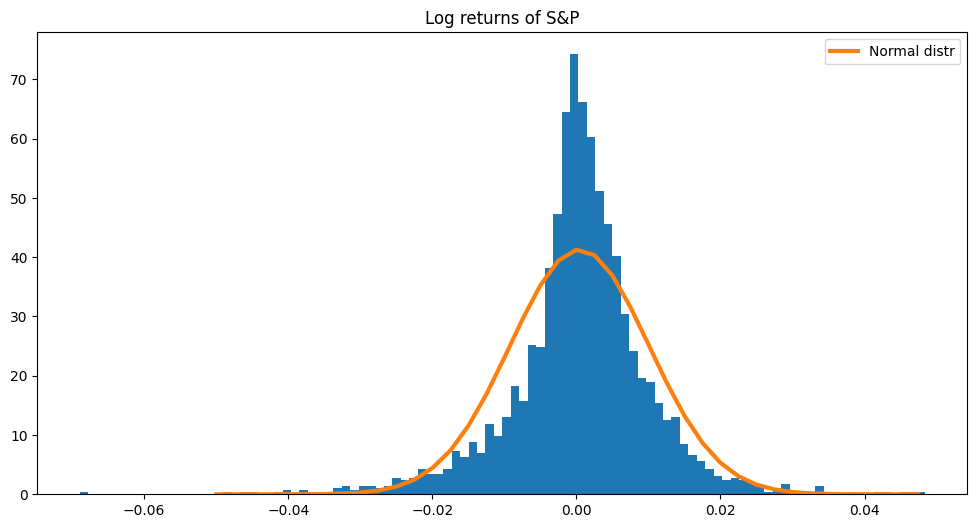

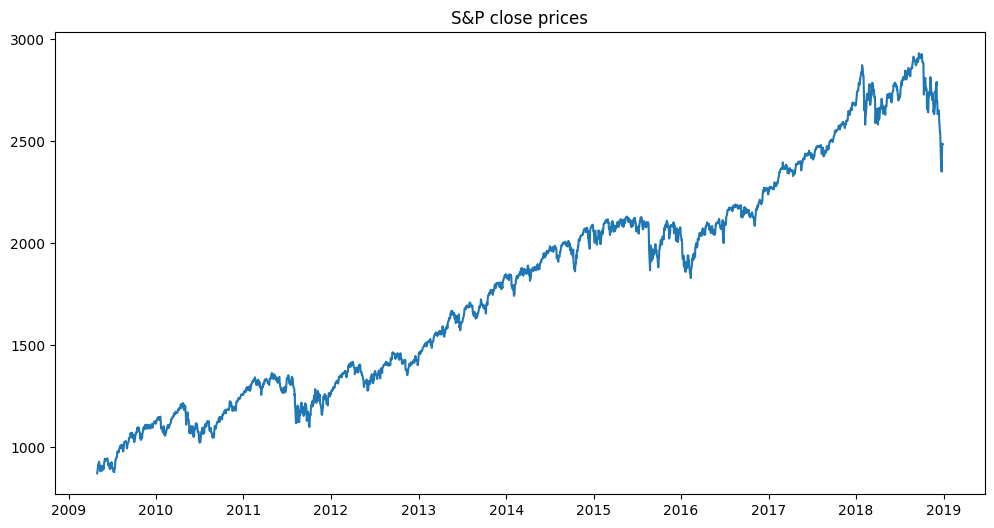

In [62]:
plt.figure(figsize=(12,6))
plt.hist(log_returns,bins=100,density=True)

mean_log_return = np.mean(log_returns)
std_log_return = np.std(log_returns)
x_axis = np.arange(-1, 1, 0.05)/20
plt.plot(x_axis, norm.pdf(x_axis, mean_log_return, std_log_return),label='Normal distr',linewidth=3)
plt.legend()
plt.title('Log returns of S&P')
plt.show()

plt.figure(figsize=(12,6))
plt.plot( snp_data['Close'] )
plt.title('S&P close prices')
plt.show()


We can observe that log returns does not look like Gaussian distribution (you can see it from the graph above). What is very important is that tails are thick.
Thus,we need to gaussianize our log returns.

/Users/ruaszh/Desktop/Learning/MDS/Deep Generative Models/Final Project/final_proj_ver1/gaussianize/gaussianize.py:180: UserWarning: Warning: No convergence after 100 iterations. Increase max_iter.
  warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)


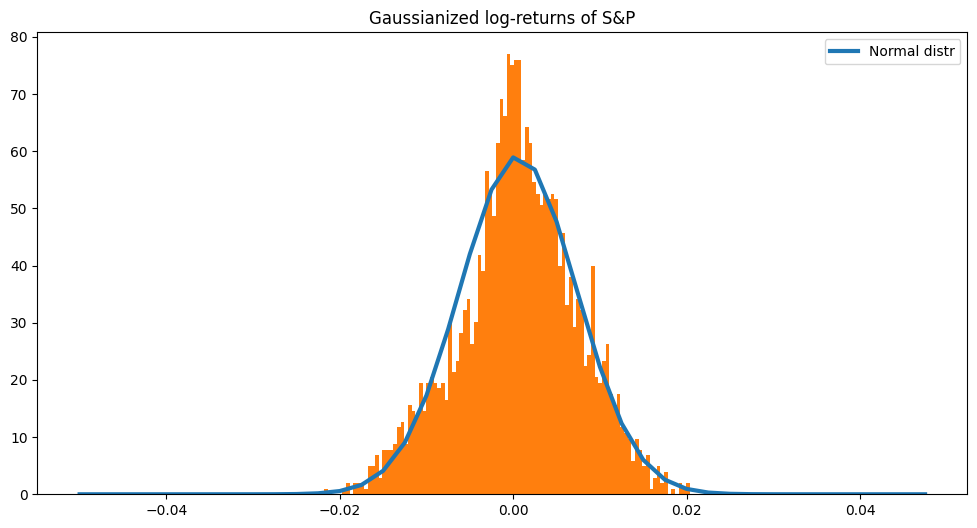

In [63]:
# gaussianizing distribution
gaus = gaussianize.Gaussianize()
gaus.fit(log_returns)
log_returns_normalized = gaus.transform(log_returns).reshape(-1)

# plotting gausianized distribution
mean_log_return_normalized = np.mean(log_returns_normalized)
std_log_return_normalized = np.std(log_returns_normalized)
x_axis = np.arange(-1, 1, 0.05)/20
plt.figure(figsize=(12,6))
plt.plot(x_axis, norm.pdf(x_axis, mean_log_return_normalized, std_log_return_normalized),label='Normal distr',linewidth=3)
plt.legend()
plt.hist( log_returns_normalized,bins=100,density=True )
plt.title('Gaussianized log-returns of S&P')
plt.show()


# GAN

We need to generate the dataset from which we would be able to sample.
As it is written in paper, length of each sequence is set to be 127.

In [5]:
# creating real database to sample from
sequence_len = 127
real_database = [ [[val] for val in log_returns_normalized[i:i+sequence_len]] for i in range(len(log_returns_normalized)-sequence_len+1)]
print(np.array(real_database).shape)


(2307, 127, 1)


### GAN training

In [6]:
N_z = 3
def train_GAN(
        learning_rate = 0.0005,
        num_epochs = 70,
        N_z = N_z, # as set in paper
        n_in_epoch=100,
        batch_size = 32,
        update_gen = 5, # update gen every n step 
        val_clip = 0.01
            ):
    
    losses = []

    # set generator and discriminator
    gen = generator(N_z,1).to(device)
    discr = discriminator(1,1).to(device)
    
    # set optimization for generator and discriminator
    opt_gen = optim.RMSprop(gen.parameters(),lr=learning_rate )
    opt_discr = optim.RMSprop(discr.parameters(),lr=learning_rate )
    
    for epoch_i in tqdm(range(num_epochs)):

        for i in range(n_in_epoch):
            snp_data = random.choices(real_database,k=batch_size)

            discr.zero_grad()

            real_snp = torch.tensor(snp_data).float().to(device)
            noise = torch.randn(batch_size, real_snp.size(1), N_z, device=device)
            generated_snp = gen(noise).detach()

            discr_loss = -torch.mean(discr(real_snp)) + \
                          torch.mean(discr(generated_snp) )
            discr_loss.backward()
            opt_discr.step()

            # clipping
            for param in discr.parameters():
                param.data.clamp_(-val_clip, val_clip)

            if i % update_gen == 0:
                gen.zero_grad()
                gen_loss = -torch.mean(discr(gen(noise)))
                gen_loss.backward()
                opt_gen.step() 
                # print current losses
                print(f'Generator loss = {gen_loss}, Discriminator loss = {discr_loss}')

            # save losses of generator and discriminator
            losses.append([discr_loss,gen_loss])
        
    return losses,gen



  0%|                                                    | 0/70 [00:00<?, ?it/s]

Generator loss = -0.5030414462089539, Discriminator loss = 2.5987625122070312e-05
Generator loss = -0.49702855944633484, Discriminator loss = -0.000491023063659668
Generator loss = -0.49775707721710205, Discriminator loss = 2.3066997528076172e-05
Generator loss = -0.49918100237846375, Discriminator loss = -6.490945816040039e-05
Generator loss = -0.49940797686576843, Discriminator loss = -9.864568710327148e-06
Generator loss = -0.4978606402873993, Discriminator loss = -3.337860107421875e-06
Generator loss = -0.49733245372772217, Discriminator loss = -1.519918441772461e-05
Generator loss = -0.4974649250507355, Discriminator loss = 2.6226043701171875e-06
Generator loss = -0.4978047013282776, Discriminator loss = 6.020069122314453e-06
Generator loss = -0.49838730692863464, Discriminator loss = -2.8014183044433594e-06
Generator loss = -0.49893468618392944, Discriminator loss = -1.1622905731201172e-05
Generator loss = -0.49908384680747986, Discriminator loss = -3.9637088775634766e-06
Generat

  1%|▌                                         | 1/70 [01:33<1:47:19, 93.33s/it]

Generator loss = -0.49898597598075867, Discriminator loss = -1.519918441772461e-06
Generator loss = -0.4985513389110565, Discriminator loss = 5.602836608886719e-06
Generator loss = -0.49797773361206055, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.4976339638233185, Discriminator loss = -7.569789886474609e-06
Generator loss = -0.49739381670951843, Discriminator loss = -5.364418029785156e-06
Generator loss = -0.49760863184928894, Discriminator loss = 3.1888484954833984e-06
Generator loss = -0.4980475902557373, Discriminator loss = 3.933906555175781e-06
Generator loss = -0.49858158826828003, Discriminator loss = -2.175569534301758e-06
Generator loss = -0.49902594089508057, Discriminator loss = -7.927417755126953e-06
Generator loss = -0.4992176592350006, Discriminator loss = -3.129243850708008e-06
Generator loss = -0.4988662004470825, Discriminator loss = 4.708766937255859e-06
Generator loss = -0.49833565950393677, Discriminator loss = 1.043081283569336e-06
Generator los

  3%|█▏                                        | 2/70 [03:05<1:44:44, 92.43s/it]

Generator loss = -0.4976976811885834, Discriminator loss = 1.6391277313232422e-06
Generator loss = -0.49728018045425415, Discriminator loss = -4.351139068603516e-06
Generator loss = -0.496963769197464, Discriminator loss = -5.543231964111328e-06
Generator loss = -0.49702274799346924, Discriminator loss = 9.834766387939453e-07
Generator loss = -0.49751341342926025, Discriminator loss = 3.4570693969726562e-06
Generator loss = -0.49800848960876465, Discriminator loss = -8.046627044677734e-07
Generator loss = -0.4985511004924774, Discriminator loss = -5.7220458984375e-06
Generator loss = -0.4987707734107971, Discriminator loss = -3.159046173095703e-06
Generator loss = -0.498423308134079, Discriminator loss = 3.427267074584961e-06
Generator loss = -0.497919499874115, Discriminator loss = 1.043081283569336e-06
Generator loss = -0.4973706901073456, Discriminator loss = -4.172325134277344e-06
Generator loss = -0.49716055393218994, Discriminator loss = -4.76837158203125e-06
Generator loss = -0.

  4%|█▊                                        | 3/70 [04:42<1:45:58, 94.91s/it]

Generator loss = -0.49731454253196716, Discriminator loss = -3.159046173095703e-06
Generator loss = -0.4975278377532959, Discriminator loss = 2.384185791015625e-06
Generator loss = -0.49799811840057373, Discriminator loss = 1.6093254089355469e-06
Generator loss = -0.4985312521457672, Discriminator loss = -2.6226043701171875e-06
Generator loss = -0.49947813153266907, Discriminator loss = -4.589557647705078e-06
Generator loss = -0.49943026900291443, Discriminator loss = 6.854534149169922e-07
Generator loss = -0.4990230202674866, Discriminator loss = 2.4139881134033203e-06
Generator loss = -0.49849069118499756, Discriminator loss = -1.4007091522216797e-06
Generator loss = -0.4980122148990631, Discriminator loss = -4.32133674621582e-06
Generator loss = -0.49800702929496765, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.4982151687145233, Discriminator loss = 2.592802047729492e-06
Generator loss = -0.4987015426158905, Discriminator loss = 1.7881393432617188e-07
Generator l

  6%|██▍                                       | 4/70 [06:07<1:39:45, 90.69s/it]

Generator loss = -0.4989866614341736, Discriminator loss = -1.1026859283447266e-06
Generator loss = -0.49934083223342896, Discriminator loss = -3.516674041748047e-06
Generator loss = -0.4994187355041504, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.49910610914230347, Discriminator loss = 2.086162567138672e-06
Generator loss = -0.49867767095565796, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4982743263244629, Discriminator loss = -2.7418136596679688e-06
Generator loss = -0.49796634912490845, Discriminator loss = -2.3543834686279297e-06
Generator loss = -0.49827614426612854, Discriminator loss = 1.7285346984863281e-06
Generator loss = -0.4986891448497772, Discriminator loss = 8.344650268554688e-07
Generator loss = -0.4991236627101898, Discriminator loss = -1.6987323760986328e-06
Generator loss = -0.4995774030685425, Discriminator loss = -2.8908252716064453e-06
Generator loss = -0.4994833767414093, Discriminator loss = 4.76837158203125e-07
Generator

  7%|███                                       | 5/70 [07:37<1:38:11, 90.63s/it]

Generator loss = -0.49911239743232727, Discriminator loss = 8.940696716308594e-07
Generator loss = -0.49873363971710205, Discriminator loss = 9.834766387939453e-07
Generator loss = -0.49836447834968567, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.49793902039527893, Discriminator loss = -2.3543834686279297e-06
Generator loss = -0.49823084473609924, Discriminator loss = -6.556510925292969e-07
Generator loss = -0.4985707998275757, Discriminator loss = 1.2516975402832031e-06
Generator loss = -0.49895423650741577, Discriminator loss = 8.940696716308594e-08
Generator loss = -0.4993082284927368, Discriminator loss = -1.4007091522216797e-06
Generator loss = -0.4994671642780304, Discriminator loss = -1.8775463104248047e-06
Generator loss = -0.49942004680633545, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.4992368817329407, Discriminator loss = 8.642673492431641e-07
Generator loss = -0.49892106652259827, Discriminator loss = -2.980232238769531e-07
Generator 

  9%|███▌                                     | 6/70 [10:00<1:55:44, 108.51s/it]

Generator loss = -0.49946749210357666, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4991621673107147, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.49888765811920166, Discriminator loss = -1.6391277313232422e-06
Generator loss = -0.49912312626838684, Discriminator loss = 5.364418029785156e-07
Generator loss = -0.49948984384536743, Discriminator loss = 5.066394805908203e-07
Generator loss = -0.4997338056564331, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.4998795688152313, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.5000360608100891, Discriminator loss = -1.1920928955078125e-06
Generator loss = -0.4999319612979889, Discriminator loss = 5.960464477539062e-07
Generator loss = -0.49971267580986023, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.4995083510875702, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.4991757869720459, Discriminator loss = -8.046627044677734e-07
Generator los

 10%|████                                     | 7/70 [11:34<1:48:53, 103.71s/it]

Generator loss = -0.49959197640419006, Discriminator loss = 0.0
Generator loss = -0.49944907426834106, Discriminator loss = -5.960464477539062e-07
Generator loss = -0.4993639588356018, Discriminator loss = -7.450580596923828e-07
Generator loss = -0.4993910789489746, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.49956536293029785, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.49969619512557983, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49979886412620544, Discriminator loss = -2.086162567138672e-07
Generator loss = -0.4999803304672241, Discriminator loss = -3.8743019104003906e-07
Generator loss = -0.500024139881134, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.4999728798866272, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.4998616576194763, Discriminator loss = 2.086162567138672e-07
Generator loss = -0.49975016713142395, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49962973594

 11%|████▊                                     | 8/70 [12:58<1:40:28, 97.23s/it]

Generator loss = -0.4999808371067047, Discriminator loss = 2.086162567138672e-07
Generator loss = -0.49986571073532104, Discriminator loss = 8.940696716308594e-08
Generator loss = -0.49980053305625916, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49970731139183044, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.4995506703853607, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.49966129660606384, Discriminator loss = 0.0
Generator loss = -0.4998219311237335, Discriminator loss = 1.4901161193847656e-07
Generator loss = -0.4999055862426758, Discriminator loss = 0.0
Generator loss = -0.49996712803840637, Discriminator loss = 0.0
Generator loss = -0.500062882900238, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5002170205116272, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5002013444900513, Discriminator loss = 0.0
Generator loss = -0.5000302791595459, Discriminator loss = 5.960464477539063e-08
Genera

 13%|█████▍                                    | 9/70 [14:19<1:33:43, 92.19s/it]

Generator loss = -0.4999644160270691, Discriminator loss = 0.0
Generator loss = -0.5000436902046204, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5001376867294312, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5000649094581604, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.4999702274799347, Discriminator loss = 0.0
Generator loss = -0.49992746114730835, Discriminator loss = 0.0
Generator loss = -0.49992847442626953, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.49993130564689636, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.4999326467514038, Discriminator loss = 0.0
Generator loss = -0.49991464614868164, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4999147057533264, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4999288320541382, Discriminator loss = 0.0
Generator loss = -0.4999596178531647, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.5

 14%|█████▊                                   | 10/70 [15:54<1:33:09, 93.17s/it]

Generator loss = -0.4999634623527527, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5000245571136475, Discriminator loss = 0.0
Generator loss = -0.5000429749488831, Discriminator loss = 0.0
Generator loss = -0.5000605583190918, Discriminator loss = 0.0
Generator loss = -0.5001064538955688, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5001065135002136, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5000587105751038, Discriminator loss = 0.0
Generator loss = -0.5000402331352234, Discriminator loss = 0.0
Generator loss = -0.5000298023223877, Discriminator loss = 0.0
Generator loss = -0.5000026226043701, Discriminator loss = 0.0
Generator loss = -0.4999936819076538, Discriminator loss = 0.0
Generator loss = -0.5000324249267578, Discriminator loss = 0.0
Generator loss = -0.5000393390655518, Discriminator loss = 0.0
Generator loss = -0.500045895576477, Discriminator loss = 0.0
Generator loss = -0.5000609755516052, Discriminator loss = -5

 16%|██████▍                                  | 11/70 [17:19<1:29:00, 90.51s/it]

Generator loss = -0.5000293254852295, Discriminator loss = 0.0
Generator loss = -0.5000350475311279, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5000451803207397, Discriminator loss = 0.0
Generator loss = -0.500088095664978, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002471208572388, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.500156044960022, Discriminator loss = 0.0
Generator loss = -0.5000590682029724, Discriminator loss = 0.0
Generator loss = -0.500030517578125, Discriminator loss = 0.0
Generator loss = -0.4999999701976776, Discriminator loss = 0.0
Generator loss = -0.49993252754211426, Discriminator loss = 0.0
Generator loss = -0.5000252723693848, Discriminator loss = 0.0
Generator loss = -0.5000542998313904, Discriminator loss = 0.0
Generator loss = -0.5001288056373596, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.500147819519043, Discriminator loss = 0.0
Generator loss = -0.5000418424606323, Discrim

 17%|███████                                  | 12/70 [19:06<1:32:22, 95.56s/it]

Generator loss = -0.5000227093696594, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5000413656234741, Discriminator loss = 0.0
Generator loss = -0.5001128911972046, Discriminator loss = 0.0
Generator loss = -0.5003829598426819, Discriminator loss = 0.0
Generator loss = -0.5000289082527161, Discriminator loss = 0.0
Generator loss = -0.4997919499874115, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5000905394554138, Discriminator loss = 0.0
Generator loss = -0.5002203583717346, Discriminator loss = -1.0192394256591797e-05
Generator loss = -0.49980032444000244, Discriminator loss = -2.473592758178711e-06
Generator loss = -0.49966976046562195, Discriminator loss = -4.44948673248291e-05
Generator loss = -0.49794450402259827, Discriminator loss = -8.726119995117188e-05
Generator loss = -0.4982278048992157, Discriminator loss = 1.138448715209961e-05
Generator loss = -0.49930885434150696, Discriminator loss = -1.5795230865478516e-05
Generator loss = -0.49989

 19%|███████▍                                | 13/70 [21:06<1:37:56, 103.10s/it]

Generator loss = -0.49798882007598877, Discriminator loss = -1.2516975402832031e-06
Generator loss = -0.49858295917510986, Discriminator loss = 6.4373016357421875e-06
Generator loss = -0.4991823136806488, Discriminator loss = 3.7848949432373047e-06
Generator loss = -0.499519944190979, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.49994131922721863, Discriminator loss = -3.874301910400391e-06
Generator loss = -0.5003353953361511, Discriminator loss = -1.0788440704345703e-05
Generator loss = -0.5005538463592529, Discriminator loss = -6.020069122314453e-06
Generator loss = -0.5002936124801636, Discriminator loss = 6.318092346191406e-06
Generator loss = -0.49989691376686096, Discriminator loss = 3.4570693969726562e-06
Generator loss = -0.4995458424091339, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.4991130232810974, Discriminator loss = -2.205371856689453e-06
Generator loss = -0.4987432658672333, Discriminator loss = -5.7220458984375e-06
Generator loss =

 20%|████████                                | 14/70 [23:21<1:45:13, 112.74s/it]

Generator loss = -0.50010085105896, Discriminator loss = 3.993511199951172e-06
Generator loss = -0.4997343420982361, Discriminator loss = 3.516674041748047e-06
Generator loss = -0.49885454773902893, Discriminator loss = 8.642673492431641e-07
Generator loss = -0.49854281544685364, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.49808254837989807, Discriminator loss = -2.7120113372802734e-06
Generator loss = -0.49785223603248596, Discriminator loss = -5.990266799926758e-06
Generator loss = -0.49744632840156555, Discriminator loss = -5.27501106262207e-06
Generator loss = -0.49775344133377075, Discriminator loss = 3.4868717193603516e-06
Generator loss = -0.4979604482650757, Discriminator loss = 3.0994415283203125e-06
Generator loss = -0.49836471676826477, Discriminator loss = 9.834766387939453e-07
Generator loss = -0.49867457151412964, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.4990421235561371, Discriminator loss = -2.950429916381836e-06
Generator loss

 21%|████████▌                               | 15/70 [25:28<1:47:22, 117.13s/it]

Generator loss = -0.4975825548171997, Discriminator loss = -2.3543834686279297e-06
Generator loss = -0.498004674911499, Discriminator loss = 3.039836883544922e-06
Generator loss = -0.4983699321746826, Discriminator loss = 1.6987323760986328e-06
Generator loss = -0.4987095594406128, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.4995267391204834, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.49980035424232483, Discriminator loss = -1.9371509552001953e-06
Generator loss = -0.5001524686813354, Discriminator loss = -5.185604095458984e-06
Generator loss = -0.5002155303955078, Discriminator loss = -1.430511474609375e-06
Generator loss = -0.49986258149147034, Discriminator loss = 2.8014183044433594e-06
Generator loss = -0.49965158104896545, Discriminator loss = 1.043081283569336e-06
Generator loss = -0.49943047761917114, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.49918416142463684, Discriminator loss = -4.76837158203125e-07
Generator loss 

 23%|█████████▏                              | 16/70 [27:40<1:49:22, 121.54s/it]

Generator loss = -0.49955999851226807, Discriminator loss = -3.635883331298828e-06
Generator loss = -0.4997531473636627, Discriminator loss = -2.7418136596679688e-06
Generator loss = -0.4995010197162628, Discriminator loss = 2.2351741790771484e-06
Generator loss = -0.499376118183136, Discriminator loss = 9.5367431640625e-07
Generator loss = -0.4991825222969055, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.4989530146121979, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.4985707104206085, Discriminator loss = -1.2814998626708984e-06
Generator loss = -0.4980648458003998, Discriminator loss = -2.86102294921875e-06
Generator loss = -0.49774765968322754, Discriminator loss = -2.1457672119140625e-06
Generator loss = -0.49830716848373413, Discriminator loss = 1.6689300537109375e-06
Generator loss = -0.49897500872612, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.49919116497039795, Discriminator loss = 1.1920928955078125e-07
Generator loss = 

 24%|█████████▋                              | 17/70 [29:55<1:50:51, 125.51s/it]

Generator loss = -0.4989768862724304, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.4987466633319855, Discriminator loss = -1.4007091522216797e-06
Generator loss = -0.4986421465873718, Discriminator loss = -1.9371509552001953e-06
Generator loss = -0.49892857670783997, Discriminator loss = 1.043081283569336e-06
Generator loss = -0.4987463653087616, Discriminator loss = 5.066394805908203e-07
Generator loss = -0.4988648593425751, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.4990096688270569, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.499173641204834, Discriminator loss = -7.450580596923828e-07
Generator loss = -0.4993172585964203, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.49946197867393494, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.49933964014053345, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.49923205375671387, Discriminator loss = 2.980232238769531e-07
Generator loss

 26%|██████████▎                             | 18/70 [32:07<1:50:25, 127.42s/it]

Generator loss = -0.4994718134403229, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4995681345462799, Discriminator loss = 0.0
Generator loss = -0.4996500611305237, Discriminator loss = -8.940696716308594e-08
Generator loss = -0.49974340200424194, Discriminator loss = -2.086162567138672e-07
Generator loss = -0.4997911751270294, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.4998609125614166, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.4997779130935669, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.4996597468852997, Discriminator loss = 8.940696716308594e-08
Generator loss = -0.499571830034256, Discriminator loss = 0.0
Generator loss = -0.49950331449508667, Discriminator loss = 0.0
Generator loss = -0.49943456053733826, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.49934837222099304, Discriminator loss = -2.086162567138672e-07
Generator loss = -0.499246746301651, Discriminator loss = -2.0861625671

 27%|██████████▊                             | 19/70 [34:09<1:47:03, 125.95s/it]

Generator loss = -0.49964669346809387, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.499685674905777, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.4996778070926666, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.49962982535362244, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.4995761811733246, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49952948093414307, Discriminator loss = 0.0
Generator loss = -0.4994819462299347, Discriminator loss = 0.0
Generator loss = -0.4994206428527832, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4993341267108917, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4992517828941345, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.49927985668182373, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49937981367111206, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.49946194887161255, Discrimina

 29%|███████████▍                            | 20/70 [36:13<1:44:22, 125.25s/it]

Generator loss = -0.49962255358695984, Discriminator loss = 0.0
Generator loss = -0.49958115816116333, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49954017996788025, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.49942800402641296, Discriminator loss = -2.086162567138672e-07
Generator loss = -0.49947333335876465, Discriminator loss = 1.4901161193847656e-07
Generator loss = -0.499514102935791, Discriminator loss = 0.0
Generator loss = -0.4995056986808777, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4995463192462921, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.49955111742019653, Discriminator loss = 0.0
Generator loss = -0.4996206760406494, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.4996175169944763, Discriminator loss = 0.0
Generator loss = -0.4995763301849365, Discriminator loss = 0.0
Generator loss = -0.49956291913986206, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.

 30%|████████████                            | 21/70 [38:08<1:39:46, 122.17s/it]

Generator loss = -0.499750554561615, Discriminator loss = 0.0
Generator loss = -0.4997193217277527, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.4996948540210724, Discriminator loss = -3.8743019104003906e-07
Generator loss = -0.49971017241477966, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.49974340200424194, Discriminator loss = 0.0
Generator loss = -0.499747633934021, Discriminator loss = 0.0
Generator loss = -0.49964845180511475, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49964702129364014, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.4998775124549866, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4998438060283661, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4997575581073761, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.49975624680519104, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4998508393764496, Discriminator loss = 2.98

 31%|████████████▌                           | 22/70 [40:20<1:39:59, 124.99s/it]

Generator loss = -0.4999798834323883, Discriminator loss = 0.0
Generator loss = -0.4998584985733032, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.49999570846557617, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.5000345706939697, Discriminator loss = 0.0
Generator loss = -0.5000494122505188, Discriminator loss = 0.0
Generator loss = -0.5000422596931458, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5000585913658142, Discriminator loss = 0.0
Generator loss = -0.5000471472740173, Discriminator loss = 0.0
Generator loss = -0.5000353455543518, Discriminator loss = 0.0
Generator loss = -0.5000178217887878, Discriminator loss = 0.0
Generator loss = -0.4999760389328003, Discriminator loss = -8.940696716308594e-08
Generator loss = -0.49997425079345703, Discriminator loss = 0.0
Generator loss = -0.5000249147415161, Discriminator loss = 0.0
Generator loss = -0.5000393390655518, Discriminator loss = 0.0
Generator loss = -0.5000501871109009, D

 33%|█████████████▏                          | 23/70 [42:25<1:38:05, 125.21s/it]

Generator loss = -0.49988842010498047, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.5001734495162964, Discriminator loss = 0.0
Generator loss = -0.499942421913147, Discriminator loss = -1.385807991027832e-05
Generator loss = -0.5002873539924622, Discriminator loss = -7.748603820800781e-07
Generator loss = -0.49957939982414246, Discriminator loss = -3.3348798751831055e-05
Generator loss = -0.4997745454311371, Discriminator loss = -3.933906555175781e-06
Generator loss = -0.5011118054389954, Discriminator loss = 4.5299530029296875e-06
Generator loss = -0.5013850331306458, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5019939541816711, Discriminator loss = -5.9604644775390625e-06
Generator loss = -0.5022899508476257, Discriminator loss = -1.901388168334961e-05
Generator loss = -0.5018166303634644, Discriminator loss = 3.516674041748047e-06
Generator loss = -0.5013057589530945, Discriminator loss = 2.8014183044433594e-06
Generator loss = -0.5010851621627

 34%|█████████████▋                          | 24/70 [44:37<1:37:30, 127.18s/it]

Generator loss = -0.5016489028930664, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5019482970237732, Discriminator loss = -2.1457672119140625e-06
Generator loss = -0.5017374157905579, Discriminator loss = -6.496906280517578e-06
Generator loss = -0.5017135739326477, Discriminator loss = -6.556510925292969e-07
Generator loss = -0.5015560388565063, Discriminator loss = 2.86102294921875e-06
Generator loss = -0.5013186931610107, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.5012015104293823, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.50112384557724, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5006169676780701, Discriminator loss = -1.430511474609375e-06
Generator loss = -0.5002379417419434, Discriminator loss = -4.887580871582031e-06
Generator loss = -0.4998883903026581, Discriminator loss = -2.86102294921875e-06
Generator loss = -0.5006021857261658, Discriminator loss = 2.8014183044433594e-06
Generator loss = -0.50

 36%|██████████████▎                         | 25/70 [46:11<1:27:48, 117.09s/it]

Generator loss = -0.5000340938568115, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5000022053718567, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.4999290406703949, Discriminator loss = -6.258487701416016e-07
Generator loss = -0.49978020787239075, Discriminator loss = -2.950429916381836e-06
Generator loss = -0.49924731254577637, Discriminator loss = -3.3676624298095703e-06
Generator loss = -0.4996858239173889, Discriminator loss = 1.5497207641601562e-06
Generator loss = -0.5000096559524536, Discriminator loss = 8.046627044677734e-07
Generator loss = -0.5001307129859924, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5001874566078186, Discriminator loss = 0.0
Generator loss = -0.5002536773681641, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5004070997238159, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.500821590423584, Discriminator loss = -2.0265579223632812e-06
Generator loss = -0.5013312101364

 37%|██████████████▊                         | 26/70 [49:09<1:39:18, 135.42s/it]

Generator loss = -0.4994407296180725, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.4999365210533142, Discriminator loss = 9.834766387939453e-07
Generator loss = -0.5001881718635559, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5002801418304443, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5003169178962708, Discriminator loss = 0.0
Generator loss = -0.5003441572189331, Discriminator loss = 0.0
Generator loss = -0.5003876090049744, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5005536675453186, Discriminator loss = -1.2516975402832031e-06
Generator loss = -0.5005937218666077, Discriminator loss = -1.5497207641601562e-06
Generator loss = -0.5005233287811279, Discriminator loss = 7.748603820800781e-07
Generator loss = -0.5004504919052124, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5005084276199341, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5004804134368896, Discriminator loss = 

 39%|███████████████▍                        | 27/70 [51:49<1:42:28, 142.99s/it]

Generator loss = -0.5004796981811523, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5004428029060364, Discriminator loss = 0.0
Generator loss = -0.500207781791687, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5000172853469849, Discriminator loss = -1.6689300537109375e-06
Generator loss = -0.5002341270446777, Discriminator loss = 5.364418029785156e-07
Generator loss = -0.5004236698150635, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5004810094833374, Discriminator loss = 0.0
Generator loss = -0.5004985928535461, Discriminator loss = 0.0
Generator loss = -0.5005017518997192, Discriminator loss = 0.0
Generator loss = -0.5011132955551147, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5010049343109131, Discriminator loss = -5.960464477539062e-07
Generator loss = -0.5008725523948669, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5009872913360596, Discriminator loss = 2.384185791015625e-07
Generator lo

 40%|████████████████                        | 28/70 [54:02<1:37:53, 139.84s/it]

Generator loss = -0.5012894868850708, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5010607242584229, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5009840130805969, Discriminator loss = 0.0
Generator loss = -0.5009493827819824, Discriminator loss = 0.0
Generator loss = -0.50080406665802, Discriminator loss = 0.0
Generator loss = -0.5006669759750366, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5004303455352783, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5004194974899292, Discriminator loss = 0.0
Generator loss = -0.50068199634552, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5008106827735901, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5008477568626404, Discriminator loss = 0.0
Generator loss = -0.5008454322814941, Discriminator loss = 0.0
Generator loss = -0.5008083581924438, Discriminator loss = 0.0
Generator loss = -0.5006915330886841, Discriminator loss = -5.9604644775

 41%|████████████████▌                       | 29/70 [55:39<1:26:46, 126.98s/it]

Generator loss = -0.5009321570396423, Discriminator loss = 0.0
Generator loss = -0.5008346438407898, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5006417632102966, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5007876753807068, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5009326338768005, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.500969409942627, Discriminator loss = 0.0
Generator loss = -0.5009746551513672, Discriminator loss = 0.0
Generator loss = -0.5009711384773254, Discriminator loss = 0.0
Generator loss = -0.5009565949440002, Discriminator loss = 0.0
Generator loss = -0.500910222530365, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5008503198623657, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5016713738441467, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5016941428184509, Discriminator loss = 0.0
Generator loss = -0.5016980171203613, Discriminat

 43%|█████████████████▏                      | 30/70 [57:14<1:18:18, 117.47s/it]

Generator loss = -0.5017935037612915, Discriminator loss = 0.0
Generator loss = -0.5021463632583618, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5017228722572327, Discriminator loss = 0.0
Generator loss = -0.5016534924507141, Discriminator loss = 0.0
Generator loss = -0.5014810562133789, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5014135241508484, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5017223954200745, Discriminator loss = 0.0
Generator loss = -0.50184565782547, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.5018089413642883, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5016289353370667, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.501622200012207, Discriminator loss = 0.0
Generator loss = -0.5018291473388672, Discriminator loss = -1.430511474609375e-06
Generator loss = -0.501528263092041, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.501488626003265

 44%|█████████████████▋                      | 31/70 [59:09<1:15:51, 116.71s/it]

Generator loss = -0.5014172196388245, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5014252066612244, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5014179944992065, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5014095306396484, Discriminator loss = 0.0
Generator loss = -0.5013976097106934, Discriminator loss = 0.0
Generator loss = -0.501369833946228, Discriminator loss = 0.0
Generator loss = -0.5012911558151245, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5007382035255432, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5008513927459717, Discriminator loss = 0.0
Generator loss = -0.5009858012199402, Discriminator loss = 0.0
Generator loss = -0.5009918808937073, Discriminator loss = 0.0
Generator loss = -0.5009711980819702, Discriminator loss = 0.0
Generator loss = -0.5008535385131836, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5009482502937317, Discriminator loss = 5.9604

 46%|█████████████████▎                    | 32/70 [1:01:21<1:16:44, 121.18s/it]

Generator loss = -0.5009849667549133, Discriminator loss = 0.0
Generator loss = -0.5009990930557251, Discriminator loss = 0.0
Generator loss = -0.5010152459144592, Discriminator loss = 0.0
Generator loss = -0.5010784864425659, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5011681914329529, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5011205077171326, Discriminator loss = 0.0
Generator loss = -0.5010547041893005, Discriminator loss = 0.0
Generator loss = -0.5002512335777283, Discriminator loss = -2.562999725341797e-06
Generator loss = -0.5018589496612549, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5017620921134949, Discriminator loss = -3.0994415283203125e-05
Generator loss = -0.5017207264900208, Discriminator loss = 2.8014183044433594e-06
Generator loss = -0.5014302134513855, Discriminator loss = -2.1457672119140625e-06
Generator loss = -0.5001546144485474, Discriminator loss = -1.4901161193847656e-05
Generator loss = -0.5001

 47%|█████████████████▉                    | 33/70 [1:03:27<1:15:44, 122.83s/it]

Generator loss = -0.5013226270675659, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.5010131001472473, Discriminator loss = -3.5762786865234375e-06
Generator loss = -0.500707745552063, Discriminator loss = -5.0067901611328125e-06
Generator loss = -0.5008513927459717, Discriminator loss = 2.205371856689453e-06
Generator loss = -0.5010956525802612, Discriminator loss = 1.3113021850585938e-06
Generator loss = -0.5012723803520203, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5013948678970337, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5008991956710815, Discriminator loss = -1.9669532775878906e-06
Generator loss = -0.5010569095611572, Discriminator loss = -4.470348358154297e-06
Generator loss = -0.5013177990913391, Discriminator loss = 9.5367431640625e-07
Generator loss = -0.5010340213775635, Discriminator loss = 1.3709068298339844e-06
Generator loss = -0.5008825659751892, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.

 49%|██████████████████▍                   | 34/70 [1:05:49<1:17:04, 128.47s/it]

Generator loss = -0.5006830096244812, Discriminator loss = 0.0
Generator loss = -0.5007458329200745, Discriminator loss = 0.0
Generator loss = -0.500815749168396, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5009199380874634, Discriminator loss = -7.748603820800781e-07
Generator loss = -0.5010592341423035, Discriminator loss = -3.0994415283203125e-06
Generator loss = -0.5010834336280823, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.5011202692985535, Discriminator loss = 1.1920928955078125e-06
Generator loss = -0.5010693073272705, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5009962320327759, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5009409189224243, Discriminator loss = 0.0
Generator loss = -0.5008808970451355, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5008078813552856, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.5007327198982239, Discriminator loss = -3.457069396972

 50%|███████████████████                   | 35/70 [1:08:15<1:18:02, 133.79s/it]

Generator loss = -0.5016549229621887, Discriminator loss = -5.960464477539062e-07
Generator loss = -0.5012829303741455, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.5010907053947449, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.500716507434845, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5006997585296631, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5007625222206116, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5010098218917847, Discriminator loss = -1.9073486328125e-06
Generator loss = -0.5010349154472351, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5005240440368652, Discriminator loss = 5.364418029785156e-07
Generator loss = -0.5012198090553284, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5012524127960205, Discriminator loss = 0.0
Generator loss = -0.5013672113418579, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5016700625419617, Di

 51%|███████████████████▌                  | 36/70 [1:10:13<1:13:03, 128.93s/it]

Generator loss = -0.5000473260879517, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.501395583152771, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5015816688537598, Discriminator loss = 0.0
Generator loss = -0.5016577839851379, Discriminator loss = 0.0
Generator loss = -0.5017416477203369, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5019208788871765, Discriminator loss = -1.0728836059570312e-06
Generator loss = -0.5019679069519043, Discriminator loss = -7.748603820800781e-07
Generator loss = -0.5019453763961792, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5019038915634155, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5018505454063416, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5017333030700684, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.501544177532196, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.5011657476425171, Discriminator loss

 53%|████████████████████                  | 37/70 [1:12:04<1:07:59, 123.61s/it]

Generator loss = -0.5020086169242859, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5019295811653137, Discriminator loss = 0.0
Generator loss = -0.501813530921936, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5016523003578186, Discriminator loss = -2.086162567138672e-06
Generator loss = -0.5020412802696228, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5021214485168457, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5021540522575378, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5021830201148987, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.502194881439209, Discriminator loss = -2.086162567138672e-06
Generator loss = -0.5021477341651917, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.502085268497467, Discriminator loss = 0.0
Generator loss = -0.5017666220664978, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5002076625823975, Discriminator loss = -

 54%|████████████████████▋                 | 38/70 [1:14:03<1:05:15, 122.36s/it]

Generator loss = -0.5012637376785278, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.5008421540260315, Discriminator loss = -1.3709068298339844e-06
Generator loss = -0.5015654563903809, Discriminator loss = 5.364418029785156e-07
Generator loss = -0.5017731785774231, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.501801073551178, Discriminator loss = 0.0
Generator loss = -0.5016909837722778, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5012474656105042, Discriminator loss = -1.6689300537109375e-06
Generator loss = -0.5014379024505615, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5018301010131836, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.501924991607666, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.501937210559845, Discriminator loss = 0.0
Generator loss = -0.5019175410270691, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5018844604492188, Discriminator loss = -5

 56%|█████████████████████▏                | 39/70 [1:15:59<1:02:06, 120.21s/it]

Generator loss = -0.5022714734077454, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5022186040878296, Discriminator loss = 0.0
Generator loss = -0.5022018551826477, Discriminator loss = 0.0
Generator loss = -0.5022158026695251, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5023428201675415, Discriminator loss = -1.430511474609375e-06
Generator loss = -0.5023089647293091, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5022075176239014, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5022020936012268, Discriminator loss = 0.0
Generator loss = -0.5022155046463013, Discriminator loss = 0.0
Generator loss = -0.5022627115249634, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5024663209915161, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.5025848150253296, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.5023606419563293, Discriminator loss = 2.384185791015625e-07
Generator lo

 57%|██████████████████████▊                 | 40/70 [1:17:48<58:25, 116.87s/it]

Generator loss = -0.5025348663330078, Discriminator loss = -2.682209014892578e-06
Generator loss = -0.5025299787521362, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5026341080665588, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.5025701522827148, Discriminator loss = -1.0073184967041016e-05
Generator loss = -0.5026220679283142, Discriminator loss = 1.5497207641601562e-06
Generator loss = -0.5025723576545715, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5026298761367798, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5022392868995667, Discriminator loss = -4.887580871582031e-06
Generator loss = -0.5021460056304932, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.5019968152046204, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5019468069076538, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5019010901451111, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.

 59%|███████████████████████▍                | 41/70 [1:19:44<56:27, 116.81s/it]

Generator loss = -0.5023147463798523, Discriminator loss = 7.748603820800781e-07
Generator loss = -0.5022236704826355, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5022063851356506, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5022324323654175, Discriminator loss = 0.0
Generator loss = -0.5023385286331177, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5026610493659973, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.5028631687164307, Discriminator loss = -6.556510925292969e-07
Generator loss = -0.5023334622383118, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.5022071003913879, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5021681785583496, Discriminator loss = 0.0
Generator loss = -0.5021159052848816, Discriminator loss = 0.0
Generator loss = -0.5019420385360718, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5015878677368164, Discriminator loss = -1.72853469848632

 60%|████████████████████████                | 42/70 [1:21:37<53:50, 115.39s/it]

Generator loss = -0.5018702149391174, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5019974708557129, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5019744634628296, Discriminator loss = 0.0
Generator loss = -0.5017513036727905, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5013052225112915, Discriminator loss = -2.682209014892578e-06
Generator loss = -0.5021418929100037, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.5022172927856445, Discriminator loss = 0.0
Generator loss = -0.502152681350708, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5018579959869385, Discriminator loss = -2.682209014892578e-06
Generator loss = -0.5020566582679749, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5023975968360901, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5024236440658569, Discriminator loss = 0.0
Generator loss = -0.5022904276847839, Discriminator loss = -1.192092895507812

 61%|███████████████████████▎              | 43/70 [1:25:16<1:05:56, 146.55s/it]

Generator loss = -0.5022470355033875, Discriminator loss = -1.3709068298339844e-06
Generator loss = -0.5021936893463135, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5022401213645935, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5022544264793396, Discriminator loss = 0.0
Generator loss = -0.5021939277648926, Discriminator loss = 0.0
Generator loss = -0.5019425749778748, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5013064742088318, Discriminator loss = -7.748603820800781e-07
Generator loss = -0.5015090107917786, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5020478367805481, Discriminator loss = 0.0
Generator loss = -0.5022282600402832, Discriminator loss = 0.0
Generator loss = -0.502274215221405, Discriminator loss = 0.0
Generator loss = -0.5022597312927246, Discriminator loss = 0.0
Generator loss = -0.5021803975105286, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5019814372062683, Discriminat

 63%|█████████████████████████▏              | 44/70 [1:27:14<59:47, 138.00s/it]

Generator loss = -0.5017601251602173, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5015769600868225, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5022770166397095, Discriminator loss = 0.0
Generator loss = -0.5023971199989319, Discriminator loss = 0.0
Generator loss = -0.5024176239967346, Discriminator loss = 0.0
Generator loss = -0.5024214386940002, Discriminator loss = 0.0
Generator loss = -0.502448558807373, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5024620890617371, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5024385452270508, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5024113655090332, Discriminator loss = 0.0
Generator loss = -0.5023404359817505, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5019533038139343, Discriminator loss = -3.0994415283203125e-06
Generator loss = -0.5024000406265259, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.502276

 64%|█████████████████████████▋              | 45/70 [1:28:42<51:18, 123.15s/it]

Generator loss = -0.5017156600952148, Discriminator loss = -6.556510925292969e-06
Generator loss = -0.5018284916877747, Discriminator loss = 1.3113021850585938e-06
Generator loss = -0.5022181868553162, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5020841360092163, Discriminator loss = -2.2649765014648438e-06
Generator loss = -0.5018306374549866, Discriminator loss = -3.635883331298828e-06
Generator loss = -0.502021312713623, Discriminator loss = 1.3709068298339844e-06
Generator loss = -0.5020490288734436, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5020223259925842, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5019367933273315, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5016025900840759, Discriminator loss = -1.9669532775878906e-06
Generator loss = -0.5007804036140442, Discriminator loss = -3.516674041748047e-06
Generator loss = -0.5012704730033875, Discriminator loss = 1.3113021850585938e-06
Generator loss = 

 66%|██████████████████████████▎             | 46/70 [1:30:11<45:04, 112.70s/it]

Generator loss = -0.5014722943305969, Discriminator loss = 0.0
Generator loss = -0.5013077259063721, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5009053945541382, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.5004451870918274, Discriminator loss = -1.7881393432617188e-06
Generator loss = -0.5012409090995789, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.5015529990196228, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5016623139381409, Discriminator loss = 0.0
Generator loss = -0.5017161965370178, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5017942786216736, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.5017854571342468, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.5018099546432495, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.5018270015716553, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5017497539520264, Discriminator loss 

 67%|██████████████████████████▊             | 47/70 [1:31:44<40:57, 106.84s/it]

Generator loss = -0.501492440700531, Discriminator loss = 0.0
Generator loss = -0.5015656352043152, Discriminator loss = 0.0
Generator loss = -0.5016084909439087, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5016774535179138, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5018178224563599, Discriminator loss = -6.556510925292969e-07
Generator loss = -0.5018842220306396, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5017411708831787, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5016400218009949, Discriminator loss = 0.0
Generator loss = -0.5015964508056641, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5015746355056763, Discriminator loss = 0.0
Generator loss = -0.5015533566474915, Discriminator loss = 0.0
Generator loss = -0.5015184283256531, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5014612078666687, Discriminator loss = -6.556510925292969e-07
Generator loss = -0.50182354450

 69%|███████████████████████████▍            | 48/70 [1:33:14<37:23, 101.97s/it]

Generator loss = -0.5021240711212158, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5026019215583801, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5025274753570557, Discriminator loss = 0.0
Generator loss = -0.5025028586387634, Discriminator loss = 0.0
Generator loss = -0.5024914145469666, Discriminator loss = 0.0
Generator loss = -0.5024738311767578, Discriminator loss = 0.0
Generator loss = -0.5024247765541077, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5022760629653931, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5020167231559753, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.502316415309906, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5024486184120178, Discriminator loss = 0.0
Generator loss = -0.5025005340576172, Discriminator loss = 0.0
Generator loss = -0.5025548338890076, Discriminator loss = 0.0
Generator loss = -0.5026893019676208, Discriminator loss = -5.960464

 70%|████████████████████████████▋            | 49/70 [1:34:43<34:17, 97.98s/it]

Generator loss = -0.5025507211685181, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5024356842041016, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5025262236595154, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5025553703308105, Discriminator loss = 0.0
Generator loss = -0.5025430917739868, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.502548098564148, Discriminator loss = 0.0
Generator loss = -0.5026283860206604, Discriminator loss = 0.0
Generator loss = -0.5028698444366455, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.502535343170166, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5025478601455688, Discriminator loss = 0.0
Generator loss = -0.502677321434021, Discriminator loss = 0.0
Generator loss = -0.5028634071350098, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.5024822354316711, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5024156570434

 71%|█████████████████████████████▎           | 50/70 [1:36:10<31:31, 94.57s/it]

Generator loss = -0.5024058222770691, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.502016007900238, Discriminator loss = -2.682209014892578e-06
Generator loss = -0.5019440650939941, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5020812153816223, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.502257764339447, Discriminator loss = -7.748603820800781e-07
Generator loss = -0.5022039413452148, Discriminator loss = -9.298324584960938e-06
Generator loss = -0.5025336742401123, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.5021869540214539, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.5015461444854736, Discriminator loss = -1.2814998626708984e-05
Generator loss = -0.5022010803222656, Discriminator loss = 2.0265579223632812e-06
Generator loss = -0.50240159034729, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5025553107261658, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.50

 73%|█████████████████████████████▊           | 51/70 [1:37:40<29:29, 93.16s/it]

Generator loss = -0.5024555921554565, Discriminator loss = 5.364418029785156e-07
Generator loss = -0.5024974346160889, Discriminator loss = 0.0
Generator loss = -0.5025374889373779, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5026118755340576, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.502871572971344, Discriminator loss = -4.947185516357422e-06
Generator loss = -0.5027140974998474, Discriminator loss = 1.430511474609375e-06
Generator loss = -0.5025337338447571, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5024747252464294, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5024471282958984, Discriminator loss = 0.0
Generator loss = -0.5023940205574036, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5021821856498718, Discriminator loss = -1.4901161193847656e-06
Generator loss = -0.5019416213035583, Discriminator loss = -1.9669532775878906e-06
Generator loss = -0.5022846460342407, Discriminator loss =

 74%|██████████████████████████████▍          | 52/70 [1:39:06<27:22, 91.26s/it]

Generator loss = -0.5028027892112732, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5026089549064636, Discriminator loss = 0.0
Generator loss = -0.502535343170166, Discriminator loss = 0.0
Generator loss = -0.5024983286857605, Discriminator loss = 0.0
Generator loss = -0.5024484992027283, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.502265989780426, Discriminator loss = -7.748603820800781e-07
Generator loss = -0.5022550821304321, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.502322256565094, Discriminator loss = 5.364418029785156e-07
Generator loss = -0.5024551153182983, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5024834871292114, Discriminator loss = 0.0
Generator loss = -0.5024901032447815, Discriminator loss = 0.0
Generator loss = -0.502480149269104, Discriminator loss = 0.0
Generator loss = -0.5024387240409851, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5023207664489746, Discriminator l

 76%|███████████████████████████████          | 53/70 [1:40:29<25:08, 88.75s/it]

Generator loss = -0.5022650957107544, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.502031147480011, Discriminator loss = -1.3113021850585938e-06
Generator loss = -0.5023236870765686, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5024513006210327, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5024890303611755, Discriminator loss = 0.0
Generator loss = -0.5025039315223694, Discriminator loss = 0.0
Generator loss = -0.502526044845581, Discriminator loss = 0.0
Generator loss = -0.5025990605354309, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5027340650558472, Discriminator loss = -1.6093254089355469e-06
Generator loss = -0.5025778412818909, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5025235414505005, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5025131106376648, Discriminator loss = 0.0
Generator loss = -0.5025139451026917, Discriminator loss = -1.1920928955078125e-07
Generator los

 77%|███████████████████████████████▋         | 54/70 [1:41:48<22:51, 85.69s/it]

Generator loss = -0.502596914768219, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.502822756767273, Discriminator loss = -8.940696716308594e-07
Generator loss = -0.5026934742927551, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5025491118431091, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5025158524513245, Discriminator loss = 0.0
Generator loss = -0.5025152564048767, Discriminator loss = 0.0
Generator loss = -0.5025300979614258, Discriminator loss = 0.0
Generator loss = -0.5025694966316223, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5026674866676331, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5027679204940796, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.502476692199707, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5024171471595764, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5023981332778931, Discriminator loss = 0.0
Generator loss = 

 79%|████████████████████████████████▏        | 55/70 [1:42:52<19:48, 79.23s/it]

Generator loss = -0.501806914806366, Discriminator loss = -1.0728836059570312e-06
Generator loss = -0.501975953578949, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5019449591636658, Discriminator loss = 0.0
Generator loss = -0.5019514560699463, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5016646385192871, Discriminator loss = -3.993511199951172e-06
Generator loss = -0.5017266273498535, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.501693069934845, Discriminator loss = -8.821487426757812e-06
Generator loss = -0.5017797350883484, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.5017303824424744, Discriminator loss = 6.556510925292969e-07
Generator loss = -0.5017017126083374, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5010668635368347, Discriminator loss = -4.947185516357422e-06
Generator loss = -0.5008658766746521, Discriminator loss = -3.6954879760742188e-06
Generator loss = -0.5012086629867554,

 80%|████████████████████████████████▊        | 56/70 [1:43:56<17:26, 74.76s/it]

Generator loss = -0.5002893805503845, Discriminator loss = -6.4373016357421875e-06
Generator loss = -0.5006930232048035, Discriminator loss = 2.1457672119140625e-06
Generator loss = -0.501085638999939, Discriminator loss = 5.960464477539062e-07
Generator loss = -0.501177191734314, Discriminator loss = 0.0
Generator loss = -0.5012111067771912, Discriminator loss = 0.0
Generator loss = -0.5012497305870056, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.5012841820716858, Discriminator loss = -4.231929779052734e-06
Generator loss = -0.50127112865448, Discriminator loss = 8.344650268554688e-07
Generator loss = -0.5012333989143372, Discriminator loss = 8.940696716308594e-07
Generator loss = -0.5012139081954956, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5012015104293823, Discriminator loss = 0.0
Generator loss = -0.501189649105072, Discriminator loss = 0.0
Generator loss = -0.5011699795722961, Discriminator loss = -2.384185791015625e-07
Generator loss = 

 81%|█████████████████████████████████▍       | 57/70 [1:45:00<15:30, 71.56s/it]

Generator loss = -0.5005682706832886, Discriminator loss = -1.3113021850585938e-06
Generator loss = -0.5006570219993591, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.5004633665084839, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.5004783868789673, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5006273984909058, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5006610751152039, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5006917119026184, Discriminator loss = 0.0
Generator loss = -0.5007410049438477, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5008389353752136, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.5013185739517212, Discriminator loss = -7.748603820800781e-07
Generator loss = -0.5012255907058716, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5011003613471985, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5010419487953186, 

 83%|█████████████████████████████████▉       | 58/70 [1:46:05<13:54, 69.53s/it]

Generator loss = -0.5006771683692932, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5007060766220093, Discriminator loss = 0.0
Generator loss = -0.5007134675979614, Discriminator loss = 0.0
Generator loss = -0.5007040500640869, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5006704330444336, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5006694793701172, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.5007764101028442, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5008004307746887, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5008175373077393, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5008244514465332, Discriminator loss = 0.0
Generator loss = -0.5008277893066406, Discriminator loss = 0.0
Generator loss = -0.5008345246315002, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5008604526519775, Discriminator loss = -2.384185791015625e-07
Generator 

 84%|██████████████████████████████████▌      | 59/70 [1:47:10<12:30, 68.22s/it]

Generator loss = -0.5009251832962036, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5010111927986145, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.500870406627655, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.500831127166748, Discriminator loss = 0.0
Generator loss = -0.500821053981781, Discriminator loss = 0.0
Generator loss = -0.5008068680763245, Discriminator loss = 0.0
Generator loss = -0.5007561445236206, Discriminator loss = 0.0
Generator loss = -0.5005877614021301, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5004301071166992, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5006648898124695, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5007646679878235, Discriminator loss = 0.0
Generator loss = -0.5007948875427246, Discriminator loss = 0.0
Generator loss = -0.500788688659668, Discriminator loss = 0.0
Generator loss = -0.5007451772689819, Discriminator loss = -5.96046447753

 86%|███████████████████████████████████▏     | 60/70 [1:48:16<11:12, 67.30s/it]

Generator loss = -0.500798225402832, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5007625222206116, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.50077223777771, Discriminator loss = 0.0
Generator loss = -0.50080406665802, Discriminator loss = 0.0
Generator loss = -0.5008161067962646, Discriminator loss = 0.0
Generator loss = -0.5008174180984497, Discriminator loss = 0.0
Generator loss = -0.5008105635643005, Discriminator loss = 0.0
Generator loss = -0.5007924437522888, Discriminator loss = 0.0
Generator loss = -0.5007541179656982, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5006714463233948, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.500635027885437, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.500676155090332, Discriminator loss = 0.0
Generator loss = -0.5006994605064392, Discriminator loss = 0.0
Generator loss = -0.5007352232933044, Discriminator loss = 0.0
Generator loss = -0.500829756

 87%|███████████████████████████████████▋     | 61/70 [1:49:38<10:45, 71.77s/it]

Generator loss = -0.5007643103599548, Discriminator loss = 0.0
Generator loss = -0.5006064772605896, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5007786154747009, Discriminator loss = 0.0
Generator loss = -0.5008282661437988, Discriminator loss = 0.0
Generator loss = -0.5008525252342224, Discriminator loss = 0.0
Generator loss = -0.5008936524391174, Discriminator loss = 0.0
Generator loss = -0.5009991526603699, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5010703206062317, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5008721947669983, Discriminator loss = 0.0
Generator loss = -0.5008338689804077, Discriminator loss = 0.0
Generator loss = -0.5008090734481812, Discriminator loss = 0.0
Generator loss = -0.5005452632904053, Discriminator loss = -1.3113021850585938e-06
Generator loss = -0.5009432435035706, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5018516778945923, Discriminator loss = -8.58306884765625e-06
Gen

 89%|████████████████████████████████████▎    | 62/70 [1:50:43<09:18, 69.86s/it]

Generator loss = -0.501098096370697, Discriminator loss = 2.3245811462402344e-06
Generator loss = -0.5007155537605286, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5006702542304993, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5006245374679565, Discriminator loss = -2.4437904357910156e-06
Generator loss = -0.5008355379104614, Discriminator loss = -4.410743713378906e-06
Generator loss = -0.5013239979743958, Discriminator loss = 1.430511474609375e-06
Generator loss = -0.5013558268547058, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5014182925224304, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5017374157905579, Discriminator loss = -2.86102294921875e-06
Generator loss = -0.5018038153648376, Discriminator loss = -1.4901161193847656e-06
Generator loss = -0.5016080737113953, Discriminator loss = 1.0728836059570312e-06
Generator loss = -0.5014914870262146, Discriminator loss = 2.980232238769531e-07
Generator loss = -0

 90%|████████████████████████████████████▉    | 63/70 [1:52:17<08:59, 77.11s/it]

Generator loss = -0.5019898414611816, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5020266771316528, Discriminator loss = -7.748603820800781e-07
Generator loss = -0.5022293925285339, Discriminator loss = -1.9073486328125e-06
Generator loss = -0.5020415782928467, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5017217993736267, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5015711188316345, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5015163421630859, Discriminator loss = 0.0
Generator loss = -0.5015086531639099, Discriminator loss = 0.0
Generator loss = -0.5015294551849365, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5015642046928406, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.501492977142334, Discriminator loss = -1.7881393432617188e-06
Generator loss = -0.5015014410018921, Discriminator loss = 5.364418029785156e-07
Generator loss = -0.5014749765396118, Discriminator loss = 3

 91%|█████████████████████████████████████▍   | 64/70 [1:53:52<08:13, 82.32s/it]

Generator loss = -0.5014133453369141, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5013578534126282, Discriminator loss = 0.0
Generator loss = -0.5013557076454163, Discriminator loss = 0.0
Generator loss = -0.5014055371284485, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5015488266944885, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.501598596572876, Discriminator loss = -7.748603820800781e-07
Generator loss = -0.5016254186630249, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5013867020606995, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.5011891722679138, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5011563301086426, Discriminator loss = 0.0
Generator loss = -0.5011577010154724, Discriminator loss = 0.0
Generator loss = -0.5011841654777527, Discriminator loss = 0.0
Generator loss = -0.5012272000312805, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.501229643

 93%|██████████████████████████████████████   | 65/70 [1:55:26<07:09, 85.98s/it]

Generator loss = -0.5017726421356201, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.5014681816101074, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.501307487487793, Discriminator loss = 0.0
Generator loss = -0.5012546181678772, Discriminator loss = 0.0
Generator loss = -0.5012447237968445, Discriminator loss = 0.0
Generator loss = -0.5012676119804382, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.501356303691864, Discriminator loss = 0.0
Generator loss = -0.5015912652015686, Discriminator loss = -5.960464477539062e-07
Generator loss = -0.5015871524810791, Discriminator loss = 0.0
Generator loss = -0.5013334155082703, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5012526512145996, Discriminator loss = 0.0
Generator loss = -0.5012322664260864, Discriminator loss = 0.0
Generator loss = -0.5012341737747192, Discriminator loss = 0.0
Generator loss = -0.5012550950050354, Discriminator loss = 0.0
Generator loss = -0.500984

 94%|██████████████████████████████████████▋  | 66/70 [1:56:50<05:41, 85.47s/it]

Generator loss = -0.5011486411094666, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5010546445846558, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5009974241256714, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.501085638999939, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5011163949966431, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5011181831359863, Discriminator loss = 0.0
Generator loss = -0.5011110901832581, Discriminator loss = 0.0
Generator loss = -0.5015062093734741, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5014354586601257, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5013265013694763, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5014760494232178, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.501523494720459, Discriminator loss = 0.0
Generator loss = -0.5015455484390259, Discriminator loss = 0.0
Generator l

 96%|███████████████████████████████████████▏ | 67/70 [1:58:22<04:21, 87.26s/it]

Generator loss = -0.5015228390693665, Discriminator loss = 0.0
Generator loss = -0.5015102028846741, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5014766454696655, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5015113949775696, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5015230774879456, Discriminator loss = 0.0
Generator loss = -0.5015270113945007, Discriminator loss = 0.0
Generator loss = -0.501533567905426, Discriminator loss = 0.0
Generator loss = -0.5015468597412109, Discriminator loss = 0.0
Generator loss = -0.501573920249939, Discriminator loss = 0.0
Generator loss = -0.5014898777008057, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5014822483062744, Discriminator loss = 0.0
Generator loss = -0.5013123154640198, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5012891292572021, Discriminator loss = 0.0
Generator loss = -0.5012802481651306, Discriminator loss = 0.0
Generator loss = -0.50128

 97%|███████████████████████████████████████▊ | 68/70 [1:59:55<02:58, 89.14s/it]

Generator loss = -0.501401424407959, Discriminator loss = 0.0
Generator loss = -0.501388669013977, Discriminator loss = 0.0
Generator loss = -0.5013020038604736, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5013589262962341, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5013983249664307, Discriminator loss = 0.0
Generator loss = -0.5014004707336426, Discriminator loss = 0.0
Generator loss = -0.5013922452926636, Discriminator loss = 0.0
Generator loss = -0.5013689994812012, Discriminator loss = 0.0
Generator loss = -0.5012918710708618, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5011041760444641, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5013754963874817, Discriminator loss = 0.0
Generator loss = -0.501400887966156, Discriminator loss = 0.0
Generator loss = -0.5014157295227051, Discriminator loss = 0.0
Generator loss = -0.501495897769928, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.501403

 99%|███████████████████████████████████████▍| 69/70 [2:02:10<01:42, 102.91s/it]

Generator loss = -0.501348078250885, Discriminator loss = 0.0
Generator loss = -0.5016491413116455, Discriminator loss = -5.960464477539062e-07
Generator loss = -0.5012410879135132, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5001825094223022, Discriminator loss = -1.2814998626708984e-05
Generator loss = -0.5013665556907654, Discriminator loss = 6.556510925292969e-07
Generator loss = -0.5011243224143982, Discriminator loss = -5.602836608886719e-06
Generator loss = -0.5005155205726624, Discriminator loss = -4.76837158203125e-06
Generator loss = -0.5010790228843689, Discriminator loss = 1.0132789611816406e-06
Generator loss = -0.5012649297714233, Discriminator loss = 0.0
Generator loss = -0.5009518265724182, Discriminator loss = -2.0265579223632812e-06
Generator loss = -0.5005149245262146, Discriminator loss = -5.9604644775390625e-06
Generator loss = -0.50175541639328, Discriminator loss = 1.3709068298339844e-06
Generator loss = -0.502032458782196, Discriminator loss 

100%|████████████████████████████████████████| 70/70 [2:03:51<00:00, 106.16s/it]


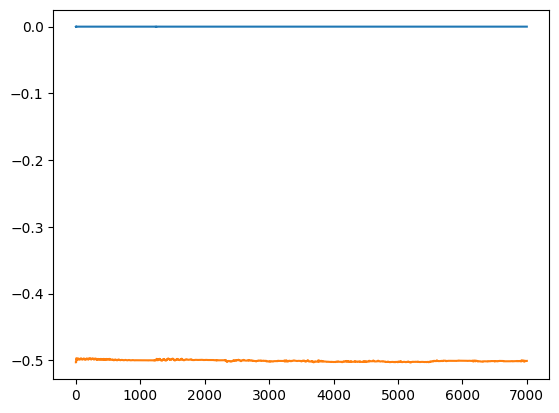

In [7]:
losses,gen = train_GAN()
losses_df = pd.DataFrame(data=losses,columns=['discriminator_loss','generator_loss'])
plt.plot(losses_df['discriminator_loss'])
plt.plot(losses_df['generator_loss'])


## Checking generated data
As the result of trained model we can now do the following:
- Initialize noise
- Generate some "fake" gaussianized S&P trajectories using generator 
- perform operation inverse to gaussianization to get "fake" S&P
- Look at returns distribution of this generated S&P

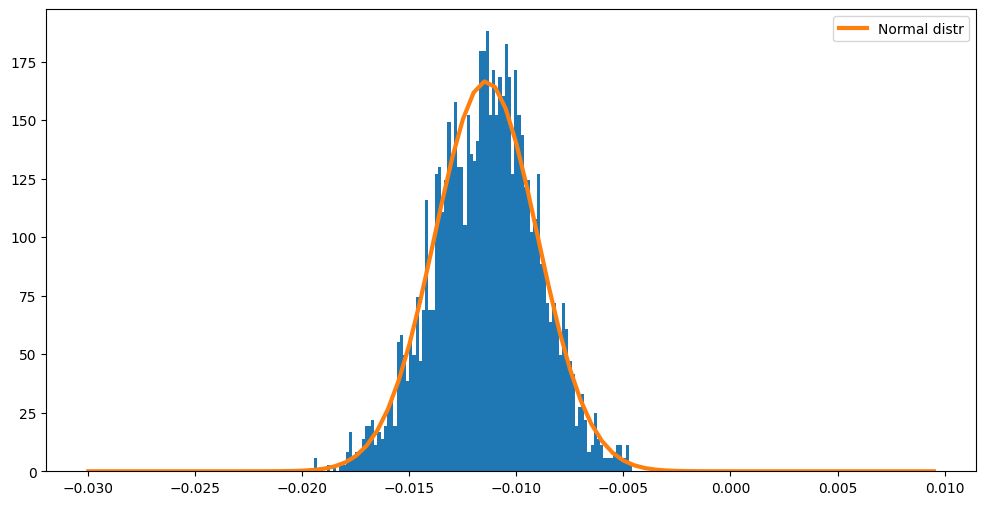

In [14]:
noise = torch.randn(1, len(log_returns_normalized), N_z, device=device)
generated_snp_gaus = gen(noise).detach().reshape(len(log_returns_normalized)).numpy()

plt.figure(figsize=(12,6))
plt.hist(generated_snp_gaus,bins=100,density=True)

mean_generated_snp = np.mean(generated_snp_gaus)
std_generated_snp = np.std(generated_snp_gaus)
x_axis = np.arange(-3, 1, 0.05)/100

plt.plot(x_axis, norm.pdf(x_axis, mean_generated_snp, std_generated_snp),label='Normal distr',linewidth=3)
plt.legend()



## Converting results back to initial format
We have **gaussianized inputs**. 

Now we have to convert our output back (perform an inverse operation) in order to be able to compare generated paths with the real S&P data.

In [9]:
generated_snp = gaus.inverse_transform(np.array([[g] for g in generated_snp_gaus]) ).reshape(-1)
generated_snp


array([-0.02461064, -0.01776059, -0.01788826, ..., -0.01444313,
       -0.02649516, -0.0071237 ], dtype=float32)

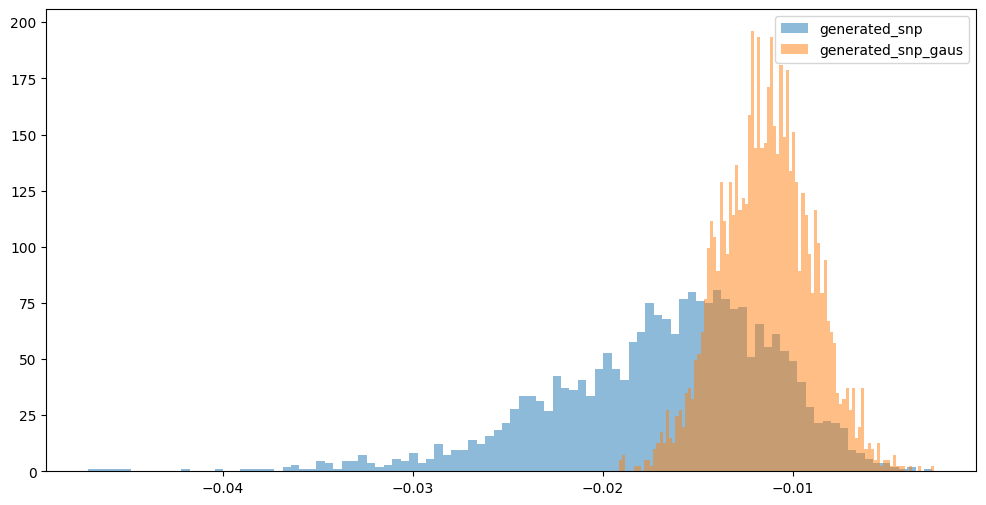

In [11]:
plt.figure(figsize=(12,6))
plt.hist(generated_snp,bins=100,density=True,label='generated_snp',alpha=0.5)
plt.hist(generated_snp_gaus,bins=100,density=True,label='generated_snp_gaus',alpha=0.5)
plt.legend()
plt.show()

As you can see from above generated returns seem to be counterintuitive.
Returns should actually be distribuited around 0. However, here returns are mostly negative.

I assume that there may be some troubles with optimization hyperparameters. Maybe they should be changed.


## Creating some S&P trajectories


In [12]:
def generate_snp_trajectory(n_generate = 50):
    sim_df = []
    for tr in range(1,n_generate+1):
        noise = torch.randn(1, len(log_returns_normalized), N_z, device=device)
        generated_snp_gaus = gen(noise).detach().reshape(len(log_returns_normalized)).numpy()
        generated_snp = gaus.inverse_transform(np.array([[g] for g in generated_snp_gaus]) ).reshape(-1)
        sim_df.append(generated_snp)
    return pd.DataFrame(data=np.array(sim_df).T,columns=[f'tr {t}' for t in range(1,n_generate+1)] ).cumsum()
    

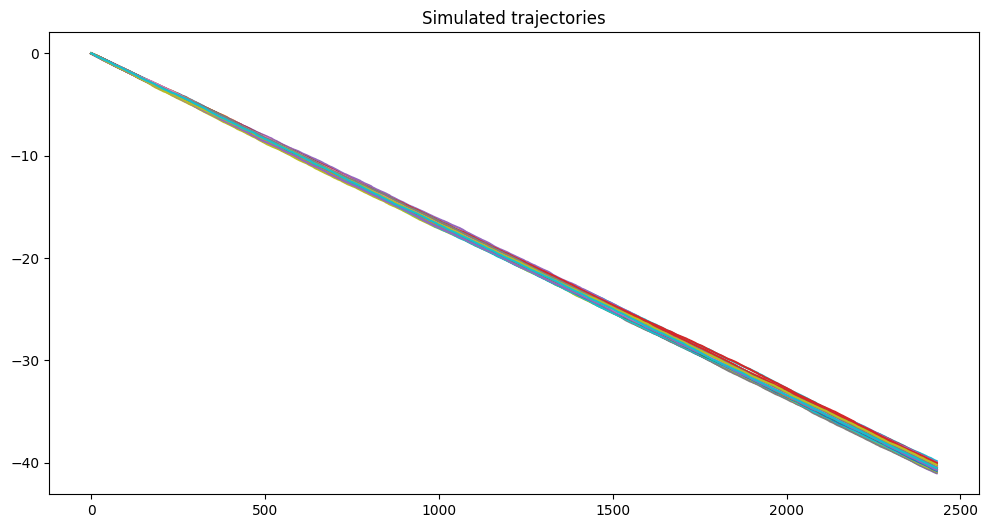

In [13]:
plt.figure(figsize=(12,6))
plt.plot(generate_snp_trajectory())
plt.title('Simulated trajectories')
plt.show()

As I have stated above there is definitelly some trouble with learning GAN. Simulated returns above are totally unrealistic.

## Training model with different parameters
Maybe we were not able to properly learn, thus I will change parameters related to it:
- Increase learining rate up to 0.001
- Increase number of epochs up to 100


  0%|                                                   | 0/100 [00:00<?, ?it/s]

Generator loss = -0.5010239481925964, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.501811146736145, Discriminator loss = -0.0005949437618255615
Generator loss = -0.5025478005409241, Discriminator loss = 2.9385089874267578e-05
Generator loss = -0.49948012828826904, Discriminator loss = -0.00038892030715942383
Generator loss = -0.5006536245346069, Discriminator loss = 3.0159950256347656e-05
Generator loss = -0.5012307167053223, Discriminator loss = -3.516674041748047e-06
Generator loss = -0.5013089179992676, Discriminator loss = -3.731250762939453e-05
Generator loss = -0.5010810494422913, Discriminator loss = -3.641843795776367e-05
Generator loss = -0.5011352300643921, Discriminator loss = 1.0967254638671875e-05
Generator loss = -0.5010824799537659, Discriminator loss = 1.627206802368164e-05
Generator loss = -0.5006372332572937, Discriminator loss = -1.0609626770019531e-05
Generator loss = -0.5002498030662537, Discriminator loss = -3.0934810638427734e-05
Generator loss 

  1%|▍                                       | 1/100 [02:10<3:35:06, 130.37s/it]

Generator loss = -0.5009670853614807, Discriminator loss = 5.7220458984375e-06
Generator loss = -0.5008872151374817, Discriminator loss = 9.417533874511719e-06
Generator loss = -0.5006756782531738, Discriminator loss = 4.947185516357422e-06
Generator loss = -0.5004695653915405, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.5002880096435547, Discriminator loss = -8.463859558105469e-06
Generator loss = -0.5000304579734802, Discriminator loss = -1.5437602996826172e-05
Generator loss = -0.4999402165412903, Discriminator loss = -6.496906280517578e-06
Generator loss = -0.5001086592674255, Discriminator loss = 7.3909759521484375e-06
Generator loss = -0.5003399848937988, Discriminator loss = 6.973743438720703e-06
Generator loss = -0.5005860924720764, Discriminator loss = 2.384185791015625e-06
Generator loss = -0.5007663369178772, Discriminator loss = -1.4901161193847656e-06
Generator loss = -0.5009350180625916, Discriminator loss = -5.185604095458984e-06
Generator loss = -0.5

  2%|▊                                       | 2/100 [04:29<3:41:07, 135.38s/it]

Generator loss = -0.49988853931427, Discriminator loss = -1.1801719665527344e-05
Generator loss = -0.4998357892036438, Discriminator loss = -2.86102294921875e-06
Generator loss = -0.5000526309013367, Discriminator loss = 6.556510925292969e-06
Generator loss = -0.5002939105033875, Discriminator loss = 4.231929779052734e-06
Generator loss = -0.5005508661270142, Discriminator loss = 8.344650268554688e-07
Generator loss = -0.5007230639457703, Discriminator loss = -1.6689300537109375e-06
Generator loss = -0.5008594989776611, Discriminator loss = -4.172325134277344e-06
Generator loss = -0.5009652972221375, Discriminator loss = -7.212162017822266e-06
Generator loss = -0.5010266900062561, Discriminator loss = -6.4373016357421875e-06
Generator loss = -0.5010032057762146, Discriminator loss = 1.6093254089355469e-06
Generator loss = -0.5009056329727173, Discriminator loss = 5.245208740234375e-06
Generator loss = -0.5007165670394897, Discriminator loss = 3.2186508178710938e-06
Generator loss = -0.

  3%|█▏                                      | 3/100 [06:23<3:22:55, 125.52s/it]

Generator loss = -0.5007355213165283, Discriminator loss = -1.6093254089355469e-06
Generator loss = -0.5009059309959412, Discriminator loss = -3.814697265625e-06
Generator loss = -0.5010401010513306, Discriminator loss = -6.139278411865234e-06
Generator loss = -0.5002032518386841, Discriminator loss = -3.2782554626464844e-06
Generator loss = -0.500084638595581, Discriminator loss = 3.516674041748047e-06
Generator loss = -0.4998854994773865, Discriminator loss = 3.2782554626464844e-06
Generator loss = -0.49970805644989014, Discriminator loss = 1.4007091522216797e-06
Generator loss = -0.4995405972003937, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49934011697769165, Discriminator loss = -2.086162567138672e-06
Generator loss = -0.49967193603515625, Discriminator loss = -6.109476089477539e-06
Generator loss = -0.4995642900466919, Discriminator loss = -6.020069122314453e-06
Generator loss = -0.49972736835479736, Discriminator loss = 3.7550926208496094e-06
Generator loss

  4%|█▌                                      | 4/100 [08:13<3:11:09, 119.48s/it]

Generator loss = -0.5005912184715271, Discriminator loss = 1.0728836059570312e-06
Generator loss = -0.5004481077194214, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5003057718276978, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.5001280307769775, Discriminator loss = -3.0994415283203125e-06
Generator loss = -0.4999134838581085, Discriminator loss = -5.066394805908203e-06
Generator loss = -0.5000030994415283, Discriminator loss = 1.5497207641601562e-06
Generator loss = -0.5002097487449646, Discriminator loss = 1.9073486328125e-06
Generator loss = -0.5003682971000671, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5004956722259521, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5000911355018616, Discriminator loss = -1.2516975402832031e-06
Generator loss = -0.5002790093421936, Discriminator loss = -3.039836883544922e-06
Generator loss = -0.50042724609375, Discriminator loss = -2.6226043701171875e-06
Generator loss = -0

  5%|██                                      | 5/100 [09:59<3:01:28, 114.61s/it]

Generator loss = -0.500052809715271, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5001549124717712, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5001599788665771, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.500282347202301, Discriminator loss = -2.086162567138672e-06
Generator loss = -0.5003928542137146, Discriminator loss = -1.6093254089355469e-06
Generator loss = -0.5003121495246887, Discriminator loss = 1.0728836059570312e-06
Generator loss = -0.500188410282135, Discriminator loss = 6.556510925292969e-07
Generator loss = -0.5001837611198425, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5000982880592346, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5000115036964417, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.49988242983818054, Discriminator loss = -2.0265579223632812e-06
Generator loss = -0.4999086856842041, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5

  6%|██▍                                     | 6/100 [11:43<2:54:00, 111.07s/it]

Generator loss = -0.5004084706306458, Discriminator loss = 0.0
Generator loss = -0.5003547072410583, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.500269889831543, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.5002315640449524, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.5002894997596741, Discriminator loss = 5.960464477539062e-07
Generator loss = -0.5003558993339539, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5004214644432068, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5004959106445312, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5000643730163574, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.5000631809234619, Discriminator loss = 0.0
Generator loss = -0.4999701976776123, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.4998919367790222, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.4998322129249573, Discriminator loss =

  7%|██▊                                     | 7/100 [13:27<2:48:38, 108.80s/it]

Generator loss = -0.49974119663238525, Discriminator loss = -3.2782554626464844e-07
Generator loss = -0.49972647428512573, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.49961787462234497, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4998724162578583, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4998186230659485, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.4997827410697937, Discriminator loss = -6.258487701416016e-07
Generator loss = -0.49967658519744873, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.4997391104698181, Discriminator loss = 0.0
Generator loss = -0.4998216927051544, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4999658763408661, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.500080406665802, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.49988892674446106, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.4995920360

  8%|███▏                                    | 8/100 [15:22<2:49:41, 110.67s/it]

Generator loss = -0.5014001727104187, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5012766718864441, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5012096166610718, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5011582374572754, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5011605620384216, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.501230776309967, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5013021230697632, Discriminator loss = 0.0
Generator loss = -0.5014432668685913, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5016282796859741, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.5013340711593628, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5012345910072327, Discriminator loss = 0.0
Generator loss = -0.5011767745018005, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.501149594783783, Discriminator loss 

  9%|███▌                                    | 9/100 [17:16<2:49:20, 111.65s/it]

Generator loss = -0.5004344582557678, Discriminator loss = 3.635883331298828e-06
Generator loss = -0.5010433197021484, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5009971857070923, Discriminator loss = -2.086162567138672e-06
Generator loss = -0.5008410811424255, Discriminator loss = -5.781650543212891e-06
Generator loss = -0.5007759928703308, Discriminator loss = 8.940696716308594e-07
Generator loss = -0.5008918642997742, Discriminator loss = 1.1324882507324219e-06
Generator loss = -0.50096195936203, Discriminator loss = 0.0
Generator loss = -0.5010467767715454, Discriminator loss = -1.0728836059570312e-06
Generator loss = -0.5008187890052795, Discriminator loss = -3.635883331298828e-06
Generator loss = -0.5005876421928406, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.5008138418197632, Discriminator loss = 1.1920928955078125e-06
Generator loss = -0.501082718372345, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5010462403297424, Dis

 10%|███▉                                   | 10/100 [19:59<3:11:37, 127.75s/it]

Generator loss = -0.5012214779853821, Discriminator loss = -2.0265579223632812e-06
Generator loss = -0.5008419156074524, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5008969902992249, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.5008428692817688, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5008155107498169, Discriminator loss = 0.0
Generator loss = -0.5007965564727783, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.500760555267334, Discriminator loss = -6.556510925292969e-07
Generator loss = -0.5006903409957886, Discriminator loss = -1.9669532775878906e-06
Generator loss = -0.5007150173187256, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5007877945899963, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5008090734481812, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5008237361907959, Discriminator loss = 0.0
Generator loss = -0.5008602142333984, Discriminator loss 

 11%|████▎                                  | 11/100 [22:03<3:07:25, 126.36s/it]

Generator loss = -0.5013010501861572, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5012502670288086, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5012378096580505, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5012637376785278, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5012866258621216, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5013014078140259, Discriminator loss = 0.0
Generator loss = -0.5013185143470764, Discriminator loss = 0.0
Generator loss = -0.5013490915298462, Discriminator loss = 0.0
Generator loss = -0.5014000535011292, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5014541149139404, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5014859437942505, Discriminator loss = 0.0
Generator loss = -0.5014615058898926, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5014044642448425, Discriminator loss = 0.0
Generator loss = -0.5013543

 12%|████▋                                  | 12/100 [24:05<3:03:38, 125.21s/it]

Generator loss = -0.5012980103492737, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5013019442558289, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5013038516044617, Discriminator loss = 0.0
Generator loss = -0.5013103485107422, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.501327633857727, Discriminator loss = 0.0
Generator loss = -0.5013638734817505, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5014263391494751, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5014954209327698, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5014848113059998, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5014045238494873, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5013434290885925, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5013116002082825, Discriminator loss = 0.0
Generator loss = -0.501297116279602, Discriminator loss = 0.0
Generator loss

 13%|█████                                  | 13/100 [25:40<2:48:09, 115.97s/it]

Generator loss = -0.5013774037361145, Discriminator loss = 0.0
Generator loss = -0.5012408494949341, Discriminator loss = 0.0
Generator loss = -0.5013108253479004, Discriminator loss = 0.0
Generator loss = -0.5011555552482605, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.501067578792572, Discriminator loss = 0.0
Generator loss = -0.5010381937026978, Discriminator loss = 0.0
Generator loss = -0.5010257363319397, Discriminator loss = 0.0
Generator loss = -0.5009995698928833, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5009965896606445, Discriminator loss = 0.0
Generator loss = -0.5010315775871277, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5010462403297424, Discriminator loss = 0.0
Generator loss = -0.5010868310928345, Discriminator loss = 0.0
Generator loss = -0.5012007355690002, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5013605356216431, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.501093

 14%|█████▍                                 | 14/100 [27:40<2:48:14, 117.38s/it]

Generator loss = -0.501333475112915, Discriminator loss = 0.0
Generator loss = -0.5014081597328186, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5015909671783447, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5014088749885559, Discriminator loss = 0.0
Generator loss = -0.5013259053230286, Discriminator loss = 0.0
Generator loss = -0.501304566860199, Discriminator loss = 0.0
Generator loss = -0.5012955665588379, Discriminator loss = 0.0
Generator loss = -0.5012822151184082, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5013033151626587, Discriminator loss = 0.0
Generator loss = -0.501319944858551, Discriminator loss = 0.0
Generator loss = -0.5013673305511475, Discriminator loss = 0.0
Generator loss = -0.5015109181404114, Discriminator loss = 0.0
Generator loss = -0.50152987241745, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5013340711593628, Discriminator loss = 0.0
Generator loss = -0.5012978911399841, Discrim

 15%|█████▊                                 | 15/100 [29:41<2:47:34, 118.29s/it]

Generator loss = -0.5019109845161438, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.501707911491394, Discriminator loss = -2.9206275939941406e-06
Generator loss = -0.502265214920044, Discriminator loss = -1.430511474609375e-06
Generator loss = -0.5000369548797607, Discriminator loss = -3.349781036376953e-05
Generator loss = -0.5011171102523804, Discriminator loss = 1.0132789611816406e-06
Generator loss = -0.5013042688369751, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.5011574625968933, Discriminator loss = -7.033348083496094e-06
Generator loss = -0.5011703968048096, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5012282133102417, Discriminator loss = 5.960464477539062e-07
Generator loss = -0.5012539029121399, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5012616515159607, Discriminator loss = -2.7418136596679688e-06
Generator loss = -0.500683069229126, Discriminator loss = -5.245208740234375e-06
Generator loss =

 16%|██████▏                                | 16/100 [31:42<2:46:43, 119.09s/it]

Generator loss = -0.5024546384811401, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5024236440658569, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.5017740726470947, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.5017611384391785, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5019213557243347, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5019615888595581, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.501983642578125, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5019904375076294, Discriminator loss = 0.0
Generator loss = -0.5019853115081787, Discriminator loss = 0.0
Generator loss = -0.5019672513008118, Discriminator loss = 0.0
Generator loss = -0.5019329786300659, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5018812417984009, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5015528798103333, Discriminator loss = -3.576278686523437

 17%|██████▋                                | 17/100 [33:28<2:39:22, 115.21s/it]

Generator loss = -0.501610279083252, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5013216733932495, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.501014232635498, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.501153826713562, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5012192726135254, Discriminator loss = 0.0
Generator loss = -0.5012370347976685, Discriminator loss = 0.0
Generator loss = -0.5012268424034119, Discriminator loss = 0.0
Generator loss = -0.5011875033378601, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5013242363929749, Discriminator loss = 0.0
Generator loss = -0.5012663006782532, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5012041330337524, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5012267231941223, Discriminator loss = 0.0
Generator loss = -0.500787615776062, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.50084537267684

 18%|███████                                | 18/100 [35:35<2:42:12, 118.69s/it]

Generator loss = -0.5007756352424622, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5008559823036194, Discriminator loss = 0.0
Generator loss = -0.500877857208252, Discriminator loss = 0.0
Generator loss = -0.5008701086044312, Discriminator loss = 0.0
Generator loss = -0.5008347034454346, Discriminator loss = 0.0
Generator loss = -0.5007468461990356, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.500579297542572, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5005951523780823, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5007819533348083, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5008590221405029, Discriminator loss = 0.0
Generator loss = -0.5008831024169922, Discriminator loss = 0.0
Generator loss = -0.5008780360221863, Discriminator loss = 0.0
Generator loss = -0.5008326172828674, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5007245540618896, Discriminator loss = -1.788139343

 19%|███████▍                               | 19/100 [44:50<5:37:19, 249.87s/it]

Generator loss = -0.500288724899292, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5005394816398621, Discriminator loss = 0.0
Generator loss = -0.5006328821182251, Discriminator loss = 0.0
Generator loss = -0.5006555318832397, Discriminator loss = 0.0
Generator loss = -0.5006470680236816, Discriminator loss = 0.0
Generator loss = -0.5005949139595032, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5006014704704285, Discriminator loss = 0.0
Generator loss = -0.5006516575813293, Discriminator loss = 0.0
Generator loss = -0.5006458759307861, Discriminator loss = 0.0
Generator loss = -0.5005993843078613, Discriminator loss = 0.0
Generator loss = -0.5004639625549316, Discriminator loss = 0.0
Generator loss = -0.5002681612968445, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5005877614021301, Discriminator loss = 0.0
Generator loss = -0.500656247138977, Discriminator loss = 0.0
Generator loss = -0.5006694793701172, Discriminator loss = 0.

 20%|███████▊                               | 20/100 [49:20<5:41:12, 255.90s/it]

Generator loss = -0.5002009272575378, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5006627440452576, Discriminator loss = 0.0
Generator loss = -0.5006809234619141, Discriminator loss = 0.0
Generator loss = -0.5006232261657715, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.500625491142273, Discriminator loss = 0.0
Generator loss = -0.5001665353775024, Discriminator loss = -1.1086463928222656e-05
Generator loss = -0.5004743337631226, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.4992540180683136, Discriminator loss = -1.2874603271484375e-05
Generator loss = -0.49924135208129883, Discriminator loss = 1.043081283569336e-06
Generator loss = -0.4991803765296936, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.4997064471244812, Discriminator loss = -4.172325134277344e-06
Generator loss = -0.4997616112232208, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.4995718002319336, Discriminator loss = 0.0
Generato

 21%|████████▏                              | 21/100 [52:03<5:00:03, 227.89s/it]

Generator loss = -0.49849435687065125, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.4987189471721649, Discriminator loss = 8.940696716308594e-08
Generator loss = -0.49873077869415283, Discriminator loss = 0.0
Generator loss = -0.4986702501773834, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.4985705018043518, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.4986932873725891, Discriminator loss = 2.086162567138672e-07
Generator loss = -0.4987418055534363, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.4987529218196869, Discriminator loss = 0.0
Generator loss = -0.49874016642570496, Discriminator loss = 0.0
Generator loss = -0.4988332986831665, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.49869176745414734, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.49858054518699646, Discriminator loss = -3.2782554626464844e-07
Generator loss = -0.4985622763633728, Discriminator loss = 2.0861625

 22%|███████▉                            | 22/100 [1:09:07<10:06:59, 466.91s/it]

Generator loss = -0.49751341342926025, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.49749755859375, Discriminator loss = 0.0
Generator loss = -0.49749037623405457, Discriminator loss = 0.0
Generator loss = -0.49747875332832336, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49744662642478943, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.4973759055137634, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.49729880690574646, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.4973997473716736, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4974708557128906, Discriminator loss = 0.0
Generator loss = -0.4974927306175232, Discriminator loss = 0.0
Generator loss = -0.49749991297721863, Discriminator loss = 0.0
Generator loss = -0.49751096963882446, Discriminator loss = 0.0
Generator loss = -0.4975415766239166, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.4975813925266266, 

 23%|████████▌                            | 23/100 [1:11:16<7:49:01, 365.47s/it]

Generator loss = -0.49721893668174744, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.49814704060554504, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49819430708885193, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.4982002377510071, Discriminator loss = 0.0
Generator loss = -0.4981955885887146, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49817994236946106, Discriminator loss = -2.086162567138672e-07
Generator loss = -0.4980108439922333, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49799734354019165, Discriminator loss = 0.0
Generator loss = -0.4979252815246582, Discriminator loss = 0.0
Generator loss = -0.49761319160461426, Discriminator loss = -2.086162567138672e-07
Generator loss = -0.49799641966819763, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4981662929058075, Discriminator loss = 0.0
Generator loss = -0.49840086698532104, Discriminator loss = 0.0
Generator loss = -0.

 24%|████████▉                            | 24/100 [1:13:01<6:03:56, 287.33s/it]

Generator loss = -0.4981599450111389, Discriminator loss = 0.0
Generator loss = -0.4979868531227112, Discriminator loss = 0.0
Generator loss = -0.4977709650993347, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49745821952819824, Discriminator loss = -2.086162567138672e-07
Generator loss = -0.4974900782108307, Discriminator loss = 0.0
Generator loss = -0.4973992705345154, Discriminator loss = 0.0
Generator loss = -0.4966732859611511, Discriminator loss = -6.556510925292969e-07
Generator loss = -0.49750590324401855, Discriminator loss = 0.0
Generator loss = -0.49843114614486694, Discriminator loss = -3.606081008911133e-06
Generator loss = -0.4985935688018799, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.4999482333660126, Discriminator loss = -7.3909759521484375e-06
Generator loss = -0.50040203332901, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.500312328338623, Discriminator loss = -1.6689300537109375e-06
Generator loss = -0.50040

 25%|█████████▎                           | 25/100 [1:14:40<4:48:39, 230.92s/it]

Generator loss = -0.5004258155822754, Discriminator loss = 0.0
Generator loss = -0.5004411339759827, Discriminator loss = 0.0
Generator loss = -0.5004738569259644, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002602934837341, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5002257227897644, Discriminator loss = 0.0
Generator loss = -0.5001884698867798, Discriminator loss = 0.0
Generator loss = -0.5001689195632935, Discriminator loss = 0.0
Generator loss = -0.5001544952392578, Discriminator loss = 0.0
Generator loss = -0.5001308917999268, Discriminator loss = 0.0
Generator loss = -0.5000714659690857, Discriminator loss = 0.0
Generator loss = -0.49992886185646057, Discriminator loss = -8.940696716308594e-08
Generator loss = -0.4997613728046417, Discriminator loss = 0.0
Generator loss = -0.4999481439590454, Discriminator loss = 0.0
Generator loss = -0.5000007152557373, Discriminator loss = 0.0
Generator loss = -0.5000091195106506, Discriminator loss = 

 26%|█████████▌                           | 26/100 [1:16:26<3:58:26, 193.33s/it]

Generator loss = -0.49998733401298523, Discriminator loss = 0.0
Generator loss = -0.49993154406547546, Discriminator loss = 0.0
Generator loss = -0.4997599422931671, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.4996221959590912, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.5001285672187805, Discriminator loss = 0.0
Generator loss = -0.5001773238182068, Discriminator loss = 0.0
Generator loss = -0.5001732707023621, Discriminator loss = 0.0
Generator loss = -0.5003068447113037, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002748370170593, Discriminator loss = 0.0
Generator loss = -0.5003576874732971, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5003390908241272, Discriminator loss = 0.0
Generator loss = -0.5002277493476868, Discriminator loss = 0.0
Generator loss = -0.4999540448188782, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5005322098731995, Discriminator loss = 0.0
Generator loss = -0.

 27%|█████████▉                           | 27/100 [1:18:14<3:23:59, 167.67s/it]

Generator loss = -0.500345766544342, Discriminator loss = 0.0
Generator loss = -0.5005255341529846, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.500536322593689, Discriminator loss = 0.0
Generator loss = -0.5006774067878723, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5005150437355042, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5007545948028564, Discriminator loss = 0.0
Generator loss = -0.5004923939704895, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.4997064173221588, Discriminator loss = -1.7583370208740234e-06
Generator loss = -0.5008628964424133, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.5002034306526184, Discriminator loss = -9.59634780883789e-06
Generator loss = -0.5003806352615356, Discriminator loss = 0.0
Generator loss = -0.5009250640869141, Discriminator loss = -4.887580871582031e-06
Generator loss = -0.5005931258201599, Discriminator loss = -4.887580871582031e-06
Generator lo

 28%|██████████▎                          | 28/100 [1:20:01<2:59:26, 149.53s/it]

Generator loss = -0.5023084878921509, Discriminator loss = -1.7583370208740234e-05
Generator loss = -0.5024557709693909, Discriminator loss = 1.2516975402832031e-06
Generator loss = -0.50263911485672, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5018898844718933, Discriminator loss = -1.2159347534179688e-05
Generator loss = -0.5017523169517517, Discriminator loss = 2.086162567138672e-06
Generator loss = -0.5015816688537598, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5015095472335815, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5014715194702148, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.5013025403022766, Discriminator loss = -2.682209014892578e-06
Generator loss = -0.5011538863182068, Discriminator loss = -1.1920928955078125e-06
Generator loss = -0.5012688040733337, Discriminator loss = 1.430511474609375e-06
Generator loss = -0.5013613104820251, Discriminator loss = 6.556510925292969e-07
Generator loss = -0.

 29%|██████████▋                          | 29/100 [1:21:42<2:39:47, 135.04s/it]

Generator loss = -0.5022902488708496, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5022678971290588, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5022426843643188, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.5022013783454895, Discriminator loss = -1.6689300537109375e-06
Generator loss = -0.5024010539054871, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.5024437308311462, Discriminator loss = 9.5367431640625e-07
Generator loss = -0.5024742484092712, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5024929046630859, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5025091171264648, Discriminator loss = 0.0
Generator loss = -0.5025310516357422, Discriminator loss = 0.0
Generator loss = -0.5025721192359924, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5026571750640869, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5028244256973267, Discriminator loss

 30%|███████████                          | 30/100 [1:23:29<2:27:45, 126.65s/it]

Generator loss = -0.5024447441101074, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5023864507675171, Discriminator loss = -1.2516975402832031e-06
Generator loss = -0.5021700859069824, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.50232994556427, Discriminator loss = 5.960464477539062e-07
Generator loss = -0.502367377281189, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.502388060092926, Discriminator loss = 0.0
Generator loss = -0.5024009943008423, Discriminator loss = 0.0
Generator loss = -0.5024137496948242, Discriminator loss = 0.0
Generator loss = -0.5024358630180359, Discriminator loss = 0.0
Generator loss = -0.5024860501289368, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5025668740272522, Discriminator loss = -8.940696716308594e-07
Generator loss = -0.5021719932556152, Discriminator loss = -1.0728836059570312e-06
Generator loss = -0.5020674467086792, Discriminator loss = 4.76837158203125e-07
Generator loss

 31%|███████████▍                         | 31/100 [1:25:38<2:26:25, 127.33s/it]

Generator loss = -0.5020679831504822, Discriminator loss = 0.0
Generator loss = -0.5020818710327148, Discriminator loss = 0.0
Generator loss = -0.502098560333252, Discriminator loss = 0.0
Generator loss = -0.5021309852600098, Discriminator loss = 0.0
Generator loss = -0.5019147396087646, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5020021200180054, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5019456744194031, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5018563270568848, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5018166303634644, Discriminator loss = 0.0
Generator loss = -0.5018025040626526, Discriminator loss = 0.0
Generator loss = -0.501800000667572, Discriminator loss = 0.0
Generator loss = -0.5018041133880615, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5018110871315002, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5019733905792236, Discriminator loss = -2.38418579

 32%|███████████▊                         | 32/100 [1:27:20<2:15:27, 119.52s/it]

Generator loss = -0.5021501183509827, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5020393133163452, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5018831491470337, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5018109083175659, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5017887949943542, Discriminator loss = 0.0
Generator loss = -0.5017870664596558, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5017990469932556, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5018267631530762, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5018510222434998, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5018156170845032, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.501792848110199, Discriminator loss = 0.0
Generator loss = -0.5017877221107483, Discriminator loss = 0.0
Generator loss = -0.5017996430397034, Discriminator loss = 0.0
Generato

 33%|████████████▏                        | 33/100 [1:28:57<2:06:10, 112.99s/it]

Generator loss = -0.5018498301506042, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5018478631973267, Discriminator loss = 0.0
Generator loss = -0.5020237565040588, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5020108222961426, Discriminator loss = 0.0
Generator loss = -0.5020251870155334, Discriminator loss = 0.0
Generator loss = -0.5020958185195923, Discriminator loss = 0.0
Generator loss = -0.5023003816604614, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5020614862442017, Discriminator loss = 0.0
Generator loss = -0.5020094513893127, Discriminator loss = 0.0
Generator loss = -0.5020044445991516, Discriminator loss = 0.0
Generator loss = -0.5020152926445007, Discriminator loss = 0.0
Generator loss = -0.5020424127578735, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5020448565483093, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5020158290863037, Discriminator loss = 0.0
Generator loss = -0.5020

 34%|████████████▌                        | 34/100 [1:30:41<2:01:09, 110.14s/it]

Generator loss = -0.502108097076416, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.5020214319229126, Discriminator loss = 0.0
Generator loss = -0.5020480155944824, Discriminator loss = 0.0
Generator loss = -0.5023622512817383, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5020506978034973, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5020055174827576, Discriminator loss = 0.0
Generator loss = -0.5020119547843933, Discriminator loss = 0.0
Generator loss = -0.5020557045936584, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.502184271812439, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.502298891544342, Discriminator loss = 0.0
Generator loss = -0.5022794008255005, Discriminator loss = 0.0
Generator loss = -0.5023234486579895, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5025970935821533, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5022674202919006, Discriminator 

 35%|████████████▉                        | 35/100 [1:32:21<1:56:14, 107.29s/it]

Generator loss = -0.5025572180747986, Discriminator loss = -2.4437904357910156e-06
Generator loss = -0.5025058388710022, Discriminator loss = 0.0
Generator loss = -0.5025694966316223, Discriminator loss = -2.8014183044433594e-06
Generator loss = -0.5028252005577087, Discriminator loss = -1.0728836059570312e-06
Generator loss = -0.5025235414505005, Discriminator loss = 0.0
Generator loss = -0.5026499629020691, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5024041533470154, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5022085905075073, Discriminator loss = 0.0
Generator loss = -0.5014321804046631, Discriminator loss = -2.6226043701171875e-06
Generator loss = -0.5020723342895508, Discriminator loss = 0.0
Generator loss = -0.5019474029541016, Discriminator loss = -1.6093254089355469e-06
Generator loss = -0.5018887519836426, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.5022263526916504, Discriminator loss = -1.430511474609375e-06
Generat

 36%|█████████████▎                       | 36/100 [1:34:14<1:56:06, 108.85s/it]

Generator loss = -0.4998370409011841, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.4999961853027344, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5000938773155212, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5001432299613953, Discriminator loss = 0.0
Generator loss = -0.5001644492149353, Discriminator loss = 0.0
Generator loss = -0.5001658797264099, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002821683883667, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5003003478050232, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.50031578540802, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5003154873847961, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5003047585487366, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5002917647361755, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5002737045288086, Discriminator loss =

 37%|█████████████▋                       | 37/100 [1:38:10<2:34:28, 147.12s/it]

Generator loss = -0.5002939701080322, Discriminator loss = 0.0
Generator loss = -0.5003023147583008, Discriminator loss = 0.0
Generator loss = -0.5003114342689514, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5003217458724976, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5003235340118408, Discriminator loss = 0.0
Generator loss = -0.5003095269203186, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5002970695495605, Discriminator loss = 0.0
Generator loss = -0.5002879500389099, Discriminator loss = 0.0
Generator loss = -0.5002737045288086, Discriminator loss = 0.0
Generator loss = -0.5002462863922119, Discriminator loss = 0.0
Generator loss = -0.5002066493034363, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5001975297927856, Discriminator loss = 0.0
Generator loss = -0.5002338886260986, Discriminator loss = 0.0
Generator loss = -0.5002638697624207, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5

 38%|██████████████                       | 38/100 [1:40:20<2:26:35, 141.86s/it]

Generator loss = -0.5003036856651306, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5002941489219666, Discriminator loss = 0.0
Generator loss = -0.5002871155738831, Discriminator loss = 0.0
Generator loss = -0.5002763271331787, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002607107162476, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002554655075073, Discriminator loss = 0.0
Generator loss = -0.5002689361572266, Discriminator loss = 0.0
Generator loss = -0.50028395652771, Discriminator loss = 0.0
Generator loss = -0.5002936720848083, Discriminator loss = 0.0
Generator loss = -0.500304639339447, Discriminator loss = 0.0
Generator loss = -0.500325620174408, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5003678798675537, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5005754828453064, Discriminator loss = 0.0
Generator loss = -0.5005296468734741, Discriminator loss = 0.0
Generator loss = -0.50051

 39%|██████████████▍                      | 39/100 [1:42:07<2:13:35, 131.40s/it]

Generator loss = -0.5005115866661072, Discriminator loss = 0.0
Generator loss = -0.5005149841308594, Discriminator loss = 0.0
Generator loss = -0.5005188584327698, Discriminator loss = 0.0
Generator loss = -0.5005298256874084, Discriminator loss = 0.0
Generator loss = -0.5005688071250916, Discriminator loss = 0.0
Generator loss = -0.5006058812141418, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5005187392234802, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5005133152008057, Discriminator loss = 0.0
Generator loss = -0.5005069375038147, Discriminator loss = 0.0
Generator loss = -0.50049889087677, Discriminator loss = 0.0
Generator loss = -0.4992012083530426, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.49921512603759766, Discriminator loss = 0.0
Generator loss = -0.49922698736190796, Discriminator loss = 0.0
Generator loss = -0.4998769760131836, Discriminator loss = -9.834766387939453e-07
Generator loss = -0.4997541904449463, Disc

 40%|██████████████▊                      | 40/100 [1:43:55<2:04:20, 124.34s/it]

Generator loss = -0.49995362758636475, Discriminator loss = 0.0
Generator loss = -0.499966561794281, Discriminator loss = -8.940696716308594e-08
Generator loss = -0.5000193119049072, Discriminator loss = -2.086162567138672e-07
Generator loss = -0.4999364912509918, Discriminator loss = 0.0
Generator loss = -0.5004420280456543, Discriminator loss = 0.0
Generator loss = -0.5004279613494873, Discriminator loss = 0.0
Generator loss = -0.5005024075508118, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.49930888414382935, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49934184551239014, Discriminator loss = 0.0
Generator loss = -0.4994247853755951, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.49963924288749695, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.4995163083076477, Discriminator loss = 0.0
Generator loss = -0.5010213255882263, Discriminator loss = 0.0
Generator loss = -0.5009797811508179, Discriminator loss = -5.

 41%|███████████████▏                     | 41/100 [1:45:55<2:00:56, 122.99s/it]

Generator loss = -0.5012493133544922, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5011683106422424, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5010662078857422, Discriminator loss = 0.0
Generator loss = -0.5010209083557129, Discriminator loss = 0.0
Generator loss = -0.500984251499176, Discriminator loss = 0.0
Generator loss = -0.5009171366691589, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5008662939071655, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5009520649909973, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.501002311706543, Discriminator loss = 0.0
Generator loss = -0.501035213470459, Discriminator loss = 0.0
Generator loss = -0.5010761022567749, Discriminator loss = 0.0
Generator loss = -0.501164436340332, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5012550950050354, Discriminator loss = 0.0
Generator loss = -0.5011072754859924, Discriminator loss = 5.96046447753

 42%|███████████████▌                     | 42/100 [1:48:02<2:00:16, 124.42s/it]

Generator loss = -0.5010222792625427, Discriminator loss = 0.0
Generator loss = -0.5010491013526917, Discriminator loss = 0.0
Generator loss = -0.5011200904846191, Discriminator loss = 0.0
Generator loss = -0.5012882351875305, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5010275840759277, Discriminator loss = 0.0
Generator loss = -0.5010296702384949, Discriminator loss = 0.0
Generator loss = -0.5010986328125, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5010890364646912, Discriminator loss = 0.0
Generator loss = -0.5015890002250671, Discriminator loss = -4.470348358154297e-06
Generator loss = -0.5017021894454956, Discriminator loss = 0.0
Generator loss = -0.5015720129013062, Discriminator loss = -3.516674041748047e-06
Generator loss = -0.5014887452125549, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5014225244522095, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5014384388923645, Discriminator loss = 0.0
Generat

 43%|███████████████▉                     | 43/100 [1:50:00<1:56:21, 122.48s/it]

Generator loss = -0.5016955733299255, Discriminator loss = 0.0
Generator loss = -0.5016568899154663, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5016688704490662, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5014973282814026, Discriminator loss = 0.0
Generator loss = -0.501503050327301, Discriminator loss = 0.0
Generator loss = -0.501502513885498, Discriminator loss = 0.0
Generator loss = -0.5014989972114563, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5014936923980713, Discriminator loss = 0.0
Generator loss = -0.5014936327934265, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5014918446540833, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5014972686767578, Discriminator loss = 0.0
Generator loss = -0.5015035271644592, Discriminator loss = 0.0
Generator loss = -0.5015047788619995, Discriminator loss = 0.0
Generator loss = -0.5014934539794922, Discriminator loss = 0.0
Generator loss = -0.50140

 44%|████████████████▎                    | 44/100 [1:52:06<1:55:13, 123.46s/it]

Generator loss = -0.5014997124671936, Discriminator loss = 0.0
Generator loss = -0.5015034675598145, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5015013813972473, Discriminator loss = 0.0
Generator loss = -0.5015000104904175, Discriminator loss = 0.0
Generator loss = -0.501505434513092, Discriminator loss = 0.0
Generator loss = -0.5015110373497009, Discriminator loss = 0.0
Generator loss = -0.50152587890625, Discriminator loss = 0.0
Generator loss = -0.501571774482727, Discriminator loss = 0.0
Generator loss = -0.5016080141067505, Discriminator loss = 0.0
Generator loss = -0.5015143752098083, Discriminator loss = 0.0
Generator loss = -0.5015051960945129, Discriminator loss = 0.0
Generator loss = -0.5014997124671936, Discriminator loss = 0.0
Generator loss = -0.5014814734458923, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5014755725860596, Discriminator loss = 0.0
Generator loss = -0.5015129446983337, Discriminator loss = 0.0
Generator loss = -0.

 45%|████████████████▋                    | 45/100 [1:54:20<1:56:07, 126.69s/it]

Generator loss = -0.5012781023979187, Discriminator loss = -3.6954879760742188e-06
Generator loss = -0.5015430450439453, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.5015935897827148, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5017416477203369, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.5014569163322449, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5013617277145386, Discriminator loss = 0.0
Generator loss = -0.5013428330421448, Discriminator loss = 0.0
Generator loss = -0.5013415217399597, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5013355612754822, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5013378858566284, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5013425946235657, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5013427734375, Discriminator loss = 0.0
Generator loss = -0.5013415813446045, Discriminator loss = 0.0
Generator lo

 46%|█████████████████                    | 46/100 [1:56:29<1:54:30, 127.22s/it]

Generator loss = -0.5011478662490845, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5011171698570251, Discriminator loss = 0.0
Generator loss = -0.5011110901832581, Discriminator loss = 0.0
Generator loss = -0.5011193156242371, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5011450052261353, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5009527206420898, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5009071230888367, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5008806586265564, Discriminator loss = 0.0
Generator loss = -0.5008679032325745, Discriminator loss = 0.0
Generator loss = -0.5008591413497925, Discriminator loss = 0.0
Generator loss = -0.5008449554443359, Discriminator loss = 0.0
Generator loss = -0.5008429884910583, Discriminator loss = 0.0
Generator loss = -0.5017020106315613, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5017454624176025, Discriminator loss = -5.9604

 47%|█████████████████▍                   | 47/100 [1:58:57<1:58:01, 133.62s/it]

Generator loss = -0.5015131235122681, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5014994144439697, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5014941692352295, Discriminator loss = 0.0
Generator loss = -0.5014958381652832, Discriminator loss = 0.0
Generator loss = -0.501503586769104, Discriminator loss = 0.0
Generator loss = -0.5015215277671814, Discriminator loss = 0.0
Generator loss = -0.5015550255775452, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5015900731086731, Discriminator loss = 0.0
Generator loss = -0.5015648007392883, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5015233755111694, Discriminator loss = 0.0
Generator loss = -0.5015047788619995, Discriminator loss = 0.0
Generator loss = -0.5015042424201965, Discriminator loss = 0.0
Generator loss = -0.50152587890625, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5015807151794434, Discriminator loss = -1.1920928955078125e-07
Generato

 48%|█████████████████▊                   | 48/100 [2:01:19<1:57:48, 135.92s/it]

Generator loss = -0.5016291737556458, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5013366937637329, Discriminator loss = 0.0
Generator loss = -0.5012763738632202, Discriminator loss = 0.0
Generator loss = -0.5012476444244385, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.50124591588974, Discriminator loss = 0.0
Generator loss = -0.5012728571891785, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5013408660888672, Discriminator loss = 0.0
Generator loss = -0.5013141632080078, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5012578964233398, Discriminator loss = 0.0
Generator loss = -0.5012449622154236, Discriminator loss = 0.0
Generator loss = -0.5012587308883667, Discriminator loss = 0.0
Generator loss = -0.5013072490692139, Discriminator loss = 0.0
Generator loss = -0.5013843774795532, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5013380646705627, Discriminator loss = -5.960464477539063e-08
Generat

 49%|██████████████████▏                  | 49/100 [2:03:40<1:56:50, 137.46s/it]

Generator loss = -0.5012478232383728, Discriminator loss = 0.0
Generator loss = -0.5012673139572144, Discriminator loss = 0.0
Generator loss = -0.5013230443000793, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5013818144798279, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5012975335121155, Discriminator loss = 0.0
Generator loss = -0.5009583830833435, Discriminator loss = 0.0
Generator loss = -0.5009625554084778, Discriminator loss = 0.0
Generator loss = -0.5010189414024353, Discriminator loss = 0.0
Generator loss = -0.5010729432106018, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5009632706642151, Discriminator loss = 0.0
Generator loss = -0.5009573698043823, Discriminator loss = 0.0
Generator loss = -0.501004159450531, Discriminator loss = 0.0
Generator loss = -0.5011175870895386, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5012850165367126, Discriminator loss = 0.0
Generator loss = -0.5012516975402832, Discr

 50%|██████████████████▌                  | 50/100 [2:06:02<1:55:41, 138.83s/it]

Generator loss = -0.5013030767440796, Discriminator loss = 0.0
Generator loss = -0.501368522644043, Discriminator loss = 0.0
Generator loss = -0.5012837052345276, Discriminator loss = 0.0
Generator loss = -0.5012533664703369, Discriminator loss = 0.0
Generator loss = -0.5012754797935486, Discriminator loss = 0.0
Generator loss = -0.5013574957847595, Discriminator loss = 0.0
Generator loss = -0.5013081431388855, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5012531876564026, Discriminator loss = 0.0
Generator loss = -0.5012643933296204, Discriminator loss = 0.0
Generator loss = -0.5013187527656555, Discriminator loss = 0.0
Generator loss = -0.5013397336006165, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5012675523757935, Discriminator loss = 0.0
Generator loss = -0.5012558102607727, Discriminator loss = 0.0
Generator loss = -0.5012932419776917, Discriminator loss = 0.0
Generator loss = -0.5013586282730103, Discriminator loss = 0.0
Generator loss = -0.

 51%|██████████████████▊                  | 51/100 [2:08:30<1:55:40, 141.65s/it]

Generator loss = -0.5012601017951965, Discriminator loss = 0.0
Generator loss = -0.5013284087181091, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5013629794120789, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5012539625167847, Discriminator loss = 0.0
Generator loss = -0.5012680292129517, Discriminator loss = 0.0
Generator loss = -0.5013287663459778, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5012622475624084, Discriminator loss = 0.0
Generator loss = -0.5012620687484741, Discriminator loss = 0.0
Generator loss = -0.501329243183136, Discriminator loss = 0.0
Generator loss = -0.5013183951377869, Discriminator loss = 0.0
Generator loss = -0.5012773871421814, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5012586712837219, Discriminator loss = 0.0
Generator loss = -0.5012553334236145, Discriminator loss = 0.0
Generator loss = -0.5012649893760681, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.50

 52%|███████████████████▏                 | 52/100 [2:10:56<1:54:26, 143.05s/it]

Generator loss = -0.5012824535369873, Discriminator loss = 0.0
Generator loss = -0.5012786388397217, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5012760162353516, Discriminator loss = 0.0
Generator loss = -0.5020376443862915, Discriminator loss = 0.0
Generator loss = -0.5018439888954163, Discriminator loss = 0.0
Generator loss = -0.5017138123512268, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5024614334106445, Discriminator loss = -2.86102294921875e-06
Generator loss = -0.5029283761978149, Discriminator loss = -6.616115570068359e-06
Generator loss = -0.502561628818512, Discriminator loss = -6.556510925292969e-07
Generator loss = -0.5024945139884949, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5025050640106201, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.502509593963623, Discriminator loss = 0.0
Generator loss = -0.5025203824043274, Discriminator loss = 0.0
Generator loss = -0.5025448203086853, Discriminator l

 53%|███████████████████▌                 | 53/100 [2:13:29<1:54:23, 146.02s/it]

Generator loss = -0.5025067329406738, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5025132894515991, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5025023818016052, Discriminator loss = 0.0
Generator loss = -0.5025043487548828, Discriminator loss = 0.0
Generator loss = -0.5025187134742737, Discriminator loss = 0.0
Generator loss = -0.5026096701622009, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5026939511299133, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5025022625923157, Discriminator loss = 0.0
Generator loss = -0.5025216937065125, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5022523999214172, Discriminator loss = -2.086162567138672e-06
Generator loss = -0.5023226141929626, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5023593902587891, Discriminator loss = 0.0
Generator loss = -0.5024478435516357, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.502309203

 54%|███████████████████▉                 | 54/100 [2:16:58<2:06:28, 164.96s/it]

Generator loss = -0.5024647116661072, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5026899576187134, Discriminator loss = -8.940696716308594e-07
Generator loss = -0.5023798942565918, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5022708177566528, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5024272203445435, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5025843381881714, Discriminator loss = 0.0
Generator loss = -0.5027044415473938, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.502626895904541, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5024212002754211, Discriminator loss = 0.0
Generator loss = -0.5022646188735962, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5023291707038879, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5024505853652954, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.502568244934082, Discriminator loss = 

 55%|████████████████████▎                | 55/100 [2:19:14<1:57:03, 156.08s/it]

Generator loss = -0.5025031566619873, Discriminator loss = 0.0
Generator loss = -0.5026038885116577, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.502698540687561, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5027033686637878, Discriminator loss = 0.0
Generator loss = -0.5025718808174133, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5024438500404358, Discriminator loss = 0.0
Generator loss = -0.5023251175880432, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5022767782211304, Discriminator loss = 0.0
Generator loss = -0.5023495554924011, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5024437308311462, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5025317668914795, Discriminator loss = 0.0
Generator loss = -0.5026236176490784, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5027180314064026, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.50271296

 56%|████████████████████▋                | 56/100 [2:21:26<1:49:13, 148.95s/it]

Generator loss = -0.5024788975715637, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5025466084480286, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5026310086250305, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5027316808700562, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5027181506156921, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5025848746299744, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5024975538253784, Discriminator loss = 0.0
Generator loss = -0.502425491809845, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5015150904655457, Discriminator loss = 0.0
Generator loss = -0.5014615058898926, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5019497275352478, Discriminator loss = 0.0
Generator loss = -0.5020338296890259, Discriminator loss = 0.0
Generator loss = -0.5020900964736938, Discriminator loss = 0.0
Generator loss = -0.50214099884

 57%|█████████████████████                | 57/100 [2:23:49<1:45:22, 147.04s/it]

Generator loss = -0.5020060539245605, Discriminator loss = 0.0
Generator loss = -0.5018917322158813, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5018666386604309, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5019862055778503, Discriminator loss = 0.0
Generator loss = -0.5020565390586853, Discriminator loss = 0.0
Generator loss = -0.5020946860313416, Discriminator loss = 0.0
Generator loss = -0.5021305084228516, Discriminator loss = 0.0
Generator loss = -0.5021917819976807, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5023006796836853, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5023343563079834, Discriminator loss = 0.0
Generator loss = -0.5019516348838806, Discriminator loss = 0.0
Generator loss = -0.5019078850746155, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5018946528434753, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5018766522407532, Discriminator loss = 0.0


 58%|█████████████████████▍               | 58/100 [2:26:14<1:42:39, 146.66s/it]

Generator loss = -0.5018832087516785, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5019034147262573, Discriminator loss = 0.0
Generator loss = -0.5019353628158569, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5019679665565491, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5019593238830566, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5019236207008362, Discriminator loss = 0.0
Generator loss = -0.5018935203552246, Discriminator loss = 0.0
Generator loss = -0.5018715858459473, Discriminator loss = 0.0
Generator loss = -0.5018596053123474, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5018512606620789, Discriminator loss = 0.0
Generator loss = -0.5018449425697327, Discriminator loss = 0.0
Generator loss = -0.5018399357795715, Discriminator loss = 0.0
Generator loss = -0.5018455386161804, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5018534660339355, Discriminator loss = -5.960464

 59%|█████████████████████▊               | 59/100 [2:28:50<1:42:00, 149.27s/it]

Generator loss = -0.5019012093544006, Discriminator loss = 0.0
Generator loss = -0.5018742680549622, Discriminator loss = 0.0
Generator loss = -0.5018569827079773, Discriminator loss = 0.0
Generator loss = -0.5018437504768372, Discriminator loss = 0.0
Generator loss = -0.5018219351768494, Discriminator loss = 0.0
Generator loss = -0.5017784237861633, Discriminator loss = 0.0
Generator loss = -0.5017887949943542, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5018154382705688, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5018399357795715, Discriminator loss = 0.0
Generator loss = -0.5018559694290161, Discriminator loss = 0.0
Generator loss = -0.5018690228462219, Discriminator loss = 0.0
Generator loss = -0.5018876791000366, Discriminator loss = 0.0
Generator loss = -0.5019214153289795, Discriminator loss = 0.0
Generator loss = -0.5019521713256836, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5019083619117737, Discriminator loss = 0.0
G

 60%|██████████████████████▏              | 60/100 [2:31:38<1:43:19, 155.00s/it]

Generator loss = -0.5008410215377808, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5008919835090637, Discriminator loss = 0.0
Generator loss = -0.5009178519248962, Discriminator loss = 0.0
Generator loss = -0.5009331107139587, Discriminator loss = 0.0
Generator loss = -0.5009458661079407, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5009575486183167, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5009814500808716, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.501190721988678, Discriminator loss = 0.0
Generator loss = -0.5011749863624573, Discriminator loss = 0.0
Generator loss = -0.5011637210845947, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5011500120162964, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5011476278305054, Discriminator loss = 0.0
Generator loss = -0.5011700391769409, Discriminator loss = 0.0
Generator loss = -0.5011829733848572, Discriminator loss = 0.0
Generato

 61%|██████████████████████▌              | 61/100 [2:33:59<1:37:57, 150.70s/it]

Generator loss = -0.5000786185264587, Discriminator loss = 0.0
Generator loss = -0.5003722310066223, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5000786185264587, Discriminator loss = 0.0
Generator loss = -0.5000481009483337, Discriminator loss = 0.0
Generator loss = -0.4999755620956421, Discriminator loss = 0.0
Generator loss = -0.4997796416282654, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5000910758972168, Discriminator loss = 0.0
Generator loss = -0.5011918544769287, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.5003930926322937, Discriminator loss = 0.0
Generator loss = -0.500983476638794, Discriminator loss = -1.8477439880371094e-06
Generator loss = -0.500596821308136, Discriminator loss = -5.066394805908203e-06
Generator loss = -0.5000836253166199, Discriminator loss = -2.7418136596679688e-06
Generator loss = -0.5000644326210022, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5001300573348999, Discriminator l

 62%|██████████████████████▉              | 62/100 [2:35:59<1:29:44, 141.69s/it]

Generator loss = -0.5006367564201355, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5006647109985352, Discriminator loss = 0.0
Generator loss = -0.5006852746009827, Discriminator loss = 0.0
Generator loss = -0.500701367855072, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5007121562957764, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5007126927375793, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5007126927375793, Discriminator loss = 0.0
Generator loss = -0.5009186267852783, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5008944272994995, Discriminator loss = 0.0
Generator loss = -0.5008640885353088, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5008167624473572, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5007528066635132, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5007544755935669, Discriminator loss = 0.0
Generator loss = -0.50079435

 63%|███████████████████████▎             | 63/100 [2:37:50<1:21:35, 132.30s/it]

Generator loss = -0.5009052157402039, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5008941292762756, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5008693933486938, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5008906126022339, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5009095668792725, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5008946061134338, Discriminator loss = 0.0
Generator loss = -0.5008754134178162, Discriminator loss = 0.0
Generator loss = -0.5008403062820435, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5007600784301758, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5007538199424744, Discriminator loss = 0.0
Generator loss = -0.5008101463317871, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5008472800254822, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5008667707443237, Discriminator loss = 0.0
Generator

 64%|███████████████████████▋             | 64/100 [2:39:10<1:09:56, 116.57s/it]

Generator loss = -0.5013958811759949, Discriminator loss = 0.0
Generator loss = -0.5014052391052246, Discriminator loss = 0.0
Generator loss = -0.5013831257820129, Discriminator loss = 0.0
Generator loss = -0.5013282895088196, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5013424754142761, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5013543367385864, Discriminator loss = 0.0
Generator loss = -0.5013794302940369, Discriminator loss = 0.0
Generator loss = -0.5013982653617859, Discriminator loss = 0.0
Generator loss = -0.5014098286628723, Discriminator loss = 0.0
Generator loss = -0.5014179944992065, Discriminator loss = 0.0
Generator loss = -0.5014235377311707, Discriminator loss = 0.0
Generator loss = -0.5014258027076721, Discriminator loss = 0.0
Generator loss = -0.5014203786849976, Discriminator loss = 0.0
Generator loss = -0.5013973712921143, Discriminator loss = 0.0
Generator loss = -0.5014167428016663, Discriminator loss = 0.0
Generator loss =

 65%|████████████████████████             | 65/100 [2:40:34<1:02:21, 106.89s/it]

Generator loss = -0.5015828013420105, Discriminator loss = 0.0
Generator loss = -0.5016204714775085, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5016611814498901, Discriminator loss = 0.0
Generator loss = -0.5016852021217346, Discriminator loss = 0.0
Generator loss = -0.5016961693763733, Discriminator loss = 0.0
Generator loss = -0.5016974210739136, Discriminator loss = 0.0
Generator loss = -0.5016863942146301, Discriminator loss = 0.0
Generator loss = -0.5016514658927917, Discriminator loss = 0.0
Generator loss = -0.5015825033187866, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5016313195228577, Discriminator loss = 0.0
Generator loss = -0.5016875863075256, Discriminator loss = 0.0
Generator loss = -0.5017003417015076, Discriminator loss = 0.0
Generator loss = -0.5016945600509644, Discriminator loss = 0.0
Generator loss = -0.5016734004020691, Discriminator loss = 0.0
Generator loss = -0.5016235113143921, Discriminator loss = 0.0
Generator loss = 

 66%|█████████████████████████▋             | 66/100 [2:42:09<58:33, 103.33s/it]

Generator loss = -0.5016629099845886, Discriminator loss = 0.0
Generator loss = -0.5015829801559448, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.501549243927002, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5016798973083496, Discriminator loss = 0.0
Generator loss = -0.5016984939575195, Discriminator loss = 0.0
Generator loss = -0.5016852021217346, Discriminator loss = 0.0
Generator loss = -0.50163334608078, Discriminator loss = 0.0
Generator loss = -0.5015559792518616, Discriminator loss = 0.0
Generator loss = -0.5016776919364929, Discriminator loss = 0.0
Generator loss = -0.5016950964927673, Discriminator loss = 0.0
Generator loss = -0.5016723871231079, Discriminator loss = 0.0
Generator loss = -0.5015425086021423, Discriminator loss = 0.0
Generator loss = -0.5014020800590515, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5017056465148926, Discriminator loss = 0.0
Generator loss = -0.5017011165618896, Discriminator loss = -2.38

 67%|████████████████████████▊            | 67/100 [2:44:20<1:01:23, 111.61s/it]

Generator loss = -0.5017061233520508, Discriminator loss = 0.0
Generator loss = -0.5017064213752747, Discriminator loss = 0.0
Generator loss = -0.500750720500946, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.5007667541503906, Discriminator loss = 0.0
Generator loss = -0.5006314516067505, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5007872581481934, Discriminator loss = 0.0
Generator loss = -0.5008864402770996, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5007648468017578, Discriminator loss = 0.0
Generator loss = -0.5002951622009277, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5007905960083008, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5009176731109619, Discriminator loss = -1.1920928955078125e-06
Generator loss = -0.5007268786430359, Discriminator loss = -1.436471939086914e-05
Generator loss = -0.5010736584663391, Discriminator loss = -5.120038986206055e-05
Generator loss = -0.499558031

 68%|██████████████████████████▌            | 68/100 [2:45:48<55:48, 104.63s/it]

Generator loss = -0.5005976557731628, Discriminator loss = -4.291534423828125e-06
Generator loss = -0.5002896785736084, Discriminator loss = -7.092952728271484e-06
Generator loss = -0.5002505779266357, Discriminator loss = -6.794929504394531e-06
Generator loss = -0.5003832578659058, Discriminator loss = 2.8014183044433594e-06
Generator loss = -0.5006024837493896, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5003044009208679, Discriminator loss = -2.9802322387695312e-06
Generator loss = -0.5002337694168091, Discriminator loss = -1.8477439880371094e-06
Generator loss = -0.5002534985542297, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5003474354743958, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5005801320075989, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.5006070137023926, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.500602126121521, Discriminator loss = -5.960464477539063e-08
Generator loss = -

 69%|██████████████████████████▉            | 69/100 [2:47:19<51:52, 100.41s/it]

Generator loss = -0.5007600784301758, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5006771683692932, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.5006612539291382, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5007158517837524, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5007773637771606, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5008132457733154, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5008254647254944, Discriminator loss = 0.0
Generator loss = -0.5008174777030945, Discriminator loss = 0.0
Generator loss = -0.5007891058921814, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.500738799571991, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5006848573684692, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5006934404373169, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5007662773132324, Discriminator lo

 70%|████████████████████████████            | 70/100 [2:48:44<47:52, 95.76s/it]

Generator loss = -0.5009549856185913, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5009818077087402, Discriminator loss = 0.0
Generator loss = -0.5009880661964417, Discriminator loss = 0.0
Generator loss = -0.5009787082672119, Discriminator loss = 0.0
Generator loss = -0.5009520649909973, Discriminator loss = 0.0
Generator loss = -0.5009049773216248, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5008598566055298, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5008928775787354, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5009570121765137, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5009891986846924, Discriminator loss = 0.0
Generator loss = -0.5009970664978027, Discriminator loss = 0.0
Generator loss = -0.5009847283363342, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5009396076202393, Discriminator loss = 0.0
Generator loss = -0.5008379220962524, Discriminator loss = -3.576278

 71%|████████████████████████████▍           | 71/100 [2:50:20<46:17, 95.79s/it]

Generator loss = -0.5010121464729309, Discriminator loss = 0.0
Generator loss = -0.501038134098053, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5011159181594849, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5010546445846558, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.501202404499054, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5012034773826599, Discriminator loss = 0.0
Generator loss = -0.5012035965919495, Discriminator loss = 0.0
Generator loss = -0.5011906623840332, Discriminator loss = 0.0
Generator loss = -0.5011342167854309, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5009316205978394, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5011207461357117, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5011764764785767, Discriminator loss = 0.0
Generator loss = -0.5011630058288574, Discriminator loss = 0.0
Generator loss = -0.501129686832428, Discriminator

 72%|████████████████████████████▊           | 72/100 [2:51:55<44:42, 95.82s/it]

Generator loss = -0.5011409521102905, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5011178255081177, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5011637806892395, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5011933445930481, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5012035965919495, Discriminator loss = 0.0
Generator loss = -0.5012052655220032, Discriminator loss = 0.0
Generator loss = -0.5012019872665405, Discriminator loss = 0.0
Generator loss = -0.5011957883834839, Discriminator loss = 0.0
Generator loss = -0.5011910796165466, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5011925101280212, Discriminator loss = 0.0
Generator loss = -0.5011990666389465, Discriminator loss = 0.0
Generator loss = -0.5012044310569763, Discriminator loss = 0.0
Generator loss = -0.5012039542198181, Discriminator loss = 0.0
Generator loss = -0.5011935830116272, Discriminator loss = 0.0
Generator loss = -0.501

 73%|█████████████████████████████▏          | 73/100 [2:53:23<42:02, 93.44s/it]

Generator loss = -0.5009542107582092, Discriminator loss = 0.0
Generator loss = -0.5009672045707703, Discriminator loss = 0.0
Generator loss = -0.501013994216919, Discriminator loss = 0.0
Generator loss = -0.5011060237884521, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5016677379608154, Discriminator loss = 0.0
Generator loss = -0.5016563534736633, Discriminator loss = 0.0
Generator loss = -0.5016231536865234, Discriminator loss = 0.0
Generator loss = -0.5014215707778931, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5014429688453674, Discriminator loss = 0.0
Generator loss = -0.5016416907310486, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5016651749610901, Discriminator loss = 0.0
Generator loss = -0.5016868114471436, Discriminator loss = 0.0
Generator loss = -0.5018015503883362, Discriminator loss = 0.0
Generator loss = -0.5020194053649902, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5016367435455322, Discr

 74%|█████████████████████████████▌          | 74/100 [2:55:06<41:43, 96.27s/it]

Generator loss = -0.5001251697540283, Discriminator loss = -2.1457672119140625e-06
Generator loss = -0.5003368854522705, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5004183650016785, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.500636637210846, Discriminator loss = -3.2186508178710938e-06
Generator loss = -0.5006608366966248, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5001413822174072, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5001115202903748, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5006629824638367, Discriminator loss = -5.662441253662109e-06
Generator loss = -0.5008050203323364, Discriminator loss = 6.556510925292969e-07
Generator loss = -0.5007079243659973, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5007213950157166, Discriminator loss = 0.0
Generator loss = -0.5008288621902466, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.500944912433624

 75%|██████████████████████████████          | 75/100 [2:56:39<39:43, 95.35s/it]

Generator loss = -0.5001540780067444, Discriminator loss = -8.940696716308594e-07
Generator loss = -0.5002470016479492, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5002684593200684, Discriminator loss = 0.0
Generator loss = -0.5002835392951965, Discriminator loss = 0.0
Generator loss = -0.5003135800361633, Discriminator loss = 0.0
Generator loss = -0.5003875494003296, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5005757212638855, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5008152723312378, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.500470757484436, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5003342032432556, Discriminator loss = 0.0
Generator loss = -0.5003142952919006, Discriminator loss = 0.0
Generator loss = -0.5003630518913269, Discriminator loss = 0.0
Generator loss = -0.5004264712333679, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5003702640533447, Discrimin

 76%|██████████████████████████████▍         | 76/100 [2:58:10<37:34, 93.93s/it]

Generator loss = -0.5010244846343994, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5010178089141846, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5009710192680359, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5009438991546631, Discriminator loss = 0.0
Generator loss = -0.5009376406669617, Discriminator loss = 0.0
Generator loss = -0.5009481310844421, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5009756088256836, Discriminator loss = 0.0
Generator loss = -0.5010058879852295, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5010024905204773, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5009828209877014, Discriminator loss = 0.0
Generator loss = -0.5009487271308899, Discriminator loss = 0.0
Generator loss = -0.5009335875511169, Discriminator loss = 0.0
Generator loss = -0.5009348392486572, Discriminator loss = 0.0
Generator loss = -0.5009574294090271, Discriminator loss = 0.0
Gene

 77%|██████████████████████████████▊         | 77/100 [2:59:52<36:57, 96.41s/it]

Generator loss = -0.5009739398956299, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5009662508964539, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5009045600891113, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.500929057598114, Discriminator loss = 0.0
Generator loss = -0.5009325742721558, Discriminator loss = 0.0
Generator loss = -0.5009279847145081, Discriminator loss = 0.0
Generator loss = -0.5009251236915588, Discriminator loss = 0.0
Generator loss = -0.5009247660636902, Discriminator loss = 0.0
Generator loss = -0.5009222030639648, Discriminator loss = 0.0
Generator loss = -0.500903308391571, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5008857250213623, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.501208484172821, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5012058615684509, Discriminator loss = 0.0
Generator loss = -0.5011997818946838, Discriminator loss = 0.0
Gene

 78%|███████████████████████████████▏        | 78/100 [3:01:21<34:32, 94.19s/it]

Generator loss = -0.5012096166610718, Discriminator loss = 0.0
Generator loss = -0.5012242794036865, Discriminator loss = 0.0
Generator loss = -0.5012475848197937, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5012437105178833, Discriminator loss = 0.0
Generator loss = -0.5012174248695374, Discriminator loss = 0.0
Generator loss = -0.5011986494064331, Discriminator loss = 0.0
Generator loss = -0.5011770129203796, Discriminator loss = 0.0
Generator loss = -0.501110851764679, Discriminator loss = 0.0
Generator loss = -0.5008866190910339, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5011174082756042, Discriminator loss = 0.0
Generator loss = -0.5011796951293945, Discriminator loss = 0.0
Generator loss = -0.5011975765228271, Discriminator loss = 0.0
Generator loss = -0.5012080073356628, Discriminator loss = 0.0
Generator loss = -0.5012261867523193, Discriminator loss = 0.0
Generator loss = -0.5012654662132263, Discriminator loss = 5.960464477539063e-0

 79%|███████████████████████████████▌        | 79/100 [3:02:58<33:16, 95.08s/it]

Generator loss = -0.5015446543693542, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5009053945541382, Discriminator loss = -1.4126300811767578e-05
Generator loss = -0.5010873675346375, Discriminator loss = 0.0
Generator loss = -0.5004923939704895, Discriminator loss = -1.2814998626708984e-05
Generator loss = -0.5008501410484314, Discriminator loss = 8.940696716308594e-07
Generator loss = -0.500978410243988, Discriminator loss = 0.0
Generator loss = -0.5011127591133118, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.500710666179657, Discriminator loss = -2.1457672119140625e-06
Generator loss = -0.5005512237548828, Discriminator loss = -2.4437904357910156e-06
Generator loss = -0.5005817413330078, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5005428791046143, Discriminator loss = 0.0
Generator loss = -0.50052410364151, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5008619427680969, Discriminator loss = -1.1324882507324

 80%|████████████████████████████████        | 80/100 [3:04:47<33:04, 99.24s/it]

Generator loss = -0.5009326338768005, Discriminator loss = -5.960464477539062e-07
Generator loss = -0.5006579756736755, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.500933825969696, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.500962495803833, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5007336139678955, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5007256865501404, Discriminator loss = 0.0
Generator loss = -0.5007224082946777, Discriminator loss = 0.0
Generator loss = -0.5007218718528748, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.500712513923645, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5006830096244812, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.5009405016899109, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5009527206420898, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.500950813293457, Discriminator loss = 0.

 81%|████████████████████████████████▍       | 81/100 [3:06:23<31:03, 98.07s/it]

Generator loss = -0.5011916160583496, Discriminator loss = 0.0
Generator loss = -0.5011942386627197, Discriminator loss = 0.0
Generator loss = -0.5011868476867676, Discriminator loss = 0.0
Generator loss = -0.5011815428733826, Discriminator loss = 0.0
Generator loss = -0.5011741518974304, Discriminator loss = 0.0
Generator loss = -0.5011475682258606, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5011277198791504, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5011702179908752, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5011805891990662, Discriminator loss = 0.0
Generator loss = -0.5011839866638184, Discriminator loss = 0.0
Generator loss = -0.5011906623840332, Discriminator loss = 0.0
Generator loss = -0.5012072920799255, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5011894106864929, Discriminator loss = 0.0
Generator loss = -0.5011500120162964, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.501

 82%|████████████████████████████████▊       | 82/100 [3:07:58<29:10, 97.25s/it]

Generator loss = -0.5011728405952454, Discriminator loss = 0.0
Generator loss = -0.5014448761940002, Discriminator loss = 0.0
Generator loss = -0.501449704170227, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5014513731002808, Discriminator loss = 0.0
Generator loss = -0.5014539957046509, Discriminator loss = 0.0
Generator loss = -0.5014552474021912, Discriminator loss = 0.0
Generator loss = -0.5014552474021912, Discriminator loss = 0.0
Generator loss = -0.5014528632164001, Discriminator loss = 0.0
Generator loss = -0.5014431476593018, Discriminator loss = 0.0
Generator loss = -0.501409649848938, Discriminator loss = 0.0
Generator loss = -0.5013033151626587, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5012800097465515, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5014324188232422, Discriminator loss = 0.0
Generator loss = -0.5014591217041016, Discriminator loss = 0.0
Generator loss = -0.5014610290527344, Discriminator loss = 0.0

 83%|█████████████████████████████████▏      | 83/100 [3:09:15<25:52, 91.30s/it]

Generator loss = -0.5014581680297852, Discriminator loss = 0.0
Generator loss = -0.5014501214027405, Discriminator loss = 0.0
Generator loss = -0.5014045238494873, Discriminator loss = 0.0
Generator loss = -0.5011811256408691, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5007105469703674, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.501169741153717, Discriminator loss = 0.0
Generator loss = -0.5011671185493469, Discriminator loss = 0.0
Generator loss = -0.5010507702827454, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.5011745095252991, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.500764012336731, Discriminator loss = -3.874301910400391e-06
Generator loss = -0.5012238621711731, Discriminator loss = 0.0
Generator loss = -0.501144528388977, Discriminator loss = -5.662441253662109e-06
Generator loss = -0.5009102821350098, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.500815749168396, Discriminator 

 84%|█████████████████████████████████▌      | 84/100 [3:10:33<23:12, 87.04s/it]

Generator loss = -0.500916063785553, Discriminator loss = 0.0
Generator loss = -0.5008845329284668, Discriminator loss = 0.0
Generator loss = -0.5008647441864014, Discriminator loss = 0.0
Generator loss = -0.4992605447769165, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.4993893802165985, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.4991131126880646, Discriminator loss = 1.4901161193847656e-07
Generator loss = -0.49913400411605835, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49915939569473267, Discriminator loss = 0.0
Generator loss = -0.4992038905620575, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4992969036102295, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.49937859177589417, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.4995676875114441, Discriminator loss = -8.940696716308594e-08
Generator loss = -0.4993060529232025, Discriminator loss = 2.9802322387695312e-08
Genera

 85%|██████████████████████████████████      | 85/100 [3:11:32<19:42, 78.81s/it]

Generator loss = -0.499089777469635, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49900856614112854, Discriminator loss = 1.4901161193847656e-07
Generator loss = -0.498991459608078, Discriminator loss = 0.0
Generator loss = -0.49899324774742126, Discriminator loss = 0.0
Generator loss = -0.49900272488594055, Discriminator loss = 0.0
Generator loss = -0.4990265369415283, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4992709457874298, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4993648827075958, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.4992785155773163, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49922046065330505, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.499196857213974, Discriminator loss = 0.0
Generator loss = -0.4992009103298187, Discriminator loss = 0.0
Generator loss = -0.49923965334892273, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4992

 86%|██████████████████████████████████▍     | 86/100 [3:12:40<17:37, 75.56s/it]

Generator loss = -0.49918511509895325, Discriminator loss = 0.0
Generator loss = -0.49918848276138306, Discriminator loss = 0.0
Generator loss = -0.49920031428337097, Discriminator loss = 0.0
Generator loss = -0.499226450920105, Discriminator loss = 0.0
Generator loss = -0.499275803565979, Discriminator loss = 0.0
Generator loss = -0.4997883141040802, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4998149573802948, Discriminator loss = 0.0
Generator loss = -0.49975350499153137, Discriminator loss = 0.0
Generator loss = -0.49969246983528137, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49965256452560425, Discriminator loss = 0.0
Generator loss = -0.4996335804462433, Discriminator loss = 0.0
Generator loss = -0.4996248483657837, Discriminator loss = 0.0
Generator loss = -0.49962371587753296, Discriminator loss = 0.0
Generator loss = -0.4996289908885956, Discriminator loss = 0.0
Generator loss = -0.4996417164802551, Discriminator loss = 0.0
Generator 

 87%|██████████████████████████████████▊     | 87/100 [3:13:43<15:32, 71.69s/it]

Generator loss = -0.49962058663368225, Discriminator loss = 0.0
Generator loss = -0.49962422251701355, Discriminator loss = 0.0
Generator loss = -0.4996362030506134, Discriminator loss = 0.0
Generator loss = -0.4996628761291504, Discriminator loss = 0.0
Generator loss = -0.4997251033782959, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49977555871009827, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.4996585547924042, Discriminator loss = 0.0
Generator loss = -0.49962663650512695, Discriminator loss = 0.0
Generator loss = -0.49961721897125244, Discriminator loss = 0.0
Generator loss = -0.49961212277412415, Discriminator loss = 0.0
Generator loss = -0.4996018409729004, Discriminator loss = 0.0
Generator loss = -0.4995631277561188, Discriminator loss = 0.0
Generator loss = -0.499604731798172, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4996131956577301, Discriminator loss = 0.0
Generator loss = -0.4996160566806793, Discriminator lo

 88%|███████████████████████████████████▏    | 88/100 [3:14:49<13:59, 69.92s/it]

Generator loss = -0.49961307644844055, Discriminator loss = 0.0
Generator loss = -0.4996008574962616, Discriminator loss = 0.0
Generator loss = -0.4995744228363037, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.49961403012275696, Discriminator loss = 0.0
Generator loss = -0.49968594312667847, Discriminator loss = -8.940696716308594e-08
Generator loss = -0.4999903738498688, Discriminator loss = -3.2782554626464844e-07
Generator loss = -0.49959486722946167, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.4999670386314392, Discriminator loss = -7.867813110351562e-06
Generator loss = -0.4999113082885742, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5001475214958191, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5003634095191956, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.4995919167995453, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4992361068725586, Discriminator loss = -9.14931

 89%|███████████████████████████████████▌    | 89/100 [3:16:05<13:10, 71.84s/it]

Generator loss = -0.5007621645927429, Discriminator loss = -1.3828277587890625e-05
Generator loss = -0.5007895827293396, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5006230473518372, Discriminator loss = -1.2516975402832031e-06
Generator loss = -0.5002796649932861, Discriminator loss = -3.337860107421875e-06
Generator loss = -0.5002756118774414, Discriminator loss = 5.364418029785156e-07
Generator loss = -0.5002597570419312, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5002487301826477, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5002439022064209, Discriminator loss = 0.0
Generator loss = -0.5002455711364746, Discriminator loss = 0.0
Generator loss = -0.5002565979957581, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.500282883644104, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5003308653831482, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.500342607498169, Discriminator loss = 

 90%|████████████████████████████████████    | 90/100 [3:17:15<11:54, 71.41s/it]

Generator loss = -0.500295102596283, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5002707839012146, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5002520680427551, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5002410411834717, Discriminator loss = 0.0
Generator loss = -0.5002354979515076, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5002343058586121, Discriminator loss = 0.0
Generator loss = -0.5002374649047852, Discriminator loss = 0.0
Generator loss = -0.5002472400665283, Discriminator loss = 0.0
Generator loss = -0.500267744064331, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5003023147583008, Discriminator loss = -5.960464477539062e-07
Generator loss = -0.5003140568733215, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5002647638320923, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.500239372253418, Discriminator loss = 0.0
Generator loss = -0.5002321600914

 91%|████████████████████████████████████▍   | 91/100 [3:18:30<10:51, 72.37s/it]

Generator loss = -0.5002537965774536, Discriminator loss = 0.0
Generator loss = -0.5002402663230896, Discriminator loss = 0.0
Generator loss = -0.5002321600914001, Discriminator loss = 0.0
Generator loss = -0.5002263188362122, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5002239942550659, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5002245903015137, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002249479293823, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5002264380455017, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002283453941345, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5002302527427673, Discriminator loss = 0.0
Generator loss = -0.5002328157424927, Discriminator loss = 0.0
Generator loss = -0.5002374649047852, Discriminator loss = 0.0
Generator loss = -0.500244677066803, Discriminator loss = 0.0
Generator loss = -0.5002568960189819, Discriminator loss = 0.0
Gener

 92%|████████████████████████████████████▊   | 92/100 [3:19:38<09:27, 70.94s/it]

Generator loss = -0.5002299547195435, Discriminator loss = 0.0
Generator loss = -0.5002278685569763, Discriminator loss = 0.0
Generator loss = -0.5002261400222778, Discriminator loss = 0.0
Generator loss = -0.5002241134643555, Discriminator loss = 0.0
Generator loss = -0.5002213716506958, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002229809761047, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5002259016036987, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5002273917198181, Discriminator loss = 0.0
Generator loss = -0.500229001045227, Discriminator loss = 0.0
Generator loss = -0.5002323389053345, Discriminator loss = 0.0
Generator loss = -0.5002388954162598, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5002525448799133, Discriminator loss = 0.0
Generator loss = -0.5002794861793518, Discriminator loss = 0.0
Generator loss = -0.5003160238265991, Discriminator loss = 0.0
Generator loss = -0.5002994537353516, Discrim

 93%|█████████████████████████████████████▏  | 93/100 [3:20:40<07:58, 68.41s/it]

Generator loss = -0.5002251267433167, Discriminator loss = 0.0
Generator loss = -0.5002220273017883, Discriminator loss = 0.0
Generator loss = -0.5002124905586243, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5002023577690125, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002220869064331, Discriminator loss = 0.0
Generator loss = -0.5002256035804749, Discriminator loss = 0.0
Generator loss = -0.5002269148826599, Discriminator loss = 0.0
Generator loss = -0.5002302527427673, Discriminator loss = 0.0
Generator loss = -0.500243604183197, Discriminator loss = 0.0
Generator loss = -0.5002962946891785, Discriminator loss = 0.0
Generator loss = -0.5003846883773804, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002455711364746, Discriminator loss = 0.0
Generator loss = -0.5002354979515076, Discriminator loss = 0.0
Generator loss = -0.5002666711807251, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5003681778907776, Disc

 94%|█████████████████████████████████████▌  | 94/100 [3:21:41<06:36, 66.04s/it]

Generator loss = -0.5002931356430054, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002458095550537, Discriminator loss = 0.0
Generator loss = -0.5002304315567017, Discriminator loss = 0.0
Generator loss = -0.5002269148826599, Discriminator loss = 0.0
Generator loss = -0.5002275109291077, Discriminator loss = 0.0
Generator loss = -0.5002335906028748, Discriminator loss = 0.0
Generator loss = -0.5002561807632446, Discriminator loss = 0.0
Generator loss = -0.5002333521842957, Discriminator loss = 0.0
Generator loss = -0.5002268552780151, Discriminator loss = 0.0
Generator loss = -0.5002251267433167, Discriminator loss = 0.0
Generator loss = -0.5002251267433167, Discriminator loss = 0.0
Generator loss = -0.5002264380455017, Discriminator loss = 0.0
Generator loss = -0.5002350807189941, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002249479293823, Discriminator loss = 0.0
Generator loss = -0.5002251267433167, Discriminator loss = 0.0
Generator loss = 

 95%|██████████████████████████████████████  | 95/100 [3:22:42<05:22, 64.57s/it]

Generator loss = -0.500234842300415, Discriminator loss = 0.0
Generator loss = -0.500229001045227, Discriminator loss = 0.0
Generator loss = -0.5002238750457764, Discriminator loss = 0.0
Generator loss = -0.5002220273017883, Discriminator loss = 0.0
Generator loss = -0.5002090930938721, Discriminator loss = 0.0
Generator loss = -0.500140368938446, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5003770589828491, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5005444884300232, Discriminator loss = 0.0
Generator loss = -0.5006234049797058, Discriminator loss = 0.0
Generator loss = -0.5010858178138733, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5016887784004211, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.5014545321464539, Discriminator loss = -1.4066696166992188e-05
Generator loss = -0.5013529062271118, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.5010169744491577, Discriminator loss = -1.2397766

 96%|██████████████████████████████████████▍ | 96/100 [3:23:39<04:09, 62.40s/it]

Generator loss = -0.5011889934539795, Discriminator loss = 0.0
Generator loss = -0.501335620880127, Discriminator loss = 0.0
Generator loss = -0.5012644529342651, Discriminator loss = -5.960464477539062e-07
Generator loss = -0.5008258819580078, Discriminator loss = -1.2516975402832031e-06
Generator loss = -0.5008315443992615, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5010964274406433, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.5011528730392456, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5011820197105408, Discriminator loss = 0.0
Generator loss = -0.5011995434761047, Discriminator loss = 0.0
Generator loss = -0.5012140274047852, Discriminator loss = 0.0
Generator loss = -0.501233696937561, Discriminator loss = 0.0
Generator loss = -0.5012655258178711, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5012791156768799, Discriminator loss = -6.556510925292969e-07
Generator loss = -0.5014679431915283, Discriminat

 97%|██████████████████████████████████████▊ | 97/100 [3:24:42<03:07, 62.63s/it]

Generator loss = -0.5011044144630432, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5018858313560486, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5022707581520081, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5022555589675903, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5022789835929871, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5022954940795898, Discriminator loss = 0.0
Generator loss = -0.5023059248924255, Discriminator loss = 0.0
Generator loss = -0.5023130774497986, Discriminator loss = 0.0
Generator loss = -0.5023186206817627, Discriminator loss = 0.0
Generator loss = -0.5023195743560791, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5023041367530823, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5022652745246887, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5021008849143982, Discriminator loss = 2.384185791015625e-07
Generator 

 98%|███████████████████████████████████████▏| 98/100 [3:26:35<02:35, 77.55s/it]

Generator loss = -0.502001166343689, Discriminator loss = 0.0
Generator loss = -0.5020437240600586, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5020706057548523, Discriminator loss = 0.0
Generator loss = -0.5020845532417297, Discriminator loss = 0.0
Generator loss = -0.5020896792411804, Discriminator loss = 0.0
Generator loss = -0.502087414264679, Discriminator loss = 0.0
Generator loss = -0.5020737648010254, Discriminator loss = 0.0
Generator loss = -0.5020344257354736, Discriminator loss = 0.0
Generator loss = -0.5019384622573853, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5018402934074402, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5019997954368591, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5020718574523926, Discriminator loss = 0.0
Generator loss = -0.5020919442176819, Discriminator loss = 0.0
Generator loss = -0.502095639705658, Discriminator loss = 0.0
Generator loss = -0.502093493938446, Discrimi

 99%|███████████████████████████████████████▌| 99/100 [3:28:05<01:21, 81.36s/it]

Generator loss = -0.5020888447761536, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.502095639705658, Discriminator loss = 0.0
Generator loss = -0.502105176448822, Discriminator loss = 0.0
Generator loss = -0.5021258592605591, Discriminator loss = 0.0
Generator loss = -0.5021246671676636, Discriminator loss = 0.0
Generator loss = -0.502065896987915, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5020204186439514, Discriminator loss = 0.0
Generator loss = -0.5020434260368347, Discriminator loss = 0.0
Generator loss = -0.502074658870697, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5020880103111267, Discriminator loss = 0.0
Generator loss = -0.5020882487297058, Discriminator loss = 0.0
Generator loss = -0.5020771026611328, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5020460486412048, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5020174384117126, Discriminator loss = -1.1920928955078125e-07
Generato

100%|██████████████████████████████████████| 100/100 [3:29:22<00:00, 125.63s/it]


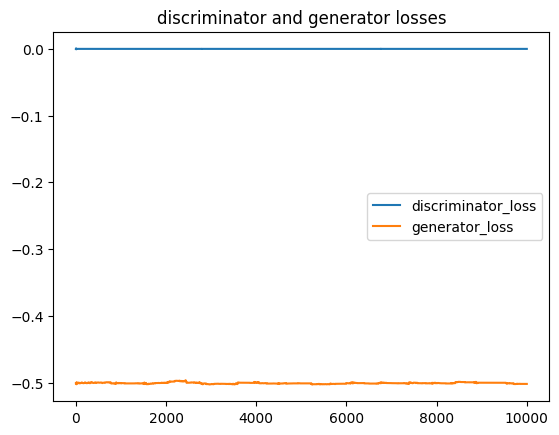

In [16]:
losses,gen = train_GAN(learning_rate = 0.001, num_epochs = 100)
losses_df = pd.DataFrame(data=losses,columns=['discriminator_loss','generator_loss'])
plt.plot(losses_df['discriminator_loss'],label = 'discriminator_loss')
plt.plot(losses_df['generator_loss'],label='generator_loss')
plt.legend()
plt.title('discriminator and generator losses')
plt.show()


In [19]:
noise = torch.randn(1, len(log_returns_normalized), N_z, device=device)
generated_snp_gaus = gen(noise).detach().reshape(len(log_returns_normalized)).numpy()


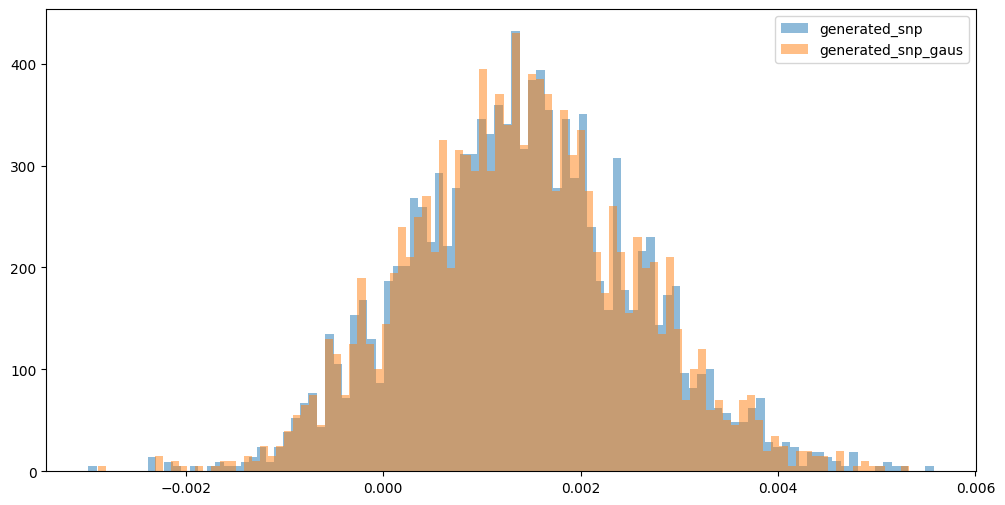

In [20]:
generated_snp = gaus.inverse_transform(np.array([[g] for g in generated_snp_gaus]) ).reshape(-1)
plt.figure(figsize=(12,6))
plt.hist(generated_snp,bins=100,density=True,label='generated_snp',alpha=0.5)
plt.hist(generated_snp_gaus,bins=100,density=True,label='generated_snp_gaus',alpha=0.5)
plt.legend()
plt.show()

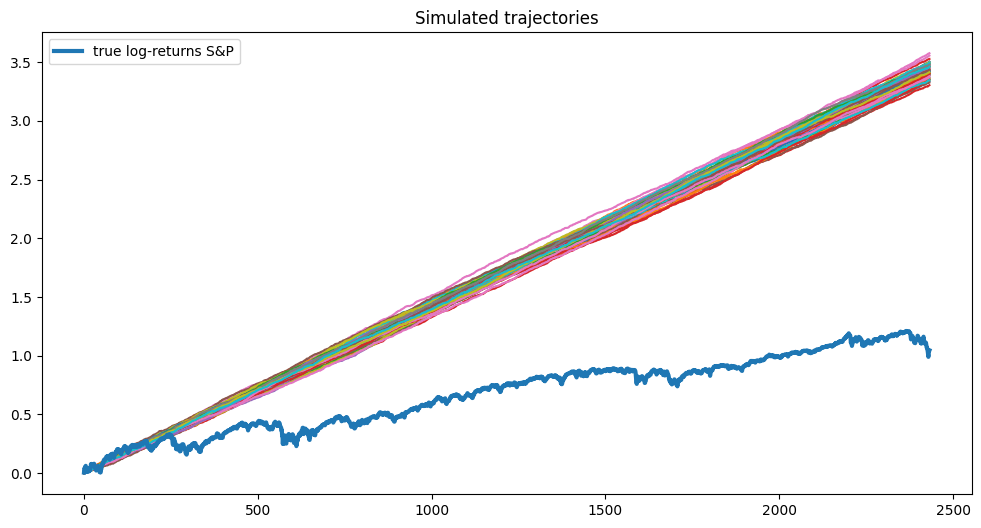

In [29]:
def generate_snp_trajectory(n_generate = 50):
    sim_df = []
    for tr in range(1,n_generate+1):
        noise = torch.randn(1, len(log_returns_normalized), N_z, device=device)
        generated_snp_gaus = gen(noise).detach().reshape(len(log_returns_normalized)).numpy()
        generated_snp = gaus.inverse_transform(np.array([[g] for g in generated_snp_gaus]) ).reshape(-1)
        sim_df.append(generated_snp)
    return pd.DataFrame(data=np.array(sim_df).T,columns=[f'tr {t}' for t in range(1,n_generate+1)] ).cumsum()

plt.figure(figsize=(12,6))
plt.plot(generate_snp_trajectory())
plt.plot(list(log_returns.cumsum()),linewidth=3,label='true log-returns S&P')
plt.title('Simulated trajectories')
plt.legend()
plt.show()


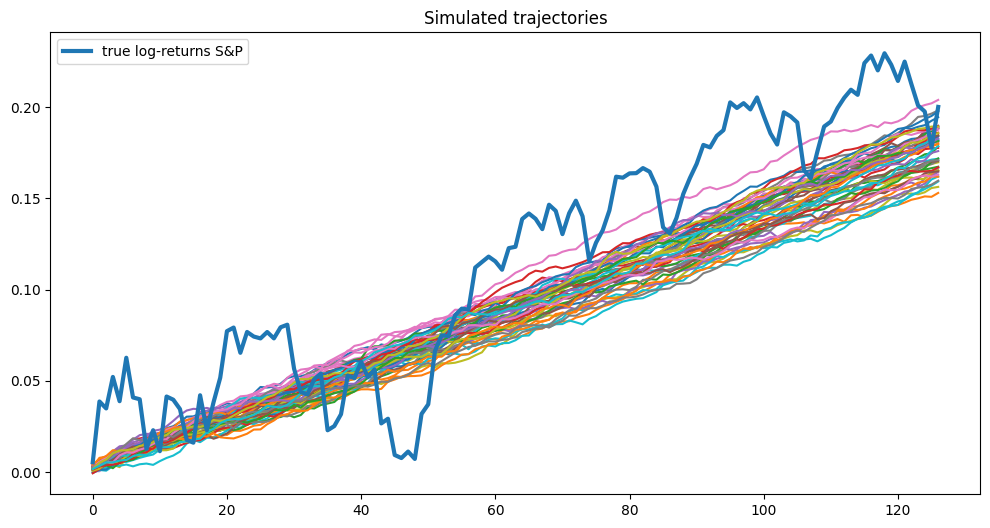

In [31]:
plt.figure(figsize=(12,6))
plt.plot(generate_snp_trajectory()[:127])
plt.plot(list(log_returns.cumsum()[:127]),linewidth=3,label='true log-returns S&P')
plt.title('Simulated trajectories')
plt.legend()
plt.show()

As you can see the generated paths seem to be much closer to reality than previously.
However they tend to systematically generate higher returns.

Let's try some other parameters to try to improve the situation.

## Trying some new parameters

  0%|                                                    | 0/40 [00:00<?, ?it/s]

Generator loss = -0.49730393290519714, Discriminator loss = 2.676248550415039e-05
Generator loss = -0.49928343296051025, Discriminator loss = -0.000935286283493042
Generator loss = -0.5016880631446838, Discriminator loss = 2.2649765014648438e-05
Generator loss = -0.5009484887123108, Discriminator loss = -2.473592758178711e-05
Generator loss = -0.5005355477333069, Discriminator loss = -3.4749507904052734e-05
Generator loss = -0.5002875328063965, Discriminator loss = -2.6524066925048828e-05
Generator loss = -0.500374972820282, Discriminator loss = 6.198883056640625e-06
Generator loss = -0.5008503794670105, Discriminator loss = -2.9206275939941406e-06
Generator loss = -0.5013735890388489, Discriminator loss = -3.343820571899414e-05
Generator loss = -0.5012836456298828, Discriminator loss = 4.231929779052734e-06


  2%|█                                           | 1/40 [00:31<20:46, 31.95s/it]

Generator loss = -0.5010290145874023, Discriminator loss = 5.841255187988281e-06
Generator loss = -0.5007531046867371, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.5005519986152649, Discriminator loss = -5.781650543212891e-06
Generator loss = -0.5003743767738342, Discriminator loss = -1.2814998626708984e-05
Generator loss = -0.5002976655960083, Discriminator loss = -7.867813110351562e-06
Generator loss = -0.5004792809486389, Discriminator loss = 7.212162017822266e-06
Generator loss = -0.5007364749908447, Discriminator loss = 2.384185791015625e-06
Generator loss = -0.5010762214660645, Discriminator loss = -9.059906005859375e-06
Generator loss = -0.5015115737915039, Discriminator loss = -1.5914440155029297e-05
Generator loss = -0.5013394355773926, Discriminator loss = 4.231929779052734e-06


  5%|██▏                                         | 2/40 [01:05<20:41, 32.67s/it]

Generator loss = -0.5009554624557495, Discriminator loss = 3.933906555175781e-06
Generator loss = -0.5006816983222961, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5004675984382629, Discriminator loss = -5.364418029785156e-06
Generator loss = -0.500268816947937, Discriminator loss = -1.0967254638671875e-05
Generator loss = -0.500249445438385, Discriminator loss = -2.384185791015625e-06
Generator loss = -0.5004441738128662, Discriminator loss = 5.424022674560547e-06
Generator loss = -0.5008246898651123, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5011532306671143, Discriminator loss = -6.854534149169922e-06
Generator loss = -0.5017737746238708, Discriminator loss = -1.2874603271484375e-05
Generator loss = -0.5013514161109924, Discriminator loss = 4.5299530029296875e-06


  8%|███▎                                        | 3/40 [01:44<21:59, 35.67s/it]

Generator loss = -0.5010054111480713, Discriminator loss = 1.8477439880371094e-06
Generator loss = -0.5007270574569702, Discriminator loss = -1.430511474609375e-06
Generator loss = -0.500505805015564, Discriminator loss = -6.616115570068359e-06
Generator loss = -0.5003251433372498, Discriminator loss = -8.106231689453125e-06
Generator loss = -0.5004609823226929, Discriminator loss = 3.337860107421875e-06
Generator loss = -0.5006712675094604, Discriminator loss = 2.086162567138672e-06
Generator loss = -0.5009900331497192, Discriminator loss = -1.6689300537109375e-06
Generator loss = -0.5016751289367676, Discriminator loss = -9.775161743164062e-06
Generator loss = -0.5017337799072266, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.5010823607444763, Discriminator loss = 2.384185791015625e-06


 10%|████▍                                       | 4/40 [02:20<21:34, 35.95s/it]

Generator loss = -0.5008074045181274, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5006581544876099, Discriminator loss = -3.3974647521972656e-06
Generator loss = -0.5004507303237915, Discriminator loss = -7.927417755126953e-06
Generator loss = -0.5005716681480408, Discriminator loss = 1.7881393432617188e-06
Generator loss = -0.5008138418197632, Discriminator loss = 1.7285346984863281e-06
Generator loss = -0.5011107325553894, Discriminator loss = -8.940696716308594e-07
Generator loss = -0.5017616152763367, Discriminator loss = -8.52346420288086e-06
Generator loss = -0.5016957521438599, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.5010977983474731, Discriminator loss = 1.1920928955078125e-06
Generator loss = -0.5008032917976379, Discriminator loss = -5.364418029785156e-07


 12%|█████▌                                      | 5/40 [02:56<20:51, 35.77s/it]

Generator loss = -0.5006351470947266, Discriminator loss = -3.2186508178710938e-06
Generator loss = -0.5004497766494751, Discriminator loss = -5.781650543212891e-06
Generator loss = -0.5007466673851013, Discriminator loss = 2.1457672119140625e-06
Generator loss = -0.5011570453643799, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5014955997467041, Discriminator loss = -1.3709068298339844e-06
Generator loss = -0.5020267963409424, Discriminator loss = -9.59634780883789e-06
Generator loss = -0.501069962978363, Discriminator loss = 1.2516975402832031e-06
Generator loss = -0.5007637143135071, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.500399649143219, Discriminator loss = -3.933906555175781e-06
Generator loss = -0.499935120344162, Discriminator loss = -5.4836273193359375e-06


 15%|██████▌                                     | 6/40 [03:36<21:05, 37.22s/it]

Generator loss = -0.5003253817558289, Discriminator loss = 1.6093254089355469e-06
Generator loss = -0.5005532503128052, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5009260177612305, Discriminator loss = -4.112720489501953e-06
Generator loss = -0.5014715194702148, Discriminator loss = -4.708766937255859e-06
Generator loss = -0.5006886124610901, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5001515746116638, Discriminator loss = -3.2782554626464844e-06
Generator loss = -0.49898862838745117, Discriminator loss = -1.9043684005737305e-05
Generator loss = -0.5007305145263672, Discriminator loss = 8.940696716308594e-07
Generator loss = -0.5013837218284607, Discriminator loss = -4.291534423828125e-06
Generator loss = -0.5014680027961731, Discriminator loss = -5.4836273193359375e-05


 18%|███████▋                                    | 7/40 [04:14<20:44, 37.72s/it]

Generator loss = -0.5002941489219666, Discriminator loss = -1.5676021575927734e-05
Generator loss = -0.5011452436447144, Discriminator loss = -8.064508438110352e-05
Generator loss = -0.4982846677303314, Discriminator loss = -0.00020176172256469727
Generator loss = -0.49725475907325745, Discriminator loss = 1.9490718841552734e-05
Generator loss = -0.4976039528846741, Discriminator loss = 4.76837158203125e-06
Generator loss = -0.4980849027633667, Discriminator loss = -8.821487426757812e-06
Generator loss = -0.49863937497138977, Discriminator loss = -2.7239322662353516e-05
Generator loss = -0.4992488622665405, Discriminator loss = -3.11732292175293e-05
Generator loss = -0.4992711842060089, Discriminator loss = 1.0132789611816406e-06
Generator loss = -0.4983395040035248, Discriminator loss = 1.0192394256591797e-05


 20%|████████▊                                   | 8/40 [04:51<19:55, 37.36s/it]

Generator loss = -0.49796414375305176, Discriminator loss = 3.3974647521972656e-06
Generator loss = -0.49769267439842224, Discriminator loss = -1.7583370208740234e-06
Generator loss = -0.4979429543018341, Discriminator loss = -9.775161743164062e-06
Generator loss = -0.49847477674484253, Discriminator loss = -2.390146255493164e-05
Generator loss = -0.4985177516937256, Discriminator loss = -5.0961971282958984e-06
Generator loss = -0.4985191822052002, Discriminator loss = 9.715557098388672e-06
Generator loss = -0.4986807703971863, Discriminator loss = 2.6226043701171875e-06
Generator loss = -0.4989267587661743, Discriminator loss = -2.4437904357910156e-06
Generator loss = -0.4994053244590759, Discriminator loss = -1.2308359146118164e-05
Generator loss = -0.49977540969848633, Discriminator loss = -2.288818359375e-05


 22%|█████████▉                                  | 9/40 [05:27<19:04, 36.93s/it]

Generator loss = -0.49963703751564026, Discriminator loss = 5.155801773071289e-06
Generator loss = -0.49915799498558044, Discriminator loss = 5.185604095458984e-06
Generator loss = -0.49879953265190125, Discriminator loss = 1.1324882507324219e-06
Generator loss = -0.49856266379356384, Discriminator loss = -1.8775463104248047e-06
Generator loss = -0.49852097034454346, Discriminator loss = -9.357929229736328e-06
Generator loss = -0.49885809421539307, Discriminator loss = -1.7821788787841797e-05
Generator loss = -0.4989013969898224, Discriminator loss = 5.125999450683594e-06
Generator loss = -0.49889305233955383, Discriminator loss = 3.129243850708008e-06
Generator loss = -0.49898189306259155, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.4991610646247864, Discriminator loss = -2.6226043701171875e-06


 25%|██████████▊                                | 10/40 [06:06<18:43, 37.45s/it]

Generator loss = -0.4996817111968994, Discriminator loss = -1.0877847671508789e-05
Generator loss = -0.49993592500686646, Discriminator loss = -6.973743438720703e-06
Generator loss = -0.4993787407875061, Discriminator loss = 4.678964614868164e-06
Generator loss = -0.498994380235672, Discriminator loss = 1.1324882507324219e-06
Generator loss = -0.4986470341682434, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.49843332171440125, Discriminator loss = -4.410743713378906e-06
Generator loss = -0.4985857307910919, Discriminator loss = -1.475214958190918e-05
Generator loss = -0.4986511766910553, Discriminator loss = 3.129243850708008e-06
Generator loss = -0.49877896904945374, Discriminator loss = 1.6689300537109375e-06
Generator loss = -0.4990171790122986, Discriminator loss = 2.9802322387695312e-08


 28%|███████████▊                               | 11/40 [06:43<18:06, 37.47s/it]

Generator loss = -0.49945881962776184, Discriminator loss = -1.7285346984863281e-06
Generator loss = -0.49988844990730286, Discriminator loss = -8.821487426757812e-06
Generator loss = -0.4999576508998871, Discriminator loss = -1.7583370208740234e-06
Generator loss = -0.49946853518486023, Discriminator loss = 2.3245811462402344e-06
Generator loss = -0.4992077648639679, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.4989372789859772, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.49886220693588257, Discriminator loss = -8.195638656616211e-06
Generator loss = -0.49883732199668884, Discriminator loss = -3.4570693969726562e-06
Generator loss = -0.499022901058197, Discriminator loss = 1.6391277313232422e-06
Generator loss = -0.4991818964481354, Discriminator loss = -2.9802322387695312e-08


 30%|████████████▉                              | 12/40 [07:16<16:52, 36.18s/it]

Generator loss = -0.49943798780441284, Discriminator loss = -2.771615982055664e-06
Generator loss = -0.49989140033721924, Discriminator loss = -1.2785196304321289e-05
Generator loss = -0.4996725916862488, Discriminator loss = 2.3245811462402344e-06
Generator loss = -0.4993038475513458, Discriminator loss = 6.258487701416016e-07
Generator loss = -0.4991741478443146, Discriminator loss = 0.0
Generator loss = -0.4989462196826935, Discriminator loss = -9.834766387939453e-07
Generator loss = -0.4986835718154907, Discriminator loss = -7.0035457611083984e-06
Generator loss = -0.49845805764198303, Discriminator loss = 1.341104507446289e-06
Generator loss = -0.4986770451068878, Discriminator loss = 5.662441253662109e-07
Generator loss = -0.4988768994808197, Discriminator loss = 0.0


 32%|█████████████▉                             | 13/40 [08:00<17:13, 38.27s/it]

Generator loss = -0.49924740195274353, Discriminator loss = -6.258487701416016e-07
Generator loss = -0.4996800124645233, Discriminator loss = -4.6193599700927734e-06
Generator loss = -0.4996529221534729, Discriminator loss = 2.682209014892578e-07
Generator loss = -0.4992103576660156, Discriminator loss = 6.258487701416016e-07
Generator loss = -0.49875327944755554, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4986218810081482, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.49837619066238403, Discriminator loss = -5.0961971282958984e-06
Generator loss = -0.49835601449012756, Discriminator loss = 8.940696716308594e-07
Generator loss = -0.49867621064186096, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.49876949191093445, Discriminator loss = 0.0


 35%|███████████████                            | 14/40 [08:36<16:24, 37.86s/it]

Generator loss = -0.49890658259391785, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.4993633031845093, Discriminator loss = -3.069639205932617e-06
Generator loss = -0.4992343485355377, Discriminator loss = 4.470348358154297e-07
Generator loss = -0.49866876006126404, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.4984719753265381, Discriminator loss = 0.0
Generator loss = -0.4988124966621399, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.4989921450614929, Discriminator loss = -1.5497207641601562e-06
Generator loss = -0.4989457428455353, Discriminator loss = -7.450580596923828e-07
Generator loss = -0.49916693568229675, Discriminator loss = 1.4901161193847656e-07
Generator loss = -0.4992588758468628, Discriminator loss = -1.1920928955078125e-07


 38%|████████████████▏                          | 15/40 [09:13<15:33, 37.33s/it]

Generator loss = -0.49940285086631775, Discriminator loss = -1.3709068298339844e-06
Generator loss = -0.4998517334461212, Discriminator loss = -4.76837158203125e-06
Generator loss = -0.49907684326171875, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49856263399124146, Discriminator loss = -3.546476364135742e-06
Generator loss = -0.4993656277656555, Discriminator loss = -1.2964010238647461e-05
Generator loss = -0.49941033124923706, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49952173233032227, Discriminator loss = -1.1652708053588867e-05
Generator loss = -0.4994840919971466, Discriminator loss = -9.566545486450195e-06
Generator loss = -0.49964895844459534, Discriminator loss = 1.4603137969970703e-06
Generator loss = -0.4997275769710541, Discriminator loss = 1.1920928955078125e-07


 40%|█████████████████▏                         | 16/40 [09:45<14:23, 35.97s/it]

Generator loss = -0.4996931254863739, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.4994475841522217, Discriminator loss = -4.112720489501953e-06
Generator loss = -0.4996885657310486, Discriminator loss = -3.635883331298828e-06
Generator loss = -0.5000830292701721, Discriminator loss = 7.748603820800781e-07
Generator loss = -0.5001234412193298, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5000585913658142, Discriminator loss = -1.2516975402832031e-06
Generator loss = -0.5000612735748291, Discriminator loss = -5.304813385009766e-06
Generator loss = -0.5000959038734436, Discriminator loss = 1.0132789611816406e-06
Generator loss = -0.5001634359359741, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.500190258026123, Discriminator loss = 0.0


 42%|██████████████████▎                        | 17/40 [10:18<13:27, 35.09s/it]

Generator loss = -0.5000706315040588, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.49992090463638306, Discriminator loss = -2.1457672119140625e-06
Generator loss = -0.4998481869697571, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.500091016292572, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5001929998397827, Discriminator loss = 0.0
Generator loss = -0.50023353099823, Discriminator loss = -1.1920928955078125e-06
Generator loss = -0.500349223613739, Discriminator loss = -6.198883056640625e-06
Generator loss = -0.5003829598426819, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.4999764859676361, Discriminator loss = -3.2782554626464844e-07
Generator loss = -0.5000491738319397, Discriminator loss = -9.655952453613281e-06


 45%|███████████████████▎                       | 18/40 [10:51<12:33, 34.23s/it]

Generator loss = -0.5001148581504822, Discriminator loss = 1.0728836059570312e-06
Generator loss = -0.5000850558280945, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5000774264335632, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5000540614128113, Discriminator loss = -1.6093254089355469e-06
Generator loss = -0.5000067949295044, Discriminator loss = -2.5033950805664062e-06
Generator loss = -0.5000836849212646, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5000007152557373, Discriminator loss = 0.0
Generator loss = -0.4999457597732544, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.49983730912208557, Discriminator loss = -4.4405460357666016e-06
Generator loss = -0.5001116991043091, Discriminator loss = 2.384185791015625e-07


 48%|████████████████████▍                      | 19/40 [11:23<11:49, 33.80s/it]

Generator loss = -0.5000752806663513, Discriminator loss = -5.960464477539062e-07
Generator loss = -0.49994340538978577, Discriminator loss = -8.13603401184082e-06
Generator loss = -0.5000520944595337, Discriminator loss = 7.748603820800781e-07
Generator loss = -0.5002193450927734, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5001519918441772, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.49995699524879456, Discriminator loss = -3.844499588012695e-06
Generator loss = -0.5001301765441895, Discriminator loss = 5.364418029785156e-07
Generator loss = -0.5002158284187317, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5002143383026123, Discriminator loss = 0.0
Generator loss = -0.5002560615539551, Discriminator loss = -4.172325134277344e-07


 50%|█████████████████████▌                     | 20/40 [11:56<11:10, 33.54s/it]

Generator loss = -0.5000529885292053, Discriminator loss = -2.5033950805664062e-06
Generator loss = -0.500316321849823, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5003761053085327, Discriminator loss = 0.0
Generator loss = -0.5004392862319946, Discriminator loss = -5.960464477539062e-07
Generator loss = -0.5002267360687256, Discriminator loss = -4.112720489501953e-06
Generator loss = -0.5002613067626953, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5002962946891785, Discriminator loss = -8.940696716308594e-07
Generator loss = -0.500286340713501, Discriminator loss = -1.0967254638671875e-05
Generator loss = -0.5002936720848083, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.49984532594680786, Discriminator loss = -1.671910285949707e-05


 52%|██████████████████████▌                    | 21/40 [12:32<10:48, 34.13s/it]

Generator loss = -0.499851256608963, Discriminator loss = -3.337860107421875e-06
Generator loss = -0.5000796914100647, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5000951886177063, Discriminator loss = -2.1457672119140625e-06
Generator loss = -0.5000813603401184, Discriminator loss = -1.9609928131103516e-05
Generator loss = -0.5000954866409302, Discriminator loss = 2.205371856689453e-06
Generator loss = -0.5001002550125122, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5000402927398682, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.49991336464881897, Discriminator loss = -4.500150680541992e-06
Generator loss = -0.49979743361473083, Discriminator loss = -3.427267074584961e-06
Generator loss = -0.49999088048934937, Discriminator loss = 7.152557373046875e-07


 55%|███████████████████████▋                   | 22/40 [13:05<10:11, 33.97s/it]

Generator loss = -0.5000540614128113, Discriminator loss = 0.0
Generator loss = -0.49995800852775574, Discriminator loss = -1.4007091522216797e-06
Generator loss = -0.4998942017555237, Discriminator loss = -5.453824996948242e-06
Generator loss = -0.5000190138816833, Discriminator loss = 1.0728836059570312e-06
Generator loss = -0.5000874996185303, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5000936388969421, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.4999557435512543, Discriminator loss = -2.2649765014648438e-06
Generator loss = -0.4998651444911957, Discriminator loss = -1.9669532775878906e-06
Generator loss = -0.5000656247138977, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5000945329666138, Discriminator loss = -1.1920928955078125e-07


 57%|████████████████████████▋                  | 23/40 [13:40<09:42, 34.27s/it]

Generator loss = -0.5000359416007996, Discriminator loss = -7.748603820800781e-07
Generator loss = -0.4999881088733673, Discriminator loss = -6.556510925292969e-06
Generator loss = -0.500078558921814, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.49991872906684875, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.49934470653533936, Discriminator loss = -8.881092071533203e-06
Generator loss = -0.4996086359024048, Discriminator loss = 1.0132789611816406e-06
Generator loss = -0.4997829496860504, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.49966153502464294, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.4996468424797058, Discriminator loss = -8.940696716308594e-07
Generator loss = -0.5000672340393066, Discriminator loss = -3.635883331298828e-06


 60%|█████████████████████████▊                 | 24/40 [14:15<09:11, 34.47s/it]

Generator loss = -0.500104546546936, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5002334117889404, Discriminator loss = 0.0
Generator loss = -0.5002975463867188, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5002038478851318, Discriminator loss = -5.245208740234375e-06
Generator loss = -0.5005267858505249, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5008054375648499, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5007915496826172, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5004454255104065, Discriminator loss = -1.3113021850585938e-06
Generator loss = -0.5000953674316406, Discriminator loss = -1.5497207641601562e-06
Generator loss = -0.5003443360328674, Discriminator loss = 1.7881393432617188e-07


 62%|██████████████████████████▉                | 25/40 [14:54<08:53, 35.58s/it]

Generator loss = -0.500381350517273, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5006333589553833, Discriminator loss = -1.3113021850585938e-06
Generator loss = -0.5001063942909241, Discriminator loss = -4.0531158447265625e-06
Generator loss = -0.5001956224441528, Discriminator loss = 0.0
Generator loss = -0.5003926157951355, Discriminator loss = -8.285045623779297e-06
Generator loss = -0.5003599524497986, Discriminator loss = -5.125999450683594e-06
Generator loss = -0.500739574432373, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5006797909736633, Discriminator loss = -6.9141387939453125e-06
Generator loss = -0.500953197479248, Discriminator loss = -2.4974346160888672e-05
Generator loss = -0.5013172626495361, Discriminator loss = -8.64267349243164e-06


 65%|███████████████████████████▉               | 26/40 [15:43<09:16, 39.73s/it]

Generator loss = -0.5002272129058838, Discriminator loss = -2.7954578399658203e-05
Generator loss = -0.5002513527870178, Discriminator loss = -1.2099742889404297e-05
Generator loss = -0.49988749623298645, Discriminator loss = 3.129243850708008e-06
Generator loss = -0.49986639618873596, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.4999401867389679, Discriminator loss = -1.1146068572998047e-05
Generator loss = -0.5000881552696228, Discriminator loss = -1.2099742889404297e-05
Generator loss = -0.5000437498092651, Discriminator loss = 2.6226043701171875e-06
Generator loss = -0.5000410676002502, Discriminator loss = 0.0
Generator loss = -0.5002620816230774, Discriminator loss = -3.159046173095703e-06
Generator loss = -0.5005078315734863, Discriminator loss = -1.3053417205810547e-05


 68%|█████████████████████████████              | 27/40 [16:23<08:37, 39.79s/it]

Generator loss = -0.5008768439292908, Discriminator loss = 3.2782554626464844e-06
Generator loss = -0.5007855296134949, Discriminator loss = 1.0728836059570312e-06
Generator loss = -0.5008566975593567, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.500519871711731, Discriminator loss = -2.9206275939941406e-06
Generator loss = -0.5003693103790283, Discriminator loss = -1.150369644165039e-05
Generator loss = -0.5005765557289124, Discriminator loss = 2.0265579223632812e-06
Generator loss = -0.5004358887672424, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5004652142524719, Discriminator loss = -1.0728836059570312e-06
Generator loss = -0.5006186962127686, Discriminator loss = -5.304813385009766e-06
Generator loss = -0.5006769895553589, Discriminator loss = -2.5033950805664062e-06


 70%|██████████████████████████████             | 28/40 [16:59<07:45, 38.78s/it]

Generator loss = -0.5007761120796204, Discriminator loss = 1.3113021850585938e-06
Generator loss = -0.5007805228233337, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5008047223091125, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.5000669360160828, Discriminator loss = -8.940696716308594e-06
Generator loss = -0.5000230073928833, Discriminator loss = 1.6689300537109375e-06
Generator loss = -0.4999491274356842, Discriminator loss = 3.2782554626464844e-07
Generator loss = -0.4999464452266693, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5000206828117371, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.500160813331604, Discriminator loss = -6.020069122314453e-06
Generator loss = -0.5000281929969788, Discriminator loss = 1.1324882507324219e-06


 72%|███████████████████████████████▏           | 29/40 [17:33<06:51, 37.40s/it]

Generator loss = -0.4999670684337616, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5000031590461731, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.50010085105896, Discriminator loss = -2.9206275939941406e-06
Generator loss = -0.5001291632652283, Discriminator loss = -1.2516975402832031e-06
Generator loss = -0.499979168176651, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.499959796667099, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5001004934310913, Discriminator loss = -1.4901161193847656e-06
Generator loss = -0.5003449320793152, Discriminator loss = -5.781650543212891e-06
Generator loss = -0.5000801086425781, Discriminator loss = 6.556510925292969e-07
Generator loss = -0.4999999701976776, Discriminator loss = -1.7881393432617188e-07


 75%|████████████████████████████████▎          | 30/40 [18:06<05:59, 35.95s/it]

Generator loss = -0.5000213980674744, Discriminator loss = -2.3245811462402344e-06
Generator loss = -0.5001433491706848, Discriminator loss = -6.258487701416016e-06
Generator loss = -0.4999856948852539, Discriminator loss = 2.682209014892578e-07
Generator loss = -0.5000264048576355, Discriminator loss = -2.3245811462402344e-06
Generator loss = -0.5001352429389954, Discriminator loss = -1.33514404296875e-05
Generator loss = -0.49999088048934937, Discriminator loss = 1.1920928955078125e-06
Generator loss = -0.49995920062065125, Discriminator loss = 0.0
Generator loss = -0.4999605119228363, Discriminator loss = -1.430511474609375e-06
Generator loss = -0.5001281499862671, Discriminator loss = -9.417533874511719e-06
Generator loss = -0.499991774559021, Discriminator loss = 6.854534149169922e-07


 78%|█████████████████████████████████▎         | 31/40 [18:39<05:16, 35.13s/it]

Generator loss = -0.4999791085720062, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.500031590461731, Discriminator loss = -4.0531158447265625e-06
Generator loss = -0.5000101327896118, Discriminator loss = -5.066394805908203e-06
Generator loss = -0.4999755620956421, Discriminator loss = 4.470348358154297e-07
Generator loss = -0.5000059604644775, Discriminator loss = -2.086162567138672e-07
Generator loss = -0.5001418590545654, Discriminator loss = -8.046627044677734e-06
Generator loss = -0.5000433921813965, Discriminator loss = -2.7418136596679688e-06
Generator loss = -0.4997219443321228, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.4996339976787567, Discriminator loss = -8.642673492431641e-07
Generator loss = -0.5000768899917603, Discriminator loss = -1.4603137969970703e-05


 80%|██████████████████████████████████▍        | 32/40 [19:12<04:36, 34.51s/it]

Generator loss = -0.5001584887504578, Discriminator loss = 1.430511474609375e-06
Generator loss = -0.5003316402435303, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5003775358200073, Discriminator loss = 0.0
Generator loss = -0.5004632472991943, Discriminator loss = -7.748603820800781e-07
Generator loss = -0.5004553198814392, Discriminator loss = -4.827976226806641e-06
Generator loss = -0.5004536509513855, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5005483627319336, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5003857016563416, Discriminator loss = 0.0
Generator loss = -0.4998546242713928, Discriminator loss = -3.2782554626464844e-07
Generator loss = -0.49972406029701233, Discriminator loss = -3.993511199951172e-06


 82%|███████████████████████████████████▍       | 33/40 [19:45<03:57, 33.87s/it]

Generator loss = -0.49972009658813477, Discriminator loss = -3.2782554626464844e-07
Generator loss = -0.49975770711898804, Discriminator loss = 3.2782554626464844e-07
Generator loss = -0.4997672140598297, Discriminator loss = 0.0
Generator loss = -0.4997815787792206, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.49978792667388916, Discriminator loss = -6.4373016357421875e-06
Generator loss = -0.49978941679000854, Discriminator loss = 8.046627044677734e-07
Generator loss = -0.49977368116378784, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.4997619092464447, Discriminator loss = 0.0
Generator loss = -0.4997330605983734, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.49969515204429626, Discriminator loss = -3.039836883544922e-06


 85%|████████████████████████████████████▌      | 34/40 [20:17<03:20, 33.43s/it]

Generator loss = -0.49972689151763916, Discriminator loss = 4.470348358154297e-07
Generator loss = -0.4997507929801941, Discriminator loss = 1.4901161193847656e-07
Generator loss = -0.4997577965259552, Discriminator loss = 0.0
Generator loss = -0.4997546672821045, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.49973899126052856, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.49975597858428955, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.4997599422931671, Discriminator loss = 1.4901161193847656e-07
Generator loss = -0.4997587203979492, Discriminator loss = 0.0
Generator loss = -0.4997503161430359, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.49971675872802734, Discriminator loss = -2.115964889526367e-06


 88%|█████████████████████████████████████▋     | 35/40 [20:53<02:51, 34.27s/it]

Generator loss = -0.4997357130050659, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.4997546970844269, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49977001547813416, Discriminator loss = 0.0
Generator loss = -0.499811589717865, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.49991515278816223, Discriminator loss = -6.258487701416016e-07
Generator loss = -0.49991679191589355, Discriminator loss = -8.940696716308594e-08
Generator loss = -0.49940937757492065, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4991413950920105, Discriminator loss = 0.0
Generator loss = -0.4991399347782135, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.4991103708744049, Discriminator loss = -8.046627044677734e-07


 90%|██████████████████████████████████████▋    | 36/40 [21:28<02:17, 34.27s/it]

Generator loss = -0.49920859932899475, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.4992356598377228, Discriminator loss = 0.0
Generator loss = -0.4992145299911499, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.49912208318710327, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.4992564916610718, Discriminator loss = -3.8743019104003906e-07
Generator loss = -0.4994327425956726, Discriminator loss = 0.0
Generator loss = -0.49945834279060364, Discriminator loss = 0.0
Generator loss = -0.4992164671421051, Discriminator loss = -4.470348358154297e-07
Generator loss = -0.4992218613624573, Discriminator loss = -3.8743019104003906e-07
Generator loss = -0.4992426335811615, Discriminator loss = 0.0


 92%|███████████████████████████████████████▊   | 37/40 [22:00<01:41, 33.68s/it]

Generator loss = -0.4993443489074707, Discriminator loss = -4.410743713378906e-06
Generator loss = -0.4992646872997284, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4995763599872589, Discriminator loss = -5.21540641784668e-06
Generator loss = -0.49904096126556396, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.499588280916214, Discriminator loss = -1.817941665649414e-06
Generator loss = -0.4994567930698395, Discriminator loss = -1.5497207641601562e-06
Generator loss = -0.49940910935401917, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.49985384941101074, Discriminator loss = -1.4543533325195312e-05
Generator loss = -0.4993465840816498, Discriminator loss = 5.960464477539062e-07
Generator loss = -0.499597430229187, Discriminator loss = -3.2782554626464844e-07


 95%|████████████████████████████████████████▊  | 38/40 [22:32<01:06, 33.21s/it]

Generator loss = -0.49958622455596924, Discriminator loss = -6.794929504394531e-06
Generator loss = -0.4995247423648834, Discriminator loss = 5.960464477539062e-07
Generator loss = -0.49955230951309204, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49966567754745483, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.49963143467903137, Discriminator loss = -2.205371856689453e-06
Generator loss = -0.4996659755706787, Discriminator loss = 3.8743019104003906e-07
Generator loss = -0.4996722340583801, Discriminator loss = 8.940696716308594e-08
Generator loss = -0.49966123700141907, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.49964872002601624, Discriminator loss = -3.2782554626464844e-07
Generator loss = -0.4996107220649719, Discriminator loss = -1.5497207641601562e-06


 98%|█████████████████████████████████████████▉ | 39/40 [23:07<00:33, 33.70s/it]

Generator loss = -0.49953004717826843, Discriminator loss = 2.086162567138672e-07
Generator loss = -0.4995590150356293, Discriminator loss = -8.940696716308594e-08
Generator loss = -0.4992077052593231, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.4993894696235657, Discriminator loss = -2.8312206268310547e-06
Generator loss = -0.4984967112541199, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49852246046066284, Discriminator loss = -1.6093254089355469e-06
Generator loss = -0.49875155091285706, Discriminator loss = -7.361173629760742e-06
Generator loss = -0.49820661544799805, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.4982106387615204, Discriminator loss = -4.291534423828125e-06
Generator loss = -0.4987233579158783, Discriminator loss = -7.510185241699219e-06


100%|███████████████████████████████████████████| 40/40 [23:40<00:00, 35.51s/it]


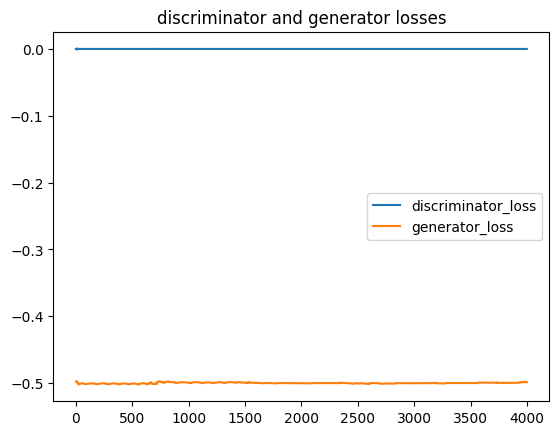

In [68]:
losses,gen =train_GAN(
            learning_rate = 0.0005,
            num_epochs = 40,
            N_z = N_z, # as set in paper
            n_in_epoch=100,
            batch_size = 16,
            update_gen = 10, # update gen every n step 
            val_clip = 0.01
                )
losses_df = pd.DataFrame(data=losses,columns=['discriminator_loss','generator_loss'])
plt.plot(losses_df['discriminator_loss'],label = 'discriminator_loss')
plt.plot(losses_df['generator_loss'],label='generator_loss')
plt.legend()
plt.title('discriminator and generator losses')
plt.show()


In [69]:
noise = torch.randn(1, len(log_returns_normalized), N_z, device=device)
generated_snp_gaus = gen(noise).detach().reshape(len(log_returns_normalized)).numpy()


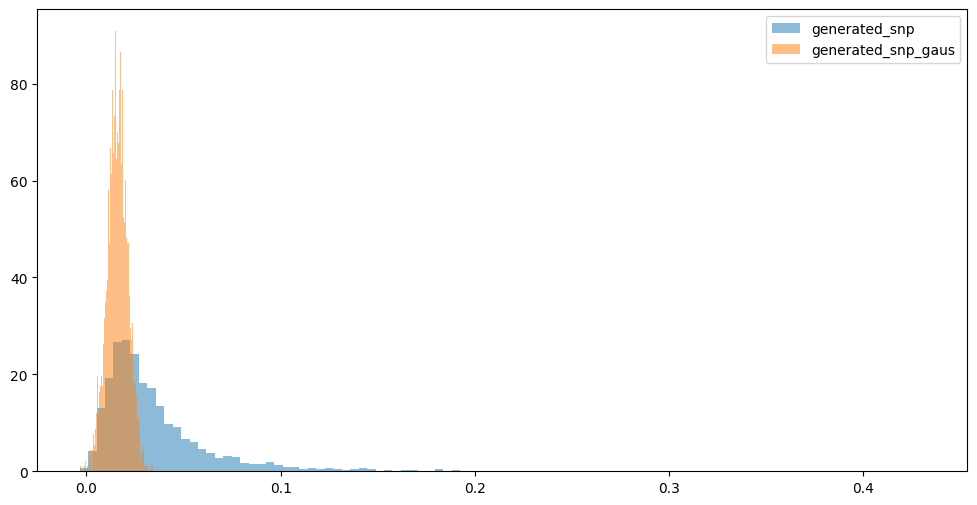

In [71]:
generated_snp = gaus.inverse_transform(np.array([[g] for g in generated_snp_gaus]) ).reshape(-1)
plt.figure(figsize=(12,6))
plt.hist(generated_snp,bins=100,density=True,label='generated_snp',alpha=0.5)
plt.hist(generated_snp_gaus,bins=100,density=True,label='generated_snp_gaus',alpha=0.5)
plt.legend()
plt.show()


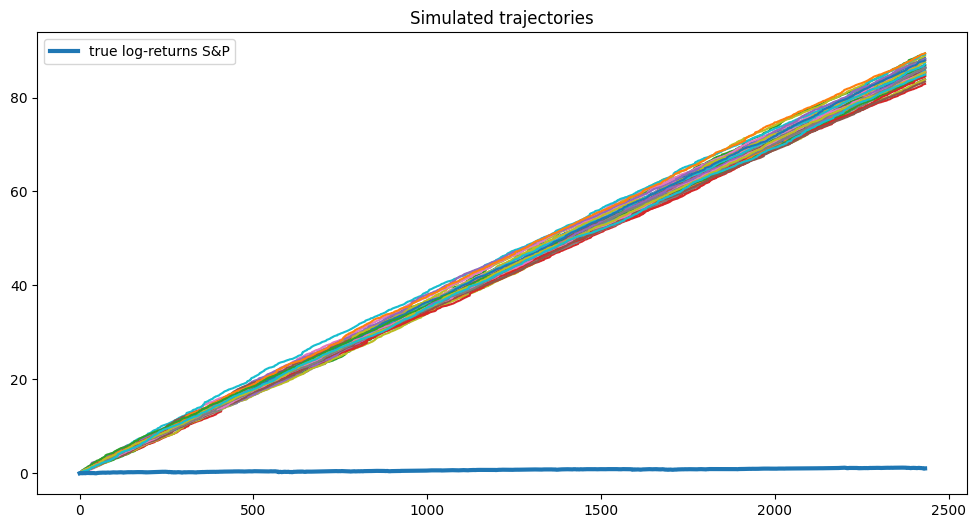

In [74]:
def generate_snp_trajectory(n_generate = 50):
    sim_df = []
    for tr in range(1,n_generate+1):
        noise = torch.randn(1, len(log_returns_normalized), N_z, device=device)
        generated_snp_gaus = gen(noise).detach().reshape(len(log_returns_normalized)).numpy()
        generated_snp = gaus.inverse_transform(np.array([[g] for g in generated_snp_gaus]) ).reshape(-1)
        sim_df.append(generated_snp)
    return pd.DataFrame(data=np.array(sim_df).T,columns=[f'tr {t}' for t in range(1,n_generate+1)] ).cumsum()

plt.figure(figsize=(12,6))
plt.plot(generate_snp_trajectory())
plt.plot(list(log_returns.cumsum()),linewidth=3,label='true log-returns S&P')
plt.title('Simulated trajectories')
plt.legend()
plt.show()


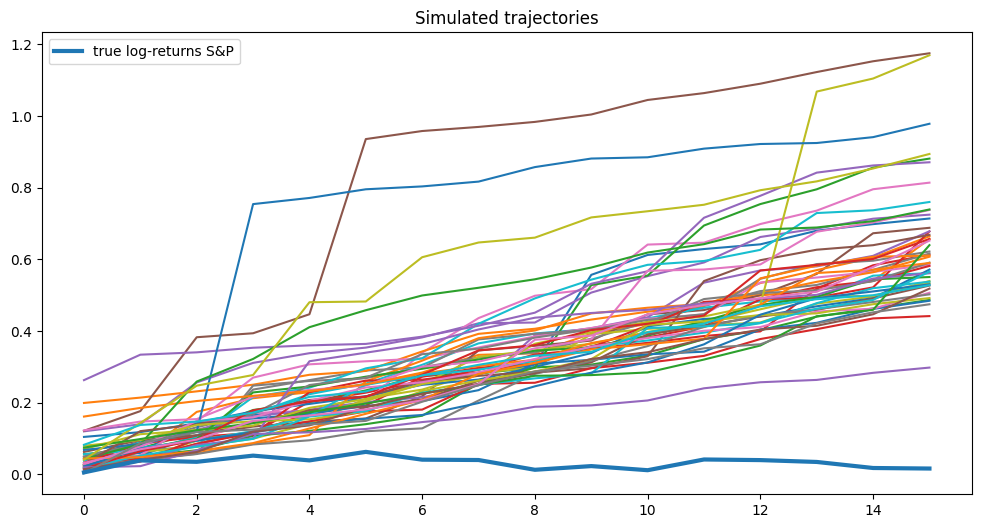

In [75]:
plt.figure(figsize=(12,6))
plt.plot(generate_snp_trajectory()[:16])
plt.plot(list(log_returns.cumsum()[:16]),linewidth=3,label='true log-returns S&P')
plt.title('Simulated trajectories')
plt.legend()
plt.show()

## Let's try to increase the batch size

  0%|                                                    | 0/40 [00:00<?, ?it/s]

Generator loss = -0.5008668899536133, Discriminator loss = -3.337860107421875e-06
Generator loss = -0.4991120994091034, Discriminator loss = -0.0011453032493591309
Generator loss = -0.5020424127578735, Discriminator loss = 4.553794860839844e-05
Generator loss = -0.5020363330841064, Discriminator loss = -3.045797348022461e-05
Generator loss = -0.501994788646698, Discriminator loss = -3.910064697265625e-05
Generator loss = -0.5018484592437744, Discriminator loss = -3.0040740966796875e-05
Generator loss = -0.501812219619751, Discriminator loss = -1.5616416931152344e-05
Generator loss = -0.501825749874115, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.5018680095672607, Discriminator loss = 8.52346420288086e-06
Generator loss = -0.5018680095672607, Discriminator loss = 6.67572021484375e-06


  2%|█                                           | 1/40 [01:01<40:11, 61.82s/it]

Generator loss = -0.5018362998962402, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5017215013504028, Discriminator loss = -8.046627044677734e-06
Generator loss = -0.5014025568962097, Discriminator loss = -1.519918441772461e-05
Generator loss = -0.5012927055358887, Discriminator loss = -9.775161743164062e-06
Generator loss = -0.5013903975486755, Discriminator loss = 4.708766937255859e-06
Generator loss = -0.5017749667167664, Discriminator loss = 6.9141387939453125e-06
Generator loss = -0.5019229650497437, Discriminator loss = 2.4437904357910156e-06
Generator loss = -0.5019679069519043, Discriminator loss = -2.562999725341797e-06
Generator loss = -0.5019580721855164, Discriminator loss = -8.702278137207031e-06
Generator loss = -0.501916766166687, Discriminator loss = -1.239776611328125e-05


  5%|██▏                                         | 2/40 [02:06<40:15, 63.57s/it]

Generator loss = -0.5019233822822571, Discriminator loss = -2.86102294921875e-06
Generator loss = -0.5019813179969788, Discriminator loss = 5.125999450683594e-06
Generator loss = -0.5021909475326538, Discriminator loss = 4.231929779052734e-06
Generator loss = -0.5021744966506958, Discriminator loss = 7.748603820800781e-07
Generator loss = -0.5020946264266968, Discriminator loss = -3.159046173095703e-06
Generator loss = -0.5018428564071655, Discriminator loss = -8.881092071533203e-06
Generator loss = -0.5016352534294128, Discriminator loss = -9.775161743164062e-06
Generator loss = -0.5018661022186279, Discriminator loss = 3.993511199951172e-06
Generator loss = -0.5021610260009766, Discriminator loss = 4.0531158447265625e-06
Generator loss = -0.5022566318511963, Discriminator loss = 2.384185791015625e-07


  8%|███▎                                        | 3/40 [03:12<39:44, 64.45s/it]

Generator loss = -0.5021925568580627, Discriminator loss = -4.0531158447265625e-06
Generator loss = -0.5021460056304932, Discriminator loss = -9.417533874511719e-06
Generator loss = -0.5021303296089172, Discriminator loss = -4.291534423828125e-06
Generator loss = -0.5021913647651672, Discriminator loss = 3.7550926208496094e-06
Generator loss = -0.5022474527359009, Discriminator loss = 2.562999725341797e-06
Generator loss = -0.5022217035293579, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5020890235900879, Discriminator loss = -3.6954879760742188e-06
Generator loss = -0.5018109679222107, Discriminator loss = -9.715557098388672e-06
Generator loss = -0.5018606781959534, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5021927952766418, Discriminator loss = 3.039836883544922e-06


 10%|████▍                                       | 4/40 [04:29<41:42, 69.50s/it]

Generator loss = -0.5022929906845093, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.502269446849823, Discriminator loss = -3.4570693969726562e-06
Generator loss = -0.5021530985832214, Discriminator loss = -8.046627044677734e-06
Generator loss = -0.5021750330924988, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5023050904273987, Discriminator loss = 2.8014183044433594e-06
Generator loss = -0.50230872631073, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5021774172782898, Discriminator loss = -2.5033950805664062e-06
Generator loss = -0.5012175440788269, Discriminator loss = -1.055002212524414e-05
Generator loss = -0.5014548897743225, Discriminator loss = 2.5033950805664062e-06
Generator loss = -0.5018246173858643, Discriminator loss = 9.5367431640625e-07


 12%|█████▌                                      | 5/40 [05:48<42:29, 72.84s/it]

Generator loss = -0.5018665194511414, Discriminator loss = -8.940696716308594e-07
Generator loss = -0.5017743706703186, Discriminator loss = -4.231929779052734e-06
Generator loss = -0.5016893744468689, Discriminator loss = -4.291534423828125e-06
Generator loss = -0.5020328760147095, Discriminator loss = 2.1457672119140625e-06
Generator loss = -0.50213623046875, Discriminator loss = 5.960464477539062e-07
Generator loss = -0.5020959377288818, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.5018782019615173, Discriminator loss = -4.887580871582031e-06
Generator loss = -0.5016306042671204, Discriminator loss = -1.9073486328125e-06
Generator loss = -0.502067506313324, Discriminator loss = 8.940696716308594e-07
Generator loss = -0.5021352767944336, Discriminator loss = -8.344650268554688e-07


 15%|██████▌                                     | 6/40 [07:10<43:07, 76.12s/it]

Generator loss = -0.5018301606178284, Discriminator loss = -5.602836608886719e-06
Generator loss = -0.5017563104629517, Discriminator loss = -1.9073486328125e-06
Generator loss = -0.5018876791000366, Discriminator loss = 1.5497207641601562e-06
Generator loss = -0.5019024014472961, Discriminator loss = 0.0
Generator loss = -0.5017472505569458, Discriminator loss = -2.384185791015625e-06
Generator loss = -0.5007562041282654, Discriminator loss = -1.5020370483398438e-05
Generator loss = -0.5017672777175903, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.49959519505500793, Discriminator loss = -3.781914710998535e-05
Generator loss = -0.4984239339828491, Discriminator loss = -3.331899642944336e-05
Generator loss = -0.49814537167549133, Discriminator loss = -2.4139881134033203e-06


 18%|███████▋                                    | 7/40 [08:28<42:15, 76.83s/it]

Generator loss = -0.49971702694892883, Discriminator loss = -8.96751880645752e-05
Generator loss = -0.4995860457420349, Discriminator loss = 1.2516975402832031e-06
Generator loss = -0.5002919435501099, Discriminator loss = 2.205371856689453e-06
Generator loss = -0.5002867579460144, Discriminator loss = -1.6510486602783203e-05
Generator loss = -0.5002247095108032, Discriminator loss = -4.5239925384521484e-05
Generator loss = -0.5003231763839722, Discriminator loss = 5.0067901611328125e-06
Generator loss = -0.5003273487091064, Discriminator loss = 4.0531158447265625e-06
Generator loss = -0.5003287196159363, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.500262439250946, Discriminator loss = -6.079673767089844e-06
Generator loss = -0.4992997944355011, Discriminator loss = -2.7805566787719727e-05


 20%|████████▊                                   | 8/40 [09:45<40:55, 76.75s/it]

Generator loss = -0.5000379085540771, Discriminator loss = 5.364418029785156e-06
Generator loss = -0.5001983642578125, Discriminator loss = 1.3709068298339844e-06
Generator loss = -0.5002360343933105, Discriminator loss = -1.1920928955078125e-06
Generator loss = -0.5001713037490845, Discriminator loss = -6.973743438720703e-06
Generator loss = -0.5000136494636536, Discriminator loss = -1.5020370483398438e-05
Generator loss = -0.500173807144165, Discriminator loss = 4.231929779052734e-06
Generator loss = -0.5002272129058838, Discriminator loss = 1.3113021850585938e-06
Generator loss = -0.5001784563064575, Discriminator loss = -5.960464477539062e-07
Generator loss = -0.49997538328170776, Discriminator loss = -4.708766937255859e-06
Generator loss = -0.4991116225719452, Discriminator loss = -1.4632940292358398e-05


 22%|█████████▉                                  | 9/40 [10:55<38:32, 74.61s/it]

Generator loss = -0.5002528429031372, Discriminator loss = 3.337860107421875e-06
Generator loss = -0.5002523064613342, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5001125931739807, Discriminator loss = -5.0067901611328125e-06
Generator loss = -0.5006452798843384, Discriminator loss = -1.7315149307250977e-05
Generator loss = -0.5005731582641602, Discriminator loss = 3.5762786865234375e-06
Generator loss = -0.5005528926849365, Discriminator loss = 1.0728836059570312e-06
Generator loss = -0.5005267858505249, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.5005019903182983, Discriminator loss = -4.947185516357422e-06
Generator loss = -0.5004264712333679, Discriminator loss = -9.298324584960938e-06
Generator loss = -0.5003841519355774, Discriminator loss = 2.4437904357910156e-06


 25%|██████████▊                                | 10/40 [12:07<36:51, 73.72s/it]

Generator loss = -0.5004597306251526, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5005093812942505, Discriminator loss = -5.125999450683594e-06
Generator loss = -0.5006742477416992, Discriminator loss = -1.1205673217773438e-05
Generator loss = -0.5007402896881104, Discriminator loss = 2.2649765014648438e-06
Generator loss = -0.5005086660385132, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5002195239067078, Discriminator loss = -3.2186508178710938e-06
Generator loss = -0.4997652471065521, Discriminator loss = -1.2040138244628906e-05
Generator loss = -0.5005699396133423, Discriminator loss = 2.086162567138672e-06
Generator loss = -0.5007864236831665, Discriminator loss = 0.0
Generator loss = -0.5010989904403687, Discriminator loss = -2.86102294921875e-06


 28%|███████████▊                               | 11/40 [13:19<35:27, 73.35s/it]

Generator loss = -0.5010818839073181, Discriminator loss = -9.298324584960938e-06
Generator loss = -0.5006946921348572, Discriminator loss = 2.0265579223632812e-06
Generator loss = -0.500472366809845, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5002678632736206, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.49976491928100586, Discriminator loss = -7.12275505065918e-06
Generator loss = -0.5001400113105774, Discriminator loss = 1.4901161193847656e-06
Generator loss = -0.5004321932792664, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5005265474319458, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5007784366607666, Discriminator loss = -2.3245811462402344e-06
Generator loss = -0.5006299018859863, Discriminator loss = -3.4570693969726562e-06


 30%|████████████▉                              | 12/40 [14:23<32:55, 70.57s/it]

Generator loss = -0.5002639889717102, Discriminator loss = 1.0132789611816406e-06
Generator loss = -0.5000805258750916, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.49980950355529785, Discriminator loss = -2.3245811462402344e-06
Generator loss = -0.4992658495903015, Discriminator loss = -7.927417755126953e-06
Generator loss = -0.5000510811805725, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5001267790794373, Discriminator loss = -2.205371856689453e-06
Generator loss = -0.5001608729362488, Discriminator loss = -1.9490718841552734e-05
Generator loss = -0.5000064373016357, Discriminator loss = 1.8477439880371094e-06
Generator loss = -0.4999215602874756, Discriminator loss = 0.0
Generator loss = -0.4997085928916931, Discriminator loss = -2.205371856689453e-06


 32%|█████████████▉                             | 13/40 [15:14<28:59, 64.42s/it]

Generator loss = -0.4993061125278473, Discriminator loss = -7.957220077514648e-06
Generator loss = -0.5000532865524292, Discriminator loss = 1.1920928955078125e-06
Generator loss = -0.5002630352973938, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5002483129501343, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.5003221035003662, Discriminator loss = -4.0531158447265625e-06
Generator loss = -0.5004257559776306, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5003421306610107, Discriminator loss = 5.364418029785156e-07
Generator loss = -0.5004725456237793, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002749562263489, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.4995924234390259, Discriminator loss = -7.18235969543457e-06


 35%|███████████████                            | 14/40 [16:03<25:56, 59.86s/it]

Generator loss = -0.5003783106803894, Discriminator loss = 6.556510925292969e-07
Generator loss = -0.5004633665084839, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002844929695129, Discriminator loss = -2.0265579223632812e-06
Generator loss = -0.5002233982086182, Discriminator loss = -7.271766662597656e-06
Generator loss = -0.500474750995636, Discriminator loss = 6.556510925292969e-07
Generator loss = -0.5005042552947998, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5003073215484619, Discriminator loss = -5.602836608886719e-06
Generator loss = -0.5002034902572632, Discriminator loss = -1.7285346984863281e-06
Generator loss = -0.5006769299507141, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5007154941558838, Discriminator loss = -8.344650268554688e-07


 38%|████████████████▏                          | 15/40 [16:52<23:38, 56.75s/it]

Generator loss = -0.5000100135803223, Discriminator loss = -1.3828277587890625e-05
Generator loss = -0.49991291761398315, Discriminator loss = 1.1026859283447266e-06
Generator loss = -0.4999258816242218, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.5000237226486206, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.49989715218544006, Discriminator loss = -6.020069122314453e-06
Generator loss = -0.4999590814113617, Discriminator loss = 9.834766387939453e-07
Generator loss = -0.49994543194770813, Discriminator loss = 2.682209014892578e-07
Generator loss = -0.49997761845588684, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5001651644706726, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.50052410364151, Discriminator loss = -2.384185791015625e-06


 40%|█████████████████▏                         | 16/40 [17:42<21:49, 54.58s/it]

Generator loss = -0.5001683831214905, Discriminator loss = 5.960464477539062e-07
Generator loss = -0.5000154376029968, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.4999401867389679, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.4996851682662964, Discriminator loss = -1.6689300537109375e-06
Generator loss = -0.49970266222953796, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.4999496340751648, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5000064373016357, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5001286268234253, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5005958676338196, Discriminator loss = -2.384185791015625e-06
Generator loss = -0.5001423954963684, Discriminator loss = 2.384185791015625e-07


 42%|██████████████████▎                        | 17/40 [18:35<20:46, 54.21s/it]

Generator loss = -0.5000864863395691, Discriminator loss = 0.0
Generator loss = -0.5000236630439758, Discriminator loss = -8.940696716308594e-07
Generator loss = -0.49982553720474243, Discriminator loss = -4.231929779052734e-06
Generator loss = -0.49994176626205444, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49938544631004333, Discriminator loss = -1.5348196029663086e-05
Generator loss = -0.5001233816146851, Discriminator loss = 8.344650268554688e-07
Generator loss = -0.5003215074539185, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5000452399253845, Discriminator loss = -1.2516975402832031e-06
Generator loss = -0.5001207590103149, Discriminator loss = -2.9206275939941406e-06
Generator loss = -0.5001454949378967, Discriminator loss = 4.76837158203125e-07


 45%|███████████████████▎                       | 18/40 [19:26<19:26, 53.04s/it]

Generator loss = -0.500157356262207, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.500140905380249, Discriminator loss = 0.0
Generator loss = -0.5001099109649658, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5001115202903748, Discriminator loss = -1.7881393432617188e-06
Generator loss = -0.5000982880592346, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.5001221299171448, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.500152587890625, Discriminator loss = 0.0
Generator loss = -0.5001559853553772, Discriminator loss = 0.0
Generator loss = -0.5001012086868286, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.5001144409179688, Discriminator loss = 1.1920928955078125e-07


 48%|████████████████████▍                      | 19/40 [20:17<18:23, 52.55s/it]

Generator loss = -0.5001581907272339, Discriminator loss = 0.0
Generator loss = -0.5001452565193176, Discriminator loss = 0.0
Generator loss = -0.5000775456428528, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.49990028142929077, Discriminator loss = -9.834766387939453e-07
Generator loss = -0.49994799494743347, Discriminator loss = 1.4901161193847656e-07
Generator loss = -0.5000997185707092, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5001572370529175, Discriminator loss = 0.0
Generator loss = -0.5001727938652039, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5001870393753052, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.5001843571662903, Discriminator loss = 1.1920928955078125e-07


 50%|█████████████████████▌                     | 20/40 [21:09<17:26, 52.32s/it]

Generator loss = -0.5001692771911621, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5001529455184937, Discriminator loss = 0.0
Generator loss = -0.500053882598877, Discriminator loss = 0.0
Generator loss = -0.49954643845558167, Discriminator loss = -1.043081283569336e-06
Generator loss = -0.5000855326652527, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5001443028450012, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5001078248023987, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.5001383423805237, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5001834034919739, Discriminator loss = 0.0
Generator loss = -0.5001003742218018, Discriminator loss = -1.7881393432617188e-07


 52%|██████████████████████▌                    | 21/40 [22:00<16:24, 51.83s/it]

Generator loss = -0.5001651048660278, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.50001460313797, Discriminator loss = 0.0
Generator loss = -0.49988850951194763, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.4997794032096863, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.5000298619270325, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5002771615982056, Discriminator loss = -1.537799835205078e-05
Generator loss = -0.4999540448188782, Discriminator loss = -7.0035457611083984e-06
Generator loss = -0.5017778277397156, Discriminator loss = -7.62641429901123e-05
Generator loss = -0.5030122995376587, Discriminator loss = 1.2516975402832031e-06
Generator loss = -0.5021796226501465, Discriminator loss = -1.6629695892333984e-05


 55%|███████████████████████▋                   | 22/40 [22:52<15:37, 52.10s/it]

Generator loss = -0.501681923866272, Discriminator loss = -2.771615982055664e-05
Generator loss = -0.5016316771507263, Discriminator loss = -4.947185516357422e-06
Generator loss = -0.5019606351852417, Discriminator loss = 4.589557647705078e-06
Generator loss = -0.5023561120033264, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5032113790512085, Discriminator loss = -8.463859558105469e-06
Generator loss = -0.5027332901954651, Discriminator loss = -2.205371856689453e-05
Generator loss = -0.500819981098175, Discriminator loss = 4.827976226806641e-06
Generator loss = -0.5001726150512695, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.49991142749786377, Discriminator loss = -2.175569534301758e-06
Generator loss = -0.49979496002197266, Discriminator loss = -1.0609626770019531e-05


 57%|████████████████████████▋                  | 23/40 [23:42<14:34, 51.44s/it]

Generator loss = -0.49985814094543457, Discriminator loss = -5.125999450683594e-06
Generator loss = -0.49986642599105835, Discriminator loss = 3.635883331298828e-06
Generator loss = -0.49996519088745117, Discriminator loss = 5.066394805908203e-07
Generator loss = -0.5002888441085815, Discriminator loss = -1.7285346984863281e-06
Generator loss = -0.5012068748474121, Discriminator loss = -1.0192394256591797e-05
Generator loss = -0.501602828502655, Discriminator loss = -2.3245811462402344e-06
Generator loss = -0.5001807808876038, Discriminator loss = 2.2649765014648438e-06
Generator loss = -0.49982091784477234, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.4997446835041046, Discriminator loss = -3.3974647521972656e-06
Generator loss = -0.49978846311569214, Discriminator loss = -1.4841556549072266e-05


 60%|█████████████████████████▊                 | 24/40 [24:32<13:34, 50.92s/it]

Generator loss = -0.49975454807281494, Discriminator loss = 2.8908252716064453e-06
Generator loss = -0.4997301697731018, Discriminator loss = 1.1622905731201172e-06
Generator loss = -0.4998055398464203, Discriminator loss = -2.086162567138672e-07
Generator loss = -0.500090479850769, Discriminator loss = -2.5033950805664062e-06
Generator loss = -0.5005240440368652, Discriminator loss = -7.748603820800781e-06
Generator loss = -0.5002811551094055, Discriminator loss = 1.7881393432617188e-06
Generator loss = -0.49989089369773865, Discriminator loss = 9.238719940185547e-07
Generator loss = -0.4998059570789337, Discriminator loss = -2.086162567138672e-07
Generator loss = -0.499777615070343, Discriminator loss = -1.6987323760986328e-06
Generator loss = -0.4998866617679596, Discriminator loss = -6.4373016357421875e-06


 62%|██████████████████████████▉                | 25/40 [25:22<12:38, 50.57s/it]

Generator loss = -0.49983564019203186, Discriminator loss = 1.4603137969970703e-06
Generator loss = -0.499758780002594, Discriminator loss = 6.258487701416016e-07
Generator loss = -0.49980926513671875, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5000160336494446, Discriminator loss = -1.7285346984863281e-06
Generator loss = -0.5004026293754578, Discriminator loss = -4.470348358154297e-06
Generator loss = -0.500002384185791, Discriminator loss = 1.1324882507324219e-06
Generator loss = -0.49979349970817566, Discriminator loss = 2.086162567138672e-07
Generator loss = -0.49975770711898804, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.4998301863670349, Discriminator loss = -1.5497207641601562e-06
Generator loss = -0.49994856119155884, Discriminator loss = -3.635883331298828e-06


 65%|███████████████████████████▉               | 26/40 [26:10<11:40, 50.01s/it]

Generator loss = -0.49972003698349, Discriminator loss = 8.344650268554688e-07
Generator loss = -0.49970465898513794, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4998423755168915, Discriminator loss = -3.8743019104003906e-07
Generator loss = -0.5003490447998047, Discriminator loss = -4.649162292480469e-06
Generator loss = -0.49992603063583374, Discriminator loss = 8.642673492431641e-07
Generator loss = -0.49964258074760437, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.49960723519325256, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.499720960855484, Discriminator loss = -7.748603820800781e-07
Generator loss = -0.5000174045562744, Discriminator loss = -3.2186508178710938e-06
Generator loss = -0.4997234344482422, Discriminator loss = 5.364418029785156e-07


 68%|█████████████████████████████              | 27/40 [27:01<10:51, 50.14s/it]

Generator loss = -0.4997495114803314, Discriminator loss = 0.0
Generator loss = -0.49992629885673523, Discriminator loss = -5.960464477539062e-07
Generator loss = -0.5005987286567688, Discriminator loss = -5.364418029785156e-06
Generator loss = -0.49977055191993713, Discriminator loss = 5.066394805908203e-07
Generator loss = -0.499714195728302, Discriminator loss = 0.0
Generator loss = -0.5001751184463501, Discriminator loss = -1.9073486328125e-06
Generator loss = -0.5004752278327942, Discriminator loss = -2.9206275939941406e-06
Generator loss = -0.4995187819004059, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4995310306549072, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.4999663233757019, Discriminator loss = -9.5367431640625e-06


 70%|██████████████████████████████             | 28/40 [28:12<11:16, 56.39s/it]

Generator loss = -0.4995858371257782, Discriminator loss = 6.556510925292969e-07
Generator loss = -0.4995368719100952, Discriminator loss = 0.0
Generator loss = -0.49954867362976074, Discriminator loss = -2.2649765014648438e-06
Generator loss = -0.4998086392879486, Discriminator loss = -3.725290298461914e-06
Generator loss = -0.4995240271091461, Discriminator loss = 3.2782554626464844e-07
Generator loss = -0.4994148313999176, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.4990521967411041, Discriminator loss = -4.887580871582031e-06
Generator loss = -0.4990585148334503, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.4994177520275116, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.49939724802970886, Discriminator loss = -1.4901161193847656e-07


 72%|███████████████████████████████▏           | 29/40 [29:12<10:34, 57.69s/it]

Generator loss = -0.4991874098777771, Discriminator loss = -3.039836883544922e-06
Generator loss = -0.4997541010379791, Discriminator loss = -3.159046173095703e-06
Generator loss = -0.500173807144165, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5001415014266968, Discriminator loss = -1.4901161193847656e-06
Generator loss = -0.49980783462524414, Discriminator loss = -1.6570091247558594e-05
Generator loss = -0.5001264810562134, Discriminator loss = 1.0132789611816406e-06
Generator loss = -0.5001993775367737, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5005150437355042, Discriminator loss = -6.139278411865234e-06
Generator loss = -0.5004771947860718, Discriminator loss = -2.384185791015625e-06
Generator loss = -0.49983295798301697, Discriminator loss = 5.662441253662109e-07


 75%|████████████████████████████████▎          | 30/40 [30:07<09:28, 56.86s/it]

Generator loss = -0.4997735023498535, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49984320998191833, Discriminator loss = -2.86102294921875e-06
Generator loss = -0.5000603199005127, Discriminator loss = -6.198883056640625e-06
Generator loss = -0.4997841417789459, Discriminator loss = 5.364418029785156e-07
Generator loss = -0.49991345405578613, Discriminator loss = -6.556510925292969e-07
Generator loss = -0.5006169080734253, Discriminator loss = -1.0251998901367188e-05
Generator loss = -0.500160813331604, Discriminator loss = 1.0132789611816406e-06
Generator loss = -0.4995676875114441, Discriminator loss = 3.8743019104003906e-07
Generator loss = -0.49933817982673645, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.49919572472572327, Discriminator loss = -1.1026859283447266e-06


 78%|█████████████████████████████████▎         | 31/40 [31:00<08:21, 55.68s/it]

Generator loss = -0.49887633323669434, Discriminator loss = -6.258487701416016e-06
Generator loss = -0.4991397261619568, Discriminator loss = 8.642673492431641e-07
Generator loss = -0.4991942346096039, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.4993059039115906, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.4993301331996918, Discriminator loss = -3.3080577850341797e-06
Generator loss = -0.4992833435535431, Discriminator loss = -8.642673492431641e-07
Generator loss = -0.499316930770874, Discriminator loss = 3.2782554626464844e-07
Generator loss = -0.49931010603904724, Discriminator loss = 0.0
Generator loss = -0.49923262000083923, Discriminator loss = -3.8743019104003906e-07
Generator loss = -0.4989493787288666, Discriminator loss = -5.513429641723633e-06


 80%|██████████████████████████████████▍        | 32/40 [31:52<07:15, 54.47s/it]

Generator loss = -0.49860647320747375, Discriminator loss = 6.258487701416016e-07
Generator loss = -0.49859267473220825, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.49863550066947937, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.49874168634414673, Discriminator loss = -1.519918441772461e-06
Generator loss = -0.4988187849521637, Discriminator loss = -2.0265579223632812e-06
Generator loss = -0.49859240651130676, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.49839600920677185, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.4984930455684662, Discriminator loss = -3.1888484954833984e-06
Generator loss = -0.4979785084724426, Discriminator loss = -9.834766387939453e-07
Generator loss = -0.49849364161491394, Discriminator loss = 2.9802322387695312e-08


 82%|███████████████████████████████████▍       | 33/40 [32:45<06:17, 53.95s/it]

Generator loss = -0.49848586320877075, Discriminator loss = -6.556510925292969e-07
Generator loss = -0.49882927536964417, Discriminator loss = -1.3709068298339844e-05
Generator loss = -0.4993506968021393, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.4995288550853729, Discriminator loss = -7.0035457611083984e-06
Generator loss = -0.499738484621048, Discriminator loss = -6.556510925292969e-06
Generator loss = -0.4993424713611603, Discriminator loss = 6.556510925292969e-07
Generator loss = -0.49933329224586487, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.49945083260536194, Discriminator loss = -2.8312206268310547e-06
Generator loss = -0.4993026554584503, Discriminator loss = -6.765127182006836e-06
Generator loss = -0.49954238533973694, Discriminator loss = 6.258487701416016e-07


 85%|████████████████████████████████████▌      | 34/40 [33:34<05:15, 52.59s/it]

Generator loss = -0.49960392713546753, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.49999088048934937, Discriminator loss = -3.904104232788086e-06
Generator loss = -0.5005627274513245, Discriminator loss = -6.139278411865234e-06
Generator loss = -0.4997256398200989, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.49961674213409424, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.4993619918823242, Discriminator loss = -3.248453140258789e-06
Generator loss = -0.49863749742507935, Discriminator loss = -9.08970832824707e-06
Generator loss = -0.4996393620967865, Discriminator loss = 3.2782554626464844e-07
Generator loss = -0.4997960031032562, Discriminator loss = -8.642673492431641e-07
Generator loss = -0.5005191564559937, Discriminator loss = -1.823902130126953e-05


 88%|█████████████████████████████████████▋     | 35/40 [34:24<04:18, 51.70s/it]

Generator loss = -0.5002646446228027, Discriminator loss = 2.205371856689453e-06
Generator loss = -0.49980852007865906, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.49966344237327576, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.4990634620189667, Discriminator loss = -2.1457672119140625e-06
Generator loss = -0.49884742498397827, Discriminator loss = -5.692243576049805e-06
Generator loss = -0.4994312822818756, Discriminator loss = 1.0132789611816406e-06
Generator loss = -0.49979692697525024, Discriminator loss = 2.086162567138672e-07
Generator loss = -0.5000101923942566, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.500476598739624, Discriminator loss = -1.7881393432617188e-06
Generator loss = -0.5011605620384216, Discriminator loss = -3.4570693969726562e-06


 90%|██████████████████████████████████████▋    | 36/40 [35:13<03:23, 50.83s/it]

Generator loss = -0.5000688433647156, Discriminator loss = 5.960464477539062e-07
Generator loss = -0.49971914291381836, Discriminator loss = 0.0
Generator loss = -0.49924400448799133, Discriminator loss = -8.642673492431641e-07
Generator loss = -0.4981575906276703, Discriminator loss = -8.761882781982422e-06
Generator loss = -0.4997570216655731, Discriminator loss = 3.2782554626464844e-07
Generator loss = -0.5003547668457031, Discriminator loss = -5.960464477539062e-07
Generator loss = -0.5019415616989136, Discriminator loss = -1.1086463928222656e-05
Generator loss = -0.5010422468185425, Discriminator loss = 1.3709068298339844e-06
Generator loss = -0.500403106212616, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5001990795135498, Discriminator loss = -1.1920928955078125e-07


 92%|███████████████████████████████████████▊   | 37/40 [36:02<02:31, 50.35s/it]

Generator loss = -0.4999993145465851, Discriminator loss = -1.1920928955078125e-06
Generator loss = -0.49952232837677, Discriminator loss = -4.1425228118896484e-06
Generator loss = -0.4999973475933075, Discriminator loss = 7.450580596923828e-07
Generator loss = -0.5001892447471619, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5002461075782776, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5006041526794434, Discriminator loss = -1.2516975402832031e-06
Generator loss = -0.5008677840232849, Discriminator loss = -1.7285346984863281e-06
Generator loss = -0.5004150867462158, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5002379417419434, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5000496506690979, Discriminator loss = -1.1920928955078125e-07


 95%|████████████████████████████████████████▊  | 38/40 [36:54<01:41, 50.77s/it]

Generator loss = -0.49939730763435364, Discriminator loss = -1.996755599975586e-06
Generator loss = -0.4995175004005432, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.4999932050704956, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.5001145601272583, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5002076029777527, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.500454843044281, Discriminator loss = -1.0728836059570312e-06
Generator loss = -0.5003207921981812, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5001642107963562, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5001009106636047, Discriminator loss = 0.0
Generator loss = -0.5000002980232239, Discriminator loss = -5.960464477539063e-08


 98%|█████████████████████████████████████████▉ | 39/40 [37:46<00:51, 51.29s/it]

Generator loss = -0.4996456801891327, Discriminator loss = -8.046627044677734e-07
Generator loss = -0.49960824847221375, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.5000455379486084, Discriminator loss = 0.0
Generator loss = -0.5001159310340881, Discriminator loss = 0.0
Generator loss = -0.5001678466796875, Discriminator loss = 0.0
Generator loss = -0.5003364682197571, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.500063955783844, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.49991726875305176, Discriminator loss = 8.940696716308594e-08
Generator loss = -0.4998827278614044, Discriminator loss = 0.0
Generator loss = -0.49985694885253906, Discriminator loss = 0.0


100%|███████████████████████████████████████████| 40/40 [38:36<00:00, 57.91s/it]


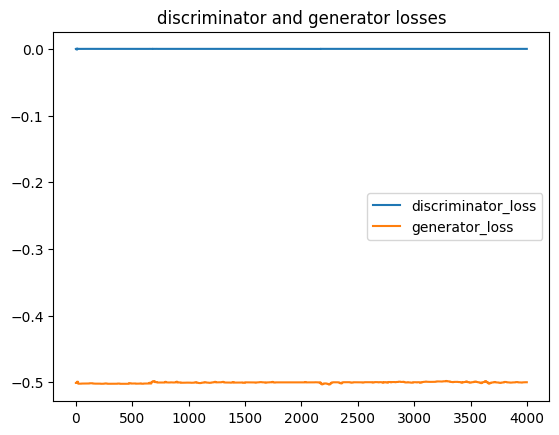

In [76]:
losses,gen =train_GAN(
            learning_rate = 0.0005,
            num_epochs = 40,
            N_z = N_z, # as set in paper
            n_in_epoch=100,
            batch_size = 100,
            update_gen = 10, # update gen every n step 
            val_clip = 0.01
                )
losses_df = pd.DataFrame(data=losses,columns=['discriminator_loss','generator_loss'])
plt.plot(losses_df['discriminator_loss'],label = 'discriminator_loss')
plt.plot(losses_df['generator_loss'],label='generator_loss')
plt.legend()
plt.title('discriminator and generator losses')
plt.show()

In [77]:
noise = torch.randn(1, len(log_returns_normalized), N_z, device=device)
generated_snp_gaus = gen(noise).detach().reshape(len(log_returns_normalized)).numpy()


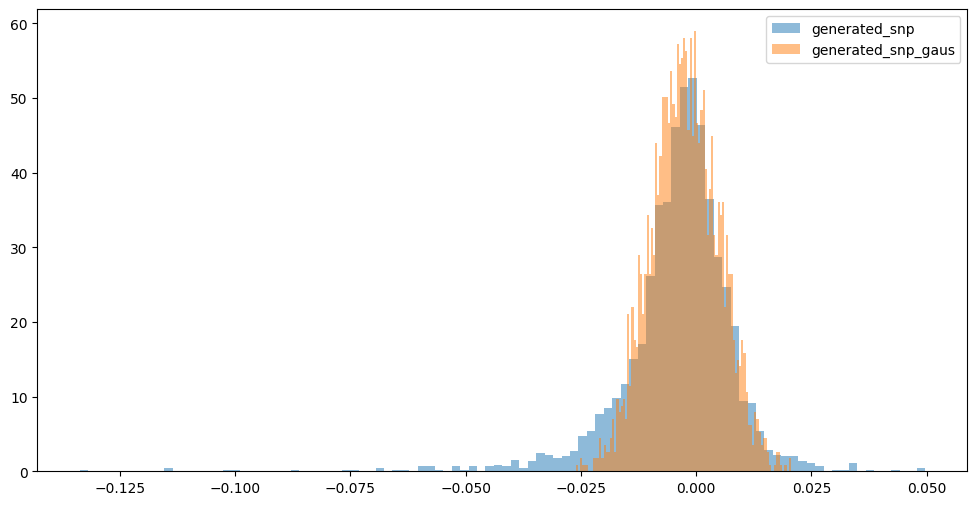

In [78]:
generated_snp = gaus.inverse_transform(np.array([[g] for g in generated_snp_gaus]) ).reshape(-1)
plt.figure(figsize=(12,6))
plt.hist(generated_snp,bins=100,density=True,label='generated_snp',alpha=0.5)
plt.hist(generated_snp_gaus,bins=100,density=True,label='generated_snp_gaus',alpha=0.5)
plt.legend()
plt.show()


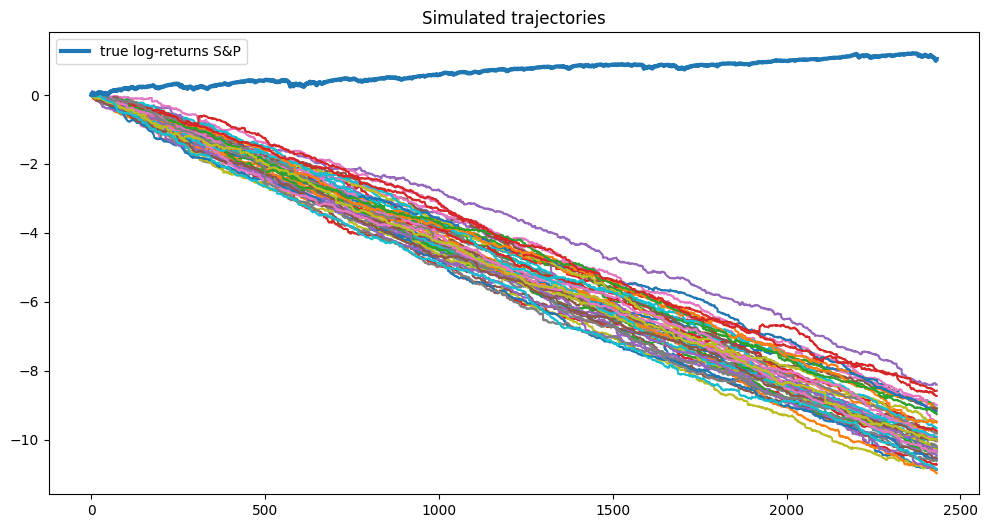

In [79]:
def generate_snp_trajectory(n_generate = 50):
    sim_df = []
    for tr in range(1,n_generate+1):
        noise = torch.randn(1, len(log_returns_normalized), N_z, device=device)
        generated_snp_gaus = gen(noise).detach().reshape(len(log_returns_normalized)).numpy()
        generated_snp = gaus.inverse_transform(np.array([[g] for g in generated_snp_gaus]) ).reshape(-1)
        sim_df.append(generated_snp)
    return pd.DataFrame(data=np.array(sim_df).T,columns=[f'tr {t}' for t in range(1,n_generate+1)] ).cumsum()

plt.figure(figsize=(12,6))
plt.plot(generate_snp_trajectory())
plt.plot(list(log_returns.cumsum()),linewidth=3,label='true log-returns S&P')
plt.title('Simulated trajectories')
plt.legend()
plt.show()


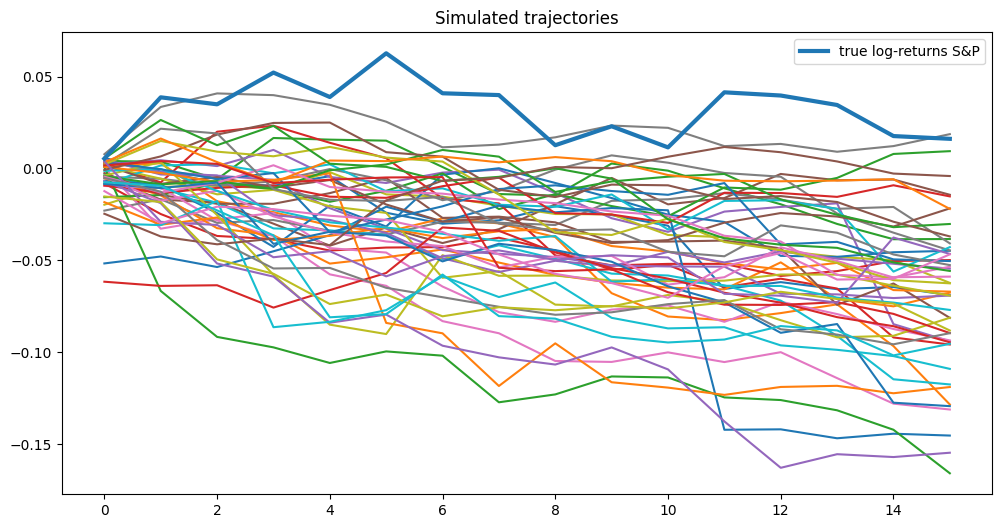

In [80]:
plt.figure(figsize=(12,6))
plt.plot(generate_snp_trajectory()[:16])
plt.plot(list(log_returns.cumsum()[:16]),linewidth=3,label='true log-returns S&P')
plt.title('Simulated trajectories')
plt.legend()
plt.show()

Increase in batch size really led to more deversified generated paths. But now we systematically underestimate true returns.

## Let's try to increase learning rate (up to 0.001) while keeping high batch_size(=100) 

  0%|                                                    | 0/40 [00:00<?, ?it/s]

Generator loss = -0.49752122163772583, Discriminator loss = -3.314018249511719e-05
Generator loss = -0.5031983852386475, Discriminator loss = -0.0007360875606536865
Generator loss = -0.5029352903366089, Discriminator loss = -0.00010031461715698242
Generator loss = -0.5035375952720642, Discriminator loss = 6.020069122314453e-06
Generator loss = -0.503821074962616, Discriminator loss = -2.0444393157958984e-05
Generator loss = -0.5037708282470703, Discriminator loss = 6.258487701416016e-06
Generator loss = -0.50350022315979, Discriminator loss = -1.8477439880371094e-06
Generator loss = -0.5029478073120117, Discriminator loss = -1.5079975128173828e-05
Generator loss = -0.5032108426094055, Discriminator loss = 4.76837158203125e-06
Generator loss = -0.5033227801322937, Discriminator loss = -1.7881393432617188e-06
Generator loss = -0.5030977129936218, Discriminator loss = -9.417533874511719e-06
Generator loss = -0.5031050443649292, Discriminator loss = 5.960464477539063e-08
Generator loss = -

  2%|█                                           | 1/40 [00:56<36:43, 56.50s/it]

Generator loss = -0.5027946829795837, Discriminator loss = 1.5497207641601562e-06
Generator loss = -0.5026045441627502, Discriminator loss = -5.602836608886719e-06
Generator loss = -0.5025264620780945, Discriminator loss = -4.76837158203125e-06
Generator loss = -0.5026353001594543, Discriminator loss = 3.993511199951172e-06
Generator loss = -0.5028303861618042, Discriminator loss = -2.0265579223632812e-06
Generator loss = -0.5030370950698853, Discriminator loss = -5.4836273193359375e-06
Generator loss = -0.5030598640441895, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5028833746910095, Discriminator loss = 3.159046173095703e-06
Generator loss = -0.5026711821556091, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.502384603023529, Discriminator loss = -6.258487701416016e-06
Generator loss = -0.5023549795150757, Discriminator loss = -8.940696716308594e-07
Generator loss = -0.5024685263633728, Discriminator loss = 2.6226043701171875e-06
Generator loss = -0

  5%|██▏                                         | 2/40 [01:58<37:58, 59.97s/it]

Generator loss = -0.5027035474777222, Discriminator loss = -4.0531158447265625e-06
Generator loss = -0.5028062462806702, Discriminator loss = -1.8477439880371094e-06
Generator loss = -0.5027297735214233, Discriminator loss = 2.205371856689453e-06
Generator loss = -0.5029914975166321, Discriminator loss = 8.940696716308594e-07
Generator loss = -0.50284343957901, Discriminator loss = -3.993511199951172e-06
Generator loss = -0.5026248097419739, Discriminator loss = -2.682209014892578e-06
Generator loss = -0.5031507611274719, Discriminator loss = 2.4437904357910156e-06
Generator loss = -0.5033678412437439, Discriminator loss = -2.1457672119140625e-06
Generator loss = -0.5034376978874207, Discriminator loss = -3.3974647521972656e-06
Generator loss = -0.5034298300743103, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5033165812492371, Discriminator loss = 2.0265579223632812e-06
Generator loss = -0.5031387805938721, Discriminator loss = -1.2516975402832031e-06
Generator loss =

  8%|███▎                                        | 3/40 [03:02<38:07, 61.82s/it]

Generator loss = -0.5029181241989136, Discriminator loss = -1.3113021850585938e-06
Generator loss = -0.5029749274253845, Discriminator loss = 1.430511474609375e-06
Generator loss = -0.5031328201293945, Discriminator loss = -2.1457672119140625e-06
Generator loss = -0.5033149123191833, Discriminator loss = -2.384185791015625e-06
Generator loss = -0.5032263994216919, Discriminator loss = 9.5367431640625e-07
Generator loss = -0.5030887722969055, Discriminator loss = 1.2516975402832031e-06
Generator loss = -0.5029484629631042, Discriminator loss = -1.6689300537109375e-06
Generator loss = -0.5028979778289795, Discriminator loss = -3.4570693969726562e-06
Generator loss = -0.5029165148735046, Discriminator loss = 1.6689300537109375e-06
Generator loss = -0.5031390190124512, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.5032840967178345, Discriminator loss = -2.4437904357910156e-06
Generator loss = -0.5033461451530457, Discriminator loss = -2.384185791015625e-07
Generator loss 

 10%|████▍                                       | 4/40 [04:05<37:22, 62.30s/it]

Generator loss = -0.5030010342597961, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.5028961896896362, Discriminator loss = -1.3709068298339844e-06
Generator loss = -0.5029021501541138, Discriminator loss = -2.4437904357910156e-06
Generator loss = -0.5029016733169556, Discriminator loss = 1.2516975402832031e-06
Generator loss = -0.5030270218849182, Discriminator loss = -6.556510925292969e-07
Generator loss = -0.5031947493553162, Discriminator loss = -1.6093254089355469e-06
Generator loss = -0.5032690763473511, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5030561089515686, Discriminator loss = 1.0132789611816406e-06
Generator loss = -0.5028852224349976, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5028451681137085, Discriminator loss = -2.086162567138672e-06
Generator loss = -0.502757728099823, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5027682781219482, Discriminator loss = 5.364418029785156e-07
Generator loss =

 12%|█████▌                                      | 5/40 [05:09<36:39, 62.85s/it]

Generator loss = -0.5019602179527283, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.5021238327026367, Discriminator loss = -1.1920928955078125e-06
Generator loss = -0.5020952224731445, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5018588304519653, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.5018879175186157, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5018694400787354, Discriminator loss = -1.2516975402832031e-06
Generator loss = -0.5018510222434998, Discriminator loss = -1.0728836059570312e-06
Generator loss = -0.5018541812896729, Discriminator loss = 5.364418029785156e-07
Generator loss = -0.5019774436950684, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.5022310614585876, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.5023534297943115, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5022265911102295, Discriminator loss = 5.960464477539062e-07
Generator loss = 

 15%|██████▌                                     | 6/40 [06:14<35:58, 63.47s/it]

Generator loss = -0.5023042559623718, Discriminator loss = 4.172325134277344e-07
Generator loss = -0.5020918846130371, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5020103454589844, Discriminator loss = 0.0
Generator loss = -0.5020744800567627, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.5022051334381104, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.5019861459732056, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5020760893821716, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.50237637758255, Discriminator loss = -5.960464477539062e-07
Generator loss = -0.5027382969856262, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.5023124814033508, Discriminator loss = 5.364418029785156e-07
Generator loss = -0.5020620226860046, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5020398497581482, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5020627975463867, Dis

 18%|███████▋                                    | 7/40 [07:19<35:16, 64.12s/it]

Generator loss = -0.5022166967391968, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5022719502449036, Discriminator loss = -1.7881393432617188e-06
Generator loss = -0.5016830563545227, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5019070506095886, Discriminator loss = -1.0132789611816406e-06
Generator loss = -0.5025628209114075, Discriminator loss = -4.887580871582031e-06
Generator loss = -0.5021834373474121, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5012988448143005, Discriminator loss = -3.165006637573242e-05
Generator loss = -0.5024450421333313, Discriminator loss = -1.2516975402832031e-06
Generator loss = -0.5018793940544128, Discriminator loss = -4.214048385620117e-05
Generator loss = -0.5027326941490173, Discriminator loss = 2.980232238769531e-07
Generator loss = -0.5031293630599976, Discriminator loss = -9.953975677490234e-06
Generator loss = -0.5023794770240784, Discriminator loss = -3.713369369506836e-05
Generator loss

 20%|████████▊                                   | 8/40 [08:26<34:38, 64.97s/it]

Generator loss = -0.5008618235588074, Discriminator loss = -1.6689300537109375e-06
Generator loss = -0.5007812976837158, Discriminator loss = 1.5497207641601562e-06
Generator loss = -0.5006937980651855, Discriminator loss = 6.556510925292969e-07
Generator loss = -0.5006381273269653, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5005907416343689, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.500531017780304, Discriminator loss = -9.5367431640625e-07
Generator loss = -0.500465452671051, Discriminator loss = -2.562999725341797e-06
Generator loss = -0.5004718899726868, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5005347728729248, Discriminator loss = 1.1324882507324219e-06
Generator loss = -0.5005850791931152, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.5006215572357178, Discriminator loss = 0.0
Generator loss = -0.5005055069923401, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.5005500912666321,

 22%|█████████▉                                  | 9/40 [09:34<33:58, 65.75s/it]

Generator loss = -0.5002164840698242, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.5002248883247375, Discriminator loss = -1.6093254089355469e-06
Generator loss = -0.5002272725105286, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5002841949462891, Discriminator loss = 5.960464477539062e-07
Generator loss = -0.5003278851509094, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5002874135971069, Discriminator loss = 0.0
Generator loss = -0.5002990365028381, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5003014802932739, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5002995729446411, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.5003206729888916, Discriminator loss = -1.4901161193847656e-06
Generator loss = -0.5003228783607483, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.500311017036438, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.50030916929245

 25%|██████████▊                                | 10/40 [10:39<32:50, 65.69s/it]

Generator loss = -0.500454306602478, Discriminator loss = 0.0
Generator loss = -0.5004349946975708, Discriminator loss = 0.0
Generator loss = -0.5003876686096191, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.5002812743186951, Discriminator loss = -8.344650268554688e-07
Generator loss = -0.5002694129943848, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.500386118888855, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.5004420876502991, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5004627704620361, Discriminator loss = 0.0
Generator loss = -0.5004653930664062, Discriminator loss = 0.0
Generator loss = -0.500449001789093, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5005233287811279, Discriminator loss = -6.556510925292969e-07
Generator loss = -0.5006529092788696, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.5005571842193604, Discriminator loss = 0.0
Generator loss = -0.5005437731742

 28%|███████████▊                               | 11/40 [11:45<31:45, 65.69s/it]

Generator loss = -0.5005086064338684, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5004399418830872, Discriminator loss = 0.0
Generator loss = -0.5004868507385254, Discriminator loss = 0.0
Generator loss = -0.5004180073738098, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.500542163848877, Discriminator loss = 0.0
Generator loss = -0.5005510449409485, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5004148483276367, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5002756714820862, Discriminator loss = 0.0
Generator loss = -0.5002078413963318, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.500167727470398, Discriminator loss = 0.0
Generator loss = -0.4999738931655884, Discriminator loss = 0.0
Generator loss = -0.4998904764652252, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.499785840511322, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.49990734457969666, Discriminator 

 30%|████████████▉                              | 12/40 [12:51<30:38, 65.68s/it]

Generator loss = -0.5003618597984314, Discriminator loss = 0.0
Generator loss = -0.5002485513687134, Discriminator loss = 0.0
Generator loss = -0.5001981854438782, Discriminator loss = 0.0
Generator loss = -0.5001504421234131, Discriminator loss = 0.0
Generator loss = -0.50007164478302, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5001032948493958, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5001803040504456, Discriminator loss = 0.0
Generator loss = -0.5002277493476868, Discriminator loss = 0.0
Generator loss = -0.5002923011779785, Discriminator loss = 0.0
Generator loss = -0.5004369020462036, Discriminator loss = 0.0
Generator loss = -0.5006919503211975, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5004762411117554, Discriminator loss = 0.0
Generator loss = -0.5002962946891785, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5002243518829346, Discriminator loss = 0.0
Generator loss = -0.500182032585144, Discrimin

 32%|█████████████▉                             | 13/40 [13:46<28:06, 62.47s/it]

Generator loss = -0.5006114840507507, Discriminator loss = 0.0
Generator loss = -0.5008558630943298, Discriminator loss = 0.0
Generator loss = -0.5013070702552795, Discriminator loss = 0.0
Generator loss = -0.5012149214744568, Discriminator loss = 0.0
Generator loss = -0.5011706948280334, Discriminator loss = 0.0
Generator loss = -0.5011236071586609, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.501225471496582, Discriminator loss = 0.0
Generator loss = -0.5013924837112427, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.502291202545166, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.5022045969963074, Discriminator loss = 0.0
Generator loss = -0.5006970167160034, Discriminator loss = -1.609325408935547e-05
Generator loss = -0.5025175213813782, Discriminator loss = -2.2649765014648438e-06
Generator loss = -0.4962204396724701, Discriminator loss = -0.00013643503189086914
Generator loss = -0.49694228172302246, Discriminator loss = 4.79817

 35%|███████████████                            | 14/40 [14:37<25:39, 59.21s/it]

Generator loss = -0.4981919825077057, Discriminator loss = -5.9604644775390625e-06
Generator loss = -0.4981754720211029, Discriminator loss = -1.6391277313232422e-06
Generator loss = -0.4977436661720276, Discriminator loss = 2.473592758178711e-06
Generator loss = -0.4973105788230896, Discriminator loss = -7.450580596923828e-07
Generator loss = -0.49671801924705505, Discriminator loss = -3.874301910400391e-06
Generator loss = -0.49645742774009705, Discriminator loss = -2.2351741790771484e-06
Generator loss = -0.4970340132713318, Discriminator loss = 2.205371856689453e-06
Generator loss = -0.4974869191646576, Discriminator loss = 9.238719940185547e-07
Generator loss = -0.49785247445106506, Discriminator loss = -7.450580596923828e-07
Generator loss = -0.4979822039604187, Discriminator loss = -3.2186508178710938e-06
Generator loss = -0.4981234669685364, Discriminator loss = -2.682209014892578e-06
Generator loss = -0.49763917922973633, Discriminator loss = 2.1457672119140625e-06
Generator l

 38%|████████████████▏                          | 15/40 [15:31<23:56, 57.47s/it]

Generator loss = -0.49770382046699524, Discriminator loss = -2.9802322387695312e-06
Generator loss = -0.4974944591522217, Discriminator loss = 1.4603137969970703e-06
Generator loss = -0.4973445236682892, Discriminator loss = 6.556510925292969e-07
Generator loss = -0.49718958139419556, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.4969201683998108, Discriminator loss = -1.1920928955078125e-06
Generator loss = -0.4969112277030945, Discriminator loss = -2.4437904357910156e-06
Generator loss = -0.49703648686408997, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.49723121523857117, Discriminator loss = 9.5367431640625e-07
Generator loss = -0.4974499046802521, Discriminator loss = 3.2782554626464844e-07
Generator loss = -0.4975143373012543, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.49766066670417786, Discriminator loss = -1.1324882507324219e-06
Generator loss = -0.4979396164417267, Discriminator loss = -2.3543834686279297e-06
Generator l

 40%|█████████████████▏                         | 16/40 [16:23<22:22, 55.96s/it]

Generator loss = -0.4976659417152405, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.49773305654525757, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.4977973401546478, Discriminator loss = -1.1920928955078125e-06
Generator loss = -0.4978840947151184, Discriminator loss = -1.6093254089355469e-06
Generator loss = -0.49754106998443604, Discriminator loss = 8.344650268554688e-07
Generator loss = -0.49741730093955994, Discriminator loss = 8.940696716308594e-08
Generator loss = -0.49734756350517273, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.497265100479126, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.49697554111480713, Discriminator loss = -1.6093254089355469e-06
Generator loss = -0.49693727493286133, Discriminator loss = 2.682209014892578e-07
Generator loss = -0.4972139000892639, Discriminator loss = 3.8743019104003906e-07
Generator loss = -0.4973377585411072, Discriminator loss = 2.9802322387695312e-08
Generator l

 42%|██████████████████▎                        | 17/40 [17:21<21:41, 56.59s/it]

Generator loss = -0.49748289585113525, Discriminator loss = -1.1622905731201172e-06
Generator loss = -0.4976392090320587, Discriminator loss = 4.470348358154297e-07
Generator loss = -0.4977354109287262, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.4978707730770111, Discriminator loss = 0.0
Generator loss = -0.49783211946487427, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.49775660037994385, Discriminator loss = -5.662441253662109e-07
Generator loss = -0.4976169466972351, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.4976084530353546, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.49765071272850037, Discriminator loss = 0.0
Generator loss = -0.4976283311843872, Discriminator loss = 0.0
Generator loss = -0.49753859639167786, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49724847078323364, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.4971645474433899, Discriminator loss = -1.19209

 45%|███████████████████▎                       | 18/40 [18:19<20:51, 56.90s/it]

Generator loss = -0.4976726174354553, Discriminator loss = 0.0
Generator loss = -0.498149037361145, Discriminator loss = 0.0
Generator loss = -0.4980035126209259, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.49786362051963806, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.49791914224624634, Discriminator loss = 2.086162567138672e-07
Generator loss = -0.4981904625892639, Discriminator loss = 0.0
Generator loss = -0.49837976694107056, Discriminator loss = 0.0
Generator loss = -0.4983556866645813, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.4984637498855591, Discriminator loss = -3.2782554626464844e-07
Generator loss = -0.49853408336639404, Discriminator loss = 0.0
Generator loss = -0.49847859144210815, Discriminator loss = 0.0
Generator loss = -0.4985954761505127, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.49833914637565613, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.49878907203674316, Dis

 48%|████████████████████▍                      | 19/40 [19:13<19:40, 56.21s/it]

Generator loss = -0.4988960325717926, Discriminator loss = 0.0
Generator loss = -0.49893122911453247, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.4988838732242584, Discriminator loss = -4.32133674621582e-06
Generator loss = -0.4982239007949829, Discriminator loss = -1.868605613708496e-05
Generator loss = -0.49827539920806885, Discriminator loss = -1.4483928680419922e-05
Generator loss = -0.49778297543525696, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.498676061630249, Discriminator loss = -1.576542854309082e-05
Generator loss = -0.4993968904018402, Discriminator loss = -1.9848346710205078e-05
Generator loss = -0.49954208731651306, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.49936988949775696, Discriminator loss = -1.138448715209961e-05
Generator loss = -0.4994013011455536, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.49935320019721985, Discriminator loss = -1.2040138244628906e-05
Generator loss = -0.49937

 50%|█████████████████████▌                     | 20/40 [20:07<18:30, 55.54s/it]

Generator loss = -0.49892956018447876, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.4988654851913452, Discriminator loss = -4.470348358154297e-07
Generator loss = -0.4985541105270386, Discriminator loss = -7.152557373046875e-07
Generator loss = -0.4984908401966095, Discriminator loss = -4.470348358154297e-07
Generator loss = -0.4986027479171753, Discriminator loss = 3.8743019104003906e-07
Generator loss = -0.4987385869026184, Discriminator loss = 1.4901161193847656e-07
Generator loss = -0.498818039894104, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4988515377044678, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49885183572769165, Discriminator loss = 0.0
Generator loss = -0.4988214075565338, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.49887630343437195, Discriminator loss = -4.172325134277344e-07
Generator loss = -0.4989754557609558, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.498976677656

 52%|██████████████████████▌                    | 21/40 [21:01<17:22, 54.88s/it]

Generator loss = -0.49790093302726746, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.498047798871994, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.49815115332603455, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49832412600517273, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.49835023283958435, Discriminator loss = 0.0
Generator loss = -0.49884968996047974, Discriminator loss = 0.0
Generator loss = -0.4989902973175049, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.4990299344062805, Discriminator loss = -3.2782554626464844e-07
Generator loss = -0.4990386366844177, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49789512157440186, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.49799036979675293, Discriminator loss = 0.0
Generator loss = -0.4979751408100128, Discriminator loss = 0.0
Generator loss = -0.4979364573955536, Discriminator loss = 0.0
Generator loss = -0.4978

 55%|███████████████████████▋                   | 22/40 [21:53<16:12, 54.01s/it]

Generator loss = -0.497819721698761, Discriminator loss = 0.0
Generator loss = -0.497937947511673, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.4980234205722809, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.4978121221065521, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.4977721571922302, Discriminator loss = 0.0
Generator loss = -0.49762099981307983, Discriminator loss = 0.0
Generator loss = -0.49756690859794617, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.4973979890346527, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.4973612129688263, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49751952290534973, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.49759581685066223, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4976310431957245, Discriminator loss = 0.0
Generator loss = -0.497528612613678, Discriminator loss = 0.0
Generator loss = -0.4975968

 57%|████████████████████████▋                  | 23/40 [22:48<15:25, 54.46s/it]

Generator loss = -0.4979012608528137, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.497887521982193, Discriminator loss = 0.0
Generator loss = -0.4981139302253723, Discriminator loss = 0.0
Generator loss = -0.49805164337158203, Discriminator loss = 0.0
Generator loss = -0.49809643626213074, Discriminator loss = 0.0
Generator loss = -0.4982256591320038, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4985344707965851, Discriminator loss = -3.5762786865234375e-07
Generator loss = -0.49793899059295654, Discriminator loss = 0.0
Generator loss = -0.49788349866867065, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4978923499584198, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.49779751896858215, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.4980493485927582, Discriminator loss = 0.0
Generator loss = -0.4981020390987396, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4991234838962555, D

 60%|█████████████████████████▊                 | 24/40 [23:51<15:09, 56.87s/it]

Generator loss = -0.49987053871154785, Discriminator loss = -2.5212764739990234e-05
Generator loss = -0.4994775354862213, Discriminator loss = 6.556510925292969e-07
Generator loss = -0.4994816184043884, Discriminator loss = -2.9206275939941406e-06
Generator loss = -0.4995023310184479, Discriminator loss = 2.086162567138672e-07
Generator loss = -0.49956634640693665, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.49949511885643005, Discriminator loss = -4.470348358154297e-07
Generator loss = -0.49949344992637634, Discriminator loss = -2.115964889526367e-06
Generator loss = -0.49959999322891235, Discriminator loss = 7.152557373046875e-07
Generator loss = -0.49970605969429016, Discriminator loss = 1.4901161193847656e-07
Generator loss = -0.4997484087944031, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.4997534453868866, Discriminator loss = -5.364418029785156e-07
Generator loss = -0.4997313320636749, Discriminator loss = -1.1920928955078125e-06
Generator l

 62%|██████████████████████████▉                | 25/40 [24:45<14:02, 56.14s/it]

Generator loss = -0.49976015090942383, Discriminator loss = 0.0
Generator loss = -0.49976155161857605, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.49974754452705383, Discriminator loss = -4.470348358154297e-07
Generator loss = -0.4997396767139435, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.4997633695602417, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.4997696876525879, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49976155161857605, Discriminator loss = 0.0
Generator loss = -0.4997377097606659, Discriminator loss = 0.0
Generator loss = -0.4996834099292755, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.4999803900718689, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.49992644786834717, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5000423789024353, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5001273155212402, Discriminator loss = 1.1920928

 65%|███████████████████████████▉               | 26/40 [25:51<13:45, 58.95s/it]

Generator loss = -0.5003997087478638, Discriminator loss = 0.0
Generator loss = -0.5003923773765564, Discriminator loss = 0.0
Generator loss = -0.5003914833068848, Discriminator loss = 0.0
Generator loss = -0.5004004836082458, Discriminator loss = 0.0
Generator loss = -0.5004346966743469, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5004547834396362, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5004009008407593, Discriminator loss = 1.1920928955078125e-07
Generator loss = -0.5003933310508728, Discriminator loss = 0.0
Generator loss = -0.5004051327705383, Discriminator loss = 0.0
Generator loss = -0.5004459023475647, Discriminator loss = 0.0
Generator loss = -0.5005793571472168, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.500758707523346, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.5002725124359131, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.4999341666698456, Discriminator loss = 0.0
Gen

 68%|█████████████████████████████              | 27/40 [26:50<12:49, 59.17s/it]

Generator loss = -0.49948158860206604, Discriminator loss = 0.0
Generator loss = -0.49955347180366516, Discriminator loss = 0.0
Generator loss = -0.4996856451034546, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49973422288894653, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.49957185983657837, Discriminator loss = 0.0
Generator loss = -0.49948060512542725, Discriminator loss = 0.0
Generator loss = -0.4994458854198456, Discriminator loss = 0.0
Generator loss = -0.4994286596775055, Discriminator loss = 0.0
Generator loss = -0.4994136691093445, Discriminator loss = 0.0
Generator loss = -0.4993991553783417, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.4994055926799774, Discriminator loss = 0.0
Generator loss = -0.4994249939918518, Discriminator loss = 0.0
Generator loss = -0.49944359064102173, Discriminator loss = 0.0
Generator loss = -0.49947312474250793, Discriminator loss = 0.0
Generator loss = -0.4992828369140625, Discriminator 

 70%|██████████████████████████████             | 28/40 [27:45<11:33, 57.82s/it]

Generator loss = -0.49891048669815063, Discriminator loss = 0.0
Generator loss = -0.4989047944545746, Discriminator loss = 0.0
Generator loss = -0.4989064037799835, Discriminator loss = 0.0
Generator loss = -0.4989166259765625, Discriminator loss = 0.0
Generator loss = -0.4984256625175476, Discriminator loss = 0.0
Generator loss = -0.4984763562679291, Discriminator loss = 0.0
Generator loss = -0.4986266493797302, Discriminator loss = 0.0
Generator loss = -0.4987773001194, Discriminator loss = -8.940696716308594e-08
Generator loss = -0.4984602928161621, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4984093904495239, Discriminator loss = 0.0
Generator loss = -0.4983941316604614, Discriminator loss = 0.0
Generator loss = -0.49837037920951843, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49840596318244934, Discriminator loss = 0.0
Generator loss = -0.4984431564807892, Discriminator loss = 0.0
Generator loss = -0.4986317455768585, Discriminator loss = 0

 72%|███████████████████████████████▏           | 29/40 [28:44<10:40, 58.21s/it]

Generator loss = -0.4990111291408539, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.4984876215457916, Discriminator loss = -1.0460615158081055e-05
Generator loss = -0.49896126985549927, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.49897387623786926, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.49886754155158997, Discriminator loss = -3.606081008911133e-06
Generator loss = -0.49871882796287537, Discriminator loss = -4.798173904418945e-06
Generator loss = -0.4990297555923462, Discriminator loss = 3.2782554626464844e-07
Generator loss = -0.4991675019264221, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.49901771545410156, Discriminator loss = -1.0699033737182617e-05
Generator loss = -0.4990822672843933, Discriminator loss = 1.2516975402832031e-06
Generator loss = -0.4991513192653656, Discriminator loss = 4.470348358154297e-07
Generator loss = -0.4991757273674011, Discriminator loss = 2.9802322387695312e-08
Generator los

 75%|████████████████████████████████▎          | 30/40 [29:43<09:42, 58.24s/it]

Generator loss = -0.4992292523384094, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.4992363154888153, Discriminator loss = -3.2782554626464844e-07
Generator loss = -0.499250203371048, Discriminator loss = -4.76837158203125e-07
Generator loss = -0.49936985969543457, Discriminator loss = -4.470348358154297e-07
Generator loss = -0.4993661642074585, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.4993581473827362, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.49935421347618103, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.499353289604187, Discriminator loss = 0.0
Generator loss = -0.4993535876274109, Discriminator loss = 0.0
Generator loss = -0.49935516715049744, Discriminator loss = 0.0
Generator loss = -0.499358206987381, Discriminator loss = 0.0
Generator loss = -0.49936434626579285, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.49936556816101074, Discriminator loss = -4.172325134277344e-07
Generat

 78%|█████████████████████████████████▎         | 31/40 [30:41<08:43, 58.18s/it]

Generator loss = -0.49926188588142395, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.4990902245044708, Discriminator loss = -1.7881393432617188e-07
Generator loss = -0.499004602432251, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.49901053309440613, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.49902451038360596, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.499116986989975, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.49929141998291016, Discriminator loss = 0.0
Generator loss = -0.4992932081222534, Discriminator loss = 0.0
Generator loss = -0.4992939233779907, Discriminator loss = 0.0
Generator loss = -0.49929356575012207, Discriminator loss = 0.0
Generator loss = -0.49929094314575195, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.49928203225135803, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.49936220049858093, Discriminator loss = -2.9802322387695312e-08


 80%|██████████████████████████████████▍        | 32/40 [31:39<07:46, 58.36s/it]

Generator loss = -0.4993628263473511, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.4993229806423187, Discriminator loss = 1.4901161193847656e-07
Generator loss = -0.4992932677268982, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4992828071117401, Discriminator loss = 0.0
Generator loss = -0.4992790222167969, Discriminator loss = 0.0
Generator loss = -0.49927660822868347, Discriminator loss = 0.0
Generator loss = -0.49927234649658203, Discriminator loss = 0.0
Generator loss = -0.49926143884658813, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.499493271112442, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.49950650334358215, Discriminator loss = 8.940696716308594e-08
Generator loss = -0.4995231628417969, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.4995289742946625, Discriminator loss = 0.0
Generator loss = -0.49952930212020874, Discriminator loss = 0.0
Generator loss = -0.49952495098114014, Discri

 82%|███████████████████████████████████▍       | 33/40 [32:39<06:51, 58.85s/it]

Generator loss = -0.49953171610832214, Discriminator loss = 0.0
Generator loss = -0.49953144788742065, Discriminator loss = 0.0
Generator loss = -0.49953049421310425, Discriminator loss = 0.0
Generator loss = -0.4995277523994446, Discriminator loss = 0.0
Generator loss = -0.4995216727256775, Discriminator loss = 0.0
Generator loss = -0.49951082468032837, Discriminator loss = -8.940696716308594e-08
Generator loss = -0.4995046854019165, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49951624870300293, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.4995264708995819, Discriminator loss = 0.0
Generator loss = -0.4995307922363281, Discriminator loss = 0.0
Generator loss = -0.4995322525501251, Discriminator loss = 0.0
Generator loss = -0.49953266978263855, Discriminator loss = 0.0
Generator loss = -0.49953359365463257, Discriminator loss = 0.0
Generator loss = -0.49953481554985046, Discriminator loss = 0.0
Generator loss = -0.49953699111938477, Discriminator

 85%|████████████████████████████████████▌      | 34/40 [33:40<05:55, 59.31s/it]

Generator loss = -0.49951931834220886, Discriminator loss = 0.0
Generator loss = -0.4994945824146271, Discriminator loss = 0.0
Generator loss = -0.49924251437187195, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.4992890954017639, Discriminator loss = 0.0
Generator loss = -0.49931809306144714, Discriminator loss = 0.0
Generator loss = -0.49932587146759033, Discriminator loss = 0.0
Generator loss = -0.49932679533958435, Discriminator loss = 0.0
Generator loss = -0.49932414293289185, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.49931570887565613, Discriminator loss = 0.0
Generator loss = -0.4993046820163727, Discriminator loss = 0.0
Generator loss = -0.49932461977005005, Discriminator loss = 0.0
Generator loss = -0.49932587146759033, Discriminator loss = 0.0
Generator loss = -0.49931710958480835, Discriminator loss = 0.0
Generator loss = -0.49927425384521484, Discriminator loss = 0.0
Generator loss = -0.4991462826728821, Discriminator loss = -1.4901161

 88%|█████████████████████████████████████▋     | 35/40 [34:40<04:58, 59.62s/it]

Generator loss = -0.5002232789993286, Discriminator loss = -2.205371856689453e-06
Generator loss = -0.5003169775009155, Discriminator loss = -1.4901161193847656e-05
Generator loss = -0.500264585018158, Discriminator loss = 1.7881393432617188e-07
Generator loss = -0.500387966632843, Discriminator loss = -2.4437904357910156e-06
Generator loss = -0.5004161596298218, Discriminator loss = -2.384185791015625e-07
Generator loss = -0.500282347202301, Discriminator loss = 3.5762786865234375e-07
Generator loss = -0.5002550482749939, Discriminator loss = 0.0
Generator loss = -0.5002573728561401, Discriminator loss = -2.980232238769531e-07
Generator loss = -0.500278651714325, Discriminator loss = -1.2516975402832031e-06
Generator loss = -0.5003079771995544, Discriminator loss = -1.7881393432617188e-06
Generator loss = -0.5002511143684387, Discriminator loss = 4.76837158203125e-07
Generator loss = -0.5002418160438538, Discriminator loss = 0.0
Generator loss = -0.500231146812439, Discriminator loss 

 90%|██████████████████████████████████████▋    | 36/40 [35:40<03:59, 59.84s/it]

Generator loss = -0.49994632601737976, Discriminator loss = -2.682209014892578e-07
Generator loss = -0.4999347925186157, Discriminator loss = -1.4901161193847656e-07
Generator loss = -0.49992993474006653, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.49995413422584534, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.4999837279319763, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.5000019073486328, Discriminator loss = 0.0
Generator loss = -0.5000134706497192, Discriminator loss = 0.0
Generator loss = -0.5000247359275818, Discriminator loss = 0.0
Generator loss = -0.5000419616699219, Discriminator loss = 0.0
Generator loss = -0.5000715255737305, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5000811219215393, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5000739693641663, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5000491142272949, Discriminator loss = 0.0
Generator loss = -0.5000

 92%|███████████████████████████████████████▊   | 37/40 [36:37<02:56, 58.98s/it]

Generator loss = -0.4999348819255829, Discriminator loss = -2.9802322387695312e-08
Generator loss = -0.4999561607837677, Discriminator loss = 1.4901161193847656e-07
Generator loss = -0.4999852478504181, Discriminator loss = 0.0
Generator loss = -0.5000023245811462, Discriminator loss = 2.9802322387695312e-08
Generator loss = -0.5000114440917969, Discriminator loss = 0.0
Generator loss = -0.5000190734863281, Discriminator loss = 0.0
Generator loss = -0.5000292658805847, Discriminator loss = 0.0
Generator loss = -0.5000504851341248, Discriminator loss = 0.0
Generator loss = -0.5000841021537781, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5000824332237244, Discriminator loss = 0.0
Generator loss = -0.5000476837158203, Discriminator loss = 0.0
Generator loss = -0.5000274181365967, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5000186562538147, Discriminator loss = 0.0
Generator loss = -0.5000143051147461, Discriminator loss = 0.0
Generator loss = -0.50

 95%|████████████████████████████████████████▊  | 38/40 [37:35<01:57, 58.64s/it]

Generator loss = -0.5000077486038208, Discriminator loss = 0.0
Generator loss = -0.5000132918357849, Discriminator loss = 0.0
Generator loss = -0.5000200271606445, Discriminator loss = 0.0
Generator loss = -0.5000372529029846, Discriminator loss = 0.0
Generator loss = -0.5000929832458496, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5001135468482971, Discriminator loss = 0.0
Generator loss = -0.5000320076942444, Discriminator loss = 0.0
Generator loss = -0.5000181794166565, Discriminator loss = 0.0
Generator loss = -0.5000175833702087, Discriminator loss = 0.0
Generator loss = -0.5000272393226624, Discriminator loss = 0.0
Generator loss = -0.5000652074813843, Discriminator loss = -1.1920928955078125e-07
Generator loss = -0.5000651478767395, Discriminator loss = 0.0
Generator loss = -0.5000181198120117, Discriminator loss = 0.0
Generator loss = -0.5000129342079163, Discriminator loss = -5.960464477539063e-08
Generator loss = -0.5000155568122864, Discriminator loss = 

 98%|█████████████████████████████████████████▉ | 39/40 [38:34<00:58, 58.72s/it]

Generator loss = -0.500016987323761, Discriminator loss = 0.0
Generator loss = -0.5000199675559998, Discriminator loss = 0.0
Generator loss = -0.5000199675559998, Discriminator loss = 5.960464477539063e-08
Generator loss = -0.5000162124633789, Discriminator loss = 0.0
Generator loss = -0.5000153183937073, Discriminator loss = 0.0
Generator loss = -0.5000161528587341, Discriminator loss = 0.0
Generator loss = -0.5000203251838684, Discriminator loss = 0.0
Generator loss = -0.500034511089325, Discriminator loss = 0.0
Generator loss = -0.5000544190406799, Discriminator loss = 0.0
Generator loss = -0.5000219941139221, Discriminator loss = 0.0
Generator loss = -0.5000161528587341, Discriminator loss = 0.0
Generator loss = -0.5000171661376953, Discriminator loss = 0.0
Generator loss = -0.500023603439331, Discriminator loss = 0.0
Generator loss = -0.5000491142272949, Discriminator loss = 0.0
Generator loss = -0.5001010298728943, Discriminator loss = 0.0
Generator loss = -0.5000177621841431, Di

100%|███████████████████████████████████████████| 40/40 [39:32<00:00, 59.32s/it]


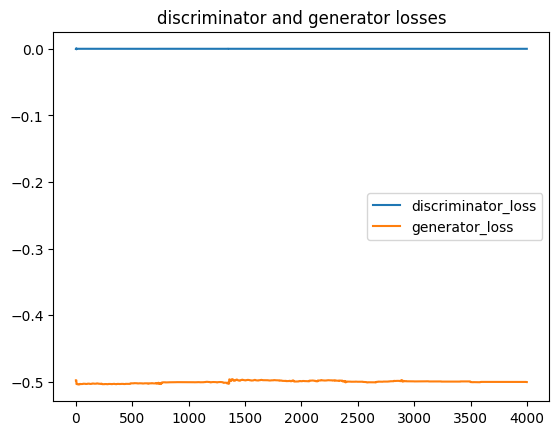

In [86]:
losses,gen =train_GAN(
            learning_rate = 0.001,
            num_epochs = 40,
            N_z = N_z, # as set in paper
            n_in_epoch=100,
            batch_size = 100,
            update_gen = 5, # update gen every n step 
            val_clip = 0.01
                )
losses_df = pd.DataFrame(data=losses,columns=['discriminator_loss','generator_loss'])
plt.plot(losses_df['discriminator_loss'],label = 'discriminator_loss')
plt.plot(losses_df['generator_loss'],label='generator_loss')
plt.legend()
plt.title('discriminator and generator losses')
plt.show()

In [87]:
noise = torch.randn(1, len(log_returns_normalized), N_z, device=device)
generated_snp_gaus = gen(noise).detach().reshape(len(log_returns_normalized)).numpy()


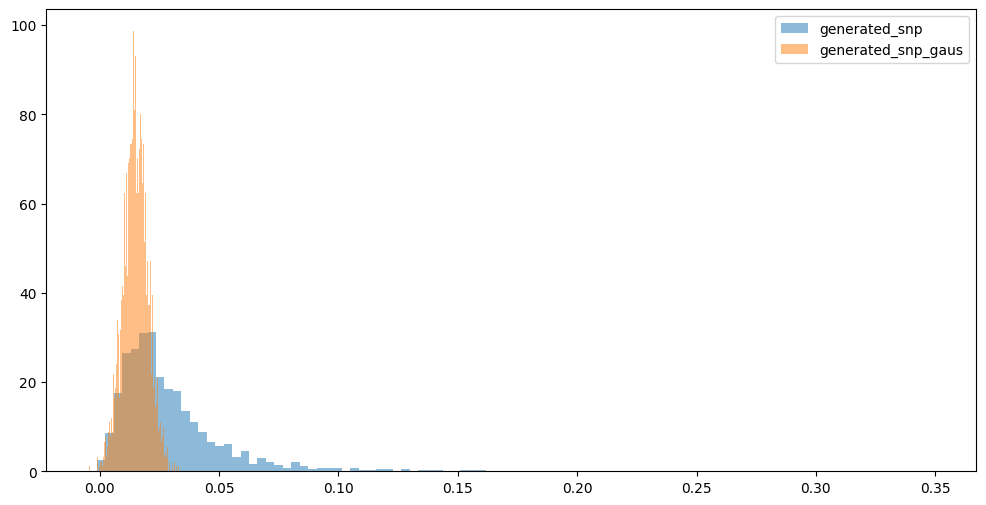

In [88]:
generated_snp = gaus.inverse_transform(np.array([[g] for g in generated_snp_gaus]) ).reshape(-1)
plt.figure(figsize=(12,6))
plt.hist(generated_snp,bins=100,density=True,label='generated_snp',alpha=0.5)
plt.hist(generated_snp_gaus,bins=100,density=True,label='generated_snp_gaus',alpha=0.5)
plt.legend()
plt.show()


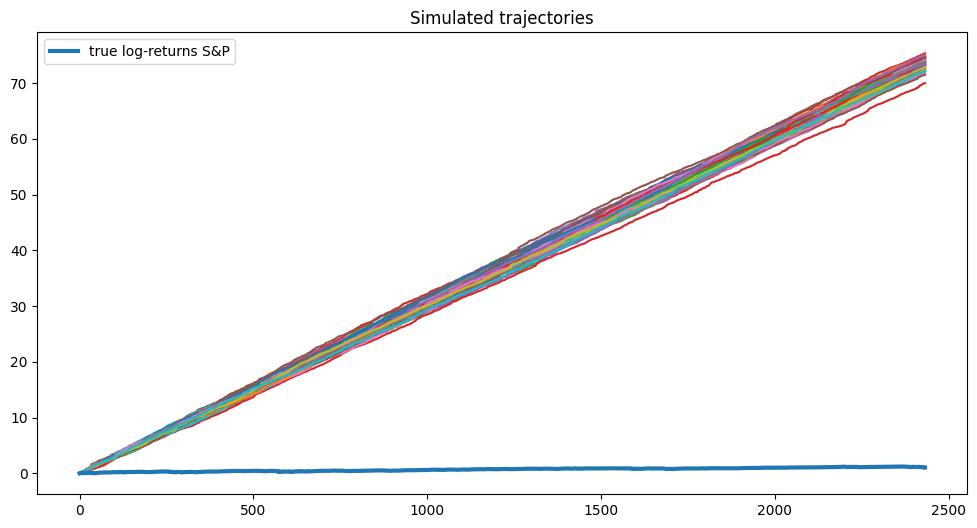

In [89]:
def generate_snp_trajectory(n_generate = 50):
    sim_df = []
    for tr in range(1,n_generate+1):
        noise = torch.randn(1, len(log_returns_normalized), N_z, device=device)
        generated_snp_gaus = gen(noise).detach().reshape(len(log_returns_normalized)).numpy()
        generated_snp = gaus.inverse_transform(np.array([[g] for g in generated_snp_gaus]) ).reshape(-1)
        sim_df.append(generated_snp)
    return pd.DataFrame(data=np.array(sim_df).T,columns=[f'tr {t}' for t in range(1,n_generate+1)] ).cumsum()

plt.figure(figsize=(12,6))
plt.plot(generate_snp_trajectory())
plt.plot(list(log_returns.cumsum()),linewidth=3,label='true log-returns S&P')
plt.title('Simulated trajectories')
plt.legend()
plt.show()


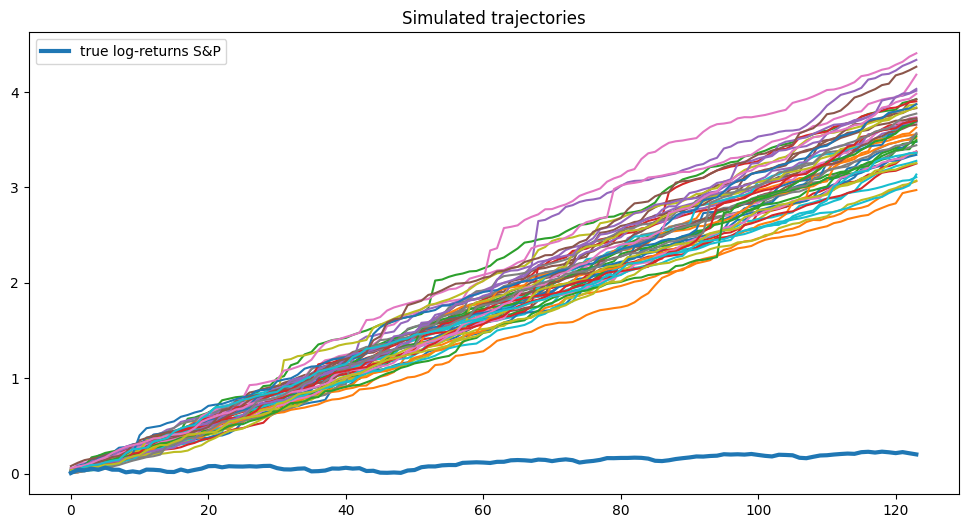

In [90]:
plt.figure(figsize=(12,6))
plt.plot(generate_snp_trajectory()[:124])
plt.plot(list(log_returns.cumsum()[:124]),linewidth=3,label='true log-returns S&P')
plt.title('Simulated trajectories')
plt.legend()
plt.show()

### Let's try to increase learning rate further to 0.005

  0%|                                                    | 0/40 [00:00<?, ?it/s]

Generator loss = -0.501532256603241, Discriminator loss = 1.1801719665527344e-05
Generator loss = -0.5002396702766418, Discriminator loss = -0.00013619661331176758
Generator loss = -0.49396753311157227, Discriminator loss = -0.0007650852203369141
Generator loss = -0.4810773730278015, Discriminator loss = -0.007013678550720215
Generator loss = -0.4793809950351715, Discriminator loss = -0.005773484706878662
Generator loss = -0.4601334035396576, Discriminator loss = -0.017536908388137817
Generator loss = -0.4747188687324524, Discriminator loss = -0.018829345703125
Generator loss = -0.4705078601837158, Discriminator loss = -0.019002974033355713
Generator loss = -0.47090277075767517, Discriminator loss = -0.019442737102508545
Generator loss = -0.4410915672779083, Discriminator loss = -0.011995196342468262
Generator loss = -0.4540744125843048, Discriminator loss = -0.019551485776901245
Generator loss = -0.4623013138771057, Discriminator loss = -0.019864410161972046
Generator loss = -0.491745

  2%|█                                           | 1/40 [00:56<36:26, 56.06s/it]

Generator loss = -0.4626273512840271, Discriminator loss = -0.02028346061706543
Generator loss = -0.471354603767395, Discriminator loss = -0.01984277367591858
Generator loss = -0.4364970326423645, Discriminator loss = -0.02040722966194153
Generator loss = -0.44648054242134094, Discriminator loss = -0.020600736141204834
Generator loss = -0.454931378364563, Discriminator loss = -0.02066880464553833
Generator loss = -0.4572273790836334, Discriminator loss = -0.020682215690612793
Generator loss = -0.46453338861465454, Discriminator loss = -0.020546823740005493
Generator loss = -0.4711357057094574, Discriminator loss = -0.020760655403137207
Generator loss = -0.4369763433933258, Discriminator loss = -0.020219385623931885
Generator loss = -0.4414534568786621, Discriminator loss = -0.020531505346298218
Generator loss = -0.4497704803943634, Discriminator loss = -0.020607858896255493
Generator loss = -0.45693904161453247, Discriminator loss = -0.020663201808929443
Generator loss = -0.46327248215

  5%|██▏                                         | 2/40 [01:55<36:42, 57.95s/it]

Generator loss = -0.4778088927268982, Discriminator loss = -0.020763099193572998
Generator loss = -0.4331917464733124, Discriminator loss = -0.020587295293807983
Generator loss = -0.44289135932922363, Discriminator loss = -0.02068394422531128
Generator loss = -0.45130637288093567, Discriminator loss = -0.020759254693984985
Generator loss = -0.4584656357765198, Discriminator loss = -0.020810455083847046
Generator loss = -0.4649525582790375, Discriminator loss = -0.020877599716186523
Generator loss = -0.4705987870693207, Discriminator loss = -0.020881086587905884
Generator loss = -0.42850494384765625, Discriminator loss = -0.01796555519104004
Generator loss = -0.4389444589614868, Discriminator loss = -0.02219274640083313
Generator loss = -0.44815197587013245, Discriminator loss = -0.022289901971817017
Generator loss = -0.4559798240661621, Discriminator loss = -0.02235075831413269
Generator loss = -0.46331921219825745, Discriminator loss = -0.022088319063186646
Generator loss = -0.4603308

  8%|██▊                                  | 3/40 [1:09:27<19:20:25, 1881.78s/it]

Generator loss = -0.4515306353569031, Discriminator loss = -0.02231675386428833
Generator loss = -0.4595012664794922, Discriminator loss = -0.02237841486930847
Generator loss = -0.4674346446990967, Discriminator loss = -0.022418975830078125
Generator loss = -0.42656877636909485, Discriminator loss = -0.01672503352165222
Generator loss = -0.4367789626121521, Discriminator loss = -0.022189587354660034
Generator loss = -0.4460189640522003, Discriminator loss = -0.02228677272796631
Generator loss = -0.4537775218486786, Discriminator loss = -0.022353142499923706
Generator loss = -0.46053242683410645, Discriminator loss = -0.022402077913284302
Generator loss = -0.47691068053245544, Discriminator loss = -0.022430002689361572
Generator loss = -0.5023559331893921, Discriminator loss = -0.0022419095039367676
Generator loss = -0.5012476444244385, Discriminator loss = -0.002698063850402832
Generator loss = -0.49558740854263306, Discriminator loss = -0.004036039113998413
Generator loss = -0.4204567

 10%|███▋                                 | 4/40 [1:10:30<11:38:17, 1163.81s/it]

Generator loss = -0.46722036600112915, Discriminator loss = -0.02793058753013611
Generator loss = -0.4417818486690521, Discriminator loss = -0.02776077389717102
Generator loss = -0.4524989724159241, Discriminator loss = -0.027901798486709595
Generator loss = -0.4613845646381378, Discriminator loss = -0.027846843004226685
Generator loss = -0.4659483730792999, Discriminator loss = -0.028027981519699097
Generator loss = -0.4167706072330475, Discriminator loss = -0.027334064245224
Generator loss = -0.4321320950984955, Discriminator loss = -0.027634650468826294
Generator loss = -0.44462674856185913, Discriminator loss = -0.027810782194137573
Generator loss = -0.4547238051891327, Discriminator loss = -0.02791580557823181
Generator loss = -0.4728182554244995, Discriminator loss = -0.028184711933135986
Generator loss = -0.44578659534454346, Discriminator loss = -0.027809470891952515
Generator loss = -0.455536812543869, Discriminator loss = -0.027916252613067627
Generator loss = -0.463420748710

 12%|████▉                                  | 5/40 [1:11:46<7:30:06, 771.61s/it]

Generator loss = -0.4400993883609772, Discriminator loss = -0.027626901865005493
Generator loss = -0.45019885897636414, Discriminator loss = -0.027641087770462036
Generator loss = -0.4583404064178467, Discriminator loss = -0.027814507484436035
Generator loss = -0.47623884677886963, Discriminator loss = -0.0280875563621521
Generator loss = -0.4246542155742645, Discriminator loss = -0.027374207973480225
Generator loss = -0.4379487931728363, Discriminator loss = -0.027575939893722534
Generator loss = -0.4487321972846985, Discriminator loss = -0.027705132961273193
Generator loss = -0.45750191807746887, Discriminator loss = -0.027787625789642334
Generator loss = -0.465485155582428, Discriminator loss = -0.027735978364944458
Generator loss = -0.41744181513786316, Discriminator loss = -0.027185261249542236
Generator loss = -0.4323177933692932, Discriminator loss = -0.027516454458236694
Generator loss = -0.444415420293808, Discriminator loss = -0.027676016092300415
Generator loss = -0.45412042

 15%|█████▊                                 | 6/40 [1:13:02<5:03:04, 534.83s/it]

Generator loss = -0.42798948287963867, Discriminator loss = -0.02748391032218933
Generator loss = -0.4415884017944336, Discriminator loss = -0.027672886848449707
Generator loss = -0.4494895040988922, Discriminator loss = -0.02776050567626953
Generator loss = -0.4588366746902466, Discriminator loss = -0.02780589461326599
Generator loss = -0.4337182343006134, Discriminator loss = -0.027396678924560547
Generator loss = -0.4460848569869995, Discriminator loss = -0.027695834636688232
Generator loss = -0.4559313952922821, Discriminator loss = -0.027814745903015137
Generator loss = -0.4638877213001251, Discriminator loss = -0.027777940034866333
Generator loss = -0.4239080250263214, Discriminator loss = -0.027335762977600098
Generator loss = -0.437832772731781, Discriminator loss = -0.027620434761047363
Generator loss = -0.4502345323562622, Discriminator loss = -0.027766942977905273
Generator loss = -0.46021702885627747, Discriminator loss = -0.027858972549438477
Generator loss = -0.4767797291

 18%|██████▊                                | 7/40 [1:14:07<3:29:41, 381.24s/it]

Generator loss = -0.4427574574947357, Discriminator loss = -0.02769535779953003
Generator loss = -0.4527081549167633, Discriminator loss = -0.027804046869277954
Generator loss = -0.4610510766506195, Discriminator loss = -0.02787327766418457
Generator loss = -0.47095000743865967, Discriminator loss = -0.027597397565841675
Generator loss = -0.4145861566066742, Discriminator loss = -0.027452290058135986
Generator loss = -0.43125876784324646, Discriminator loss = -0.02788141369819641
Generator loss = -0.44459268450737, Discriminator loss = -0.028060495853424072
Generator loss = -0.4511062502861023, Discriminator loss = -0.028112322092056274
Generator loss = -0.45982545614242554, Discriminator loss = -0.02821943163871765
Generator loss = -0.4672098755836487, Discriminator loss = -0.028271019458770752
Generator loss = -0.41511622071266174, Discriminator loss = -0.027587473392486572
Generator loss = -0.4314889907836914, Discriminator loss = -0.02787432074546814
Generator loss = -0.44464775919

 20%|███████▊                               | 8/40 [1:18:25<3:02:27, 342.10s/it]

Generator loss = -0.40818366408348083, Discriminator loss = -0.027562886476516724
Generator loss = -0.4286162555217743, Discriminator loss = -0.028054147958755493
Generator loss = -0.44013845920562744, Discriminator loss = -0.02810075879096985
Generator loss = -0.4530503451824188, Discriminator loss = -0.028420180082321167
Generator loss = -0.4691521227359772, Discriminator loss = -0.028453171253204346
Generator loss = -0.42903557419776917, Discriminator loss = -0.029666990041732788
Generator loss = -0.44532787799835205, Discriminator loss = -0.029944658279418945
Generator loss = -0.45330512523651123, Discriminator loss = -0.030061423778533936
Generator loss = -0.46493151783943176, Discriminator loss = -0.03010311722755432
Generator loss = -0.4660206735134125, Discriminator loss = -0.030095040798187256
Generator loss = -0.41633903980255127, Discriminator loss = -0.02916058897972107
Generator loss = -0.4339771866798401, Discriminator loss = -0.029482901096343994
Generator loss = -0.4475

 22%|████████▊                              | 9/40 [1:19:29<2:11:53, 255.26s/it]

Generator loss = -0.4277288317680359, Discriminator loss = -0.028964191675186157
Generator loss = -0.44100892543792725, Discriminator loss = -0.029155850410461426
Generator loss = -0.45164403319358826, Discriminator loss = -0.029284894466400146
Generator loss = -0.46163785457611084, Discriminator loss = -0.029297560453414917
Generator loss = -0.4527408480644226, Discriminator loss = -0.029244840145111084
Generator loss = -0.46498993039131165, Discriminator loss = -0.029414981603622437
Generator loss = -0.4169100522994995, Discriminator loss = -0.028734803199768066
Generator loss = -0.43233823776245117, Discriminator loss = -0.029046058654785156
Generator loss = -0.44479143619537354, Discriminator loss = -0.029187798500061035
Generator loss = -0.45483243465423584, Discriminator loss = -0.029324978590011597
Generator loss = -0.46328744292259216, Discriminator loss = -0.0293329656124115
Generator loss = -0.41214412450790405, Discriminator loss = -0.028675556182861328
Generator loss = -0.4

 25%|█████████▌                            | 10/40 [1:20:37<1:38:38, 197.29s/it]

Generator loss = -0.41258734464645386, Discriminator loss = -0.02863621711730957
Generator loss = -0.43116727471351624, Discriminator loss = -0.02893689274787903
Generator loss = -0.4461377263069153, Discriminator loss = -0.029126256704330444
Generator loss = -0.4579860270023346, Discriminator loss = -0.02934950590133667
Generator loss = -0.409700483083725, Discriminator loss = -0.019613265991210938
Generator loss = -0.4266248643398285, Discriminator loss = -0.028971612453460693
Generator loss = -0.4404076039791107, Discriminator loss = -0.029239565134048462
Generator loss = -0.45131009817123413, Discriminator loss = -0.029145091772079468
Generator loss = -0.4594535231590271, Discriminator loss = -0.02938985824584961
Generator loss = -0.4662715792655945, Discriminator loss = -0.02948218584060669
Generator loss = -0.41937270760536194, Discriminator loss = -0.028677910566329956
Generator loss = -0.4335018992424011, Discriminator loss = -0.029416948556900024
Generator loss = -0.4458285272

 28%|██████████▍                           | 11/40 [1:22:05<1:19:10, 163.80s/it]

Generator loss = -0.41464298963546753, Discriminator loss = -0.02874702215194702
Generator loss = -0.42953240871429443, Discriminator loss = -0.02908608317375183
Generator loss = -0.4418345093727112, Discriminator loss = -0.02926158905029297
Generator loss = -0.4527486264705658, Discriminator loss = -0.029375076293945312
Generator loss = -0.4655497968196869, Discriminator loss = -0.02919018268585205
Generator loss = -0.408567875623703, Discriminator loss = -0.031045764684677124
Generator loss = -0.42784443497657776, Discriminator loss = -0.02967071533203125
Generator loss = -0.433073490858078, Discriminator loss = -0.02977856993675232
Generator loss = -0.4411090612411499, Discriminator loss = -0.034323930740356445
Generator loss = -0.47603219747543335, Discriminator loss = -0.03157234191894531
Generator loss = -0.41485148668289185, Discriminator loss = -0.03380107879638672
Generator loss = -0.43509238958358765, Discriminator loss = -0.03416556119918823
Generator loss = -0.4495914280414

 30%|███████████▍                          | 12/40 [1:23:14<1:03:05, 135.19s/it]

Generator loss = -0.388170450925827, Discriminator loss = -0.010151863098144531
Generator loss = -0.41279008984565735, Discriminator loss = -0.03455764055252075
Generator loss = -0.4328159689903259, Discriminator loss = -0.035436034202575684
Generator loss = -0.44787195324897766, Discriminator loss = -0.03608518838882446
Generator loss = -0.46012672781944275, Discriminator loss = -0.036208003759384155
Generator loss = -0.4019821882247925, Discriminator loss = -0.03513669967651367
Generator loss = -0.426257461309433, Discriminator loss = -0.0359097421169281
Generator loss = -0.44418129324913025, Discriminator loss = -0.03623130917549133
Generator loss = -0.456665962934494, Discriminator loss = -0.03638818860054016
Generator loss = -0.44200941920280457, Discriminator loss = -0.036096274852752686
Generator loss = -0.4554724395275116, Discriminator loss = -0.0365426242351532
Generator loss = -0.3995059132575989, Discriminator loss = -0.03536790609359741
Generator loss = -0.4270686209201813

 32%|█████████████                           | 13/40 [1:24:25<52:05, 115.74s/it]

Generator loss = -0.4322841465473175, Discriminator loss = -0.037305623292922974
Generator loss = -0.45114797353744507, Discriminator loss = -0.037595152854919434
Generator loss = -0.3814561069011688, Discriminator loss = -0.03548815846443176
Generator loss = -0.41533926129341125, Discriminator loss = -0.03719264268875122
Generator loss = -0.43922555446624756, Discriminator loss = -0.03771701455116272
Generator loss = -0.4545438289642334, Discriminator loss = -0.037934839725494385
Generator loss = -0.44250500202178955, Discriminator loss = -0.03769645094871521
Generator loss = -0.4573094844818115, Discriminator loss = -0.03794670104980469
Generator loss = -0.406249076128006, Discriminator loss = -0.036963701248168945
Generator loss = -0.43378791213035583, Discriminator loss = -0.037635087966918945
Generator loss = -0.4518361985683441, Discriminator loss = -0.037928879261016846
Generator loss = -0.46208861470222473, Discriminator loss = -0.038006216287612915
Generator loss = -0.44870179

 35%|██████████████                          | 14/40 [1:25:37<44:21, 102.38s/it]

Generator loss = -0.4527522921562195, Discriminator loss = -0.03845334053039551
Generator loss = -0.47885918617248535, Discriminator loss = -0.03862965106964111
Generator loss = -0.40811100602149963, Discriminator loss = -0.03758201003074646
Generator loss = -0.43073439598083496, Discriminator loss = -0.038129329681396484
Generator loss = -0.4470698833465576, Discriminator loss = -0.03840988874435425
Generator loss = -0.4643144905567169, Discriminator loss = -0.03856799006462097
Generator loss = -0.4087147116661072, Discriminator loss = -0.0376242995262146
Generator loss = -0.4313961863517761, Discriminator loss = -0.038159579038619995
Generator loss = -0.4475037157535553, Discriminator loss = -0.03843581676483154
Generator loss = -0.4627269506454468, Discriminator loss = -0.03859454393386841
Generator loss = -0.49748146533966064, Discriminator loss = -0.004521012306213379
Generator loss = -0.4942496716976166, Discriminator loss = -0.00424543023109436
Generator loss = -0.42634734511375

 38%|███████████████▍                         | 15/40 [1:26:42<38:00, 91.23s/it]

Generator loss = -0.35494762659072876, Discriminator loss = -0.05066728591918945
Generator loss = -0.4164755046367645, Discriminator loss = -0.054043322801589966
Generator loss = -0.42941799759864807, Discriminator loss = -0.05449947714805603
Generator loss = -0.3604165315628052, Discriminator loss = -0.05011877417564392
Generator loss = -0.4117349684238434, Discriminator loss = -0.054149478673934937
Generator loss = -0.44307243824005127, Discriminator loss = -0.05509504675865173
Generator loss = -0.37895524501800537, Discriminator loss = -0.05266505479812622
Generator loss = -0.42575153708457947, Discriminator loss = -0.05476665496826172
Generator loss = -0.4473980665206909, Discriminator loss = -0.055279165506362915
Generator loss = -0.3989203870296478, Discriminator loss = -0.05377534031867981
Generator loss = -0.4358013868331909, Discriminator loss = -0.05510932207107544
Generator loss = -0.36657246947288513, Discriminator loss = -0.051960110664367676
Generator loss = -0.4189057648

 40%|████████████████▍                        | 16/40 [1:27:50<33:37, 84.07s/it]

Generator loss = -0.3767840266227722, Discriminator loss = -0.053049564361572266
Generator loss = -0.41946926712989807, Discriminator loss = -0.05713960528373718
Generator loss = -0.43378037214279175, Discriminator loss = -0.05808791518211365
Generator loss = -0.4394306242465973, Discriminator loss = -0.058014899492263794
Generator loss = -0.44598522782325745, Discriminator loss = -0.05761909484863281
Generator loss = -0.39258697628974915, Discriminator loss = -0.05615478754043579
Generator loss = -0.43661603331565857, Discriminator loss = -0.05807870626449585
Generator loss = -0.38035324215888977, Discriminator loss = -0.05552035570144653
Generator loss = -0.43336397409439087, Discriminator loss = -0.05796241760253906
Generator loss = -0.35701990127563477, Discriminator loss = -0.054139673709869385
Generator loss = -0.4182863235473633, Discriminator loss = -0.05775344371795654
Generator loss = -0.4263930916786194, Discriminator loss = -0.057726263999938965
Generator loss = -0.37535309

 42%|█████████████████▍                       | 17/40 [1:28:58<30:28, 79.50s/it]

Generator loss = -0.38393914699554443, Discriminator loss = -0.05794927477836609
Generator loss = -0.43455326557159424, Discriminator loss = -0.060397177934646606
Generator loss = -0.36758431792259216, Discriminator loss = -0.05748507380485535
Generator loss = -0.4210371673107147, Discriminator loss = -0.06105053424835205
Generator loss = -0.4199731647968292, Discriminator loss = -0.060803771018981934
Generator loss = -0.34524402022361755, Discriminator loss = -0.05586129426956177
Generator loss = -0.4154239296913147, Discriminator loss = -0.06063547730445862
Generator loss = -0.4480133056640625, Discriminator loss = -0.061666518449783325
Generator loss = -0.38682594895362854, Discriminator loss = -0.059060633182525635
Generator loss = -0.43149030208587646, Discriminator loss = -0.061060041189193726
Generator loss = -0.3659573495388031, Discriminator loss = -0.057624250650405884
Generator loss = -0.4241601526737213, Discriminator loss = -0.060915350914001465
Generator loss = -0.4239753

 45%|██████████████████▍                      | 18/40 [1:30:24<29:46, 81.20s/it]

Generator loss = -0.4139285981655121, Discriminator loss = -0.0606483519077301
Generator loss = -0.43552830815315247, Discriminator loss = -0.059812456369400024
Generator loss = -0.41533127427101135, Discriminator loss = -0.06145253777503967
Generator loss = -0.3388870656490326, Discriminator loss = -0.05308011174201965
Generator loss = -0.4041275382041931, Discriminator loss = -0.060108065605163574
Generator loss = -0.333037793636322, Discriminator loss = -0.054282546043395996
Generator loss = -0.407755583524704, Discriminator loss = -0.06031450629234314
Generator loss = -0.33200204372406006, Discriminator loss = -0.05425044894218445
Generator loss = -0.4045383334159851, Discriminator loss = -0.06019771099090576
Generator loss = -0.46494874358177185, Discriminator loss = -0.061629414558410645
Generator loss = -0.3791898488998413, Discriminator loss = -0.058721959590911865
Generator loss = -0.431414932012558, Discriminator loss = -0.0613366961479187
Generator loss = -0.3749406337738037

 48%|███████████████████▍                     | 19/40 [1:31:42<28:09, 80.45s/it]

Generator loss = -0.33156946301460266, Discriminator loss = -0.05480721592903137
Generator loss = -0.4062197804450989, Discriminator loss = -0.06026726961135864
Generator loss = -0.3741375505924225, Discriminator loss = -0.058220118284225464
Generator loss = -0.4095228612422943, Discriminator loss = -0.06041976809501648
Generator loss = -0.4332622289657593, Discriminator loss = -0.06131845712661743
Generator loss = -0.4329785108566284, Discriminator loss = -0.061481744050979614
Generator loss = -0.38407081365585327, Discriminator loss = -0.05865645408630371
Generator loss = -0.4409221112728119, Discriminator loss = -0.061515867710113525
Generator loss = -0.3898879587650299, Discriminator loss = -0.05936875939369202
Generator loss = -0.4186260402202606, Discriminator loss = -0.06160634756088257
Generator loss = -0.3597562313079834, Discriminator loss = -0.057198137044906616
Generator loss = -0.42626339197158813, Discriminator loss = -0.061056822538375854
Generator loss = -0.312301933765

 50%|████████████████████▌                    | 20/40 [1:33:06<27:09, 81.50s/it]

Generator loss = -0.31260791420936584, Discriminator loss = -0.06148165464401245
Generator loss = -0.4062342345714569, Discriminator loss = -0.06135907769203186
Generator loss = -0.3313233554363251, Discriminator loss = -0.05567765235900879
Generator loss = -0.4123743176460266, Discriminator loss = -0.06174498796463013
Generator loss = -0.3697202503681183, Discriminator loss = -0.05894440412521362
Generator loss = -0.44107845425605774, Discriminator loss = -0.06256714463233948
Generator loss = -0.3898615837097168, Discriminator loss = -0.06049010157585144
Generator loss = -0.3222599923610687, Discriminator loss = -0.06186586618423462
Generator loss = -0.4100070595741272, Discriminator loss = -0.06154137849807739
Generator loss = -0.33321839570999146, Discriminator loss = -0.05523046851158142
Generator loss = -0.4147702753543854, Discriminator loss = -0.06185451149940491
Generator loss = -0.3551327586174011, Discriminator loss = -0.05787178874015808
Generator loss = -0.4150933623313904,

 52%|█████████████████████▌                   | 21/40 [1:34:24<25:25, 80.27s/it]

Generator loss = -0.30770596861839294, Discriminator loss = -0.0612180233001709
Generator loss = -0.395670622587204, Discriminator loss = -0.06122961640357971
Generator loss = -0.30857139825820923, Discriminator loss = -0.0606917142868042
Generator loss = -0.39428091049194336, Discriminator loss = -0.061210185289382935
Generator loss = -0.31779301166534424, Discriminator loss = -0.0630960762500763
Generator loss = -0.4018760621547699, Discriminator loss = -0.06163409352302551
Generator loss = -0.30907875299453735, Discriminator loss = -0.05144137144088745
Generator loss = -0.39581266045570374, Discriminator loss = -0.06158307194709778
Generator loss = -0.43435338139533997, Discriminator loss = -0.06310901045799255
Generator loss = -0.36281388998031616, Discriminator loss = -0.059338927268981934
Generator loss = -0.42529377341270447, Discriminator loss = -0.06290701031684875
Generator loss = -0.344221293926239, Discriminator loss = -0.0578991174697876
Generator loss = -0.413117259740829

 55%|██████████████████████▌                  | 22/40 [1:36:42<29:18, 97.71s/it]

Generator loss = -0.41517549753189087, Discriminator loss = -0.06110545992851257
Generator loss = -0.3587982952594757, Discriminator loss = -0.058083683252334595
Generator loss = -0.4198944866657257, Discriminator loss = -0.06369292736053467
Generator loss = -0.4164782166481018, Discriminator loss = -0.06412297487258911
Generator loss = -0.43272483348846436, Discriminator loss = -0.06369337439537048
Generator loss = -0.3083968758583069, Discriminator loss = -0.06290826201438904
Generator loss = -0.39450740814208984, Discriminator loss = -0.062046974897384644
Generator loss = -0.4408242702484131, Discriminator loss = -0.06330433487892151
Generator loss = -0.3799327313899994, Discriminator loss = -0.06102016568183899
Generator loss = -0.43669113516807556, Discriminator loss = -0.06311625242233276
Generator loss = -0.3878019154071808, Discriminator loss = -0.061633139848709106
Generator loss = -0.41729360818862915, Discriminator loss = -0.06266233325004578
Generator loss = -0.347069084644

 57%|███████████████████████                 | 23/40 [1:38:48<30:02, 106.04s/it]

Generator loss = -0.37045472860336304, Discriminator loss = -0.06031525135040283
Generator loss = -0.40917450189590454, Discriminator loss = -0.06279447674751282
Generator loss = -0.4292949438095093, Discriminator loss = -0.06369319558143616
Generator loss = -0.4203621447086334, Discriminator loss = -0.06381258368492126
Generator loss = -0.430396169424057, Discriminator loss = -0.06323778629302979
Generator loss = -0.3798239827156067, Discriminator loss = -0.06105026602745056
Generator loss = -0.43442004919052124, Discriminator loss = -0.06379920244216919
Generator loss = -0.36581772565841675, Discriminator loss = -0.060060083866119385
Generator loss = -0.43091705441474915, Discriminator loss = -0.06357726454734802
Generator loss = -0.36315882205963135, Discriminator loss = -0.05986374616622925
Generator loss = -0.42495185136795044, Discriminator loss = -0.06353050470352173
Generator loss = -0.34809041023254395, Discriminator loss = -0.058554500341415405
Generator loss = -0.40320265293

 60%|████████████████████████▌                | 24/40 [1:40:08<26:15, 98.46s/it]

Generator loss = -0.42644745111465454, Discriminator loss = -0.06364202499389648
Generator loss = -0.41762611269950867, Discriminator loss = -0.06375530362129211
Generator loss = -0.4293387830257416, Discriminator loss = -0.06369152665138245
Generator loss = -0.44014549255371094, Discriminator loss = -0.06388935446739197
Generator loss = -0.3803037405014038, Discriminator loss = -0.06113317608833313
Generator loss = -0.4337533414363861, Discriminator loss = -0.06380614638328552
Generator loss = -0.3578612208366394, Discriminator loss = -0.059344738721847534
Generator loss = -0.4120284914970398, Discriminator loss = -0.0629396140575409
Generator loss = -0.3254423439502716, Discriminator loss = -0.05639854073524475
Generator loss = -0.4045344889163971, Discriminator loss = -0.06259700655937195
Generator loss = -0.3057737946510315, Discriminator loss = -0.05859041213989258
Generator loss = -0.39195576310157776, Discriminator loss = -0.061892420053482056
Generator loss = -0.411457538604736

 62%|█████████████████████████▋               | 25/40 [1:41:32<23:32, 94.14s/it]

Generator loss = -0.4133889675140381, Discriminator loss = -0.06217515468597412
Generator loss = -0.347636878490448, Discriminator loss = -0.057248324155807495
Generator loss = -0.41893136501312256, Discriminator loss = -0.0632181167602539
Generator loss = -0.4287950098514557, Discriminator loss = -0.06380975246429443
Generator loss = -0.3865067958831787, Discriminator loss = -0.06154423952102661
Generator loss = -0.4613119661808014, Discriminator loss = -0.06445702910423279
Generator loss = -0.3823546767234802, Discriminator loss = -0.06064045429229736
Generator loss = -0.4350404441356659, Discriminator loss = -0.06332629919052124
Generator loss = -0.30643874406814575, Discriminator loss = -0.06143316626548767
Generator loss = -0.39445579051971436, Discriminator loss = -0.06163409352302551
Generator loss = -0.445656955242157, Discriminator loss = -0.0639578104019165
Generator loss = -0.3791358470916748, Discriminator loss = -0.061075359582901
Generator loss = -0.4323367476463318, Disc

 65%|██████████████████████████▋              | 26/40 [1:42:42<20:13, 86.65s/it]

Generator loss = -0.3756084740161896, Discriminator loss = -0.06084120273590088
Generator loss = -0.4281851351261139, Discriminator loss = -0.06361570954322815
Generator loss = -0.4286482036113739, Discriminator loss = -0.06302797794342041
Generator loss = -0.38385438919067383, Discriminator loss = -0.06139424443244934
Generator loss = -0.427124559879303, Discriminator loss = -0.06393754482269287
Generator loss = -0.4306725561618805, Discriminator loss = -0.06396976113319397
Generator loss = -0.4249100089073181, Discriminator loss = -0.06324368715286255
Generator loss = -0.34534114599227905, Discriminator loss = -0.0579436719417572
Generator loss = -0.4154580235481262, Discriminator loss = -0.06314677000045776
Generator loss = -0.3253781795501709, Discriminator loss = -0.05593833327293396
Generator loss = -0.4034404158592224, Discriminator loss = -0.06258249282836914
Generator loss = -0.3817996382713318, Discriminator loss = -0.060505449771881104
Generator loss = -0.41828233003616333, 

 68%|███████████████████████████▋             | 27/40 [1:43:53<17:48, 82.19s/it]

Generator loss = -0.32681792974472046, Discriminator loss = -0.05603152513504028
Generator loss = -0.4077284634113312, Discriminator loss = -0.06273078918457031
Generator loss = -0.32892629504203796, Discriminator loss = -0.056423574686050415
Generator loss = -0.4066973328590393, Discriminator loss = -0.06273254752159119
Generator loss = -0.3447723388671875, Discriminator loss = -0.05827474594116211
Generator loss = -0.4150288701057434, Discriminator loss = -0.06310808658599854
Generator loss = -0.3138430714607239, Discriminator loss = -0.05137449502944946
Generator loss = -0.3963163495063782, Discriminator loss = -0.06219884753227234
Generator loss = -0.4789119362831116, Discriminator loss = -0.06465184688568115
Generator loss = -0.3628980815410614, Discriminator loss = -0.05987769365310669
Generator loss = -0.4225198030471802, Discriminator loss = -0.0634186863899231
Generator loss = -0.4500609040260315, Discriminator loss = -0.06390994787216187
Generator loss = -0.3756571114063263, 

 70%|████████████████████████████▋            | 28/40 [1:45:09<16:03, 80.30s/it]

Generator loss = -0.41101258993148804, Discriminator loss = -0.0637877881526947
Generator loss = -0.3026600182056427, Discriminator loss = -0.053911954164505005
Generator loss = -0.38784652948379517, Discriminator loss = -0.06253480911254883
Generator loss = -0.4357947111129761, Discriminator loss = -0.0646887719631195
Generator loss = -0.33452939987182617, Discriminator loss = -0.061798691749572754
Generator loss = -0.4086656868457794, Discriminator loss = -0.06369981169700623
Generator loss = -0.4290139675140381, Discriminator loss = -0.06458154320716858
Generator loss = -0.42953935265541077, Discriminator loss = -0.0643579363822937
Generator loss = -0.43296098709106445, Discriminator loss = -0.0643589198589325
Generator loss = -0.34635287523269653, Discriminator loss = -0.059451282024383545
Generator loss = -0.4180173873901367, Discriminator loss = -0.0644264817237854
Generator loss = -0.3016654849052429, Discriminator loss = -0.05214053392410278
Generator loss = -0.3920208811759949

 72%|█████████████████████████████▋           | 29/40 [1:46:27<14:36, 79.66s/it]

Generator loss = -0.4318615794181824, Discriminator loss = -0.06484866142272949
Generator loss = -0.3707493245601654, Discriminator loss = -0.06190529465675354
Generator loss = -0.4237232804298401, Discriminator loss = -0.0650782585144043
Generator loss = -0.42210665345191956, Discriminator loss = -0.0653144121170044
Generator loss = -0.3911689221858978, Discriminator loss = -0.06333222985267639
Generator loss = -0.30036309361457825, Discriminator loss = -0.05486655235290527
Generator loss = -0.4002454876899719, Discriminator loss = -0.064197838306427
Generator loss = -0.29941004514694214, Discriminator loss = -0.06628310680389404
Generator loss = -0.39708077907562256, Discriminator loss = -0.06404045224189758
Generator loss = -0.31261080503463745, Discriminator loss = -0.028905212879180908
Generator loss = -0.380235880613327, Discriminator loss = -0.0629410445690155
Generator loss = -0.446128785610199, Discriminator loss = -0.06597089767456055
Generator loss = -0.37803706526756287, Di

 75%|██████████████████████████████▊          | 30/40 [1:47:40<12:54, 77.44s/it]

Generator loss = -0.40428733825683594, Discriminator loss = -0.06507492065429688
Generator loss = -0.32251080870628357, Discriminator loss = -0.056702107191085815
Generator loss = -0.40453794598579407, Discriminator loss = -0.06505298614501953
Generator loss = -0.3699823021888733, Discriminator loss = -0.06684058904647827
Generator loss = -0.4326189160346985, Discriminator loss = -0.06594833731651306
Generator loss = -0.3985460698604584, Discriminator loss = -0.06470659375190735
Generator loss = -0.4199281334877014, Discriminator loss = -0.06565237045288086
Generator loss = -0.4305366575717926, Discriminator loss = -0.06599202752113342
Generator loss = -0.4204986095428467, Discriminator loss = -0.06573966145515442
Generator loss = -0.3672904670238495, Discriminator loss = -0.062420934438705444
Generator loss = -0.44270995259284973, Discriminator loss = -0.06611838936805725
Generator loss = -0.3805468678474426, Discriminator loss = -0.06339535117149353
Generator loss = -0.42013087868690

 78%|███████████████████████████████▊         | 31/40 [1:48:53<11:27, 76.35s/it]

Generator loss = -0.4370606541633606, Discriminator loss = -0.06342113018035889
Generator loss = -0.35556134581565857, Discriminator loss = -0.06138712167739868
Generator loss = -0.4248732924461365, Discriminator loss = -0.06596842408180237
Generator loss = -0.362831711769104, Discriminator loss = -0.062079042196273804
Generator loss = -0.4310372471809387, Discriminator loss = -0.06543460488319397
Generator loss = -0.3442350924015045, Discriminator loss = -0.06057611107826233
Generator loss = -0.418697327375412, Discriminator loss = -0.06568694114685059
Generator loss = -0.3408513367176056, Discriminator loss = -0.06011384725570679
Generator loss = -0.4157254993915558, Discriminator loss = -0.06561470031738281
Generator loss = -0.3731316030025482, Discriminator loss = -0.0629604160785675
Generator loss = -0.4360195994377136, Discriminator loss = -0.06626981496810913
Generator loss = -0.39888498187065125, Discriminator loss = -0.06474879384040833
Generator loss = -0.426132470369339, Dis

 80%|████████████████████████████████▊        | 32/40 [1:50:11<10:13, 76.66s/it]

Generator loss = -0.44469526410102844, Discriminator loss = -0.0672873854637146
Generator loss = -0.3768891990184784, Discriminator loss = -0.06410658359527588
Generator loss = -0.4066803753376007, Discriminator loss = -0.06712758541107178
Generator loss = -0.4325295686721802, Discriminator loss = -0.06706011295318604
Generator loss = -0.39763855934143066, Discriminator loss = -0.0655243992805481
Generator loss = -0.4259227216243744, Discriminator loss = -0.06721356511116028
Generator loss = -0.41880470514297485, Discriminator loss = -0.0670110285282135
Generator loss = -0.32070183753967285, Discriminator loss = -0.05777406692504883
Generator loss = -0.4099683165550232, Discriminator loss = -0.06658414006233215
Generator loss = -0.4115618169307709, Discriminator loss = -0.06700891256332397
Generator loss = -0.3566606938838959, Discriminator loss = -0.06245526671409607
Generator loss = -0.4250992238521576, Discriminator loss = -0.06729021668434143
Generator loss = -0.3625759482383728, D

 82%|█████████████████████████████████▊       | 33/40 [1:51:22<08:45, 75.14s/it]

Generator loss = -0.47114911675453186, Discriminator loss = -0.06795307993888855
Generator loss = -0.36812034249305725, Discriminator loss = -0.06370282173156738
Generator loss = -0.4359714388847351, Discriminator loss = -0.06756812334060669
Generator loss = -0.3914153277873993, Discriminator loss = -0.06583821773529053
Generator loss = -0.29361164569854736, Discriminator loss = -0.04714357852935791
Generator loss = -0.3952751159667969, Discriminator loss = -0.06610551476478577
Generator loss = -0.42055419087409973, Discriminator loss = -0.06647568941116333
Generator loss = -0.3625582456588745, Discriminator loss = -0.06425374746322632
Generator loss = -0.4224737286567688, Discriminator loss = -0.0691693127155304
Generator loss = -0.4202272593975067, Discriminator loss = -0.06838148832321167
Generator loss = -0.428099662065506, Discriminator loss = -0.0691831111907959
Generator loss = -0.36903083324432373, Discriminator loss = -0.06513211131095886
Generator loss = -0.4592156708240509, 

 85%|██████████████████████████████████▊      | 34/40 [1:52:47<07:47, 77.86s/it]

Generator loss = -0.37006333470344543, Discriminator loss = -0.06604453921318054
Generator loss = -0.43324849009513855, Discriminator loss = -0.0699673593044281
Generator loss = -0.3896033763885498, Discriminator loss = -0.06765183806419373
Generator loss = -0.3517177999019623, Discriminator loss = -0.06423366069793701
Generator loss = -0.43963614106178284, Discriminator loss = -0.0700390636920929
Generator loss = -0.38624584674835205, Discriminator loss = -0.06749984622001648
Generator loss = -0.4334477186203003, Discriminator loss = -0.07008758187294006
Generator loss = -0.3861227035522461, Discriminator loss = -0.06742590665817261
Generator loss = -0.41111963987350464, Discriminator loss = -0.0686626136302948
Generator loss = -0.3857360780239105, Discriminator loss = -0.06727349758148193
Generator loss = -0.4241752028465271, Discriminator loss = -0.06987905502319336
Generator loss = -0.4155854880809784, Discriminator loss = -0.06930357217788696
Generator loss = -0.3921246826648712, 

 88%|███████████████████████████████████     | 35/40 [1:55:30<08:38, 103.64s/it]

Generator loss = -0.4235767424106598, Discriminator loss = -0.06791073083877563
Generator loss = -0.3675796687602997, Discriminator loss = -0.06441986560821533
Generator loss = -0.42901986837387085, Discriminator loss = -0.06804096698760986
Generator loss = -0.32841184735298157, Discriminator loss = -0.06285598874092102
Generator loss = -0.4230709373950958, Discriminator loss = -0.07135942578315735
Generator loss = -0.36198604106903076, Discriminator loss = -0.06696602702140808
Generator loss = -0.40888354182243347, Discriminator loss = -0.07167378067970276
Generator loss = -0.41109612584114075, Discriminator loss = -0.07079315185546875
Generator loss = -0.31144487857818604, Discriminator loss = -0.06080159544944763
Generator loss = -0.4131642282009125, Discriminator loss = -0.07092887163162231
Generator loss = -0.4250682294368744, Discriminator loss = -0.07190975546836853
Generator loss = -0.40110188722610474, Discriminator loss = -0.07056805491447449
Generator loss = -0.3994365930557

 90%|████████████████████████████████████▉    | 36/40 [1:56:32<06:04, 91.03s/it]

Generator loss = -0.30992427468299866, Discriminator loss = -0.06172001361846924
Generator loss = -0.4136253595352173, Discriminator loss = -0.071677565574646
Generator loss = -0.3347703218460083, Discriminator loss = -0.06521835923194885
Generator loss = -0.4231105446815491, Discriminator loss = -0.07280746102333069
Generator loss = -0.31141743063926697, Discriminator loss = -0.07233744859695435
Generator loss = -0.4118293523788452, Discriminator loss = -0.0724395215511322
Generator loss = -0.4190312325954437, Discriminator loss = -0.07264518737792969
Generator loss = -0.4065243601799011, Discriminator loss = -0.07186582684516907
Generator loss = -0.3099771738052368, Discriminator loss = -0.0621180534362793
Generator loss = -0.42763108015060425, Discriminator loss = -0.07254579663276672
Generator loss = -0.360196053981781, Discriminator loss = -0.06813481450080872
Generator loss = -0.27866265177726746, Discriminator loss = -0.06815621256828308
Generator loss = -0.40372785925865173, Di

 92%|█████████████████████████████████████▉   | 37/40 [1:57:35<04:07, 82.52s/it]

Generator loss = -0.41939082741737366, Discriminator loss = -0.07321029901504517
Generator loss = -0.3558117747306824, Discriminator loss = -0.06845617294311523
Generator loss = -0.3004533052444458, Discriminator loss = -0.07268807291984558
Generator loss = -0.4083482325077057, Discriminator loss = -0.07286050915718079
Generator loss = -0.2795196771621704, Discriminator loss = -0.07247480750083923
Generator loss = -0.39793673157691956, Discriminator loss = -0.07193458080291748
Generator loss = -0.3397383391857147, Discriminator loss = -0.06677466630935669
Generator loss = -0.4257010817527771, Discriminator loss = -0.07364287972450256
Generator loss = -0.39553287625312805, Discriminator loss = -0.07235455513000488
Generator loss = -0.33404219150543213, Discriminator loss = -0.06628122925758362
Generator loss = -0.43009820580482483, Discriminator loss = -0.07436975836753845
Generator loss = -0.3780592978000641, Discriminator loss = -0.07101202011108398
Generator loss = -0.344309359788894

 95%|██████████████████████████████████████▉  | 38/40 [1:58:32<02:30, 75.08s/it]

Generator loss = -0.3631530702114105, Discriminator loss = -0.0693964958190918
Generator loss = -0.2762618064880371, Discriminator loss = -0.07264715433120728
Generator loss = -0.401576429605484, Discriminator loss = -0.0727212131023407
Generator loss = -0.423814594745636, Discriminator loss = -0.07386773824691772
Generator loss = -0.39919719099998474, Discriminator loss = -0.07257881760597229
Generator loss = -0.407500684261322, Discriminator loss = -0.07404106855392456
Generator loss = -0.42254918813705444, Discriminator loss = -0.07392606139183044
Generator loss = -0.3353806734085083, Discriminator loss = -0.06633001565933228
Generator loss = -0.32603269815444946, Discriminator loss = -0.07038941979408264
Generator loss = -0.40260934829711914, Discriminator loss = -0.07315397262573242
Generator loss = -0.4212576746940613, Discriminator loss = -0.07409510016441345
Generator loss = -0.39103785157203674, Discriminator loss = -0.07187741994857788
Generator loss = -0.30584409832954407, D

 98%|███████████████████████████████████████▉ | 39/40 [1:59:32<01:10, 70.36s/it]

Generator loss = -0.4060678482055664, Discriminator loss = -0.07494708895683289
Generator loss = -0.3969477415084839, Discriminator loss = -0.07329341769218445
Generator loss = -0.27752846479415894, Discriminator loss = -0.07357543706893921
Generator loss = -0.4000333249568939, Discriminator loss = -0.0735521912574768
Generator loss = -0.3368159532546997, Discriminator loss = -0.0673632025718689
Generator loss = -0.4282728433609009, Discriminator loss = -0.07507553696632385
Generator loss = -0.3756965100765228, Discriminator loss = -0.07171458005905151
Generator loss = -0.2725118398666382, Discriminator loss = -0.0648500919342041
Generator loss = -0.39178305864334106, Discriminator loss = -0.07307380437850952
Generator loss = -0.3018783926963806, Discriminator loss = -0.06261065602302551
Generator loss = -0.40580451488494873, Discriminator loss = -0.0740405023097992
Generator loss = -0.40204039216041565, Discriminator loss = -0.0744175910949707
Generator loss = -0.3593783378601074, Dis

100%|████████████████████████████████████████| 40/40 [2:00:32<00:00, 180.80s/it]


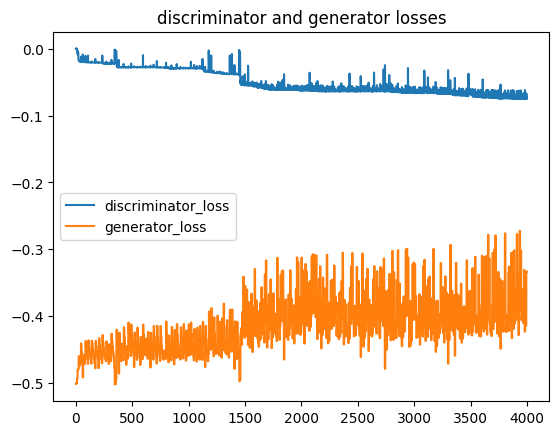

In [91]:
losses,gen =train_GAN(
            learning_rate = 0.005,
            num_epochs = 40,
            N_z = N_z, # as set in paper
            n_in_epoch=100,
            batch_size = 100,
            update_gen = 5, # update gen every n step 
            val_clip = 0.01
                )
losses_df = pd.DataFrame(data=losses,columns=['discriminator_loss','generator_loss'])
plt.plot(losses_df['discriminator_loss'],label = 'discriminator_loss')
plt.plot(losses_df['generator_loss'],label='generator_loss')
plt.legend()
plt.title('discriminator and generator losses')
plt.show()


In [108]:
noise = torch.randn(1, len(log_returns_normalized), N_z, device=device)
generated_snp_gaus = gen(noise).detach().reshape(len(log_returns_normalized)).numpy()
generated_snp_gaus

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

### With such learning rate the solution diverges. Let's try to decrease learning rate and increase number of epochs:

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Generator loss = -0.5032544732093811, Discriminator loss = 5.960464477539062e-07
Generator loss = -0.5028194785118103, Discriminator loss = -0.0008359253406524658
Generator loss = -0.5024155974388123, Discriminator loss = 2.384185791015625e-07
Generator loss = -0.47601962089538574, Discriminator loss = -0.006282031536102295
Generator loss = -0.4722007215023041, Discriminator loss = -0.005506753921508789
Generator loss = -0.5004804730415344, Discriminator loss = -0.0007683634757995605
Generator loss = -0.5008726119995117, Discriminator loss = -0.0012990832328796387
Generator loss = -0.5009572505950928, Discriminator loss = -0.002616405487060547
Generator loss = -0.4988231956958771, Discriminator loss = -0.00271722674369812
Generator loss = -0.4975157380104065, Discriminator loss = -0.002363920211791992
Generator loss = -0.5005337595939636, Discriminator loss = -0.002558112144470215
Generator loss = -0.5009371638298035, Discriminator loss = 0.00012445449829101562
Generator loss = -0.4989

  1%|▍                                       | 1/100 [01:54<3:08:50, 114.45s/it]

Generator loss = -0.5107422471046448, Discriminator loss = -0.004921913146972656
Generator loss = -0.5130925178527832, Discriminator loss = -0.005900084972381592
Generator loss = -0.5116094350814819, Discriminator loss = -0.007094919681549072
Generator loss = -0.4970865249633789, Discriminator loss = -0.01958411931991577
Generator loss = -0.5239999890327454, Discriminator loss = -0.009981989860534668
Generator loss = -0.5281757116317749, Discriminator loss = -0.013657867908477783
Generator loss = -0.5121781229972839, Discriminator loss = -0.018185734748840332
Generator loss = -0.5102394819259644, Discriminator loss = -0.019856810569763184
Generator loss = -0.533420205116272, Discriminator loss = -0.023850679397583008
Generator loss = -0.5317981243133545, Discriminator loss = -0.01610642671585083
Generator loss = -0.525551438331604, Discriminator loss = -0.016678929328918457
Generator loss = -0.4970320165157318, Discriminator loss = -0.018970191478729248
Generator loss = -0.504577815532

  2%|▊                                       | 2/100 [03:44<3:02:57, 112.02s/it]

Generator loss = -0.5044316053390503, Discriminator loss = -0.1101541519165039
Generator loss = -0.675114095211029, Discriminator loss = -0.08973085880279541
Generator loss = -0.5511003732681274, Discriminator loss = -0.10440671443939209
Generator loss = -0.496553897857666, Discriminator loss = -0.16496515274047852
Generator loss = -0.49792057275772095, Discriminator loss = -0.13359129428863525
Generator loss = -0.6599589586257935, Discriminator loss = -0.06230884790420532
Generator loss = -0.49630099534988403, Discriminator loss = -0.15411639213562012
Generator loss = -0.5895698070526123, Discriminator loss = -0.11429870128631592
Generator loss = -0.5449385046958923, Discriminator loss = -0.1284288763999939
Generator loss = -0.4962942600250244, Discriminator loss = -0.16180652379989624
Generator loss = -0.5880905389785767, Discriminator loss = -0.10721695423126221
Generator loss = -0.4959268569946289, Discriminator loss = -0.18589776754379272
Generator loss = -0.5529784560203552, Disc

  3%|█▏                                      | 3/100 [09:50<6:08:13, 227.77s/it]

Generator loss = -0.5607982277870178, Discriminator loss = -0.20144608616828918
Generator loss = -0.499001681804657, Discriminator loss = -0.19601720571517944
Generator loss = -0.5871641039848328, Discriminator loss = -0.20878168940544128
Generator loss = -0.49619731307029724, Discriminator loss = -0.201185405254364
Generator loss = -0.5564137697219849, Discriminator loss = -0.21840351819992065
Generator loss = -0.49924972653388977, Discriminator loss = -0.1986594796180725
Generator loss = -0.5791890621185303, Discriminator loss = -0.21002575755119324
Generator loss = -0.49604228138923645, Discriminator loss = -0.19232362508773804
Generator loss = -0.5659340023994446, Discriminator loss = -0.20005878806114197
Generator loss = -0.4983437657356262, Discriminator loss = -0.20877307653427124
Generator loss = -0.5739670395851135, Discriminator loss = -0.21411001682281494
Generator loss = -0.4963003993034363, Discriminator loss = -0.20621895790100098
Generator loss = -0.5664224624633789, Dis

  4%|█▌                                      | 4/100 [11:16<4:34:48, 171.75s/it]

Generator loss = -0.49649351835250854, Discriminator loss = -0.20872586965560913
Generator loss = -0.514430046081543, Discriminator loss = -0.22379547357559204
Generator loss = -0.4961133897304535, Discriminator loss = -0.2214205265045166
Generator loss = -0.5534691214561462, Discriminator loss = -0.22301653027534485
Generator loss = -0.49855995178222656, Discriminator loss = -0.20408040285110474
Generator loss = -0.5722602605819702, Discriminator loss = -0.21015867590904236
Generator loss = -0.4980655610561371, Discriminator loss = -0.19394677877426147
Generator loss = -0.5663665533065796, Discriminator loss = -0.2096773386001587
Generator loss = -0.4979938864707947, Discriminator loss = -0.20954161882400513
Generator loss = -0.5687881112098694, Discriminator loss = -0.21292293071746826
Generator loss = -0.4966509938240051, Discriminator loss = -0.20767474174499512
Generator loss = -0.5849090814590454, Discriminator loss = -0.20828339457511902
Generator loss = -0.49603477120399475, Di

  5%|██                                      | 5/100 [12:46<3:45:23, 142.35s/it]

Generator loss = -0.4962617754936218, Discriminator loss = -0.21923881769180298
Generator loss = -0.5759345889091492, Discriminator loss = -0.22651419043540955
Generator loss = -0.4959787428379059, Discriminator loss = -0.2414267659187317
Generator loss = -0.562588632106781, Discriminator loss = -0.21745994687080383
Generator loss = -0.49628183245658875, Discriminator loss = -0.20708322525024414
Generator loss = -0.5645601153373718, Discriminator loss = -0.21590283513069153
Generator loss = -0.4961167275905609, Discriminator loss = -0.22515875101089478
Generator loss = -0.5803239345550537, Discriminator loss = -0.21048277616500854
Generator loss = -0.49623605608940125, Discriminator loss = -0.22415691614151
Generator loss = -0.5557984113693237, Discriminator loss = -0.21362614631652832
Generator loss = -0.4962313175201416, Discriminator loss = -0.210984468460083
Generator loss = -0.581490695476532, Discriminator loss = -0.21652236580848694
Generator loss = -0.4983087480068207, Discrimi

  6%|██▍                                     | 6/100 [14:11<3:12:34, 122.92s/it]

Generator loss = -0.49789193272590637, Discriminator loss = -0.22396248579025269
Generator loss = -0.5669859051704407, Discriminator loss = -0.2217588722705841
Generator loss = -0.49623653292655945, Discriminator loss = -0.22637158632278442
Generator loss = -0.5501947402954102, Discriminator loss = -0.21106022596359253
Generator loss = -0.4960702955722809, Discriminator loss = -0.23285198211669922
Generator loss = -0.5463913083076477, Discriminator loss = -0.21616485714912415
Generator loss = -0.49598026275634766, Discriminator loss = -0.23458397388458252
Generator loss = -0.5551419258117676, Discriminator loss = -0.2211357057094574
Generator loss = -0.4966297149658203, Discriminator loss = -0.2151687741279602
Generator loss = -0.5546419024467468, Discriminator loss = -0.2225545048713684
Generator loss = -0.4960344135761261, Discriminator loss = -0.2348840832710266
Generator loss = -0.5630975961685181, Discriminator loss = -0.21954664587974548
Generator loss = -0.496226042509079, Discr

  7%|██▊                                     | 7/100 [15:35<2:50:55, 110.27s/it]

Generator loss = -0.49820205569267273, Discriminator loss = -0.2125692367553711
Generator loss = -0.5508537888526917, Discriminator loss = -0.21461936831474304
Generator loss = -0.4966181814670563, Discriminator loss = -0.2199249267578125
Generator loss = -0.5422596335411072, Discriminator loss = -0.21984410285949707
Generator loss = -0.4973274767398834, Discriminator loss = -0.22573018074035645
Generator loss = -0.5494270324707031, Discriminator loss = -0.22778812050819397
Generator loss = -0.4961514472961426, Discriminator loss = -0.22715646028518677
Generator loss = -0.5730698704719543, Discriminator loss = -0.21027711033821106
Generator loss = -0.49600517749786377, Discriminator loss = -0.22055411338806152
Generator loss = -0.556074321269989, Discriminator loss = -0.21246632933616638
Generator loss = -0.4963495433330536, Discriminator loss = -0.21301734447479248
Generator loss = -0.5719387531280518, Discriminator loss = -0.2123759388923645
Generator loss = -0.49629339575767517, Dis

  8%|███▏                                    | 8/100 [16:58<2:35:29, 101.41s/it]

Generator loss = -0.557623565196991, Discriminator loss = -0.2180616855621338
Generator loss = -0.4962175190448761, Discriminator loss = -0.2151641845703125
Generator loss = -0.5686379671096802, Discriminator loss = -0.2156560719013214
Generator loss = -0.4967702627182007, Discriminator loss = -0.22480154037475586
Generator loss = -0.5481547713279724, Discriminator loss = -0.21900725364685059
Generator loss = -0.4960331618785858, Discriminator loss = -0.22371667623519897
Generator loss = -0.5573137998580933, Discriminator loss = -0.21708887815475464
Generator loss = -0.49636462330818176, Discriminator loss = -0.22627705335617065
Generator loss = -0.567925214767456, Discriminator loss = -0.21941006183624268
Generator loss = -0.49607759714126587, Discriminator loss = -0.22603553533554077
Generator loss = -0.5536004304885864, Discriminator loss = -0.22015351057052612
Generator loss = -0.4961020052433014, Discriminator loss = -0.22206050157546997
Generator loss = -0.5710446834564209, Discr

  9%|███▋                                     | 9/100 [18:14<2:21:51, 93.53s/it]

Generator loss = -0.5570714473724365, Discriminator loss = -0.22443965077400208
Generator loss = -0.49764251708984375, Discriminator loss = -0.21181029081344604
Generator loss = -0.5788612365722656, Discriminator loss = -0.2172757089138031
Generator loss = -0.4960978627204895, Discriminator loss = -0.21250194311141968
Generator loss = -0.5771844983100891, Discriminator loss = -0.21423345804214478
Generator loss = -0.49614372849464417, Discriminator loss = -0.224484384059906
Generator loss = -0.5679863095283508, Discriminator loss = -0.22148820757865906
Generator loss = -0.49653419852256775, Discriminator loss = -0.20913922786712646
Generator loss = -0.5758218765258789, Discriminator loss = -0.21567502617835999
Generator loss = -0.49625611305236816, Discriminator loss = -0.2070412039756775
Generator loss = -0.49597394466400146, Discriminator loss = -0.24623501300811768
Generator loss = -0.5616303086280823, Discriminator loss = -0.21709159016609192
Generator loss = -0.4965972602367401, D

 10%|████                                    | 10/100 [19:40<2:16:40, 91.12s/it]

Generator loss = -0.4961225986480713, Discriminator loss = -0.2271243929862976
Generator loss = -0.5799336433410645, Discriminator loss = -0.2029113471508026
Generator loss = -0.496086061000824, Discriminator loss = -0.22791558504104614
Generator loss = -0.564504086971283, Discriminator loss = -0.21971306204795837
Generator loss = -0.49744489789009094, Discriminator loss = -0.21937644481658936
Generator loss = -0.5501766800880432, Discriminator loss = -0.23106953501701355
Generator loss = -0.4969330132007599, Discriminator loss = -0.22052890062332153
Generator loss = -0.5568467378616333, Discriminator loss = -0.22390598058700562
Generator loss = -0.49691638350486755, Discriminator loss = -0.2236894965171814
Generator loss = -0.5517609119415283, Discriminator loss = -0.21957817673683167
Generator loss = -0.496128112077713, Discriminator loss = -0.22185355424880981
Generator loss = -0.49798423051834106, Discriminator loss = -0.23046433925628662
Generator loss = -0.5598992109298706, Discr

 11%|████▍                                   | 11/100 [20:58<2:09:22, 87.22s/it]

Generator loss = -0.5636937022209167, Discriminator loss = -0.22806233167648315
Generator loss = -0.49629470705986023, Discriminator loss = -0.22116106748580933
Generator loss = -0.5749019980430603, Discriminator loss = -0.22404280304908752
Generator loss = -0.4966423511505127, Discriminator loss = -0.2417272925376892
Generator loss = -0.560856282711029, Discriminator loss = -0.23125389218330383
Generator loss = -0.4965794086456299, Discriminator loss = -0.24122130870819092
Generator loss = -0.5586672425270081, Discriminator loss = -0.22088190913200378
Generator loss = -0.496073842048645, Discriminator loss = -0.23915314674377441
Generator loss = -0.5526653528213501, Discriminator loss = -0.2221958339214325
Generator loss = -0.49593836069107056, Discriminator loss = -0.24268311262130737
Generator loss = -0.5790892839431763, Discriminator loss = -0.2214955985546112
Generator loss = -0.4960552752017975, Discriminator loss = -0.22712939977645874
Generator loss = -0.5604270696640015, Discr

 12%|████▊                                   | 12/100 [22:16<2:03:48, 84.42s/it]

Generator loss = -0.5711929202079773, Discriminator loss = -0.2119097113609314
Generator loss = -0.4959360659122467, Discriminator loss = -0.25273317098617554
Generator loss = -0.5537287592887878, Discriminator loss = -0.22223734855651855
Generator loss = -0.4963245987892151, Discriminator loss = -0.23661494255065918
Generator loss = -0.5748026371002197, Discriminator loss = -0.21662119030952454
Generator loss = -0.49711164832115173, Discriminator loss = -0.25678229331970215
Generator loss = -0.5572081208229065, Discriminator loss = -0.2181222140789032
Generator loss = -0.49622154235839844, Discriminator loss = -0.26409345865249634
Generator loss = -0.5542283058166504, Discriminator loss = -0.22567152976989746
Generator loss = -0.4963754117488861, Discriminator loss = -0.23891812562942505
Generator loss = -0.538284957408905, Discriminator loss = -0.22379136085510254
Generator loss = -0.49658989906311035, Discriminator loss = -0.26028764247894287
Generator loss = -0.5618614554405212, Di

 13%|█████▏                                  | 13/100 [23:45<2:04:34, 85.92s/it]

Generator loss = -0.5415511727333069, Discriminator loss = -0.22623977065086365
Generator loss = -0.4963577389717102, Discriminator loss = -0.2681846618652344
Generator loss = -0.5592262148857117, Discriminator loss = -0.2111382782459259
Generator loss = -0.4960744380950928, Discriminator loss = -0.26848816871643066
Generator loss = -0.5311339497566223, Discriminator loss = -0.22062265872955322
Generator loss = -0.49662163853645325, Discriminator loss = -0.26679784059524536
Generator loss = -0.5331835150718689, Discriminator loss = -0.2192211151123047
Generator loss = -0.49658194184303284, Discriminator loss = -0.26555144786834717
Generator loss = -0.533366858959198, Discriminator loss = -0.21851611137390137
Generator loss = -0.4975605905056, Discriminator loss = -0.25178301334381104
Generator loss = -0.5703805685043335, Discriminator loss = -0.24064838886260986
Generator loss = -0.49580785632133484, Discriminator loss = -0.2661617398262024
Generator loss = -0.5386223793029785, Discrim

 14%|█████▌                                  | 14/100 [25:08<2:01:39, 84.88s/it]

Generator loss = -0.5526166558265686, Discriminator loss = -0.2287568747997284
Generator loss = -0.4965958595275879, Discriminator loss = -0.24655574560165405
Generator loss = -0.5325478911399841, Discriminator loss = -0.22091108560562134
Generator loss = -0.49578213691711426, Discriminator loss = -0.2684243321418762
Generator loss = -0.5422776341438293, Discriminator loss = -0.2239319384098053
Generator loss = -0.496847003698349, Discriminator loss = -0.2630716562271118
Generator loss = -0.5506048798561096, Discriminator loss = -0.2269170880317688
Generator loss = -0.49670273065567017, Discriminator loss = -0.26253098249435425
Generator loss = -0.5458149313926697, Discriminator loss = -0.22420498728752136
Generator loss = -0.4972337782382965, Discriminator loss = -0.24044519662857056
Generator loss = -0.5573472380638123, Discriminator loss = -0.21069538593292236
Generator loss = -0.498150497674942, Discriminator loss = -0.24372875690460205
Generator loss = -0.5390782356262207, Discrim

 15%|██████                                  | 15/100 [26:24<1:56:21, 82.13s/it]

Generator loss = -0.49746954441070557, Discriminator loss = -0.25068819522857666
Generator loss = -0.5399792194366455, Discriminator loss = -0.2245875895023346
Generator loss = -0.4957559108734131, Discriminator loss = -0.2833617925643921
Generator loss = -0.5216673612594604, Discriminator loss = -0.21192282438278198
Generator loss = -0.49601563811302185, Discriminator loss = -0.27317583560943604
Generator loss = -0.5531784892082214, Discriminator loss = -0.21385163068771362
Generator loss = -0.49686285853385925, Discriminator loss = -0.2504500150680542
Generator loss = -0.5449396967887878, Discriminator loss = -0.2312452793121338
Generator loss = -0.4957224130630493, Discriminator loss = -0.2785016894340515
Generator loss = -0.5440393090248108, Discriminator loss = -0.21028244495391846
Generator loss = -0.4959608018398285, Discriminator loss = -0.26329559087753296
Generator loss = -0.5327644348144531, Discriminator loss = -0.22484350204467773
Generator loss = -0.4958902895450592, Disc

 16%|██████▍                                 | 16/100 [27:45<1:54:27, 81.76s/it]

Generator loss = -0.4957655668258667, Discriminator loss = -0.28053921461105347
Generator loss = -0.5468202233314514, Discriminator loss = -0.21336829662322998
Generator loss = -0.49588993191719055, Discriminator loss = -0.26075440645217896
Generator loss = -0.5615113377571106, Discriminator loss = -0.21328702569007874
Generator loss = -0.4969017505645752, Discriminator loss = -0.25311702489852905
Generator loss = -0.5273804068565369, Discriminator loss = -0.21939951181411743
Generator loss = -0.4963703453540802, Discriminator loss = -0.28131258487701416
Generator loss = -0.5616295337677002, Discriminator loss = -0.2940027713775635
Generator loss = -0.49619120359420776, Discriminator loss = -0.27867811918258667
Generator loss = -0.5341281294822693, Discriminator loss = -0.21342617273330688
Generator loss = -0.4958733022212982, Discriminator loss = -0.28331220149993896
Generator loss = -0.5208685994148254, Discriminator loss = -0.2213861644268036
Generator loss = -0.4963895380496979, Di

 17%|██████▊                                 | 17/100 [29:02<1:51:08, 80.34s/it]

Generator loss = -0.49606454372406006, Discriminator loss = -0.2816213369369507
Generator loss = -0.4975244104862213, Discriminator loss = -0.29141587018966675
Generator loss = -0.5232692360877991, Discriminator loss = -0.21769389510154724
Generator loss = -0.4960009455680847, Discriminator loss = -0.2762296199798584
Generator loss = -0.5299118161201477, Discriminator loss = -0.2172551453113556
Generator loss = -0.49645838141441345, Discriminator loss = -0.24982011318206787
Generator loss = -0.5276097059249878, Discriminator loss = -0.2269953489303589
Generator loss = -0.4962930679321289, Discriminator loss = -0.27896571159362793
Generator loss = -0.5734089612960815, Discriminator loss = -0.23858189582824707
Generator loss = -0.49577590823173523, Discriminator loss = -0.28406721353530884
Generator loss = -0.5448841452598572, Discriminator loss = -0.21212539076805115
Generator loss = -0.49594002962112427, Discriminator loss = -0.25635725259780884
Generator loss = -0.5178189873695374, Di

 18%|███████▏                                | 18/100 [30:12<1:45:35, 77.26s/it]

Generator loss = -0.4958793818950653, Discriminator loss = -0.25089871883392334
Generator loss = -0.5369072556495667, Discriminator loss = -0.28896480798721313
Generator loss = -0.49618229269981384, Discriminator loss = -0.2820280194282532
Generator loss = -0.5591350793838501, Discriminator loss = -0.21197447180747986
Generator loss = -0.49624183773994446, Discriminator loss = -0.2527264356613159
Generator loss = -0.5188729763031006, Discriminator loss = -0.2210294008255005
Generator loss = -0.49638569355010986, Discriminator loss = -0.2779805660247803
Generator loss = -0.5265467762947083, Discriminator loss = -0.22022601962089539
Generator loss = -0.4978037476539612, Discriminator loss = -0.28405869007110596
Generator loss = -0.5184165239334106, Discriminator loss = -0.21083709597587585
Generator loss = -0.4961816668510437, Discriminator loss = -0.2742578983306885
Generator loss = -0.5538932681083679, Discriminator loss = -0.20697054266929626
Generator loss = -0.5067294836044312, Disc

 19%|███████▌                                | 19/100 [31:18<1:39:59, 74.06s/it]

Generator loss = -0.49580878019332886, Discriminator loss = -0.27721476554870605
Generator loss = -0.5304383039474487, Discriminator loss = -0.22255557775497437
Generator loss = -0.495961993932724, Discriminator loss = -0.2802833318710327
Generator loss = -0.5518648028373718, Discriminator loss = -0.21181926131248474
Generator loss = -0.4958474636077881, Discriminator loss = -0.27063703536987305
Generator loss = -0.5483110547065735, Discriminator loss = -0.21264347434043884
Generator loss = -0.497166246175766, Discriminator loss = -0.2540239095687866
Generator loss = -0.5435400605201721, Discriminator loss = -0.2325468361377716
Generator loss = -0.4964032471179962, Discriminator loss = -0.25138336420059204
Generator loss = -0.5390197038650513, Discriminator loss = -0.28933125734329224
Generator loss = -0.4961954951286316, Discriminator loss = -0.2619703412055969
Generator loss = -0.5205748081207275, Discriminator loss = -0.2254101037979126
Generator loss = -0.4961283504962921, Discrimi

 20%|████████                                | 20/100 [32:28<1:37:06, 72.83s/it]

Generator loss = -0.5207624435424805, Discriminator loss = -0.21413826942443848
Generator loss = -0.49580317735671997, Discriminator loss = -0.27737075090408325
Generator loss = -0.4960564076900482, Discriminator loss = -0.269270122051239
Generator loss = -0.5152651071548462, Discriminator loss = -0.21123412251472473
Generator loss = -0.4958855211734772, Discriminator loss = -0.27161699533462524
Generator loss = -0.5288146138191223, Discriminator loss = -0.22102832794189453
Generator loss = -0.49645310640335083, Discriminator loss = -0.27744847536087036
Generator loss = -0.5591079592704773, Discriminator loss = -0.208310067653656
Generator loss = -0.49676427245140076, Discriminator loss = -0.2492007613182068
Generator loss = -0.5299745202064514, Discriminator loss = -0.219794362783432
Generator loss = -0.4965081214904785, Discriminator loss = -0.280378520488739
Generator loss = -0.529758870601654, Discriminator loss = -0.29482129216194153
Generator loss = -0.49585890769958496, Discrimi

 21%|████████▍                               | 21/100 [33:49<1:39:05, 75.26s/it]

Generator loss = -0.518718421459198, Discriminator loss = -0.21459662914276123
Generator loss = -0.49586308002471924, Discriminator loss = -0.252565860748291
Generator loss = -0.5074500441551208, Discriminator loss = -0.2910509705543518
Generator loss = -0.49578574299812317, Discriminator loss = -0.2717270851135254
Generator loss = -0.5297780632972717, Discriminator loss = -0.21975582838058472
Generator loss = -0.4959685206413269, Discriminator loss = -0.2697855830192566
Generator loss = -0.5319114327430725, Discriminator loss = -0.22227922081947327
Generator loss = -0.49606603384017944, Discriminator loss = -0.28296780586242676
Generator loss = -0.5570584535598755, Discriminator loss = -0.2072344422340393
Generator loss = -0.497555673122406, Discriminator loss = -0.2537689208984375
Generator loss = -0.5320919752120972, Discriminator loss = -0.22178474068641663
Generator loss = -0.4962051808834076, Discriminator loss = -0.2525559067726135
Generator loss = -0.5228570699691772, Discrimin

 22%|████████▊                               | 22/100 [34:53<1:33:33, 71.97s/it]

Generator loss = -0.49663016200065613, Discriminator loss = -0.2534756660461426
Generator loss = -0.5576567649841309, Discriminator loss = -0.20910486578941345
Generator loss = -0.49625569581985474, Discriminator loss = -0.253323495388031
Generator loss = -0.5188234448432922, Discriminator loss = -0.22068938612937927
Generator loss = -0.49634864926338196, Discriminator loss = -0.27899444103240967
Generator loss = -0.5289998054504395, Discriminator loss = -0.2944934368133545
Generator loss = -0.49573802947998047, Discriminator loss = -0.283380925655365
Generator loss = -0.5444914698600769, Discriminator loss = -0.21432825922966003
Generator loss = -0.4957752227783203, Discriminator loss = -0.2870411276817322
Generator loss = -0.522219717502594, Discriminator loss = -0.2134341597557068
Generator loss = -0.49583712220191956, Discriminator loss = -0.2739562392234802
Generator loss = -0.5595341920852661, Discriminator loss = -0.2067183554172516
Generator loss = -0.49687907099723816, Discrim

 23%|█████████▏                              | 23/100 [35:58<1:29:38, 69.85s/it]

Generator loss = -0.5690909624099731, Discriminator loss = -0.21275505423545837
Generator loss = -0.4971567690372467, Discriminator loss = -0.2567495107650757
Generator loss = -0.5328497290611267, Discriminator loss = -0.21966955065727234
Generator loss = -0.4960695803165436, Discriminator loss = -0.2803191542625427
Generator loss = -0.5585107803344727, Discriminator loss = -0.2101980447769165
Generator loss = -0.496441513299942, Discriminator loss = -0.25225526094436646
Generator loss = -0.5216218829154968, Discriminator loss = -0.21480166912078857
Generator loss = -0.49593880772590637, Discriminator loss = -0.2797759771347046
Generator loss = -0.5252189636230469, Discriminator loss = -0.2220361828804016
Generator loss = -0.49594995379447937, Discriminator loss = -0.27346551418304443
Generator loss = -0.5590760707855225, Discriminator loss = -0.2122524082660675
Generator loss = -0.4960460662841797, Discriminator loss = -0.25576043128967285
Generator loss = -0.5457680821418762, Discrim

 24%|█████████▌                              | 24/100 [37:02<1:25:56, 67.85s/it]

Generator loss = -0.5169764757156372, Discriminator loss = -0.2945616841316223
Generator loss = -0.4956488311290741, Discriminator loss = -0.27832919359207153
Generator loss = -0.5588209629058838, Discriminator loss = -0.20958003401756287
Generator loss = -0.4973771274089813, Discriminator loss = -0.2553935647010803
Generator loss = -0.5252087116241455, Discriminator loss = -0.2178453803062439
Generator loss = -0.4976910948753357, Discriminator loss = -0.2846413254737854
Generator loss = -0.5210798978805542, Discriminator loss = -0.2122383415699005
Generator loss = -0.4963867664337158, Discriminator loss = -0.278354287147522
Generator loss = -0.49725595116615295, Discriminator loss = -0.2911651134490967
Generator loss = -0.5191968679428101, Discriminator loss = -0.21354195475578308
Generator loss = -0.49604299664497375, Discriminator loss = -0.2696484327316284
Generator loss = -0.5586130023002625, Discriminator loss = -0.21403083205223083
Generator loss = -0.49659669399261475, Discrimi

 25%|██████████                              | 25/100 [38:04<1:22:57, 66.36s/it]

Generator loss = -0.5254084467887878, Discriminator loss = -0.21817147731781006
Generator loss = -0.4958259165287018, Discriminator loss = -0.27245032787323
Generator loss = -0.49830007553100586, Discriminator loss = -0.2915326952934265
Generator loss = -0.49589666724205017, Discriminator loss = -0.266595721244812
Generator loss = -0.5359807014465332, Discriminator loss = -0.22364920377731323
Generator loss = -0.49713456630706787, Discriminator loss = -0.250262975692749
Generator loss = -0.5284441113471985, Discriminator loss = -0.21877065300941467
Generator loss = -0.4999409317970276, Discriminator loss = -0.283937931060791
Generator loss = -0.4958469569683075, Discriminator loss = -0.270505428314209
Generator loss = -0.5532928109169006, Discriminator loss = -0.20850986242294312
Generator loss = -0.49618837237358093, Discriminator loss = -0.24900853633880615
Generator loss = -0.5263301134109497, Discriminator loss = -0.22218289971351624
Generator loss = -0.49600812792778015, Discrimin

 26%|██████████▍                             | 26/100 [39:08<1:20:44, 65.46s/it]

Generator loss = -0.5062391757965088, Discriminator loss = -0.28204184770584106
Generator loss = -0.5205715298652649, Discriminator loss = -0.21490168571472168
Generator loss = -0.5230544805526733, Discriminator loss = -0.21291232109069824
Generator loss = -0.49587053060531616, Discriminator loss = -0.25078147649765015
Generator loss = -0.5386304259300232, Discriminator loss = -0.2906157374382019
Generator loss = -0.49606621265411377, Discriminator loss = -0.27901846170425415
Generator loss = -0.5623615384101868, Discriminator loss = -0.21060875058174133
Generator loss = -0.4964458644390106, Discriminator loss = -0.2508138418197632
Generator loss = -0.5186248421669006, Discriminator loss = -0.21998098492622375
Generator loss = -0.4963470697402954, Discriminator loss = -0.27904045581817627
Generator loss = -0.5288311243057251, Discriminator loss = -0.2193710207939148
Generator loss = -0.49646154046058655, Discriminator loss = -0.28240513801574707
Generator loss = -0.5590192675590515, Di

 27%|██████████▊                             | 27/100 [40:12<1:19:12, 65.11s/it]

Generator loss = -0.4960741698741913, Discriminator loss = -0.28200387954711914
Generator loss = -0.5552255511283875, Discriminator loss = -0.21464303135871887
Generator loss = -0.497276246547699, Discriminator loss = -0.2509682774543762
Generator loss = -0.5271517038345337, Discriminator loss = -0.2190645933151245
Generator loss = -0.503901481628418, Discriminator loss = -0.2833147644996643
Generator loss = -0.517178475856781, Discriminator loss = -0.20724299550056458
Generator loss = -0.4959537982940674, Discriminator loss = -0.25553780794143677
Generator loss = -0.5302503108978271, Discriminator loss = -0.22310209274291992
Generator loss = -0.4964927136898041, Discriminator loss = -0.27527499198913574
Generator loss = -0.5562154650688171, Discriminator loss = -0.20574480295181274
Generator loss = -0.5065885186195374, Discriminator loss = -0.2824942469596863
Generator loss = -0.5384684205055237, Discriminator loss = -0.2143290638923645
Generator loss = -0.5039049983024597, Discrimina

 28%|███████████▏                            | 28/100 [41:16<1:17:44, 64.78s/it]

Generator loss = -0.49440741539001465, Discriminator loss = -0.0022360682487487793
Generator loss = -0.49440646171569824, Discriminator loss = -0.002239048480987549
Generator loss = -0.4944055378437042, Discriminator loss = -0.0022422075271606445
Generator loss = -0.49440428614616394, Discriminator loss = -0.002245396375656128
Generator loss = -0.49440327286720276, Discriminator loss = -0.002248406410217285
Generator loss = -0.49440187215805054, Discriminator loss = -0.002250880002975464
Generator loss = -0.4944004416465759, Discriminator loss = -0.002253293991088867
Generator loss = -0.4943987727165222, Discriminator loss = -0.002255678176879883
Generator loss = -0.4943971335887909, Discriminator loss = -0.0022580325603485107
Generator loss = -0.4943954646587372, Discriminator loss = -0.0022607743740081787
Generator loss = -0.49439361691474915, Discriminator loss = -0.002263486385345459
Generator loss = -0.49439162015914917, Discriminator loss = -0.0022658109664916992
Generator loss =

 29%|███████████▌                            | 29/100 [42:20<1:16:16, 64.46s/it]

Generator loss = -0.4943869113922119, Discriminator loss = -0.002278745174407959
Generator loss = -0.49438831210136414, Discriminator loss = -0.002278834581375122
Generator loss = -0.49438977241516113, Discriminator loss = -0.002279222011566162
Generator loss = -0.4943910837173462, Discriminator loss = -0.0022795498371124268
Generator loss = -0.4943925738334656, Discriminator loss = -0.002279609441757202
Generator loss = -0.4943940341472626, Discriminator loss = -0.0022798478603363037
Generator loss = -0.4943954050540924, Discriminator loss = -0.002279996871948242
Generator loss = -0.4943973124027252, Discriminator loss = -0.0022802650928497314
Generator loss = -0.4943995773792267, Discriminator loss = -0.0022804737091064453
Generator loss = -0.49440181255340576, Discriminator loss = -0.0022806525230407715
Generator loss = -0.4944040775299072, Discriminator loss = -0.0022811293601989746
Generator loss = -0.49440646171569824, Discriminator loss = -0.0022812187671661377
Generator loss = 

 30%|████████████                            | 30/100 [43:25<1:15:21, 64.59s/it]

Generator loss = -0.4943811893463135, Discriminator loss = -0.002304762601852417
Generator loss = -0.494383305311203, Discriminator loss = -0.0023050904273986816
Generator loss = -0.4943855106830597, Discriminator loss = -0.0023055076599121094
Generator loss = -0.4943877160549164, Discriminator loss = -0.0023056864738464355
Generator loss = -0.494390070438385, Discriminator loss = -0.0023059844970703125
Generator loss = -0.494392454624176, Discriminator loss = -0.0023062527179718018
Generator loss = -0.4943949282169342, Discriminator loss = -0.002306610345840454
Generator loss = -0.49439737200737, Discriminator loss = -0.002306908369064331
Generator loss = -0.4943999946117401, Discriminator loss = -0.002307027578353882
Generator loss = -0.4944029450416565, Discriminator loss = -0.002307295799255371
Generator loss = -0.4944060742855072, Discriminator loss = -0.0023075342178344727
Generator loss = -0.4944092035293579, Discriminator loss = -0.002307683229446411
Generator loss = -0.4944124

 31%|████████████▍                           | 31/100 [44:29<1:14:00, 64.36s/it]

Generator loss = -0.4944414794445038, Discriminator loss = -0.0023093223571777344
Generator loss = -0.4944455027580261, Discriminator loss = -0.002309560775756836
Generator loss = -0.4944494962692261, Discriminator loss = -0.0023097991943359375
Generator loss = -0.49445366859436035, Discriminator loss = -0.002309948205947876
Generator loss = -0.49445784091949463, Discriminator loss = -0.00231015682220459
Generator loss = -0.49446216225624084, Discriminator loss = -0.0023105740547180176
Generator loss = -0.4944666922092438, Discriminator loss = -0.0023107528686523438
Generator loss = -0.4944712817668915, Discriminator loss = -0.0023109912872314453
Generator loss = -0.494476854801178, Discriminator loss = -0.0023111701011657715
Generator loss = -0.4944835305213928, Discriminator loss = -0.00231131911277771
Generator loss = -0.4944903552532196, Discriminator loss = -0.0023117363452911377
Generator loss = -0.4944974482059479, Discriminator loss = -0.0023117661476135254
Generator loss = -0.

 32%|████████████▊                           | 32/100 [45:33<1:12:56, 64.37s/it]

Generator loss = -0.49457043409347534, Discriminator loss = -0.002314269542694092
Generator loss = -0.49457964301109314, Discriminator loss = -0.0023145079612731934
Generator loss = -0.49458929896354675, Discriminator loss = -0.002314925193786621
Generator loss = -0.49459895491600037, Discriminator loss = -0.0023151040077209473
Generator loss = -0.4946087896823883, Discriminator loss = -0.0023154914379119873
Generator loss = -0.4946189820766449, Discriminator loss = -0.0023157894611358643
Generator loss = -0.4946301281452179, Discriminator loss = -0.0023161470890045166
Generator loss = -0.49464151263237, Discriminator loss = -0.0023165643215179443
Generator loss = -0.4946535527706146, Discriminator loss = -0.0023170411586761475
Generator loss = -0.49466672539711, Discriminator loss = -0.002317458391189575
Generator loss = -0.49468448758125305, Discriminator loss = -0.002318650484085083
Generator loss = -0.4947035312652588, Discriminator loss = -0.0023202896118164062
Generator loss = -0

 33%|█████████████▏                          | 33/100 [46:41<1:13:04, 65.44s/it]

Generator loss = -0.5847839713096619, Discriminator loss = -0.10580265522003174
Generator loss = -0.6748914122581482, Discriminator loss = -0.09975558519363403
Generator loss = -0.4967483878135681, Discriminator loss = -0.17456281185150146
Generator loss = -0.7750487327575684, Discriminator loss = -0.21607640385627747
Generator loss = -0.624556839466095, Discriminator loss = -0.11878883838653564
Generator loss = -0.5477242469787598, Discriminator loss = -0.16010946035385132
Generator loss = -0.49499285221099854, Discriminator loss = -0.002185732126235962
Generator loss = -0.4949805438518524, Discriminator loss = -0.0022207796573638916
Generator loss = -0.49496811628341675, Discriminator loss = -0.0022574663162231445
Generator loss = -0.49497008323669434, Discriminator loss = -0.0022866427898406982
Generator loss = -0.4949776232242584, Discriminator loss = -0.0023247599601745605
Generator loss = -0.49498626589775085, Discriminator loss = -0.0023505687713623047
Generator loss = -0.495338

 34%|█████████████▌                          | 34/100 [47:45<1:11:28, 64.98s/it]

Generator loss = -0.494339257478714, Discriminator loss = -0.002194613218307495
Generator loss = -0.49433985352516174, Discriminator loss = -0.0021951794624328613
Generator loss = -0.49434059858322144, Discriminator loss = -0.002195805311203003
Generator loss = -0.49434179067611694, Discriminator loss = -0.002196073532104492
Generator loss = -0.4943430423736572, Discriminator loss = -0.0021961331367492676
Generator loss = -0.49434447288513184, Discriminator loss = -0.0021959245204925537
Generator loss = -0.4943457841873169, Discriminator loss = -0.0021962225437164307
Generator loss = -0.4943472445011139, Discriminator loss = -0.002196282148361206
Generator loss = -0.4943486154079437, Discriminator loss = -0.0021963417530059814
Generator loss = -0.4943501353263855, Discriminator loss = -0.002196401357650757
Generator loss = -0.4943516254425049, Discriminator loss = -0.0021964311599731445
Generator loss = -0.49435320496559143, Discriminator loss = -0.002196580171585083
Generator loss = -

 35%|██████████████                          | 35/100 [48:51<1:10:42, 65.26s/it]

Generator loss = -0.494369238615036, Discriminator loss = -0.0021968185901641846
Generator loss = -0.49437129497528076, Discriminator loss = -0.0021969079971313477
Generator loss = -0.4943733811378479, Discriminator loss = -0.002196788787841797
Generator loss = -0.494375616312027, Discriminator loss = -0.00219687819480896
Generator loss = -0.49437785148620605, Discriminator loss = -0.00219687819480896
Generator loss = -0.49438023567199707, Discriminator loss = -0.00219687819480896
Generator loss = -0.4943826198577881, Discriminator loss = -0.0021969974040985107
Generator loss = -0.49438512325286865, Discriminator loss = -0.0021969079971313477
Generator loss = -0.49438759684562683, Discriminator loss = -0.002197057008743286
Generator loss = -0.49439018964767456, Discriminator loss = -0.002197057008743286
Generator loss = -0.49439287185668945, Discriminator loss = -0.002197057008743286
Generator loss = -0.4943956136703491, Discriminator loss = -0.002196967601776123
Generator loss = -0.49

 36%|██████████████▍                         | 36/100 [50:08<1:13:33, 68.96s/it]

Generator loss = -0.49442362785339355, Discriminator loss = -0.0021969974040985107
Generator loss = -0.49442729353904724, Discriminator loss = -0.0021971464157104492
Generator loss = -0.49443092942237854, Discriminator loss = -0.0021972954273223877
Generator loss = -0.49443474411964417, Discriminator loss = -0.0021973252296447754
Generator loss = -0.49443867802619934, Discriminator loss = -0.002197265625
Generator loss = -0.4944426417350769, Discriminator loss = -0.0021972060203552246
Generator loss = -0.49444666504859924, Discriminator loss = -0.0021972954273223877
Generator loss = -0.49445080757141113, Discriminator loss = -0.0021975338459014893
Generator loss = -0.49445509910583496, Discriminator loss = -0.002197474241256714
Generator loss = -0.4944593608379364, Discriminator loss = -0.002197563648223877
Generator loss = -0.49446365237236023, Discriminator loss = -0.0021975040435791016
Generator loss = -0.494468092918396, Discriminator loss = -0.0021975040435791016
Generator loss = 

 37%|██████████████▊                         | 37/100 [51:25<1:14:56, 71.37s/it]

Generator loss = -0.49451345205307007, Discriminator loss = -0.0021980702877044678
Generator loss = -0.49451905488967896, Discriminator loss = -0.0021979808807373047
Generator loss = -0.49452486634254456, Discriminator loss = -0.0021980106830596924
Generator loss = -0.4945308566093445, Discriminator loss = -0.0021981000900268555
Generator loss = -0.4945369362831116, Discriminator loss = -0.0021981000900268555
Generator loss = -0.49454325437545776, Discriminator loss = -0.002198249101638794
Generator loss = -0.49454960227012634, Discriminator loss = -0.0021979212760925293
Generator loss = -0.49455609917640686, Discriminator loss = -0.0021982192993164062
Generator loss = -0.4945627450942993, Discriminator loss = -0.0021981000900268555
Generator loss = -0.4945695400238037, Discriminator loss = -0.002198338508605957
Generator loss = -0.4945765733718872, Discriminator loss = -0.0021980702877044678
Generator loss = -0.49458375573158264, Discriminator loss = -0.0021983981132507324
Generator l

 38%|███████████████▏                        | 38/100 [52:45<1:16:12, 73.75s/it]

Generator loss = -0.4946538209915161, Discriminator loss = -0.0021986961364746094
Generator loss = -0.49466246366500854, Discriminator loss = -0.0021988749504089355
Generator loss = -0.49467161297798157, Discriminator loss = -0.0021989941596984863
Generator loss = -0.4946809709072113, Discriminator loss = -0.002199113368988037
Generator loss = -0.4946903884410858, Discriminator loss = -0.0021992623805999756
Generator loss = -0.49469998478889465, Discriminator loss = -0.0021994411945343018
Generator loss = -0.49470987915992737, Discriminator loss = -0.002199709415435791
Generator loss = -0.49472007155418396, Discriminator loss = -0.0022001266479492188
Generator loss = -0.4947303235530853, Discriminator loss = -0.0022009313106536865
Generator loss = -0.49474021792411804, Discriminator loss = -0.002201765775680542
Generator loss = -0.49481362104415894, Discriminator loss = -0.0022216439247131348
Generator loss = -0.49503079056739807, Discriminator loss = -0.00230330228805542
Generator los

 39%|███████████████▌                        | 39/100 [54:07<1:17:33, 76.29s/it]

Generator loss = -0.494890958070755, Discriminator loss = -0.002410799264907837
Generator loss = -0.49489468336105347, Discriminator loss = -0.0024115145206451416
Generator loss = -0.49489906430244446, Discriminator loss = -0.002411574125289917
Generator loss = -0.49490395188331604, Discriminator loss = -0.0024115443229675293
Generator loss = -0.49490904808044434, Discriminator loss = -0.0024114251136779785
Generator loss = -0.494914174079895, Discriminator loss = -0.0024116337299346924
Generator loss = -0.4949195981025696, Discriminator loss = -0.002411752939224243
Generator loss = -0.4949251413345337, Discriminator loss = -0.0024120211601257324
Generator loss = -0.4949307441711426, Discriminator loss = -0.002411872148513794
Generator loss = -0.4949367046356201, Discriminator loss = -0.0024118423461914062
Generator loss = -0.4949427843093872, Discriminator loss = -0.0024121105670928955
Generator loss = -0.4949491322040558, Discriminator loss = -0.0024121999740600586
Generator loss = -

 40%|████████████████                        | 40/100 [55:24<1:16:27, 76.47s/it]

Generator loss = -0.49503806233406067, Discriminator loss = -0.0024142861366271973
Generator loss = -0.4950503706932068, Discriminator loss = -0.0024147629737854004
Generator loss = -0.49506300687789917, Discriminator loss = -0.0024151206016540527
Generator loss = -0.4950759708881378, Discriminator loss = -0.0024151504039764404
Generator loss = -0.49508926272392273, Discriminator loss = -0.002415478229522705
Generator loss = -0.4951028823852539, Discriminator loss = -0.002416074275970459
Generator loss = -0.4951169192790985, Discriminator loss = -0.00241658091545105
Generator loss = -0.4952179193496704, Discriminator loss = -0.0024665892124176025
Generator loss = -0.49615368247032166, Discriminator loss = -0.0018402636051177979
Generator loss = -0.49599689245224, Discriminator loss = -0.002664923667907715
Generator loss = -0.4953113794326782, Discriminator loss = -0.001955360174179077
Generator loss = -0.49517011642456055, Discriminator loss = -0.0021727681159973145
Generator loss = -0

 41%|████████████████▍                       | 41/100 [56:39<1:14:57, 76.24s/it]

Generator loss = -0.4951924979686737, Discriminator loss = -0.002175748348236084
Generator loss = -0.49519509077072144, Discriminator loss = -0.002176046371459961
Generator loss = -0.4951975345611572, Discriminator loss = -0.002176731824874878
Generator loss = -0.4951997697353363, Discriminator loss = -0.0021773874759674072
Generator loss = -0.4952012300491333, Discriminator loss = -0.0021785199642181396
Generator loss = -0.49520143866539, Discriminator loss = -0.002180635929107666
Generator loss = -0.49520212411880493, Discriminator loss = -0.0021831095218658447
Generator loss = -0.4952056109905243, Discriminator loss = -0.0021835267543792725
Generator loss = -0.4952097237110138, Discriminator loss = -0.0021837055683135986
Generator loss = -0.4952138066291809, Discriminator loss = -0.002183586359024048
Generator loss = -0.49521803855895996, Discriminator loss = -0.0021837055683135986
Generator loss = -0.49522241950035095, Discriminator loss = -0.002183765172958374
Generator loss = -0.

 42%|████████████████▊                       | 42/100 [58:08<1:17:16, 79.93s/it]

Generator loss = -0.4952668249607086, Discriminator loss = -0.002184271812438965
Generator loss = -0.49527236819267273, Discriminator loss = -0.002184271812438965
Generator loss = -0.49527812004089355, Discriminator loss = -0.002184361219406128
Generator loss = -0.4952840209007263, Discriminator loss = -0.0021842122077941895
Generator loss = -0.49529004096984863, Discriminator loss = -0.0021844804286956787
Generator loss = -0.4952962398529053, Discriminator loss = -0.0021844804286956787
Generator loss = -0.49530258774757385, Discriminator loss = -0.002184569835662842
Generator loss = -0.4953090250492096, Discriminator loss = -0.002184540033340454
Generator loss = -0.4953155815601349, Discriminator loss = -0.002184629440307617
Generator loss = -0.4953221082687378, Discriminator loss = -0.0021845996379852295
Generator loss = -0.495328813791275, Discriminator loss = -0.0021844804286956787
Generator loss = -0.4953356385231018, Discriminator loss = -0.0021845996379852295
Generator loss = -0

 43%|█████████████████▏                      | 43/100 [59:25<1:15:02, 78.98s/it]

Generator loss = -0.49540531635284424, Discriminator loss = -0.0021851062774658203
Generator loss = -0.4954140782356262, Discriminator loss = -0.002185046672821045
Generator loss = -0.4954230487346649, Discriminator loss = -0.002185046672821045
Generator loss = -0.4954322278499603, Discriminator loss = -0.002184957265853882
Generator loss = -0.4954416751861572, Discriminator loss = -0.002185344696044922
Generator loss = -0.4954512417316437, Discriminator loss = -0.0021851658821105957
Generator loss = -0.495461106300354, Discriminator loss = -0.0021854639053344727
Generator loss = -0.4954710602760315, Discriminator loss = -0.002185314893722534
Generator loss = -0.4954816699028015, Discriminator loss = -0.0021854639053344727
Generator loss = -0.49549251794815063, Discriminator loss = -0.0021854937076568604
Generator loss = -0.4955032765865326, Discriminator loss = -0.002185523509979248
Generator loss = -0.49551430344581604, Discriminator loss = -0.002185642719268799
Generator loss = -0.4

 44%|████████████████▋                     | 44/100 [1:00:58<1:17:47, 83.34s/it]

Generator loss = -0.49562564492225647, Discriminator loss = -0.002186030149459839
Generator loss = -0.4956393539905548, Discriminator loss = -0.0021864473819732666
Generator loss = -0.4956534206867218, Discriminator loss = -0.0021861791610717773
Generator loss = -0.4956672489643097, Discriminator loss = -0.002186417579650879
Generator loss = -0.49568137526512146, Discriminator loss = -0.0021865367889404297
Generator loss = -0.4956958591938019, Discriminator loss = -0.0021864771842956543
Generator loss = -0.49571049213409424, Discriminator loss = -0.0021865367889404297
Generator loss = -0.49572569131851196, Discriminator loss = -0.0021866559982299805
Generator loss = -0.495741069316864, Discriminator loss = -0.002186805009841919
Generator loss = -0.4957571029663086, Discriminator loss = -0.002186805009841919
Generator loss = -0.49577340483665466, Discriminator loss = -0.0021867752075195312
Generator loss = -0.4957900047302246, Discriminator loss = -0.0021871328353881836
Generator loss =

 45%|█████████████████                     | 45/100 [1:02:31<1:18:59, 86.17s/it]

Generator loss = -0.4974339008331299, Discriminator loss = 2.79843807220459e-05
Generator loss = -0.49757882952690125, Discriminator loss = -0.0005806088447570801
Generator loss = -0.4977145791053772, Discriminator loss = -0.0014199018478393555
Generator loss = -0.49797898530960083, Discriminator loss = -0.0028895437717437744
Generator loss = -0.4987536668777466, Discriminator loss = -0.007197946310043335
Generator loss = -0.5075244307518005, Discriminator loss = -0.038955867290496826
Generator loss = -0.5473389625549316, Discriminator loss = -0.07399207353591919
Generator loss = -0.5140319466590881, Discriminator loss = -0.07940417528152466
Generator loss = -0.5025848746299744, Discriminator loss = -0.08048337697982788
Generator loss = -0.5509609580039978, Discriminator loss = -0.07605618238449097
Generator loss = -0.5565940141677856, Discriminator loss = -0.11212301254272461
Generator loss = -0.5208389759063721, Discriminator loss = -0.11331653594970703
Generator loss = -0.5617660880

 46%|█████████████████▍                    | 46/100 [1:04:03<1:19:04, 87.86s/it]

Generator loss = -0.5682785511016846, Discriminator loss = -0.10806083679199219
Generator loss = -0.49753570556640625, Discriminator loss = -0.11948394775390625
Generator loss = -0.5345233082771301, Discriminator loss = -0.11525130271911621
Generator loss = -0.5925598740577698, Discriminator loss = -0.10537540912628174
Generator loss = -0.5103839635848999, Discriminator loss = -0.11872148513793945
Generator loss = -0.5173912048339844, Discriminator loss = -0.11773699522018433
Generator loss = -0.5642131567001343, Discriminator loss = -0.11178988218307495
Generator loss = -0.49677368998527527, Discriminator loss = -0.12015193700790405
Generator loss = -0.5349885821342468, Discriminator loss = -0.11574888229370117
Generator loss = -0.5897260904312134, Discriminator loss = -0.10664010047912598
Generator loss = -0.5105616450309753, Discriminator loss = -0.11860859394073486
Generator loss = -0.571580171585083, Discriminator loss = -0.10917925834655762
Generator loss = -0.5007278323173523, D

 47%|█████████████████▊                    | 47/100 [1:05:16<1:13:42, 83.44s/it]

Generator loss = -0.5696216821670532, Discriminator loss = -0.1097516417503357
Generator loss = -0.5023199319839478, Discriminator loss = -0.11957144737243652
Generator loss = -0.5526273250579834, Discriminator loss = -0.11512607336044312
Generator loss = -0.5560503602027893, Discriminator loss = -0.12164431810379028
Generator loss = -0.49781811237335205, Discriminator loss = -0.12223029136657715
Generator loss = -0.5258640646934509, Discriminator loss = -0.1192924976348877
Generator loss = -0.5842118859291077, Discriminator loss = -0.10969603061676025
Generator loss = -0.5071768164634705, Discriminator loss = -0.12155485153198242
Generator loss = -0.5510265231132507, Discriminator loss = -0.1162346601486206
Generator loss = -0.5804203152656555, Discriminator loss = -0.12382230162620544
Generator loss = -0.500824511051178, Discriminator loss = -0.12230169773101807
Generator loss = -0.5408596992492676, Discriminator loss = -0.11843574047088623
Generator loss = -0.5655953288078308, Discr

 48%|██████████████████▏                   | 48/100 [1:06:38<1:11:57, 83.02s/it]

Generator loss = -0.526334285736084, Discriminator loss = -0.1202513575553894
Generator loss = -0.5822648406028748, Discriminator loss = -0.1109655499458313
Generator loss = -0.506109893321991, Discriminator loss = -0.12263059616088867
Generator loss = -0.5490237474441528, Discriminator loss = -0.11741501092910767
Generator loss = -0.6118213534355164, Discriminator loss = -0.12252569198608398
Generator loss = -0.5226964950561523, Discriminator loss = -0.12081623077392578
Generator loss = -0.49707499146461487, Discriminator loss = -0.12346971035003662
Generator loss = -0.5202696323394775, Discriminator loss = -0.12104731798171997
Generator loss = -0.5665206909179688, Discriminator loss = -0.11331796646118164
Generator loss = -0.4972752332687378, Discriminator loss = -0.12339764833450317
Generator loss = -0.5072289705276489, Discriminator loss = -0.12262672185897827
Generator loss = -0.5505254864692688, Discriminator loss = -0.11725467443466187
Generator loss = -0.5878720879554749, Discr

 49%|██████████████████▌                   | 49/100 [1:07:55<1:08:57, 81.13s/it]

Generator loss = -0.5372396111488342, Discriminator loss = -0.11910355091094971
Generator loss = -0.6027716398239136, Discriminator loss = -0.11799103021621704
Generator loss = -0.5187985301017761, Discriminator loss = -0.12147277593612671
Generator loss = -0.5687370896339417, Discriminator loss = -0.11305224895477295
Generator loss = -0.497667133808136, Discriminator loss = -0.12345504760742188
Generator loss = -0.581693708896637, Discriminator loss = -0.11150288581848145
Generator loss = -0.5050928592681885, Discriminator loss = -0.12275409698486328
Generator loss = -0.5513532757759094, Discriminator loss = -0.1170310378074646
Generator loss = -0.49740076065063477, Discriminator loss = -0.12495839595794678
Generator loss = -0.4952073395252228, Discriminator loss = -0.0025706589221954346
Generator loss = -0.49518001079559326, Discriminator loss = -0.0027174949645996094
Generator loss = -0.49517157673835754, Discriminator loss = -0.002867460250854492
Generator loss = -0.495166093111038

 50%|███████████████████                   | 50/100 [1:09:14<1:07:04, 80.49s/it]

Generator loss = -0.4951433837413788, Discriminator loss = -0.0034326910972595215
Generator loss = -0.49515217542648315, Discriminator loss = -0.0034341812133789062
Generator loss = -0.4951479434967041, Discriminator loss = -0.003441154956817627
Generator loss = -0.4951489567756653, Discriminator loss = -0.0034469962120056152
Generator loss = -0.4951830208301544, Discriminator loss = -0.0034419894218444824
Generator loss = -0.4951752722263336, Discriminator loss = -0.003449380397796631
Generator loss = -0.4951734244823456, Discriminator loss = -0.0034571290016174316
Generator loss = -0.49518489837646484, Discriminator loss = -0.0034582316875457764
Generator loss = -0.49518707394599915, Discriminator loss = -0.0034606456756591797
Generator loss = -0.49518918991088867, Discriminator loss = -0.0034634172916412354
Generator loss = -0.49519139528274536, Discriminator loss = -0.0034660398960113525
Generator loss = -0.49550023674964905, Discriminator loss = -0.005350559949874878
Generator los

 51%|███████████████████▍                  | 51/100 [1:10:36<1:06:04, 80.90s/it]

Generator loss = -0.4955768883228302, Discriminator loss = -0.005365967750549316
Generator loss = -0.495528906583786, Discriminator loss = -0.0053844153881073
Generator loss = -0.4955458343029022, Discriminator loss = -0.005382150411605835
Generator loss = -0.4955061078071594, Discriminator loss = -0.005399912595748901
Generator loss = -0.49553778767585754, Discriminator loss = -0.005396544933319092
Generator loss = -0.49549227952957153, Discriminator loss = -0.0054153501987457275
Generator loss = -0.4955317974090576, Discriminator loss = -0.005412936210632324
Generator loss = -0.49548277258872986, Discriminator loss = -0.005429893732070923
Generator loss = -0.49556347727775574, Discriminator loss = -0.005417346954345703
Generator loss = -0.4956842064857483, Discriminator loss = -0.0053740739822387695
Generator loss = -0.4956241250038147, Discriminator loss = -0.005393892526626587
Generator loss = -0.49565187096595764, Discriminator loss = -0.005390137434005737
Generator loss = -0.4956

 52%|███████████████████▊                  | 52/100 [1:12:03<1:06:14, 82.80s/it]

Generator loss = -0.5827513337135315, Discriminator loss = -0.09608525037765503
Generator loss = -0.5334240794181824, Discriminator loss = -0.1201467514038086
Generator loss = -0.5017528533935547, Discriminator loss = -0.12733972072601318
Generator loss = -0.4976024925708771, Discriminator loss = -0.12798166275024414
Generator loss = -0.5059617161750793, Discriminator loss = -0.12604999542236328
Generator loss = -0.533602237701416, Discriminator loss = -0.12219303846359253
Generator loss = -0.5220960378646851, Discriminator loss = -0.12390333414077759
Generator loss = -0.5508657693862915, Discriminator loss = -0.11659932136535645
Generator loss = -0.5898014903068542, Discriminator loss = -0.11205887794494629
Generator loss = -0.6293897032737732, Discriminator loss = -0.1308022439479828
Generator loss = -0.5041743516921997, Discriminator loss = -0.12689101696014404
Generator loss = -0.5479822158813477, Discriminator loss = -0.12085723876953125
Generator loss = -0.5422576069831848, Discr

 53%|███████████████████▌                 | 53/100 [1:14:40<1:22:21, 105.14s/it]

Generator loss = -0.6251264810562134, Discriminator loss = -0.13047614693641663
Generator loss = -0.519185483455658, Discriminator loss = -0.12540990114212036
Generator loss = -0.5758582949638367, Discriminator loss = -0.11455392837524414
Generator loss = -0.49657589197158813, Discriminator loss = -0.1285533905029297
Generator loss = -0.5352019667625427, Discriminator loss = -0.12332767248153687
Generator loss = -0.5946043729782104, Discriminator loss = -0.11240190267562866
Generator loss = -0.5051990151405334, Discriminator loss = -0.12715297937393188
Generator loss = -0.5529130101203918, Discriminator loss = -0.12062233686447144
Generator loss = -0.6167368292808533, Discriminator loss = -0.12386497855186462
Generator loss = -0.5188180804252625, Discriminator loss = -0.1256871223449707
Generator loss = -0.5722145438194275, Discriminator loss = -0.1155005693435669
Generator loss = -0.49649059772491455, Discriminator loss = -0.1285625696182251
Generator loss = -0.5352450013160706, Discr

 54%|████████████████████▌                 | 54/100 [1:16:05<1:15:56, 99.06s/it]

Generator loss = -0.531744122505188, Discriminator loss = -0.12410038709640503
Generator loss = -0.5851186513900757, Discriminator loss = -0.1144794225692749
Generator loss = -0.503704845905304, Discriminator loss = -0.1275743842124939
Generator loss = -0.5468440055847168, Discriminator loss = -0.12195944786071777
Generator loss = -0.6039136052131653, Discriminator loss = -0.10854825377464294
Generator loss = -0.5144112706184387, Discriminator loss = -0.12640506029129028
Generator loss = -0.5130931735038757, Discriminator loss = -0.12658846378326416
Generator loss = -0.5501922965049744, Discriminator loss = -0.11974316835403442
Generator loss = -0.6019266247749329, Discriminator loss = -0.12754663825035095
Generator loss = -0.5140483975410461, Discriminator loss = -0.12651944160461426
Generator loss = -0.5171880722045898, Discriminator loss = -0.12455636262893677
Generator loss = -0.5641605854034424, Discriminator loss = -0.11763781309127808
Generator loss = -0.49661651253700256, Discr

 55%|████████████████████▉                 | 55/100 [1:17:29<1:10:58, 94.63s/it]

Generator loss = -0.4965205192565918, Discriminator loss = -0.1286790370941162
Generator loss = -0.5319518446922302, Discriminator loss = -0.12428468465805054
Generator loss = -0.5831547379493713, Discriminator loss = -0.11502045392990112
Generator loss = -0.5047382712364197, Discriminator loss = -0.12755155563354492
Generator loss = -0.5399651527404785, Discriminator loss = -0.12316256761550903
Generator loss = -0.5628421902656555, Discriminator loss = -0.11950415372848511
Generator loss = -0.49629613757133484, Discriminator loss = -0.12902700901031494
Generator loss = -0.5216643810272217, Discriminator loss = -0.1256629228591919
Generator loss = -0.542158842086792, Discriminator loss = -0.12276500463485718
Generator loss = -0.5943084955215454, Discriminator loss = -0.10837873816490173
Generator loss = -0.50861656665802, Discriminator loss = -0.12716829776763916
Generator loss = -0.5418773889541626, Discriminator loss = -0.12293368577957153
Generator loss = -0.597376823425293, Discrim

 56%|█████████████████████▎                | 56/100 [1:18:52<1:06:46, 91.06s/it]

Generator loss = -0.4942759871482849, Discriminator loss = -0.002282559871673584
Generator loss = -0.49427783489227295, Discriminator loss = -0.0022832155227661133
Generator loss = -0.494279682636261, Discriminator loss = -0.0022840797901153564
Generator loss = -0.4942816495895386, Discriminator loss = -0.0022849440574645996
Generator loss = -0.49428361654281616, Discriminator loss = -0.002285689115524292
Generator loss = -0.4942854940891266, Discriminator loss = -0.0022867321968078613
Generator loss = -0.49428749084472656, Discriminator loss = -0.002287566661834717
Generator loss = -0.4943021833896637, Discriminator loss = -0.0022847354412078857
Generator loss = -0.49430301785469055, Discriminator loss = -0.0022855401039123535
Generator loss = -0.49430522322654724, Discriminator loss = -0.0022865235805511475
Generator loss = -0.49430739879608154, Discriminator loss = -0.002287566661834717
Generator loss = -0.4943097233772278, Discriminator loss = -0.002288520336151123
Generator loss =

 57%|█████████████████████▋                | 57/100 [1:20:12<1:02:55, 87.80s/it]

Generator loss = -0.49436619877815247, Discriminator loss = -0.002287238836288452
Generator loss = -0.49436891078948975, Discriminator loss = -0.0022885799407958984
Generator loss = -0.494371622800827, Discriminator loss = -0.002290099859237671
Generator loss = -0.4943743944168091, Discriminator loss = -0.002291440963745117
Generator loss = -0.4944382905960083, Discriminator loss = -0.002274543046951294
Generator loss = -0.49443483352661133, Discriminator loss = -0.0022762417793273926
Generator loss = -0.49443376064300537, Discriminator loss = -0.0022777020931243896
Generator loss = -0.4944365918636322, Discriminator loss = -0.00227925181388855
Generator loss = -0.4944402873516083, Discriminator loss = -0.0022802352905273438
Generator loss = -0.49444425106048584, Discriminator loss = -0.0022812187671661377
Generator loss = -0.49444854259490967, Discriminator loss = -0.00228196382522583
Generator loss = -0.4944528639316559, Discriminator loss = -0.002282768487930298
Generator loss = -0.

 58%|███████████████████████▏                | 58/100 [1:21:29<59:12, 84.58s/it]

Generator loss = -0.4945148825645447, Discriminator loss = -0.002286463975906372
Generator loss = -0.49452102184295654, Discriminator loss = -0.0022875964641571045
Generator loss = -0.4945273995399475, Discriminator loss = -0.0022887587547302246
Generator loss = -0.4945339858531952, Discriminator loss = -0.0022901296615600586
Generator loss = -0.4945407509803772, Discriminator loss = -0.0022913217544555664
Generator loss = -0.49454739689826965, Discriminator loss = -0.0022927820682525635
Generator loss = -0.4945541322231293, Discriminator loss = -0.0022946596145629883
Generator loss = -0.4946562945842743, Discriminator loss = -0.0022728443145751953
Generator loss = -0.49465036392211914, Discriminator loss = -0.002275705337524414
Generator loss = -0.49464890360832214, Discriminator loss = -0.0022781193256378174
Generator loss = -0.4946543574333191, Discriminator loss = -0.002279937267303467
Generator loss = -0.4946604371070862, Discriminator loss = -0.002281695604324341
Generator loss =

 59%|███████████████████████▌                | 59/100 [1:22:44<55:47, 81.63s/it]

Generator loss = -0.4947640597820282, Discriminator loss = -0.0022826194763183594
Generator loss = -0.4947746992111206, Discriminator loss = -0.002283155918121338
Generator loss = -0.4947858154773712, Discriminator loss = -0.0022833943367004395
Generator loss = -0.49479737877845764, Discriminator loss = -0.002283751964569092
Generator loss = -0.4948093891143799, Discriminator loss = -0.0022841989994049072
Generator loss = -0.49482205510139465, Discriminator loss = -0.0022843480110168457
Generator loss = -0.49483537673950195, Discriminator loss = -0.0022846460342407227
Generator loss = -0.49484896659851074, Discriminator loss = -0.0022848844528198242
Generator loss = -0.49486300349235535, Discriminator loss = -0.002285003662109375
Generator loss = -0.4948774576187134, Discriminator loss = -0.0022852718830108643
Generator loss = -0.4948919117450714, Discriminator loss = -0.002285391092300415
Generator loss = -0.49490681290626526, Discriminator loss = -0.0022854506969451904
Generator loss

 60%|████████████████████████                | 60/100 [1:24:08<54:57, 82.44s/it]

Generator loss = -0.4950568974018097, Discriminator loss = -0.0022865235805511475
Generator loss = -0.4950750470161438, Discriminator loss = -0.002286553382873535
Generator loss = -0.4950937330722809, Discriminator loss = -0.0022867918014526367
Generator loss = -0.495113343000412, Discriminator loss = -0.0022867321968078613
Generator loss = -0.4951334595680237, Discriminator loss = -0.002286851406097412
Generator loss = -0.4951540529727936, Discriminator loss = -0.0022871196269989014
Generator loss = -0.49517497420310974, Discriminator loss = -0.0022873878479003906
Generator loss = -0.49519574642181396, Discriminator loss = -0.0022873878479003906
Generator loss = -0.49521657824516296, Discriminator loss = -0.0022877156734466553
Generator loss = -0.49523767828941345, Discriminator loss = -0.0022883713245391846
Generator loss = -0.49525877833366394, Discriminator loss = -0.0022888481616973877
Generator loss = -0.4952799379825592, Discriminator loss = -0.0022897720336914062
Generator loss

 61%|████████████████████████▍               | 61/100 [1:25:34<54:18, 83.55s/it]

Generator loss = -0.4954981207847595, Discriminator loss = -0.0023002922534942627
Generator loss = -0.4956967532634735, Discriminator loss = -0.0022957324981689453
Generator loss = -0.49566221237182617, Discriminator loss = -0.0022884607315063477
Generator loss = -0.49567434191703796, Discriminator loss = -0.002294093370437622
Generator loss = -0.4956887364387512, Discriminator loss = -0.0022989213466644287
Generator loss = -0.4957023561000824, Discriminator loss = -0.00230446457862854
Generator loss = -0.4957137107849121, Discriminator loss = -0.0023112893104553223
Generator loss = -0.4957272410392761, Discriminator loss = -0.0023190081119537354
Generator loss = -0.4957570731639862, Discriminator loss = -0.002321004867553711
Generator loss = -0.49578794836997986, Discriminator loss = -0.0023223459720611572
Generator loss = -0.49582046270370483, Discriminator loss = -0.0023224055767059326
Generator loss = -0.49585282802581787, Discriminator loss = -0.002322375774383545
Generator loss =

 62%|████████████████████████▊               | 62/100 [1:27:10<55:14, 87.22s/it]

Generator loss = -0.4961586594581604, Discriminator loss = -0.002322763204574585
Generator loss = -0.496196985244751, Discriminator loss = -0.0023230910301208496
Generator loss = -0.49623557925224304, Discriminator loss = -0.0023227334022521973
Generator loss = -0.49627426266670227, Discriminator loss = -0.0023227334022521973
Generator loss = -0.49631309509277344, Discriminator loss = -0.002322643995285034
Generator loss = -0.4963527321815491, Discriminator loss = -0.0023230016231536865
Generator loss = -0.49639225006103516, Discriminator loss = -0.0023228824138641357
Generator loss = -0.4964313805103302, Discriminator loss = -0.002322643995285034
Generator loss = -0.49647057056427, Discriminator loss = -0.002322763204574585
Generator loss = -0.49650996923446655, Discriminator loss = -0.002322942018508911
Generator loss = -0.4965502619743347, Discriminator loss = -0.002322852611541748
Generator loss = -0.4965915381908417, Discriminator loss = -0.0023230016231536865
Generator loss = -0.

 63%|█████████████████████████▏              | 63/100 [1:28:29<52:09, 84.59s/it]

Generator loss = -0.49697211384773254, Discriminator loss = -0.002322763204574585
Generator loss = -0.4970163404941559, Discriminator loss = -0.0023229122161865234
Generator loss = -0.4970610439777374, Discriminator loss = -0.002322763204574585
Generator loss = -0.4971056878566742, Discriminator loss = -0.002323150634765625
Generator loss = -0.4971484839916229, Discriminator loss = -0.002322763204574585
Generator loss = -0.4971908926963806, Discriminator loss = -0.002322763204574585
Generator loss = -0.49723324179649353, Discriminator loss = -0.0023228824138641357
Generator loss = -0.4972761869430542, Discriminator loss = -0.0023229122161865234
Generator loss = -0.49731960892677307, Discriminator loss = -0.0023229122161865234
Generator loss = -0.49736320972442627, Discriminator loss = -0.0023227930068969727
Generator loss = -0.4974040687084198, Discriminator loss = -0.0023228824138641357
Generator loss = -0.497444748878479, Discriminator loss = -0.0023227930068969727
Generator loss = -

 64%|█████████████████████████▌              | 64/100 [1:29:42<48:48, 81.34s/it]

Generator loss = -0.49780312180519104, Discriminator loss = -0.0023229122161865234
Generator loss = -0.49784132838249207, Discriminator loss = -0.0023227334022521973
Generator loss = -0.49788010120391846, Discriminator loss = -0.0023227035999298096
Generator loss = -0.4979188144207001, Discriminator loss = -0.002322942018508911
Generator loss = -0.4979570209980011, Discriminator loss = -0.0023228824138641357
Generator loss = -0.49799415469169617, Discriminator loss = -0.002322971820831299
Generator loss = -0.4980272650718689, Discriminator loss = -0.0023227035999298096
Generator loss = -0.498060017824173, Discriminator loss = -0.0023229122161865234
Generator loss = -0.49809256196022034, Discriminator loss = -0.002322971820831299
Generator loss = -0.49812427163124084, Discriminator loss = -0.0023227930068969727
Generator loss = -0.498155802488327, Discriminator loss = -0.0023227334022521973
Generator loss = -0.49818727374076843, Discriminator loss = -0.0023230910301208496
Generator loss

 65%|██████████████████████████              | 65/100 [1:31:02<47:04, 80.69s/it]

Generator loss = -0.49845999479293823, Discriminator loss = -0.0023228228092193604
Generator loss = -0.4984830617904663, Discriminator loss = -0.0023227035999298096
Generator loss = -0.49850568175315857, Discriminator loss = -0.0023227334022521973
Generator loss = -0.4985280930995941, Discriminator loss = -0.002322852611541748
Generator loss = -0.49854862689971924, Discriminator loss = -0.0023228228092193604
Generator loss = -0.498567134141922, Discriminator loss = -0.002322852611541748
Generator loss = -0.49858617782592773, Discriminator loss = -0.002322852611541748
Generator loss = -0.4986051619052887, Discriminator loss = -0.0023227930068969727
Generator loss = -0.4986239969730377, Discriminator loss = -0.002322852611541748
Generator loss = -0.49864253401756287, Discriminator loss = -0.0023228228092193604
Generator loss = -0.49866151809692383, Discriminator loss = -0.0023228228092193604
Generator loss = -0.49867573380470276, Discriminator loss = -0.0023228824138641357
Generator loss

 66%|██████████████████████████▍             | 66/100 [1:32:23<45:55, 81.03s/it]

Generator loss = -0.4987468719482422, Discriminator loss = -0.002322942018508911
Generator loss = -0.49875354766845703, Discriminator loss = -0.0023229122161865234
Generator loss = -0.49876031279563904, Discriminator loss = -0.0023229122161865234
Generator loss = -0.49876683950424194, Discriminator loss = -0.0023231208324432373
Generator loss = -0.4987729787826538, Discriminator loss = -0.0023229122161865234
Generator loss = -0.4987791180610657, Discriminator loss = -0.002322852611541748
Generator loss = -0.49878525733947754, Discriminator loss = -0.002322942018508911
Generator loss = -0.4987914562225342, Discriminator loss = -0.0023228228092193604
Generator loss = -0.49879664182662964, Discriminator loss = -0.0023229122161865234
Generator loss = -0.49880173802375793, Discriminator loss = -0.0023229122161865234
Generator loss = -0.49880683422088623, Discriminator loss = -0.002322942018508911
Generator loss = -0.4988120496273041, Discriminator loss = -0.0023229122161865234
Generator los

 67%|██████████████████████████▊             | 67/100 [1:33:39<43:36, 79.29s/it]

Generator loss = -0.49883443117141724, Discriminator loss = -0.002322971820831299
Generator loss = -0.4988350570201874, Discriminator loss = -0.0023229122161865234
Generator loss = -0.49883565306663513, Discriminator loss = -0.002322763204574585
Generator loss = -0.49883607029914856, Discriminator loss = -0.002322942018508911
Generator loss = -0.4988366365432739, Discriminator loss = -0.002322852611541748
Generator loss = -0.4988372027873993, Discriminator loss = -0.0023230314254760742
Generator loss = -0.49883779883384705, Discriminator loss = -0.002322971820831299
Generator loss = -0.49883827567100525, Discriminator loss = -0.002322942018508911
Generator loss = -0.49883878231048584, Discriminator loss = -0.002322852611541748
Generator loss = -0.4988393485546112, Discriminator loss = -0.0023227035999298096
Generator loss = -0.4988398551940918, Discriminator loss = -0.0023228824138641357
Generator loss = -0.4988403618335724, Discriminator loss = -0.002322852611541748
Generator loss = -

 68%|███████████████████████████▏            | 68/100 [1:34:56<41:57, 78.66s/it]

Generator loss = -0.49884599447250366, Discriminator loss = -0.0023230016231536865
Generator loss = -0.49884673953056335, Discriminator loss = -0.002322971820831299
Generator loss = -0.4988473951816559, Discriminator loss = -0.0023228824138641357
Generator loss = -0.4988480806350708, Discriminator loss = -0.002322852611541748
Generator loss = -0.49884888529777527, Discriminator loss = -0.002322942018508911
Generator loss = -0.49884963035583496, Discriminator loss = -0.002322971820831299
Generator loss = -0.49885037541389465, Discriminator loss = -0.0023229122161865234
Generator loss = -0.4988511800765991, Discriminator loss = -0.002322942018508911
Generator loss = -0.498852014541626, Discriminator loss = -0.002322852611541748
Generator loss = -0.4988528788089752, Discriminator loss = -0.002322763204574585
Generator loss = -0.4988536536693573, Discriminator loss = -0.0023231208324432373
Generator loss = -0.4988544285297394, Discriminator loss = -0.002322942018508911
Generator loss = -0.

 69%|███████████████████████████▌            | 69/100 [1:36:05<39:12, 75.90s/it]

Generator loss = -0.49885714054107666, Discriminator loss = -0.002322971820831299
Generator loss = -0.4988570511341095, Discriminator loss = -0.0023228228092193604
Generator loss = -0.4988569915294647, Discriminator loss = -0.002323061227798462
Generator loss = -0.4988569915294647, Discriminator loss = -0.0023231208324432373
Generator loss = -0.4988572299480438, Discriminator loss = -0.0023230016231536865
Generator loss = -0.4988573491573334, Discriminator loss = -0.0023231208324432373
Generator loss = -0.49885785579681396, Discriminator loss = -0.0023230016231536865
Generator loss = -0.49885785579681396, Discriminator loss = -0.002322852611541748
Generator loss = -0.4988577961921692, Discriminator loss = -0.002322971820831299
Generator loss = -0.49885767698287964, Discriminator loss = -0.0023229122161865234
Generator loss = -0.49885761737823486, Discriminator loss = -0.002322971820831299
Generator loss = -0.49885785579681396, Discriminator loss = -0.0023230314254760742
Generator loss 

 70%|████████████████████████████            | 70/100 [1:37:15<37:04, 74.14s/it]

Generator loss = -0.4988585412502289, Discriminator loss = -0.0023230314254760742
Generator loss = -0.4988580644130707, Discriminator loss = -0.0023230016231536865
Generator loss = -0.4988579750061035, Discriminator loss = -0.0023230314254760742
Generator loss = -0.49885788559913635, Discriminator loss = -0.002322971820831299
Generator loss = -0.4988577961921692, Discriminator loss = -0.0023230910301208496
Generator loss = -0.4988572597503662, Discriminator loss = -0.0023230910301208496
Generator loss = -0.49885761737823486, Discriminator loss = -0.0023230314254760742
Generator loss = -0.49885791540145874, Discriminator loss = -0.002322942018508911
Generator loss = -0.49885815382003784, Discriminator loss = -0.002322971820831299
Generator loss = -0.4988580644130707, Discriminator loss = -0.0023231804370880127
Generator loss = -0.4988575279712677, Discriminator loss = -0.002323061227798462
Generator loss = -0.4988574981689453, Discriminator loss = -0.002322852611541748
Generator loss = 

 71%|████████████████████████████▍           | 71/100 [1:38:31<36:00, 74.50s/it]

Generator loss = -0.4988571107387543, Discriminator loss = -0.002323061227798462
Generator loss = -0.4988575279712677, Discriminator loss = -0.002323240041732788
Generator loss = -0.4988579750061035, Discriminator loss = -0.0023231208324432373
Generator loss = -0.4988585412502289, Discriminator loss = -0.0023230314254760742
Generator loss = -0.49885767698287964, Discriminator loss = -0.0023231208324432373
Generator loss = -0.49885815382003784, Discriminator loss = -0.0023232102394104004
Generator loss = -0.4988580644130707, Discriminator loss = -0.0023231208324432373
Generator loss = -0.4988579750061035, Discriminator loss = -0.0023232102394104004
Generator loss = -0.4988569915294647, Discriminator loss = -0.002323329448699951
Generator loss = -0.49885740876197815, Discriminator loss = -0.002323359251022339
Generator loss = -0.49885720014572144, Discriminator loss = -0.0023230016231536865
Generator loss = -0.4988569915294647, Discriminator loss = -0.0023231804370880127
Generator loss =

 72%|████████████████████████████▊           | 72/100 [1:39:51<35:31, 76.11s/it]

Generator loss = -0.4988572299480438, Discriminator loss = -0.0023233890533447266
Generator loss = -0.49885812401771545, Discriminator loss = -0.002323359251022339
Generator loss = -0.4988579750061035, Discriminator loss = -0.0023233890533447266
Generator loss = -0.49885666370391846, Discriminator loss = -0.002323150634765625
Generator loss = -0.4988574981689453, Discriminator loss = -0.002323240041732788
Generator loss = -0.4988572299480438, Discriminator loss = -0.002323150634765625
Generator loss = -0.498858243227005, Discriminator loss = -0.0023232996463775635
Generator loss = -0.49885785579681396, Discriminator loss = -0.002323329448699951
Generator loss = -0.49885761737823486, Discriminator loss = -0.0023232102394104004
Generator loss = -0.4988574981689453, Discriminator loss = -0.0023235976696014404
Generator loss = -0.49885666370391846, Discriminator loss = -0.0023232698440551758
Generator loss = -0.4988575279712677, Discriminator loss = -0.0023234188556671143
Generator loss = 

 73%|█████████████████████████████▏          | 73/100 [1:41:12<34:55, 77.61s/it]

Generator loss = -0.49885812401771545, Discriminator loss = -0.002323627471923828
Generator loss = -0.4988575279712677, Discriminator loss = -0.0023233890533447266
Generator loss = -0.498857319355011, Discriminator loss = -0.0023235678672790527
Generator loss = -0.49885880947113037, Discriminator loss = -0.002323627471923828
Generator loss = -0.4988584518432617, Discriminator loss = -0.0023235082626342773
Generator loss = -0.49885812401771545, Discriminator loss = -0.002323627471923828
Generator loss = -0.4988597631454468, Discriminator loss = -0.0023235976696014404
Generator loss = -0.4988568425178528, Discriminator loss = -0.0023236870765686035
Generator loss = -0.49885857105255127, Discriminator loss = -0.002323448657989502
Generator loss = -0.49885761737823486, Discriminator loss = -0.0023237764835357666
Generator loss = -0.49885696172714233, Discriminator loss = -0.002323746681213379
Generator loss = -0.49885669350624084, Discriminator loss = -0.002323657274246216
Generator loss =

 74%|█████████████████████████████▌          | 74/100 [1:42:27<33:24, 77.09s/it]

Generator loss = -0.49885833263397217, Discriminator loss = -0.0023238062858581543
Generator loss = -0.4988580346107483, Discriminator loss = -0.0023239552974700928
Generator loss = -0.49885785579681396, Discriminator loss = -0.0023237764835357666
Generator loss = -0.49885761737823486, Discriminator loss = -0.0023238062858581543
Generator loss = -0.4988574981689453, Discriminator loss = -0.002323746681213379
Generator loss = -0.498857319355011, Discriminator loss = -0.002323836088180542
Generator loss = -0.4988570809364319, Discriminator loss = -0.002323716878890991
Generator loss = -0.49885687232017517, Discriminator loss = -0.0023237764835357666
Generator loss = -0.4988566040992737, Discriminator loss = -0.0023238062858581543
Generator loss = -0.4988599121570587, Discriminator loss = -0.0023235678672790527
Generator loss = -0.498859703540802, Discriminator loss = -0.002323657274246216
Generator loss = -0.4988556504249573, Discriminator loss = -0.0023236870765686035
Generator loss = -

 75%|██████████████████████████████          | 75/100 [1:43:40<31:29, 75.59s/it]

Generator loss = -0.4988566040992737, Discriminator loss = -0.0023238062858581543
Generator loss = -0.4988562762737274, Discriminator loss = -0.002323716878890991
Generator loss = -0.498855859041214, Discriminator loss = -0.002323716878890991
Generator loss = -0.4988603889942169, Discriminator loss = -0.0023238062858581543
Generator loss = -0.4988548457622528, Discriminator loss = -0.002323746681213379
Generator loss = -0.498859703540802, Discriminator loss = -0.0023237764835357666
Generator loss = -0.49885934591293335, Discriminator loss = -0.0023237764835357666
Generator loss = -0.49885883927345276, Discriminator loss = -0.0023237764835357666
Generator loss = -0.49885842204093933, Discriminator loss = -0.0023238658905029297
Generator loss = -0.4988580644130707, Discriminator loss = -0.0023238658905029297
Generator loss = -0.4988517463207245, Discriminator loss = -0.0023236870765686035
Generator loss = -0.4988575279712677, Discriminator loss = -0.002323925495147705
Generator loss = -0

 76%|██████████████████████████████▍         | 76/100 [1:44:37<28:02, 70.12s/it]

Generator loss = -0.49886104464530945, Discriminator loss = -0.002323657274246216
Generator loss = -0.4988527297973633, Discriminator loss = -0.002323657274246216
Generator loss = -0.498860239982605, Discriminator loss = -0.002323627471923828
Generator loss = -0.49885988235473633, Discriminator loss = -0.0023237764835357666
Generator loss = -0.498859703540802, Discriminator loss = -0.002323716878890991
Generator loss = -0.498859703540802, Discriminator loss = -0.002323657274246216
Generator loss = -0.4988502264022827, Discriminator loss = -0.0023237764835357666
Generator loss = -0.49885907769203186, Discriminator loss = -0.0023235976696014404
Generator loss = -0.4988497793674469, Discriminator loss = -0.0023237764835357666
Generator loss = -0.49884942173957825, Discriminator loss = -0.0023237764835357666
Generator loss = -0.4988587200641632, Discriminator loss = -0.0023237764835357666
Generator loss = -0.49885842204093933, Discriminator loss = -0.0023237764835357666
Generator loss = -0

 77%|██████████████████████████████▊         | 77/100 [1:45:34<25:25, 66.33s/it]

Generator loss = -0.4992902874946594, Discriminator loss = -0.0023238062858581543
Generator loss = -0.498383104801178, Discriminator loss = -0.0023238658905029297
Generator loss = -0.4992818832397461, Discriminator loss = -0.002323627471923828
Generator loss = -0.49838554859161377, Discriminator loss = -0.002323657274246216
Generator loss = -0.4992753863334656, Discriminator loss = -0.002323716878890991
Generator loss = -0.49838829040527344, Discriminator loss = -0.002323657274246216
Generator loss = -0.49927395582199097, Discriminator loss = -0.0023234784603118896
Generator loss = -0.4983881711959839, Discriminator loss = -0.0023238062858581543
Generator loss = -0.4992713928222656, Discriminator loss = -0.0023238062858581543
Generator loss = -0.49839064478874207, Discriminator loss = -0.0023238062858581543
Generator loss = -0.4992731809616089, Discriminator loss = -0.002323836088180542
Generator loss = -0.4983929395675659, Discriminator loss = -0.0023236870765686035
Generator loss = -

 78%|███████████████████████████████▏        | 78/100 [1:46:32<23:24, 63.85s/it]

Generator loss = -0.49910226464271545, Discriminator loss = -0.0023238062858581543
Generator loss = -0.49857819080352783, Discriminator loss = -0.002323746681213379
Generator loss = -0.49913039803504944, Discriminator loss = -0.0023236870765686035
Generator loss = -0.49857622385025024, Discriminator loss = -0.0023238658905029297
Generator loss = -0.49913784861564636, Discriminator loss = -0.002323925495147705
Generator loss = -0.4985639154911041, Discriminator loss = -0.0023238658905029297
Generator loss = -0.4991403818130493, Discriminator loss = -0.0023238658905029297
Generator loss = -0.49854254722595215, Discriminator loss = -0.002323836088180542
Generator loss = -0.4995485544204712, Discriminator loss = -0.0023237764835357666
Generator loss = -0.49814388155937195, Discriminator loss = -0.0023236870765686035
Generator loss = -0.49943807721138, Discriminator loss = -0.0023238956928253174
Generator loss = -0.4982295036315918, Discriminator loss = -0.0023238658905029297
Generator loss

 79%|███████████████████████████████▌        | 79/100 [1:47:31<21:47, 62.25s/it]

Generator loss = -0.4993075132369995, Discriminator loss = -0.002323836088180542
Generator loss = -0.49835291504859924, Discriminator loss = -0.0023237764835357666
Generator loss = -0.4993002712726593, Discriminator loss = -0.0023236870765686035
Generator loss = -0.49866530299186707, Discriminator loss = -0.0022783279418945312
Generator loss = -0.49907186627388, Discriminator loss = -0.0022785961627960205
Generator loss = -0.4986659586429596, Discriminator loss = -0.002278625965118408
Generator loss = -0.49908334016799927, Discriminator loss = -0.0022787153720855713
Generator loss = -0.49866026639938354, Discriminator loss = -0.002278566360473633
Generator loss = -0.49909132719039917, Discriminator loss = -0.0022786855697631836
Generator loss = -0.4986516535282135, Discriminator loss = -0.0022787749767303467
Generator loss = -0.49909764528274536, Discriminator loss = -0.0022787153720855713
Generator loss = -0.498644083738327, Discriminator loss = -0.0022784769535064697
Generator loss =

 80%|████████████████████████████████        | 80/100 [1:48:40<21:27, 64.35s/it]

Generator loss = -0.49915429949760437, Discriminator loss = -0.002278745174407959
Generator loss = -0.4985905587673187, Discriminator loss = -0.0022787153720855713
Generator loss = -0.49916210770606995, Discriminator loss = -0.002278625965118408
Generator loss = -0.49857982993125916, Discriminator loss = -0.0022785067558288574
Generator loss = -0.49918127059936523, Discriminator loss = -0.0022786855697631836
Generator loss = -0.4981813132762909, Discriminator loss = -0.0022786855697631836
Generator loss = -0.49946674704551697, Discriminator loss = -0.002278566360473633
Generator loss = -0.49825865030288696, Discriminator loss = -0.0022786855697631836
Generator loss = -0.49942079186439514, Discriminator loss = -0.0022786855697631836
Generator loss = -0.49828433990478516, Discriminator loss = -0.002278655767440796
Generator loss = -0.49937164783477783, Discriminator loss = -0.0022787749767303467
Generator loss = -0.4983496069908142, Discriminator loss = -0.0022787153720855713
Generator l

 81%|████████████████████████████████▍       | 81/100 [1:50:03<22:09, 69.99s/it]

Generator loss = -0.49933746457099915, Discriminator loss = -0.002278566360473633
Generator loss = -0.4983799159526825, Discriminator loss = -0.0022788643836975098
Generator loss = -0.4993132948875427, Discriminator loss = -0.0022787153720855713
Generator loss = -0.4984613358974457, Discriminator loss = -0.002278625965118408
Generator loss = -0.4990893006324768, Discriminator loss = -0.002278566360473633
Generator loss = -0.4986388385295868, Discriminator loss = -0.0022786855697631836
Generator loss = -0.49910175800323486, Discriminator loss = -0.002278566360473633
Generator loss = -0.49863287806510925, Discriminator loss = -0.0022785067558288574
Generator loss = -0.4991074800491333, Discriminator loss = -0.002278655767440796
Generator loss = -0.4986147880554199, Discriminator loss = -0.0022787153720855713
Generator loss = -0.4991191327571869, Discriminator loss = -0.002278745174407959
Generator loss = -0.49860265851020813, Discriminator loss = -0.0022784769535064697
Generator loss = -

 82%|████████████████████████████████▊       | 82/100 [1:51:25<22:00, 73.38s/it]

Generator loss = -0.4995719790458679, Discriminator loss = -0.002278625965118408
Generator loss = -0.4982145130634308, Discriminator loss = -0.0022787153720855713
Generator loss = -0.4994601607322693, Discriminator loss = -0.002278625965118408
Generator loss = -0.49824878573417664, Discriminator loss = -0.0022787153720855713
Generator loss = -0.4994385540485382, Discriminator loss = -0.002278834581375122
Generator loss = -0.4982723295688629, Discriminator loss = -0.0022786855697631836
Generator loss = -0.49942120909690857, Discriminator loss = -0.002278625965118408
Generator loss = -0.4982805550098419, Discriminator loss = -0.0022787153720855713
Generator loss = -0.4994104504585266, Discriminator loss = -0.0022787153720855713
Generator loss = -0.49830007553100586, Discriminator loss = -0.002278745174407959
Generator loss = -0.49933984875679016, Discriminator loss = -0.0022785961627960205
Generator loss = -0.49836114048957825, Discriminator loss = -0.0022787153720855713
Generator loss =

 83%|█████████████████████████████████▏      | 83/100 [1:52:42<21:09, 74.68s/it]

Generator loss = -0.49936774373054504, Discriminator loss = -0.002278745174407959
Generator loss = -0.49835190176963806, Discriminator loss = -0.002278655767440796
Generator loss = -0.499368816614151, Discriminator loss = -0.002278745174407959
Generator loss = -0.49835291504859924, Discriminator loss = -0.0022785067558288574
Generator loss = -0.4993714392185211, Discriminator loss = -0.0022786855697631836
Generator loss = -0.49834585189819336, Discriminator loss = -0.002278745174407959
Generator loss = -0.499373197555542, Discriminator loss = -0.002278745174407959
Generator loss = -0.4983479976654053, Discriminator loss = -0.002278536558151245
Generator loss = -0.4993751049041748, Discriminator loss = -0.0022787153720855713
Generator loss = -0.4983448386192322, Discriminator loss = -0.0022787153720855713
Generator loss = -0.49937787652015686, Discriminator loss = -0.002278625965118408
Generator loss = -0.49833935499191284, Discriminator loss = -0.002278655767440796
Generator loss = -0.

 84%|█████████████████████████████████▌      | 84/100 [1:54:03<20:23, 76.49s/it]

Generator loss = -0.4993765652179718, Discriminator loss = -0.0022788643836975098
Generator loss = -0.4983326494693756, Discriminator loss = -0.002278625965118408
Generator loss = -0.4993700683116913, Discriminator loss = -0.002278566360473633
Generator loss = -0.4983295500278473, Discriminator loss = -0.0022785961627960205
Generator loss = -0.4993720054626465, Discriminator loss = -0.0022786855697631836
Generator loss = -0.4983287751674652, Discriminator loss = -0.0022785961627960205
Generator loss = -0.4993857741355896, Discriminator loss = -0.0022785961627960205
Generator loss = -0.4983256161212921, Discriminator loss = -0.002278625965118408
Generator loss = -0.4993912875652313, Discriminator loss = -0.0022786855697631836
Generator loss = -0.49832260608673096, Discriminator loss = -0.002278834581375122
Generator loss = -0.499403715133667, Discriminator loss = -0.002278625965118408
Generator loss = -0.4983222782611847, Discriminator loss = -0.0022787749767303467
Generator loss = -0.4

 85%|██████████████████████████████████      | 85/100 [1:55:26<19:34, 78.31s/it]

Generator loss = -0.4994029998779297, Discriminator loss = -0.002278566360473633
Generator loss = -0.4983258843421936, Discriminator loss = -0.002278834581375122
Generator loss = -0.49941471219062805, Discriminator loss = -0.0022787153720855713
Generator loss = -0.49832406640052795, Discriminator loss = -0.002278625965118408
Generator loss = -0.49941518902778625, Discriminator loss = -0.002278834581375122
Generator loss = -0.4983173608779907, Discriminator loss = -0.002278625965118408
Generator loss = -0.499417245388031, Discriminator loss = -0.002278625965118408
Generator loss = -0.49831855297088623, Discriminator loss = -0.0022787749767303467
Generator loss = -0.4994168281555176, Discriminator loss = -0.0022786855697631836
Generator loss = -0.49832212924957275, Discriminator loss = -0.002278745174407959
Generator loss = -0.5212463736534119, Discriminator loss = -0.027469754219055176
Generator loss = -0.5157818794250488, Discriminator loss = -0.028526663780212402
Generator loss = -0.5

 86%|██████████████████████████████████▍     | 86/100 [1:56:58<19:15, 82.52s/it]

Generator loss = -0.5171903371810913, Discriminator loss = -0.04456835985183716
Generator loss = -0.5053072571754456, Discriminator loss = -0.0448039174079895
Generator loss = -0.5360714197158813, Discriminator loss = -0.044188082218170166
Generator loss = -0.523086428642273, Discriminator loss = -0.04447066783905029
Generator loss = -0.5128449201583862, Discriminator loss = -0.0446397066116333
Generator loss = -0.505873441696167, Discriminator loss = -0.04474318027496338
Generator loss = -0.5517692565917969, Discriminator loss = -0.043114304542541504
Generator loss = -0.5366780161857605, Discriminator loss = -0.044192731380462646
Generator loss = -0.5237759351730347, Discriminator loss = -0.04445993900299072
Generator loss = -0.513931393623352, Discriminator loss = -0.044637978076934814
Generator loss = -0.5033313632011414, Discriminator loss = -0.04484134912490845
Generator loss = -0.5452349781990051, Discriminator loss = -0.04398298263549805
Generator loss = -0.5325945615768433, Dis

 87%|██████████████████████████████████▊     | 87/100 [1:58:32<18:37, 86.00s/it]

Generator loss = -0.5064424872398376, Discriminator loss = -0.044789791107177734
Generator loss = -0.55051189661026, Discriminator loss = -0.04124614596366882
Generator loss = -0.5381762385368347, Discriminator loss = -0.04416924715042114
Generator loss = -0.5274341106414795, Discriminator loss = -0.044289231300354004
Generator loss = -0.518511176109314, Discriminator loss = -0.044572412967681885
Generator loss = -0.5094671249389648, Discriminator loss = -0.044696271419525146
Generator loss = -0.5010406970977783, Discriminator loss = -0.044894516468048096
Generator loss = -0.5440942645072937, Discriminator loss = -0.04506564140319824
Generator loss = -0.5344148874282837, Discriminator loss = -0.045330703258514404
Generator loss = -0.52560955286026, Discriminator loss = -0.045494258403778076
Generator loss = -0.5184478759765625, Discriminator loss = -0.0456276535987854
Generator loss = -0.5124046802520752, Discriminator loss = -0.04572415351867676
Generator loss = -0.5072515606880188, D

 88%|███████████████████████████████████▏    | 88/100 [1:59:49<16:40, 83.36s/it]

Generator loss = -0.5366665720939636, Discriminator loss = -0.04524713754653931
Generator loss = -0.5264291763305664, Discriminator loss = -0.04547905921936035
Generator loss = -0.5173966288566589, Discriminator loss = -0.04564642906188965
Generator loss = -0.5092828273773193, Discriminator loss = -0.04575812816619873
Generator loss = -0.5014893412590027, Discriminator loss = -0.045938074588775635
Generator loss = -0.5445718765258789, Discriminator loss = -0.04505348205566406
Generator loss = -0.5333322882652283, Discriminator loss = -0.04533964395523071
Generator loss = -0.5237221717834473, Discriminator loss = -0.04554241895675659
Generator loss = -0.5155069828033447, Discriminator loss = -0.04568237066268921
Generator loss = -0.5085133910179138, Discriminator loss = -0.04578673839569092
Generator loss = -0.4958542287349701, Discriminator loss = -0.04602384567260742
Generator loss = -0.5429743528366089, Discriminator loss = -0.04509991407394409
Generator loss = -0.5321572422981262, D

 89%|███████████████████████████████████▌    | 89/100 [2:01:28<16:06, 87.90s/it]

Generator loss = -0.5040744543075562, Discriminator loss = -0.0458298921585083
Generator loss = -0.5012179017066956, Discriminator loss = -0.045867085456848145
Generator loss = -0.5494624972343445, Discriminator loss = -0.047760844230651855
Generator loss = -0.5357463955879211, Discriminator loss = -0.04730534553527832
Generator loss = -0.5239444375038147, Discriminator loss = -0.04758352041244507
Generator loss = -0.5137873888015747, Discriminator loss = -0.04776334762573242
Generator loss = -0.5039655566215515, Discriminator loss = -0.047960758209228516
Generator loss = -0.5460946559906006, Discriminator loss = -0.0470280647277832
Generator loss = -0.5334213376045227, Discriminator loss = -0.047373950481414795
Generator loss = -0.5225489139556885, Discriminator loss = -0.04762047529220581
Generator loss = -0.5127415060997009, Discriminator loss = -0.04783421754837036
Generator loss = -0.5036951303482056, Discriminator loss = -0.047985196113586426
Generator loss = -0.5471143126487732,

 90%|████████████████████████████████████    | 90/100 [2:02:45<14:06, 84.68s/it]

Generator loss = -0.5089314579963684, Discriminator loss = -0.04784536361694336
Generator loss = -0.5022037625312805, Discriminator loss = -0.0479351282119751
Generator loss = -0.5017420649528503, Discriminator loss = -0.047940850257873535
Generator loss = -0.49680501222610474, Discriminator loss = -0.04798465967178345
Generator loss = -0.5406099557876587, Discriminator loss = -0.047186195850372314
Generator loss = -0.5288107991218567, Discriminator loss = -0.04748481512069702
Generator loss = -0.5188850164413452, Discriminator loss = -0.04768931865692139
Generator loss = -0.5093849301338196, Discriminator loss = -0.04790753126144409
Generator loss = -0.4963393211364746, Discriminator loss = -0.04808914661407471
Generator loss = -0.5404685139656067, Discriminator loss = -0.04719412326812744
Generator loss = -0.528968095779419, Discriminator loss = -0.04748409986495972
Generator loss = -0.519232451915741, Discriminator loss = -0.04768681526184082
Generator loss = -0.5103720426559448, Di

 91%|████████████████████████████████████▍   | 91/100 [2:03:56<12:06, 80.67s/it]

Generator loss = -0.5368516445159912, Discriminator loss = -0.04754132032394409
Generator loss = -0.5264741778373718, Discriminator loss = -0.04779130220413208
Generator loss = -0.5176060199737549, Discriminator loss = -0.04796779155731201
Generator loss = -0.5100524425506592, Discriminator loss = -0.048095643520355225
Generator loss = -0.5011285543441772, Discriminator loss = -0.04829096794128418
Generator loss = -0.5312523245811462, Discriminator loss = -0.04742485284805298
Generator loss = -0.5213272571563721, Discriminator loss = -0.047643423080444336
Generator loss = -0.5129278898239136, Discriminator loss = -0.047793030738830566
Generator loss = -0.5058756470680237, Discriminator loss = -0.04789501428604126
Generator loss = -0.5020681619644165, Discriminator loss = -0.047942399978637695
Generator loss = -0.5009209513664246, Discriminator loss = -0.04794996976852417
Generator loss = -0.5412663221359253, Discriminator loss = -0.047169506549835205
Generator loss = -0.529142618179321

 92%|████████████████████████████████████▊   | 92/100 [2:05:02<10:09, 76.18s/it]

Generator loss = -0.5039409399032593, Discriminator loss = -0.04798007011413574
Generator loss = -0.5312047600746155, Discriminator loss = -0.047414302825927734
Generator loss = -0.520897388458252, Discriminator loss = -0.04763603210449219
Generator loss = -0.5122435688972473, Discriminator loss = -0.04779320955276489
Generator loss = -0.5051275491714478, Discriminator loss = -0.04789501428604126
Generator loss = -0.5016688704490662, Discriminator loss = -0.047946393489837646
Generator loss = -0.5014722347259521, Discriminator loss = -0.047954261302948
Generator loss = -0.5002540946006775, Discriminator loss = -0.04796487092971802
Generator loss = -0.4985150098800659, Discriminator loss = -0.04795670509338379
Generator loss = -0.5100635290145874, Discriminator loss = -0.0478365421295166
Generator loss = -0.5034307241439819, Discriminator loss = -0.04792380332946777
Generator loss = -0.5359905362129211, Discriminator loss = -0.047294437885284424
Generator loss = -0.5237191915512085, Dis

 93%|█████████████████████████████████████▏  | 93/100 [2:06:18<08:52, 76.05s/it]

Generator loss = -0.49282166361808777, Discriminator loss = -0.0022052526473999023
Generator loss = -0.49281802773475647, Discriminator loss = -0.0022152960300445557
Generator loss = -0.49282994866371155, Discriminator loss = -0.0022199153900146484
Generator loss = -0.4928474426269531, Discriminator loss = -0.0022201836109161377
Generator loss = -0.49286529421806335, Discriminator loss = -0.0022200942039489746
Generator loss = -0.49288347363471985, Discriminator loss = -0.002220243215560913
Generator loss = -0.4929021894931793, Discriminator loss = -0.002220332622528076
Generator loss = -0.4929210841655731, Discriminator loss = -0.002220451831817627
Generator loss = -0.4929403066635132, Discriminator loss = -0.002220660448074341
Generator loss = -0.4929598271846771, Discriminator loss = -0.0022206008434295654
Generator loss = -0.49298033118247986, Discriminator loss = -0.0022207796573638916
Generator loss = -0.4930013418197632, Discriminator loss = -0.00222092866897583
Generator loss =

 94%|█████████████████████████████████████▌  | 94/100 [2:07:30<07:29, 74.95s/it]

Generator loss = -0.49321234226226807, Discriminator loss = -0.0022209882736206055
Generator loss = -0.4932384490966797, Discriminator loss = -0.002221018075942993
Generator loss = -0.49326449632644653, Discriminator loss = -0.0022211074829101562
Generator loss = -0.4932914078235626, Discriminator loss = -0.0022211074829101562
Generator loss = -0.49331924319267273, Discriminator loss = -0.0022211074829101562
Generator loss = -0.49334776401519775, Discriminator loss = -0.002221226692199707
Generator loss = -0.493376225233078, Discriminator loss = -0.0022211670875549316
Generator loss = -0.49340513348579407, Discriminator loss = -0.0022212862968444824
Generator loss = -0.493434876203537, Discriminator loss = -0.00222131609916687
Generator loss = -0.49346601963043213, Discriminator loss = -0.002221137285232544
Generator loss = -0.4934971034526825, Discriminator loss = -0.0022209882736206055
Generator loss = -0.4935288429260254, Discriminator loss = -0.002221345901489258
Generator loss = -

 95%|██████████████████████████████████████  | 95/100 [2:08:38<06:03, 72.74s/it]

Generator loss = -0.49384209513664246, Discriminator loss = -0.0022213757038116455
Generator loss = -0.49388018250465393, Discriminator loss = -0.0022214949131011963
Generator loss = -0.49391910433769226, Discriminator loss = -0.0022214949131011963
Generator loss = -0.49395838379859924, Discriminator loss = -0.0022215843200683594
Generator loss = -0.4939979910850525, Discriminator loss = -0.002221435308456421
Generator loss = -0.4940393567085266, Discriminator loss = -0.0022213757038116455
Generator loss = -0.49408119916915894, Discriminator loss = -0.002221614122390747
Generator loss = -0.49412286281585693, Discriminator loss = -0.0022215843200683594
Generator loss = -0.49416565895080566, Discriminator loss = -0.002221614122390747
Generator loss = -0.49420952796936035, Discriminator loss = -0.002221614122390747
Generator loss = -0.49425405263900757, Discriminator loss = -0.002221405506134033
Generator loss = -0.49429965019226074, Discriminator loss = -0.002221524715423584
Generator lo

 96%|██████████████████████████████████████▍ | 96/100 [2:09:47<04:47, 71.80s/it]

Generator loss = -0.49473559856414795, Discriminator loss = -0.0022215545177459717
Generator loss = -0.49478673934936523, Discriminator loss = -0.0022215545177459717
Generator loss = -0.4948388934135437, Discriminator loss = -0.0022216439247131348
Generator loss = -0.49489203095436096, Discriminator loss = -0.002221405506134033
Generator loss = -0.4949459433555603, Discriminator loss = -0.0022215843200683594
Generator loss = -0.4950011670589447, Discriminator loss = -0.0022215843200683594
Generator loss = -0.4950556457042694, Discriminator loss = -0.0022216439247131348
Generator loss = -0.49511006474494934, Discriminator loss = -0.0022216737270355225
Generator loss = -0.4951668679714203, Discriminator loss = -0.0022214651107788086
Generator loss = -0.4952244162559509, Discriminator loss = -0.0022217631340026855
Generator loss = -0.4952820837497711, Discriminator loss = -0.0022216439247131348
Generator loss = -0.49533990025520325, Discriminator loss = -0.0022217631340026855
Generator lo

 97%|██████████████████████████████████████▊ | 97/100 [2:11:08<03:43, 74.37s/it]

Generator loss = -0.49587973952293396, Discriminator loss = -0.0022215545177459717
Generator loss = -0.495942085981369, Discriminator loss = -0.0022215843200683594
Generator loss = -0.4960050880908966, Discriminator loss = -0.0022217631340026855
Generator loss = -0.4960660934448242, Discriminator loss = -0.002221614122390747
Generator loss = -0.49612730741500854, Discriminator loss = -0.002221614122390747
Generator loss = -0.4961899518966675, Discriminator loss = -0.002221733331680298
Generator loss = -0.4962530732154846, Discriminator loss = -0.0022214949131011963
Generator loss = -0.49631643295288086, Discriminator loss = -0.002221822738647461
Generator loss = -0.49638107419013977, Discriminator loss = -0.0022216439247131348
Generator loss = -0.4964440166950226, Discriminator loss = -0.0022217631340026855
Generator loss = -0.4965057373046875, Discriminator loss = -0.00222170352935791
Generator loss = -0.4965682625770569, Discriminator loss = -0.00222170352935791
Generator loss = -0.4

 98%|███████████████████████████████████████▏| 98/100 [2:12:20<02:27, 73.66s/it]

Generator loss = -0.49712541699409485, Discriminator loss = -0.0022217631340026855
Generator loss = -0.4971848130226135, Discriminator loss = -0.0022218823432922363
Generator loss = -0.49724408984184265, Discriminator loss = -0.00222170352935791
Generator loss = -0.49730384349823, Discriminator loss = -0.0022217631340026855
Generator loss = -0.4973629415035248, Discriminator loss = -0.0022216439247131348
Generator loss = -0.4974169135093689, Discriminator loss = -0.0022216737270355225
Generator loss = -0.4974709451198578, Discriminator loss = -0.0022217631340026855
Generator loss = -0.49752506613731384, Discriminator loss = -0.0022216439247131348
Generator loss = -0.49758002161979675, Discriminator loss = -0.0022215545177459717
Generator loss = -0.49763450026512146, Discriminator loss = -0.002221614122390747
Generator loss = -0.4976879954338074, Discriminator loss = -0.002221912145614624
Generator loss = -0.4977365732192993, Discriminator loss = -0.00222170352935791
Generator loss = -0

 99%|███████████████████████████████████████▌| 99/100 [2:13:30<01:12, 72.78s/it]

Generator loss = -0.4978264272212982, Discriminator loss = -0.002221524715423584
Generator loss = -0.49782681465148926, Discriminator loss = -0.0022218525409698486
Generator loss = -0.4978272318840027, Discriminator loss = -0.0022218525409698486
Generator loss = -0.4978277385234833, Discriminator loss = -0.0022218525409698486
Generator loss = -0.4978281557559967, Discriminator loss = -0.00222170352935791
Generator loss = -0.4978286921977997, Discriminator loss = -0.0022216737270355225
Generator loss = -0.4978291988372803, Discriminator loss = -0.002221822738647461
Generator loss = -0.4978296458721161, Discriminator loss = -0.0022215843200683594
Generator loss = -0.49783018231391907, Discriminator loss = -0.0022216737270355225
Generator loss = -0.49783065915107727, Discriminator loss = -0.002221822738647461
Generator loss = -0.4978313446044922, Discriminator loss = -0.0022216737270355225
Generator loss = -0.497831791639328, Discriminator loss = -0.002221733331680298
Generator loss = -0.

100%|███████████████████████████████████████| 100/100 [2:14:28<00:00, 80.68s/it]


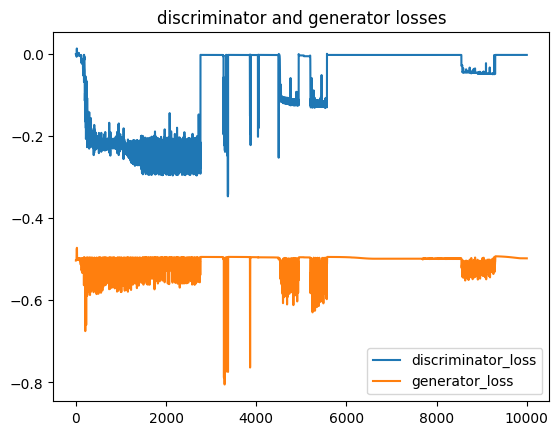

In [99]:
losses,gen =train_GAN(
            learning_rate = 0.002,
            num_epochs = 100,
            N_z = N_z, # as set in paper
            n_in_epoch=100,
            batch_size = 100,
            update_gen = 5, # update gen every n step 
            val_clip = 0.01
                )
losses_df = pd.DataFrame(data=losses,columns=['discriminator_loss','generator_loss'])
plt.plot(losses_df['discriminator_loss'],label = 'discriminator_loss')
plt.plot(losses_df['generator_loss'],label='generator_loss')
plt.legend()
plt.title('discriminator and generator losses')
plt.show()

In [109]:
noise = torch.randn(1, len(log_returns_normalized), N_z, device=device)
generated_snp_gaus = gen(noise).detach().reshape(len(log_returns_normalized)).numpy()
generated_snp_gaus


array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

SnP generated data is unrealistic.

# Conclusion
- I have implemented Quant GAN and tried different hyperparameters for it to learn properly.
- I was not successful in fitting model that can generate undistinguishable from reality returns
- I believe that some more sophisticated GANs should improve the situation and actully lead to desired result